## Dependancy Management

In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [2]:
!pip install pytorch-metric-learning


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import random_split, TensorDataset, DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import itertools
import random
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import nbformat
from torchmetrics.image import PeakSignalNoiseRatio
from torch.amp import autocast, GradScaler
from pytorch_metric_learning.samplers import MPerClassSampler
import glob
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Data Processing Pipeline

Labels shape: (512, 217)
Hypercube shape: (512, 217, 204)


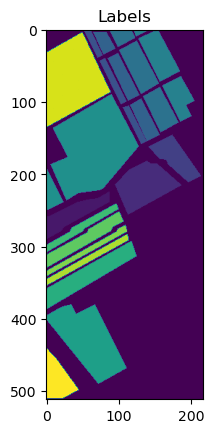

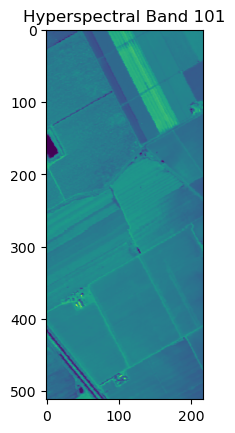

In [5]:
dataset_dir = r"C:\Users\vella\Documents\GitHub\FYP2425_LOCAL\FYP_DATASET"

gt_files = 'Salinas_gt.mat'
data_files = 'Salinas_corrected.mat'
label_files = 'salinas_gt'
hypercube_files = 'salinas_corrected'

def extract_Features():
    gt_file = os.path.join(dataset_dir, gt_files)
    data_file = os.path.join(dataset_dir, data_files)

    gt = sio.loadmat(gt_file)
    labels = gt[label_files]

    data = sio.loadmat(data_file)
    hypercube = data[hypercube_files]
    #scaling the data in place and setting to float32 to reduce memory usage
    max_value = np.max(hypercube)
    hypercube = (hypercube / max_value).astype(np.float32)


    #shapes of loaded data
    print(f"Labels shape: {labels.shape}")
    print(f"Hypercube shape: {hypercube.shape}")

    #visualisation of label map and a given band of hyperspectral data
    plt.figure()
    plt.imshow(labels)
    plt.title('Labels')

    band = 101
    plt.figure()
    plt.imshow(hypercube[:,:,band])
    plt.title(f'Hyperspectral Band {band}')
    plt.show()

    return hypercube, labels

hypercube, labels = extract_Features()

In [6]:
def extract_windows(data, labels, window_size):
    extract_windows_save_dir = 'extracted_windows_labels'
    if not os.path.exists(extract_windows_save_dir):
        os.makedirs(extract_windows_save_dir)
        print(f"Created directory: {extract_windows_save_dir}")

    margin = window_size // 2
    padded_data = np.pad(data, ((margin, margin), (margin, margin), (0, 0)), mode='constant')
    padded_labels = np.pad(labels, ((margin, margin), (margin, margin)), mode='constant')

    X_windows = []  #extracted windows
    y_labels = []   #corresponding labels

    print("Starting window extraction...")
    for i in range(margin, padded_data.shape[0] - margin):
        for j in range(margin, padded_data.shape[1] - margin):
            window = padded_data[i-margin:i+margin+1, j-margin:j+margin+1, :]
            label = padded_labels[i, j]

            if label != 0:
                #print('ignoring label 0 (background)')
                X_windows.append(window)
                y_labels.append(label)

    #convertying to numpy arrays
    X_windows = np.array(X_windows)
    y_labels = np.array(y_labels)

    #saving extracted windows and labels
    windows_file = os.path.join(extract_windows_save_dir, 'extracted_windows.npy')
    labels_file = os.path.join(extract_windows_save_dir, 'extracted_labels.npy')

    np.save(windows_file, X_windows)
    np.save(labels_file, y_labels)

    print(f"Saved extracted windows to: {windows_file}")
    print(f"Saved corresponding labels to: {labels_file}")
    print(f"\nTotal windows extracted: {len(X_windows)}")
    print(f"Extracted windows shape: {X_windows.shape}")
    print(f"Corresponding labels shape: {y_labels.shape}")

    return X_windows, y_labels

In [7]:
window_size = 5

X_windows, y_labels = extract_windows(hypercube, labels, window_size)

Created directory: extracted_windows_labels
Starting window extraction...


Saved extracted windows to: extracted_windows_labels\extracted_windows.npy
Saved corresponding labels to: extracted_windows_labels\extracted_labels.npy

Total windows extracted: 54129
Extracted windows shape: (54129, 5, 5, 204)
Corresponding labels shape: (54129,)


In [8]:
def get_samples(X_windows, y_labels, samples_per_class):
    
    indices_save_dir = 'indices'
    if not os.path.exists(indices_save_dir):
        os.makedirs(indices_save_dir)
        print(f"Created directory: {indices_save_dir}")
    
    #get unique classes
    classes = np.unique(y_labels)
    print(f"Unique classes found as: {classes}")

    #init lists
    X_sampled = [] #to store training samples
    y_sampled = [] #to store training labels

    X_val = [] # to store validation samples
    y_val = [] # to store validation labels

    selected_indices_total = [] #to store indices of selected training and validation samples
    validation_selected = [] #temp storage for validation indices
    validation_total = [] #to store all validation indices

    print("\n == STARTING SAMPLING PROCESS ==")
    for cls in classes:
        if cls == 0:
            print(f"!! SKIPPING CLASS 0 !!")
            continue

        #getting the indices for the current class:
        class_indices = np.where(y_labels == cls)[0]
        print(f"Class: {cls}: Found {len(class_indices)} samples")

        # shuffle class-specific indices to ensure randomness
        np.random.shuffle(class_indices)
        print(f"Shuffled class indices for class '{cls}'")

        #select 'samples_per_class' samples for training
        selected_indices = class_indices[:samples_per_class]
        #selecting 5 samples for validation
        validation_selected = class_indices[samples_per_class:samples_per_class+5]

        print(f"Selected {len(selected_indices)} training samples and {len(validation_selected)} validation samples for class '{cls}'\n")

        #store selected indices for training and validation
        selected_indices_total.extend(selected_indices)
        validation_total.extend(validation_selected)

        # appending the selected samples and their labels to the lists
        X_sampled.append(X_windows[selected_indices])
        y_sampled.append(y_labels[selected_indices])

        X_val.append(X_windows[validation_selected])
        y_val.append(y_labels[validation_selected])

    #concat the sampled arrays for training
    X_train = np.vstack(X_sampled)
    y_train = np.hstack(y_sampled)

    # shift labels to start from 0
    y_train = y_train - 1

    print(f"\n -- Training set created with: \n\t{X_train.shape[0]} samples\n\tshape {X_train.shape} --")

    #concat the sampled arrays for validation
    X_val = np.vstack(X_val)
    y_val = np.hstack(y_val)
    y_val = y_val - 1

    print(f"\n -- Validation set created with: \n\t{X_val.shape[0]} samples\n\tshape {X_val.shape} --")

    #create the test set from the remaining data (i.e. that which is not selected for training or validation)
    selected_indices_total.extend(validation_total)

    #getting indices not in the training or val sets
    test_indices = np.setdiff1d(np.arange(X_windows.shape[0]), selected_indices_total)
    X_test = X_windows[test_indices]
    y_test = y_labels[test_indices]
    y_test = y_test - 1

    print(f"\n -- Test set created with: \n\t{X_test.shape[0]} samples\n\tshape {X_test.shape} --\n")

    # Save the datasets to the 'datasets' folder
    np.save(os.path.join(indices_save_dir, 'X_train.npy'), X_train)
    np.save(os.path.join(indices_save_dir, 'y_train.npy'), y_train)
    np.save(os.path.join(indices_save_dir, 'X_val.npy'), X_val)
    np.save(os.path.join(indices_save_dir, 'y_val.npy'), y_val)
    np.save(os.path.join(indices_save_dir, 'X_test.npy'), X_test)
    np.save(os.path.join(indices_save_dir, 'y_test.npy'), y_test)

    print(f"\nAll datasets saved to the '{indices_save_dir}' folder.")

    #return the training, val, test sets + selected indices
    return X_train, X_test, y_train, y_test, X_val, y_val, selected_indices_total

In [9]:
X_train, X_test, y_train, y_test, X_val, y_val, selected_indices_total = get_samples(X_windows, y_labels, 5)
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

Created directory: indices
Unique classes found as: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]

 == STARTING SAMPLING PROCESS ==
Class: 1: Found 2009 samples
Shuffled class indices for class '1'
Selected 5 training samples and 5 validation samples for class '1'

Class: 2: Found 3726 samples
Shuffled class indices for class '2'
Selected 5 training samples and 5 validation samples for class '2'

Class: 3: Found 1976 samples
Shuffled class indices for class '3'
Selected 5 training samples and 5 validation samples for class '3'

Class: 4: Found 1394 samples
Shuffled class indices for class '4'
Selected 5 training samples and 5 validation samples for class '4'

Class: 5: Found 2678 samples
Shuffled class indices for class '5'
Selected 5 training samples and 5 validation samples for class '5'

Class: 6: Found 3959 samples
Shuffled class indices for class '6'
Selected 5 training samples and 5 validation samples for class '6'

Class: 7: Found 3579 samples
Shuffled class indices for clas


 -- Test set created with: 
	53969 samples
	shape (53969, 5, 5, 204) --




All datasets saved to the 'indices' folder.
(80, 5, 5, 204)
(80, 5, 5, 204)
(53969, 5, 5, 204)


In [10]:
class HyperspectralDataset(Dataset):
    def __init__(self, X, y):
        """
        Args:
            X (numpy.ndarray): Hyperspectral data of shape (num_samples, height, width, num_bands).
            y (numpy.ndarray): Labels of shape (num_samples,).
        """
        #converting to pytorch tensor
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [11]:
#loading the saved datasets
X_train = np.load('indices/X_train.npy')
y_train = np.load('indices/y_train.npy')
X_val = np.load('indices/X_val.npy')
y_val = np.load('indices/y_val.npy')
X_test = np.load('indices/X_test.npy')
y_test = np.load('indices/y_test.npy')


#creating pytorch datasets
train_dataset = HyperspectralDataset(X_train, y_train)
val_dataset = HyperspectralDataset(X_val, y_val)
test_dataset = HyperspectralDataset(X_test, y_test)

m = 20
num_classes = len(np.unique(y_train))

#theoretical batch size calc
required_batch_size = m * num_classes  # 10 * 9 = 90

#ensuring batch size doesn't exceed training set size
if required_batch_size > len(train_dataset):
    #case 1: not enough samples - reduce m proportionally
    print("Case 1 applied")
    max_possible_m = len(train_dataset) // num_classes
    m = max(1, max_possible_m)
    batch_size_train = m * num_classes
else:
    #case 2: use full batch size
    print("Case 2 applied")
    batch_size_train = required_batch_size

sampler = MPerClassSampler(labels = y_train, m=m, batch_size = batch_size_train, length_before_new_iter = len(train_dataset))

#dataloaders
train_loader = DataLoader(train_dataset, batch_size = batch_size_train, sampler=sampler)

batch_size = 256
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("DataLoaders created successfully!")

#class dist in first batch
for X_batch, y_batch in train_loader:
    unique, counts = np.unique(y_batch.numpy(), return_counts=True)
    print(f"Training batch size: {batch_size_train}")
    print("Class distribution in batch:", dict(zip(unique, counts)))
    break



Case 1 applied
DataLoaders created successfully!
Training batch size: 80
Class distribution in batch: {0: 5, 1: 5, 2: 5, 3: 5, 4: 5, 5: 5, 6: 5, 7: 5, 8: 5, 9: 5, 10: 5, 11: 5, 12: 5, 13: 5, 14: 5, 15: 5}


## Creating directory for saving model predictions

In [12]:
predictions_dir = 'model_predictions'
os.makedirs(predictions_dir, exist_ok=True)
print(f"Created dir: {predictions_dir}")

Created dir: model_predictions


## Creating the Dataset splits and Dataloaders for unsupervised tasks

In [13]:
X_train, X_val = train_test_split(X_windows, test_size=0.2, random_state=42)

print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")

Training data shape: (43303, 5, 5, 204)
Validation data shape: (10826, 5, 5, 204)


In [14]:
class UnsupervisedDataset(Dataset):
    def __init__(self, data):
        self.data = torch.tensor(data, dtype=torch.float32)  #converting to pytorch tensor

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [15]:
#creating datasets for unsupervised task
unsup_train_dataset = UnsupervisedDataset(X_train)
unsup_val_dataset = UnsupervisedDataset(X_val)

#dataloaders for unsupervised task
batch_size = 64
train_loader_cae = DataLoader(unsup_train_dataset, batch_size=batch_size, shuffle=True)
val_loader_cae = DataLoader(unsup_val_dataset, batch_size=batch_size, shuffle=False)

print("DataLoaders created successfully!")

DataLoaders created successfully!


In [16]:
window_num_channels = X_windows.shape[3]
print(window_num_channels)

204


## Convolutional Autoencoder

In [17]:
class ConvAutoEncode(nn.Module):
    def __init__(self, dropout_prob=0.1):
        super(ConvAutoEncode, self).__init__()

        #encoder
        self.encoder = nn.Sequential(
            #Block 1
            nn.Conv2d(window_num_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 5x5 -> 2x2

            #Block 2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            #Bottleneck
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.MaxPool2d(2, 2)  # 2x2 -> 1x1
        )

        #decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 128, kernel_size=2, stride=2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.ConvTranspose2d(64, window_num_channels, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded


LOG: Epoch [1/50]


	 Training Batch [1/677], Loss: 0.1550, PSNR: 7.2417


	 Training Batch [200/677], Loss: 0.0887, PSNR: 9.6418


	 Training Batch [400/677], Loss: 0.0444, PSNR: 12.6348


	 Training Batch [600/677], Loss: 0.0261, PSNR: 14.9982


Epoch [1/50] Training Loss: 0.0667, PSNR: 11.6389
	[Val]   Batch [1/170] Loss: 0.0208, PSNR: 15.9106
	[Val]   Batch [10/170] Loss: 0.0204, PSNR: 16.0809
	[Val]   Batch [20/170] Loss: 0.0205, PSNR: 15.9827
	[Val]   Batch [30/170] Loss: 0.0213, PSNR: 15.7647
	[Val]   Batch [40/170] Loss: 0.0214, PSNR: 15.8393


	[Val]   Batch [50/170] Loss: 0.0202, PSNR: 16.0585
	[Val]   Batch [60/170] Loss: 0.0212, PSNR: 15.9280
	[Val]   Batch [70/170] Loss: 0.0207, PSNR: 16.0197
	[Val]   Batch [80/170] Loss: 0.0211, PSNR: 15.8323
	[Val]   Batch [90/170] Loss: 0.0204, PSNR: 16.0749


	[Val]   Batch [100/170] Loss: 0.0204, PSNR: 16.0018
	[Val]   Batch [110/170] Loss: 0.0205, PSNR: 15.9831
	[Val]   Batch [120/170] Loss: 0.0193, PSNR: 14.3016
	[Val]   Batch [130/170] Loss: 0.0204, PSNR: 16.0826


	[Val]   Batch [140/170] Loss: 0.0200, PSNR: 16.1354
	[Val]   Batch [150/170] Loss: 0.0214, PSNR: 15.8739
	[Val]   Batch [160/170] Loss: 0.0210, PSNR: 15.9122
	[Val]   Batch [170/170] Loss: 0.0219, PSNR: 15.1955
Epoch [1/50] Validation Loss: 0.0208, PSNR: 15.9009

LOG: Epoch [2/50]
	 Training Batch [1/677], Loss: 0.0206, PSNR: 15.9925


	 Training Batch [200/677], Loss: 0.0135, PSNR: 17.7024


	 Training Batch [400/677], Loss: 0.0116, PSNR: 18.4473


	 Training Batch [600/677], Loss: 0.0085, PSNR: 19.7892


Epoch [2/50] Training Loss: 0.0129, PSNR: 18.1331
	[Val]   Batch [1/170] Loss: 0.0086, PSNR: 19.7467
	[Val]   Batch [10/170] Loss: 0.0081, PSNR: 20.1046
	[Val]   Batch [20/170] Loss: 0.0082, PSNR: 19.9766
	[Val]   Batch [30/170] Loss: 0.0089, PSNR: 19.5641
	[Val]   Batch [40/170] Loss: 0.0091, PSNR: 19.5365


	[Val]   Batch [50/170] Loss: 0.0079, PSNR: 20.1216
	[Val]   Batch [60/170] Loss: 0.0089, PSNR: 19.6961
	[Val]   Batch [70/170] Loss: 0.0087, PSNR: 19.7943
	[Val]   Batch [80/170] Loss: 0.0087, PSNR: 19.6608
	[Val]   Batch [90/170] Loss: 0.0084, PSNR: 19.9451


	[Val]   Batch [100/170] Loss: 0.0084, PSNR: 19.8751
	[Val]   Batch [110/170] Loss: 0.0083, PSNR: 19.9366
	[Val]   Batch [120/170] Loss: 0.0072, PSNR: 18.6002
	[Val]   Batch [130/170] Loss: 0.0083, PSNR: 19.9643
	[Val]   Batch [140/170] Loss: 0.0077, PSNR: 20.2527


	[Val]   Batch [150/170] Loss: 0.0091, PSNR: 19.5891
	[Val]   Batch [160/170] Loss: 0.0088, PSNR: 19.6861
	[Val]   Batch [170/170] Loss: 0.0090, PSNR: 19.0331
Epoch [2/50] Validation Loss: 0.0085, PSNR: 19.7999

LOG: Epoch [3/50]
	 Training Batch [1/677], Loss: 0.0089, PSNR: 19.6570


	 Training Batch [200/677], Loss: 0.0080, PSNR: 20.1466


	 Training Batch [400/677], Loss: 0.0050, PSNR: 21.7470


	 Training Batch [600/677], Loss: 0.0058, PSNR: 21.5702


Epoch [3/50] Training Loss: 0.0066, PSNR: 20.9231
	[Val]   Batch [1/170] Loss: 0.0051, PSNR: 22.0186
	[Val]   Batch [10/170] Loss: 0.0047, PSNR: 22.4149
	[Val]   Batch [20/170] Loss: 0.0048, PSNR: 22.2801
	[Val]   Batch [30/170] Loss: 0.0053, PSNR: 21.8085
	[Val]   Batch [40/170] Loss: 0.0055, PSNR: 21.7293


	[Val]   Batch [50/170] Loss: 0.0046, PSNR: 22.4449
	[Val]   Batch [60/170] Loss: 0.0053, PSNR: 21.9244
	[Val]   Batch [70/170] Loss: 0.0052, PSNR: 22.0282
	[Val]   Batch [80/170] Loss: 0.0052, PSNR: 21.9255
	[Val]   Batch [90/170] Loss: 0.0050, PSNR: 22.2028


	[Val]   Batch [100/170] Loss: 0.0050, PSNR: 22.1193
	[Val]   Batch [110/170] Loss: 0.0049, PSNR: 22.2044
	[Val]   Batch [120/170] Loss: 0.0041, PSNR: 20.9994
	[Val]   Batch [130/170] Loss: 0.0050, PSNR: 22.2225
	[Val]   Batch [140/170] Loss: 0.0045, PSNR: 22.6189


	[Val]   Batch [150/170] Loss: 0.0055, PSNR: 21.8013
	[Val]   Batch [160/170] Loss: 0.0053, PSNR: 21.9180
	[Val]   Batch [170/170] Loss: 0.0053, PSNR: 21.3179
Epoch [3/50] Validation Loss: 0.0050, PSNR: 22.0771

LOG: Epoch [4/50]
	 Training Batch [1/677], Loss: 0.0049, PSNR: 22.2490


	 Training Batch [200/677], Loss: 0.0035, PSNR: 23.5821


	 Training Batch [400/677], Loss: 0.0039, PSNR: 23.2148


	 Training Batch [600/677], Loss: 0.0030, PSNR: 24.2505


Epoch [4/50] Training Loss: 0.0039, PSNR: 23.2204
	[Val]   Batch [1/170] Loss: 0.0028, PSNR: 24.5502
	[Val]   Batch [10/170] Loss: 0.0027, PSNR: 24.8289
	[Val]   Batch [20/170] Loss: 0.0028, PSNR: 24.7023
	[Val]   Batch [30/170] Loss: 0.0030, PSNR: 24.2452
	[Val]   Batch [40/170] Loss: 0.0030, PSNR: 24.3608


	[Val]   Batch [50/170] Loss: 0.0027, PSNR: 24.7622
	[Val]   Batch [60/170] Loss: 0.0030, PSNR: 24.4405
	[Val]   Batch [70/170] Loss: 0.0029, PSNR: 24.6226
	[Val]   Batch [80/170] Loss: 0.0029, PSNR: 24.4754
	[Val]   Batch [90/170] Loss: 0.0028, PSNR: 24.6591


	[Val]   Batch [100/170] Loss: 0.0029, PSNR: 24.4416
	[Val]   Batch [110/170] Loss: 0.0028, PSNR: 24.7060
	[Val]   Batch [120/170] Loss: 0.0025, PSNR: 23.1032
	[Val]   Batch [130/170] Loss: 0.0029, PSNR: 24.5361
	[Val]   Batch [140/170] Loss: 0.0026, PSNR: 25.0184


	[Val]   Batch [150/170] Loss: 0.0030, PSNR: 24.3598
	[Val]   Batch [160/170] Loss: 0.0029, PSNR: 24.4762
	[Val]   Batch [170/170] Loss: 0.0030, PSNR: 23.8316
Epoch [4/50] Validation Loss: 0.0028, PSNR: 24.5333

LOG: Epoch [5/50]
	 Training Batch [1/677], Loss: 0.0034, PSNR: 23.8645


	 Training Batch [200/677], Loss: 0.0030, PSNR: 24.3473


	 Training Batch [400/677], Loss: 0.0024, PSNR: 25.3601


	 Training Batch [600/677], Loss: 0.0020, PSNR: 26.0865


Epoch [5/50] Training Loss: 0.0025, PSNR: 25.1672
	[Val]   Batch [1/170] Loss: 0.0019, PSNR: 26.3411
	[Val]   Batch [10/170] Loss: 0.0018, PSNR: 26.6120
	[Val]   Batch [20/170] Loss: 0.0019, PSNR: 26.4302
	[Val]   Batch [30/170] Loss: 0.0020, PSNR: 25.9371
	[Val]   Batch [40/170] Loss: 0.0019, PSNR: 26.2524


	[Val]   Batch [50/170] Loss: 0.0018, PSNR: 26.4429
	[Val]   Batch [60/170] Loss: 0.0020, PSNR: 26.2007
	[Val]   Batch [70/170] Loss: 0.0019, PSNR: 26.4869
	[Val]   Batch [80/170] Loss: 0.0019, PSNR: 26.2721
	[Val]   Batch [90/170] Loss: 0.0019, PSNR: 26.4430


	[Val]   Batch [100/170] Loss: 0.0020, PSNR: 26.1118
	[Val]   Batch [110/170] Loss: 0.0018, PSNR: 26.5822
	[Val]   Batch [120/170] Loss: 0.0018, PSNR: 24.6987
	[Val]   Batch [130/170] Loss: 0.0020, PSNR: 26.1896
	[Val]   Batch [140/170] Loss: 0.0017, PSNR: 26.7773


	[Val]   Batch [150/170] Loss: 0.0020, PSNR: 26.1410
	[Val]   Batch [160/170] Loss: 0.0019, PSNR: 26.2836
	[Val]   Batch [170/170] Loss: 0.0020, PSNR: 25.5774
Epoch [5/50] Validation Loss: 0.0019, PSNR: 26.2866

LOG: Epoch [6/50]
	 Training Batch [1/677], Loss: 0.0020, PSNR: 26.1350


	 Training Batch [200/677], Loss: 0.0018, PSNR: 26.5398


	 Training Batch [400/677], Loss: 0.0019, PSNR: 26.3028


	 Training Batch [600/677], Loss: 0.0017, PSNR: 26.9668


Epoch [6/50] Training Loss: 0.0018, PSNR: 26.4868
	[Val]   Batch [1/170] Loss: 0.0014, PSNR: 27.5510
	[Val]   Batch [10/170] Loss: 0.0014, PSNR: 27.8115
	[Val]   Batch [20/170] Loss: 0.0014, PSNR: 27.5845
	[Val]   Batch [30/170] Loss: 0.0016, PSNR: 27.0607
	[Val]   Batch [40/170] Loss: 0.0015, PSNR: 27.5177


	[Val]   Batch [50/170] Loss: 0.0014, PSNR: 27.5585
	[Val]   Batch [60/170] Loss: 0.0015, PSNR: 27.3754
	[Val]   Batch [70/170] Loss: 0.0014, PSNR: 27.7585
	[Val]   Batch [80/170] Loss: 0.0014, PSNR: 27.4845


	[Val]   Batch [90/170] Loss: 0.0014, PSNR: 27.6621
	[Val]   Batch [100/170] Loss: 0.0015, PSNR: 27.2349
	[Val]   Batch [110/170] Loss: 0.0013, PSNR: 27.8558
	[Val]   Batch [120/170] Loss: 0.0014, PSNR: 25.7725


	[Val]   Batch [130/170] Loss: 0.0015, PSNR: 27.3126
	[Val]   Batch [140/170] Loss: 0.0013, PSNR: 27.9748
	[Val]   Batch [150/170] Loss: 0.0015, PSNR: 27.3148
	[Val]   Batch [160/170] Loss: 0.0015, PSNR: 27.4914
	[Val]   Batch [170/170] Loss: 0.0015, PSNR: 26.7776
Epoch [6/50] Validation Loss: 0.0015, PSNR: 27.4641

LOG: Epoch [7/50]
	 Training Batch [1/677], Loss: 0.0014, PSNR: 27.6005


	 Training Batch [200/677], Loss: 0.0017, PSNR: 26.9095


	 Training Batch [400/677], Loss: 0.0013, PSNR: 27.9919


	 Training Batch [600/677], Loss: 0.0013, PSNR: 27.8948


Epoch [7/50] Training Loss: 0.0015, PSNR: 27.4887
	[Val]   Batch [1/170] Loss: 0.0011, PSNR: 28.6167
	[Val]   Batch [10/170] Loss: 0.0011, PSNR: 28.8802
	[Val]   Batch [20/170] Loss: 0.0011, PSNR: 28.6117
	[Val]   Batch [30/170] Loss: 0.0013, PSNR: 28.0719
	[Val]   Batch [40/170] Loss: 0.0011, PSNR: 28.6319


	[Val]   Batch [50/170] Loss: 0.0011, PSNR: 28.5278
	[Val]   Batch [60/170] Loss: 0.0012, PSNR: 28.4193
	[Val]   Batch [70/170] Loss: 0.0011, PSNR: 28.8637
	[Val]   Batch [80/170] Loss: 0.0011, PSNR: 28.5706
	[Val]   Batch [90/170] Loss: 0.0011, PSNR: 28.7198


	[Val]   Batch [100/170] Loss: 0.0012, PSNR: 28.2263
	[Val]   Batch [110/170] Loss: 0.0010, PSNR: 28.9796
	[Val]   Batch [120/170] Loss: 0.0011, PSNR: 26.6928
	[Val]   Batch [130/170] Loss: 0.0012, PSNR: 28.3034
	[Val]   Batch [140/170] Loss: 0.0010, PSNR: 29.0326


	[Val]   Batch [150/170] Loss: 0.0012, PSNR: 28.3711
	[Val]   Batch [160/170] Loss: 0.0011, PSNR: 28.5548
	[Val]   Batch [170/170] Loss: 0.0012, PSNR: 27.8715
Epoch [7/50] Validation Loss: 0.0011, PSNR: 28.5083

LOG: Epoch [8/50]
	 Training Batch [1/677], Loss: 0.0013, PSNR: 27.9096


	 Training Batch [200/677], Loss: 0.0014, PSNR: 27.7595


	 Training Batch [400/677], Loss: 0.0011, PSNR: 28.7269


	 Training Batch [600/677], Loss: 0.0012, PSNR: 28.2012


Epoch [8/50] Training Loss: 0.0012, PSNR: 28.3134
	[Val]   Batch [1/170] Loss: 0.0009, PSNR: 29.5304
	[Val]   Batch [10/170] Loss: 0.0009, PSNR: 29.7834
	[Val]   Batch [20/170] Loss: 0.0009, PSNR: 29.4856
	[Val]   Batch [30/170] Loss: 0.0010, PSNR: 28.9082
	[Val]   Batch [40/170] Loss: 0.0009, PSNR: 29.5901
	[Val]   Batch [50/170] Loss: 0.0009, PSNR: 29.3584


	[Val]   Batch [60/170] Loss: 0.0010, PSNR: 29.3000
	[Val]   Batch [70/170] Loss: 0.0009, PSNR: 29.8468
	[Val]   Batch [80/170] Loss: 0.0009, PSNR: 29.4808
	[Val]   Batch [90/170] Loss: 0.0009, PSNR: 29.6808
	[Val]   Batch [100/170] Loss: 0.0010, PSNR: 29.0957


	[Val]   Batch [110/170] Loss: 0.0008, PSNR: 29.9726
	[Val]   Batch [120/170] Loss: 0.0009, PSNR: 27.5219
	[Val]   Batch [130/170] Loss: 0.0010, PSNR: 29.1751
	[Val]   Batch [140/170] Loss: 0.0008, PSNR: 29.9603
	[Val]   Batch [150/170] Loss: 0.0010, PSNR: 29.2190


	[Val]   Batch [160/170] Loss: 0.0009, PSNR: 29.4611
	[Val]   Batch [170/170] Loss: 0.0010, PSNR: 28.7840
Epoch [8/50] Validation Loss: 0.0009, PSNR: 29.3945

LOG: Epoch [9/50]
	 Training Batch [1/677], Loss: 0.0013, PSNR: 27.9507


	 Training Batch [200/677], Loss: 0.0009, PSNR: 29.4809


	 Training Batch [400/677], Loss: 0.0010, PSNR: 29.3253


	 Training Batch [600/677], Loss: 0.0009, PSNR: 29.5608


Epoch [9/50] Training Loss: 0.0010, PSNR: 29.0360
	[Val]   Batch [1/170] Loss: 0.0007, PSNR: 30.3719
	[Val]   Batch [10/170] Loss: 0.0007, PSNR: 30.6324
	[Val]   Batch [20/170] Loss: 0.0008, PSNR: 30.3215
	[Val]   Batch [30/170] Loss: 0.0009, PSNR: 29.7128
	[Val]   Batch [40/170] Loss: 0.0007, PSNR: 30.4376


	[Val]   Batch [50/170] Loss: 0.0008, PSNR: 30.1499
	[Val]   Batch [60/170] Loss: 0.0008, PSNR: 30.1145
	[Val]   Batch [70/170] Loss: 0.0007, PSNR: 30.7141
	[Val]   Batch [80/170] Loss: 0.0007, PSNR: 30.3425
	[Val]   Batch [90/170] Loss: 0.0007, PSNR: 30.5531


	[Val]   Batch [100/170] Loss: 0.0008, PSNR: 29.9211
	[Val]   Batch [110/170] Loss: 0.0007, PSNR: 30.8716
	[Val]   Batch [120/170] Loss: 0.0008, PSNR: 28.3177
	[Val]   Batch [130/170] Loss: 0.0008, PSNR: 29.9874
	[Val]   Batch [140/170] Loss: 0.0007, PSNR: 30.8429


	[Val]   Batch [150/170] Loss: 0.0008, PSNR: 30.0276
	[Val]   Batch [160/170] Loss: 0.0008, PSNR: 30.2833
	[Val]   Batch [170/170] Loss: 0.0008, PSNR: 29.6167
Epoch [9/50] Validation Loss: 0.0008, PSNR: 30.2204

LOG: Epoch [10/50]
	 Training Batch [1/677], Loss: 0.0010, PSNR: 28.9659


	 Training Batch [200/677], Loss: 0.0008, PSNR: 30.0464


	 Training Batch [400/677], Loss: 0.0008, PSNR: 29.9396


	 Training Batch [600/677], Loss: 0.0009, PSNR: 29.8195


Epoch [10/50] Training Loss: 0.0009, PSNR: 29.6802
	[Val]   Batch [1/170] Loss: 0.0006, PSNR: 31.1491
	[Val]   Batch [10/170] Loss: 0.0006, PSNR: 31.4484
	[Val]   Batch [20/170] Loss: 0.0006, PSNR: 31.1042
	[Val]   Batch [30/170] Loss: 0.0007, PSNR: 30.5079
	[Val]   Batch [40/170] Loss: 0.0006, PSNR: 31.2145


	[Val]   Batch [50/170] Loss: 0.0007, PSNR: 30.8392
	[Val]   Batch [60/170] Loss: 0.0007, PSNR: 30.9033
	[Val]   Batch [70/170] Loss: 0.0006, PSNR: 31.4835
	[Val]   Batch [80/170] Loss: 0.0006, PSNR: 31.1904
	[Val]   Batch [90/170] Loss: 0.0006, PSNR: 31.3682


	[Val]   Batch [100/170] Loss: 0.0007, PSNR: 30.7453
	[Val]   Batch [110/170] Loss: 0.0006, PSNR: 31.6644
	[Val]   Batch [120/170] Loss: 0.0006, PSNR: 29.0287
	[Val]   Batch [130/170] Loss: 0.0007, PSNR: 30.8299
	[Val]   Batch [140/170] Loss: 0.0006, PSNR: 31.6309


	[Val]   Batch [150/170] Loss: 0.0007, PSNR: 30.8615
	[Val]   Batch [160/170] Loss: 0.0006, PSNR: 31.0460
	[Val]   Batch [170/170] Loss: 0.0006, PSNR: 30.5330
Epoch [10/50] Validation Loss: 0.0006, PSNR: 31.0141

LOG: Epoch [11/50]
	 Training Batch [1/677], Loss: 0.0007, PSNR: 30.5066


	 Training Batch [200/677], Loss: 0.0007, PSNR: 30.5172


	 Training Batch [400/677], Loss: 0.0007, PSNR: 30.4668


	 Training Batch [600/677], Loss: 0.0007, PSNR: 30.6914


Epoch [11/50] Training Loss: 0.0008, PSNR: 30.2583
	[Val]   Batch [1/170] Loss: 0.0005, PSNR: 31.8621
	[Val]   Batch [10/170] Loss: 0.0005, PSNR: 32.1997
	[Val]   Batch [20/170] Loss: 0.0005, PSNR: 31.7641
	[Val]   Batch [30/170] Loss: 0.0006, PSNR: 31.2375
	[Val]   Batch [40/170] Loss: 0.0005, PSNR: 31.9364


	[Val]   Batch [50/170] Loss: 0.0006, PSNR: 31.5802
	[Val]   Batch [60/170] Loss: 0.0006, PSNR: 31.6252
	[Val]   Batch [70/170] Loss: 0.0005, PSNR: 32.1408
	[Val]   Batch [80/170] Loss: 0.0005, PSNR: 31.9001
	[Val]   Batch [90/170] Loss: 0.0005, PSNR: 32.1390


	[Val]   Batch [100/170] Loss: 0.0006, PSNR: 31.4795
	[Val]   Batch [110/170] Loss: 0.0005, PSNR: 32.4122
	[Val]   Batch [120/170] Loss: 0.0005, PSNR: 29.7563
	[Val]   Batch [130/170] Loss: 0.0006, PSNR: 31.5552
	[Val]   Batch [140/170] Loss: 0.0005, PSNR: 32.3870


	[Val]   Batch [150/170] Loss: 0.0006, PSNR: 31.5602
	[Val]   Batch [160/170] Loss: 0.0006, PSNR: 31.6873
	[Val]   Batch [170/170] Loss: 0.0005, PSNR: 31.2559
Epoch [11/50] Validation Loss: 0.0005, PSNR: 31.7197

LOG: Epoch [12/50]
	 Training Batch [1/677], Loss: 0.0007, PSNR: 30.4542


	 Training Batch [200/677], Loss: 0.0006, PSNR: 31.5535


	 Training Batch [400/677], Loss: 0.0007, PSNR: 30.7671


	 Training Batch [600/677], Loss: 0.0007, PSNR: 30.5991


Epoch [12/50] Training Loss: 0.0007, PSNR: 30.7400
	[Val]   Batch [1/170] Loss: 0.0004, PSNR: 32.6144
	[Val]   Batch [10/170] Loss: 0.0004, PSNR: 32.9537
	[Val]   Batch [20/170] Loss: 0.0005, PSNR: 32.5050
	[Val]   Batch [30/170] Loss: 0.0005, PSNR: 32.0462
	[Val]   Batch [40/170] Loss: 0.0004, PSNR: 32.7232


	[Val]   Batch [50/170] Loss: 0.0005, PSNR: 32.1923
	[Val]   Batch [60/170] Loss: 0.0005, PSNR: 32.4308
	[Val]   Batch [70/170] Loss: 0.0004, PSNR: 32.9083
	[Val]   Batch [80/170] Loss: 0.0004, PSNR: 32.7449
	[Val]   Batch [90/170] Loss: 0.0004, PSNR: 32.9491


	[Val]   Batch [100/170] Loss: 0.0005, PSNR: 32.2967
	[Val]   Batch [110/170] Loss: 0.0004, PSNR: 33.2028
	[Val]   Batch [120/170] Loss: 0.0005, PSNR: 30.4124
	[Val]   Batch [130/170] Loss: 0.0005, PSNR: 32.3981
	[Val]   Batch [140/170] Loss: 0.0004, PSNR: 33.1030


	[Val]   Batch [150/170] Loss: 0.0005, PSNR: 32.4058
	[Val]   Batch [160/170] Loss: 0.0005, PSNR: 32.4455
	[Val]   Batch [170/170] Loss: 0.0004, PSNR: 32.3536
Epoch [12/50] Validation Loss: 0.0005, PSNR: 32.5053

LOG: Epoch [13/50]
	 Training Batch [1/677], Loss: 0.0005, PSNR: 31.8503


	 Training Batch [200/677], Loss: 0.0006, PSNR: 31.4734


	 Training Batch [400/677], Loss: 0.0006, PSNR: 31.1467


	 Training Batch [600/677], Loss: 0.0007, PSNR: 30.8331


Epoch [13/50] Training Loss: 0.0006, PSNR: 31.1977
	[Val]   Batch [1/170] Loss: 0.0004, PSNR: 33.0227
	[Val]   Batch [10/170] Loss: 0.0004, PSNR: 33.3772
	[Val]   Batch [20/170] Loss: 0.0004, PSNR: 32.8829
	[Val]   Batch [30/170] Loss: 0.0005, PSNR: 32.5001
	[Val]   Batch [40/170] Loss: 0.0004, PSNR: 33.1205


	[Val]   Batch [50/170] Loss: 0.0004, PSNR: 32.6026
	[Val]   Batch [60/170] Loss: 0.0004, PSNR: 32.8676
	[Val]   Batch [70/170] Loss: 0.0004, PSNR: 33.2868
	[Val]   Batch [80/170] Loss: 0.0004, PSNR: 33.1714
	[Val]   Batch [90/170] Loss: 0.0004, PSNR: 33.4266


	[Val]   Batch [100/170] Loss: 0.0004, PSNR: 32.7972
	[Val]   Batch [110/170] Loss: 0.0004, PSNR: 33.6166
	[Val]   Batch [120/170] Loss: 0.0004, PSNR: 30.8732
	[Val]   Batch [130/170] Loss: 0.0004, PSNR: 32.8979
	[Val]   Batch [140/170] Loss: 0.0004, PSNR: 33.5247


	[Val]   Batch [150/170] Loss: 0.0004, PSNR: 32.8622
	[Val]   Batch [160/170] Loss: 0.0004, PSNR: 32.8238
	[Val]   Batch [170/170] Loss: 0.0004, PSNR: 32.8066
Epoch [13/50] Validation Loss: 0.0004, PSNR: 32.9269

LOG: Epoch [14/50]
	 Training Batch [1/677], Loss: 0.0006, PSNR: 31.4717


	 Training Batch [200/677], Loss: 0.0006, PSNR: 31.7266


	 Training Batch [400/677], Loss: 0.0005, PSNR: 32.0135


	 Training Batch [600/677], Loss: 0.0006, PSNR: 31.5794


Epoch [14/50] Training Loss: 0.0006, PSNR: 31.5864
	[Val]   Batch [1/170] Loss: 0.0004, PSNR: 33.5891
	[Val]   Batch [10/170] Loss: 0.0003, PSNR: 33.9563
	[Val]   Batch [20/170] Loss: 0.0004, PSNR: 33.4125
	[Val]   Batch [30/170] Loss: 0.0004, PSNR: 33.1147
	[Val]   Batch [40/170] Loss: 0.0004, PSNR: 33.6954
	[Val]   Batch [50/170] Loss: 0.0004, PSNR: 33.0760


	[Val]   Batch [60/170] Loss: 0.0004, PSNR: 33.4862
	[Val]   Batch [70/170] Loss: 0.0003, PSNR: 33.8199
	[Val]   Batch [80/170] Loss: 0.0003, PSNR: 33.7822
	[Val]   Batch [90/170] Loss: 0.0003, PSNR: 34.0499
	[Val]   Batch [100/170] Loss: 0.0004, PSNR: 33.4332


	[Val]   Batch [110/170] Loss: 0.0003, PSNR: 34.1606
	[Val]   Batch [120/170] Loss: 0.0004, PSNR: 31.3969
	[Val]   Batch [130/170] Loss: 0.0004, PSNR: 33.5265
	[Val]   Batch [140/170] Loss: 0.0003, PSNR: 34.0710
	[Val]   Batch [150/170] Loss: 0.0004, PSNR: 33.5074


	[Val]   Batch [160/170] Loss: 0.0004, PSNR: 33.3579
	[Val]   Batch [170/170] Loss: 0.0003, PSNR: 33.4842
Epoch [14/50] Validation Loss: 0.0004, PSNR: 33.5011

LOG: Epoch [15/50]
	 Training Batch [1/677], Loss: 0.0006, PSNR: 31.2733


	 Training Batch [200/677], Loss: 0.0005, PSNR: 31.7631


	 Training Batch [400/677], Loss: 0.0005, PSNR: 32.0926


	 Training Batch [600/677], Loss: 0.0004, PSNR: 32.8479


Epoch [15/50] Training Loss: 0.0005, PSNR: 31.9284
	[Val]   Batch [1/170] Loss: 0.0003, PSNR: 33.8858
	[Val]   Batch [10/170] Loss: 0.0003, PSNR: 34.2529
	[Val]   Batch [20/170] Loss: 0.0003, PSNR: 33.6673
	[Val]   Batch [30/170] Loss: 0.0004, PSNR: 33.4824
	[Val]   Batch [40/170] Loss: 0.0003, PSNR: 33.9592


	[Val]   Batch [50/170] Loss: 0.0004, PSNR: 33.4345
	[Val]   Batch [60/170] Loss: 0.0003, PSNR: 33.8006
	[Val]   Batch [70/170] Loss: 0.0003, PSNR: 34.0435
	[Val]   Batch [80/170] Loss: 0.0003, PSNR: 34.0797
	[Val]   Batch [90/170] Loss: 0.0003, PSNR: 34.3883


	[Val]   Batch [100/170] Loss: 0.0003, PSNR: 33.7686
	[Val]   Batch [110/170] Loss: 0.0003, PSNR: 34.4503
	[Val]   Batch [120/170] Loss: 0.0003, PSNR: 31.7312
	[Val]   Batch [130/170] Loss: 0.0003, PSNR: 33.8741
	[Val]   Batch [140/170] Loss: 0.0003, PSNR: 34.3864


	[Val]   Batch [150/170] Loss: 0.0003, PSNR: 33.7916
	[Val]   Batch [160/170] Loss: 0.0004, PSNR: 33.6233
	[Val]   Batch [170/170] Loss: 0.0003, PSNR: 33.8040
Epoch [15/50] Validation Loss: 0.0003, PSNR: 33.7929

LOG: Epoch [16/50]
	 Training Batch [1/677], Loss: 0.0006, PSNR: 31.3728


	 Training Batch [200/677], Loss: 0.0006, PSNR: 31.2275


	 Training Batch [400/677], Loss: 0.0005, PSNR: 31.7879


	 Training Batch [600/677], Loss: 0.0004, PSNR: 32.5171


Epoch [16/50] Training Loss: 0.0005, PSNR: 32.2202
	[Val]   Batch [1/170] Loss: 0.0003, PSNR: 34.4192
	[Val]   Batch [10/170] Loss: 0.0003, PSNR: 34.8273
	[Val]   Batch [20/170] Loss: 0.0003, PSNR: 34.2325
	[Val]   Batch [30/170] Loss: 0.0003, PSNR: 34.0669
	[Val]   Batch [40/170] Loss: 0.0003, PSNR: 34.5170


	[Val]   Batch [50/170] Loss: 0.0003, PSNR: 33.8270
	[Val]   Batch [60/170] Loss: 0.0003, PSNR: 34.4054
	[Val]   Batch [70/170] Loss: 0.0003, PSNR: 34.5859
	[Val]   Batch [80/170] Loss: 0.0003, PSNR: 34.7061
	[Val]   Batch [90/170] Loss: 0.0003, PSNR: 34.9658


	[Val]   Batch [100/170] Loss: 0.0003, PSNR: 34.4183
	[Val]   Batch [110/170] Loss: 0.0003, PSNR: 35.0024
	[Val]   Batch [120/170] Loss: 0.0003, PSNR: 32.2413
	[Val]   Batch [130/170] Loss: 0.0003, PSNR: 34.5334
	[Val]   Batch [140/170] Loss: 0.0003, PSNR: 34.9185


	[Val]   Batch [150/170] Loss: 0.0003, PSNR: 34.4742
	[Val]   Batch [160/170] Loss: 0.0003, PSNR: 34.1411
	[Val]   Batch [170/170] Loss: 0.0002, PSNR: 34.7126
Epoch [16/50] Validation Loss: 0.0003, PSNR: 34.3804

LOG: Epoch [17/50]
	 Training Batch [1/677], Loss: 0.0005, PSNR: 31.8248


	 Training Batch [200/677], Loss: 0.0004, PSNR: 32.7817


	 Training Batch [400/677], Loss: 0.0004, PSNR: 32.9217


	 Training Batch [600/677], Loss: 0.0004, PSNR: 32.8431


Epoch [17/50] Training Loss: 0.0005, PSNR: 32.5044
	[Val]   Batch [1/170] Loss: 0.0003, PSNR: 34.8213
	[Val]   Batch [10/170] Loss: 0.0002, PSNR: 35.2521
	[Val]   Batch [20/170] Loss: 0.0003, PSNR: 34.5770
	[Val]   Batch [30/170] Loss: 0.0003, PSNR: 34.4914
	[Val]   Batch [40/170] Loss: 0.0003, PSNR: 34.9290


	[Val]   Batch [50/170] Loss: 0.0003, PSNR: 34.2096
	[Val]   Batch [60/170] Loss: 0.0003, PSNR: 34.8605
	[Val]   Batch [70/170] Loss: 0.0003, PSNR: 34.9503
	[Val]   Batch [80/170] Loss: 0.0002, PSNR: 35.1371
	[Val]   Batch [90/170] Loss: 0.0002, PSNR: 35.4223


	[Val]   Batch [100/170] Loss: 0.0003, PSNR: 34.8620
	[Val]   Batch [110/170] Loss: 0.0002, PSNR: 35.4269
	[Val]   Batch [120/170] Loss: 0.0003, PSNR: 32.5828
	[Val]   Batch [130/170] Loss: 0.0003, PSNR: 34.9758
	[Val]   Batch [140/170] Loss: 0.0002, PSNR: 35.3018


	[Val]   Batch [150/170] Loss: 0.0003, PSNR: 34.9143
	[Val]   Batch [160/170] Loss: 0.0003, PSNR: 34.5082
	[Val]   Batch [170/170] Loss: 0.0002, PSNR: 35.1831
Epoch [17/50] Validation Loss: 0.0003, PSNR: 34.7796

LOG: Epoch [18/50]
	 Training Batch [1/677], Loss: 0.0004, PSNR: 32.6847


	 Training Batch [200/677], Loss: 0.0004, PSNR: 33.2896


	 Training Batch [400/677], Loss: 0.0004, PSNR: 33.3924


	 Training Batch [600/677], Loss: 0.0004, PSNR: 33.3225


Epoch [18/50] Training Loss: 0.0004, PSNR: 32.7608
	[Val]   Batch [1/170] Loss: 0.0003, PSNR: 35.1012
	[Val]   Batch [10/170] Loss: 0.0002, PSNR: 35.4709
	[Val]   Batch [20/170] Loss: 0.0003, PSNR: 34.7729
	[Val]   Batch [30/170] Loss: 0.0003, PSNR: 34.7544
	[Val]   Batch [40/170] Loss: 0.0003, PSNR: 35.1602


	[Val]   Batch [50/170] Loss: 0.0003, PSNR: 34.5079
	[Val]   Batch [60/170] Loss: 0.0003, PSNR: 35.1095
	[Val]   Batch [70/170] Loss: 0.0003, PSNR: 35.1970
	[Val]   Batch [80/170] Loss: 0.0002, PSNR: 35.3752
	[Val]   Batch [90/170] Loss: 0.0002, PSNR: 35.7492


	[Val]   Batch [100/170] Loss: 0.0003, PSNR: 35.1244
	[Val]   Batch [110/170] Loss: 0.0002, PSNR: 35.6911
	[Val]   Batch [120/170] Loss: 0.0003, PSNR: 32.9214
	[Val]   Batch [130/170] Loss: 0.0002, PSNR: 35.2555
	[Val]   Batch [140/170] Loss: 0.0002, PSNR: 35.6273


	[Val]   Batch [150/170] Loss: 0.0003, PSNR: 35.1173
	[Val]   Batch [160/170] Loss: 0.0003, PSNR: 34.7101
	[Val]   Batch [170/170] Loss: 0.0002, PSNR: 35.3132
Epoch [18/50] Validation Loss: 0.0003, PSNR: 35.0153
Early stopping triggered at epoch 18. No improvement for 3 epochs.


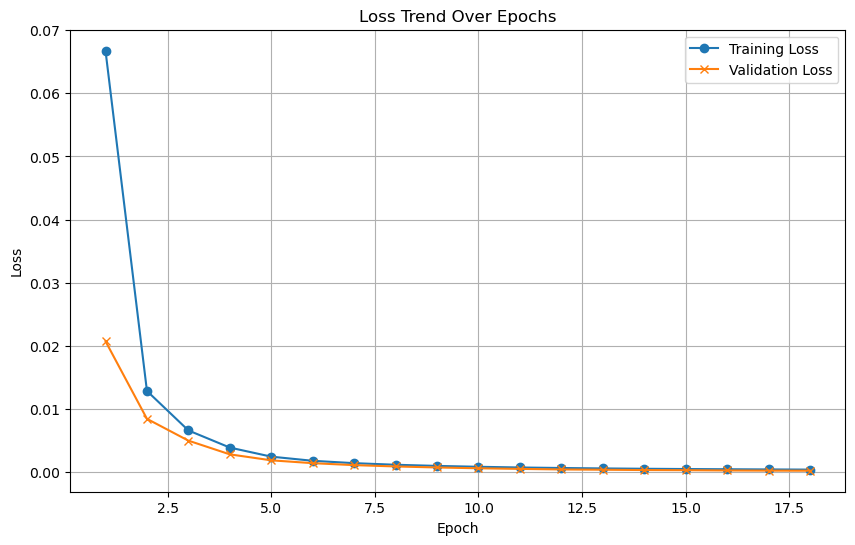

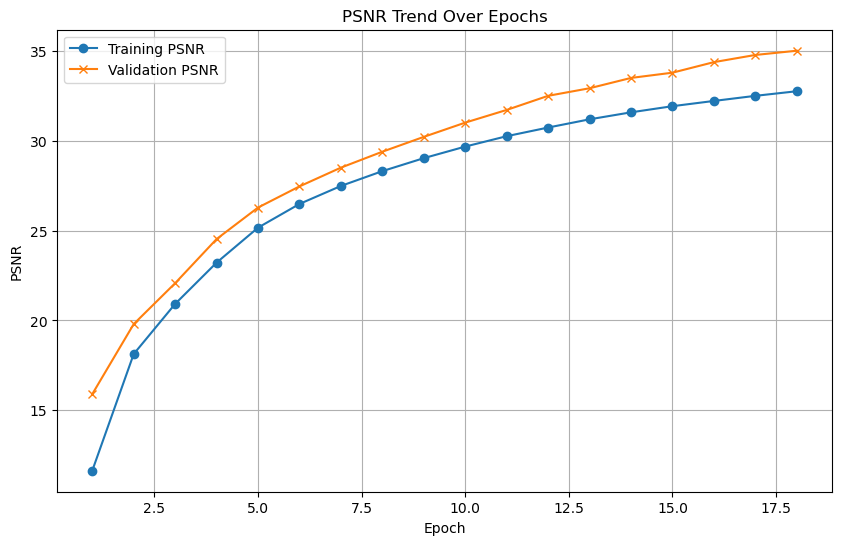

In [18]:
model_cae = ConvAutoEncode()
criterion_cae = nn.MSELoss()
optimizer_cae = optim.Adam(model_cae.parameters(), lr=0.0001)

#parameters for CAE
num_epochs_cae = 50
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_cae = model_cae.to(device)

#early stopping parameters
patience = 3  # number of epochs to wait for improvement
tolerance = 1e-4
best_val_loss = float('inf')
epochs_without_improvement = 0

#grad accumulation parameters
accumulation_steps = 8 

# for loss and metrics tracking
autoencoder_epoch_losses_cae = []
validation_epoch_losses_cae = []
train_psnr = []
val_psnr = []

psnr = PeakSignalNoiseRatio().to(device)

# mixed precision training
scaler = GradScaler()  # Gradient scaler for mixed precision

for epoch in range(num_epochs_cae):
    # training
    model_cae.train()
    running_loss = 0.0
    running_psnr = 0.0

    print(f"\nLOG: Epoch [{epoch + 1}/{num_epochs_cae}]")

    optimizer_cae.zero_grad()

    for batch_idx, data in enumerate(train_loader_cae):
        data = data.to(device).permute(0, 3, 1, 2)

        # mixed precision forward pass
        with autocast(device_type='cuda', dtype=torch.float16):
            _, decoded = model_cae(data)
            loss = criterion_cae(decoded, data) / accumulation_steps

            with torch.no_grad():
                nan_in_out = torch.isnan(decoded).any().item()
                inf_in_out = torch.isinf(decoded).any().item()

        #backward pass with gradient scaling
        scaler.scale(loss).backward()

        loss_value = loss.item() * accumulation_steps
        running_loss += loss_value

        psnr_value = psnr(decoded, data).item()
        running_psnr += psnr_value


        # performing optimizer step and reset gradients after `accumulation_steps` batches
        if (batch_idx + 1) % accumulation_steps == 0 or (batch_idx + 1) == len(train_loader_cae):
            scaler.step(optimizer_cae)
            scaler.update()
            optimizer_cae.zero_grad()

        if batch_idx == 0 or (batch_idx + 1) % 200 == 0:
            print(
    f"\t Training Batch [{batch_idx + 1}/{len(train_loader_cae)}], "
    f"Loss: {loss_value:.4f}, PSNR: {psnr_value:.4f}"
)


        #delete intermediate variables and clear GPU cache
        del data, decoded, loss
        torch.cuda.empty_cache()

    #compute average metrics for the epoch
    avg_train_loss = running_loss / len(train_loader_cae)
    avg_train_psnr = running_psnr / len(train_loader_cae)

    autoencoder_epoch_losses_cae.append(avg_train_loss)
    train_psnr.append(avg_train_psnr)

    print(f"Epoch [{epoch + 1}/{num_epochs_cae}] Training Loss: {avg_train_loss:.4f}, PSNR: {avg_train_psnr:.4f}")

    #clear GPU cache after training
    torch.cuda.empty_cache()

    #validation
    model_cae.eval()
    validation_loss = 0.0
    val_psnr_epoch = 0.0

    with torch.no_grad():
        for batch_idx, data in enumerate(val_loader_cae):
            data = data.to(device).permute(0, 3, 1, 2)

            # Mixed precision forward pass for validation
            with autocast(device_type='cuda', dtype=torch.float16):
                _, decoded = model_cae(data)
                loss = criterion_cae(decoded, data)

            validation_loss += loss.item()
            val_psnr_epoch += psnr(decoded, data).item()

            if batch_idx == 0 or (batch_idx + 1) % 10 == 0:
                loss_val = loss.item()
                psnr_val = psnr(decoded, data).item()
                print(
                    f"\t[Val]   Batch [{batch_idx + 1}/{len(val_loader_cae)}] "
                    f"Loss: {loss_val:.4f}, PSNR: {psnr_val:.4f}"
                )

            del data, decoded, loss
            torch.cuda.empty_cache()

    # average validation metrics for the epoch
    avg_val_loss = validation_loss / len(val_loader_cae)
    avg_val_psnr = val_psnr_epoch / len(val_loader_cae)

    validation_epoch_losses_cae.append(avg_val_loss)
    val_psnr.append(avg_val_psnr)

    print(f"Epoch [{epoch + 1}/{num_epochs_cae}] Validation Loss: {avg_val_loss:.4f}, PSNR: {avg_val_psnr:.4f}")

    # early stopping logic
    if avg_val_loss < best_val_loss - tolerance:
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0  # Reset counter
        #best model checkpoint
        #torch.save(model_cae.state_dict(), 'best_model_cae.pth')
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered at epoch {epoch + 1}. No improvement for {patience} epochs.")
        break

#plot for training and validation loss trends
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(autoencoder_epoch_losses_cae) + 1), autoencoder_epoch_losses_cae, marker='o', label="Training Loss")
plt.plot(range(1, len(validation_epoch_losses_cae) + 1), validation_epoch_losses_cae, marker='x', label="Validation Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Trend Over Epochs')
plt.legend()
plt.grid()
plt.show()

#plot for PSNR trends
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_psnr) + 1), train_psnr, marker='o', label="Training PSNR")
plt.plot(range(1, len(val_psnr) + 1), val_psnr, marker='x', label="Validation PSNR")
plt.xlabel('Epoch')
plt.ylabel('PSNR')
plt.title('PSNR Trend Over Epochs')
plt.legend()
plt.grid()
plt.show()

## Using the encoder section of CAE as feature extractor to generate compact representations

In [19]:
#dir to save encoded representations
encoded_dir = 'encoded_representations'
os.makedirs(encoded_dir, exist_ok=True)

loaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}

model_cae.eval()

# Feature extraction
with torch.no_grad():
    for subset_name, loader in loaders.items():
        print(f"\nExtracting representations for the {subset_name} dataset...")

        # dir for the given subset's encoded features
        subset_encoded_dir = os.path.join(encoded_dir, subset_name)
        os.makedirs(subset_encoded_dir, exist_ok=True)

        for batch_idx, (data, labels) in enumerate(loader):
            data = data.to(device).permute(0, 3, 1, 2)

            # passing data through the encoder to obtain representations
            encoded_features, _ = model_cae(data)  # latent representation

            # moving to CPU and convert to NumPy
            encoded_features = encoded_features.cpu().numpy()  
            labels = labels.cpu().numpy() 

            #saving the encoded features and labels
            np.save(os.path.join(subset_encoded_dir, f'encoded_batch_{batch_idx}.npy'), encoded_features)
            np.save(os.path.join(subset_encoded_dir, f'labels_batch_{batch_idx}.npy'), labels)

            if batch_idx % 1 == 0 and subset_name != 'test':
                print(f"    Processed batch {batch_idx + 1}/{len(loader)} for {subset_name} dataset.")
            elif subset_name == 'test' and batch_idx % 100 == 0:  # Log less frequently for the test set
                print(f"    Processed batch {batch_idx + 1}/{len(loader)} for {subset_name} dataset.")

        print(f"Completed encoding for the {subset_name} dataset.")

print("Feature extraction completed for all subsets.")


Extracting representations for the train dataset...
    Processed batch 1/1 for train dataset.
Completed encoding for the train dataset.

Extracting representations for the val dataset...
    Processed batch 1/1 for val dataset.
Completed encoding for the val dataset.

Extracting representations for the test dataset...
    Processed batch 1/211 for test dataset.


    Processed batch 101/211 for test dataset.


    Processed batch 201/211 for test dataset.
Completed encoding for the test dataset.
Feature extraction completed for all subsets.


## End-To-End CNN

In [20]:
class hyperspectralCNN(nn.Module):
    def __init__(self, input_channels, num_classes):
        super(hyperspectralCNN, self).__init__()

        self.cnn_layers = nn.Sequential(
            # Block 1
            nn.Conv2d(input_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 5x5 -> 2x2

            # Block 2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            # Bottleneck
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.MaxPool2d(2, 2)  # 2x2 -> 1x1
        )

        #fully connected layers for classification
        self.fc_layers = nn.Sequential(
            nn.Flatten(),  #3D to 1D vector for input to FC layers
            nn.Linear(16 * 2 * 2, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, num_classes)
        )

    def forward(self, x):
        x = self.cnn_layers(x)
        x = self.fc_layers(x)
        return x


LOG: Epoch [1/1000] - Training
Epoch [1/1000] completed, Average Training Loss: 2.7881
    Validation Batch [1/1], Loss: 2.7769
Validation Loss: 2.7769, Validation Accuracy: 6.25%
Validation loss improved from inf to 2.7769. Saving model...

LOG: Epoch [2/1000] - Training
Epoch [2/1000] completed, Average Training Loss: 2.7369
    Validation Batch [1/1], Loss: 2.7768
Validation Loss: 2.7768, Validation Accuracy: 6.25%
Validation loss improved from 2.7769 to 2.7768. Saving model...

LOG: Epoch [3/1000] - Training
Epoch [3/1000] completed, Average Training Loss: 2.6989
    Validation Batch [1/1], Loss: 2.7769
Validation Loss: 2.7769, Validation Accuracy: 6.25%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [4/1000] - Training
Epoch [4/1000] completed, Average Training Loss: 2.6783
    Validation Batch [1/1], Loss: 2.7769
Validation Loss: 2.7769, Validation Accuracy: 6.25%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [5/1000] - Training
Epoch [5/1000] comple

    Validation Batch [1/1], Loss: 2.7773
Validation Loss: 2.7773, Validation Accuracy: 6.25%
Validation loss did not improve. Patience: 18/100

LOG: Epoch [21/1000] - Training
Epoch [21/1000] completed, Average Training Loss: 2.4879
    Validation Batch [1/1], Loss: 2.7771
Validation Loss: 2.7771, Validation Accuracy: 6.25%
Validation loss did not improve. Patience: 19/100

LOG: Epoch [22/1000] - Training
Epoch [22/1000] completed, Average Training Loss: 2.4788
    Validation Batch [1/1], Loss: 2.7768
Validation Loss: 2.7768, Validation Accuracy: 6.25%
Validation loss improved from 2.7768 to 2.7768. Saving model...

LOG: Epoch [23/1000] - Training
Epoch [23/1000] completed, Average Training Loss: 2.4733
    Validation Batch [1/1], Loss: 2.7764
Validation Loss: 2.7764, Validation Accuracy: 6.25%
Validation loss improved from 2.7768 to 2.7764. Saving model...

LOG: Epoch [24/1000] - Training
Epoch [24/1000] completed, Average Training Loss: 2.4534
    Validation Batch [1/1], Loss: 2.7760

Epoch [51/1000] completed, Average Training Loss: 2.2347
    Validation Batch [1/1], Loss: 2.5458
Validation Loss: 2.5458, Validation Accuracy: 28.75%
Validation loss improved from 2.5683 to 2.5458. Saving model...

LOG: Epoch [52/1000] - Training
Epoch [52/1000] completed, Average Training Loss: 2.2277
    Validation Batch [1/1], Loss: 2.5239
Validation Loss: 2.5239, Validation Accuracy: 32.50%
Validation loss improved from 2.5458 to 2.5239. Saving model...

LOG: Epoch [53/1000] - Training
Epoch [53/1000] completed, Average Training Loss: 2.2547
    Validation Batch [1/1], Loss: 2.5053
Validation Loss: 2.5053, Validation Accuracy: 32.50%
Validation loss improved from 2.5239 to 2.5053. Saving model...

LOG: Epoch [54/1000] - Training
Epoch [54/1000] completed, Average Training Loss: 2.2446
    Validation Batch [1/1], Loss: 2.4897
Validation Loss: 2.4897, Validation Accuracy: 35.00%
Validation loss improved from 2.5053 to 2.4897. Saving model...

LOG: Epoch [55/1000] - Training
Epoch [5

    Validation Batch [1/1], Loss: 2.1492
Validation Loss: 2.1492, Validation Accuracy: 48.75%
Validation loss improved from 2.1505 to 2.1492. Saving model...

LOG: Epoch [82/1000] - Training
Epoch [82/1000] completed, Average Training Loss: 2.0226
    Validation Batch [1/1], Loss: 2.1403
Validation Loss: 2.1403, Validation Accuracy: 48.75%
Validation loss improved from 2.1492 to 2.1403. Saving model...

LOG: Epoch [83/1000] - Training
Epoch [83/1000] completed, Average Training Loss: 2.0189
    Validation Batch [1/1], Loss: 2.1251
Validation Loss: 2.1251, Validation Accuracy: 48.75%
Validation loss improved from 2.1403 to 2.1251. Saving model...

LOG: Epoch [84/1000] - Training
Epoch [84/1000] completed, Average Training Loss: 2.0395
    Validation Batch [1/1], Loss: 2.1043
Validation Loss: 2.1043, Validation Accuracy: 48.75%
Validation loss improved from 2.1251 to 2.1043. Saving model...

LOG: Epoch [85/1000] - Training
Epoch [85/1000] completed, Average Training Loss: 2.0527
    Vali

Epoch [110/1000] completed, Average Training Loss: 1.8516
    Validation Batch [1/1], Loss: 1.9652
Validation Loss: 1.9652, Validation Accuracy: 56.25%
Validation loss improved from 1.9795 to 1.9652. Saving model...

LOG: Epoch [111/1000] - Training
Epoch [111/1000] completed, Average Training Loss: 1.7917
    Validation Batch [1/1], Loss: 1.9451
Validation Loss: 1.9451, Validation Accuracy: 57.50%
Validation loss improved from 1.9652 to 1.9451. Saving model...

LOG: Epoch [112/1000] - Training
Epoch [112/1000] completed, Average Training Loss: 1.8171
    Validation Batch [1/1], Loss: 1.9403
Validation Loss: 1.9403, Validation Accuracy: 57.50%
Validation loss improved from 1.9451 to 1.9403. Saving model...

LOG: Epoch [113/1000] - Training
Epoch [113/1000] completed, Average Training Loss: 1.8518
    Validation Batch [1/1], Loss: 1.9496
Validation Loss: 1.9496, Validation Accuracy: 60.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [114/1000] - Training
Epoch [114/1000

    Validation Batch [1/1], Loss: 1.7543
Validation Loss: 1.7543, Validation Accuracy: 65.00%
Validation loss improved from 1.7998 to 1.7543. Saving model...

LOG: Epoch [138/1000] - Training
Epoch [138/1000] completed, Average Training Loss: 1.6359
    Validation Batch [1/1], Loss: 1.7406
Validation Loss: 1.7406, Validation Accuracy: 67.50%
Validation loss improved from 1.7543 to 1.7406. Saving model...

LOG: Epoch [139/1000] - Training
Epoch [139/1000] completed, Average Training Loss: 1.6023
    Validation Batch [1/1], Loss: 1.7600
Validation Loss: 1.7600, Validation Accuracy: 68.75%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [140/1000] - Training
Epoch [140/1000] completed, Average Training Loss: 1.6657
    Validation Batch [1/1], Loss: 1.7458
Validation Loss: 1.7458, Validation Accuracy: 63.75%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [141/1000] - Training
Epoch [141/1000] completed, Average Training Loss: 1.6346
    Validation Batch [1/1], Lo

Epoch [166/1000] completed, Average Training Loss: 1.4401
    Validation Batch [1/1], Loss: 1.5395
Validation Loss: 1.5395, Validation Accuracy: 70.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [167/1000] - Training
Epoch [167/1000] completed, Average Training Loss: 1.3927
    Validation Batch [1/1], Loss: 1.5419
Validation Loss: 1.5419, Validation Accuracy: 75.00%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [168/1000] - Training
Epoch [168/1000] completed, Average Training Loss: 1.3942
    Validation Batch [1/1], Loss: 1.5330
Validation Loss: 1.5330, Validation Accuracy: 76.25%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [169/1000] - Training
Epoch [169/1000] completed, Average Training Loss: 1.3804
    Validation Batch [1/1], Loss: 1.5227
Validation Loss: 1.5227, Validation Accuracy: 72.50%
Validation loss improved from 1.5325 to 1.5227. Saving model...

LOG: Epoch [170/1000] - Training
Epoch [170/1000] completed, Average Training 

Epoch [196/1000] completed, Average Training Loss: 1.2105
    Validation Batch [1/1], Loss: 1.3399
Validation Loss: 1.3399, Validation Accuracy: 81.25%
Validation loss improved from 1.3451 to 1.3399. Saving model...

LOG: Epoch [197/1000] - Training
Epoch [197/1000] completed, Average Training Loss: 1.1734
    Validation Batch [1/1], Loss: 1.3179
Validation Loss: 1.3179, Validation Accuracy: 82.50%
Validation loss improved from 1.3399 to 1.3179. Saving model...

LOG: Epoch [198/1000] - Training
Epoch [198/1000] completed, Average Training Loss: 1.1460
    Validation Batch [1/1], Loss: 1.3060
Validation Loss: 1.3060, Validation Accuracy: 83.75%
Validation loss improved from 1.3179 to 1.3060. Saving model...

LOG: Epoch [199/1000] - Training
Epoch [199/1000] completed, Average Training Loss: 1.1672
    Validation Batch [1/1], Loss: 1.2904
Validation Loss: 1.2904, Validation Accuracy: 80.00%
Validation loss improved from 1.3060 to 1.2904. Saving model...

LOG: Epoch [200/1000] - Training


    Validation Batch [1/1], Loss: 1.1315
Validation Loss: 1.1315, Validation Accuracy: 81.25%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [227/1000] - Training
Epoch [227/1000] completed, Average Training Loss: 0.9433
    Validation Batch [1/1], Loss: 1.1339
Validation Loss: 1.1339, Validation Accuracy: 82.50%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [228/1000] - Training
Epoch [228/1000] completed, Average Training Loss: 0.9173
    Validation Batch [1/1], Loss: 1.1177
Validation Loss: 1.1177, Validation Accuracy: 83.75%
Validation loss improved from 1.1231 to 1.1177. Saving model...

LOG: Epoch [229/1000] - Training
Epoch [229/1000] completed, Average Training Loss: 1.0077
    Validation Batch [1/1], Loss: 1.1410
Validation Loss: 1.1410, Validation Accuracy: 83.75%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [230/1000] - Training
Epoch [230/1000] completed, Average Training Loss: 0.9509
    Validation Batch [1/1], Loss: 1.1093
Vali

    Validation Batch [1/1], Loss: 0.9554
Validation Loss: 0.9554, Validation Accuracy: 85.00%
Validation loss improved from 0.9738 to 0.9554. Saving model...

LOG: Epoch [257/1000] - Training
Epoch [257/1000] completed, Average Training Loss: 0.7938
    Validation Batch [1/1], Loss: 0.9265
Validation Loss: 0.9265, Validation Accuracy: 85.00%
Validation loss improved from 0.9554 to 0.9265. Saving model...

LOG: Epoch [258/1000] - Training
Epoch [258/1000] completed, Average Training Loss: 0.8283
    Validation Batch [1/1], Loss: 0.9301
Validation Loss: 0.9301, Validation Accuracy: 85.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [259/1000] - Training
Epoch [259/1000] completed, Average Training Loss: 0.7920
    Validation Batch [1/1], Loss: 0.9607
Validation Loss: 0.9607, Validation Accuracy: 85.00%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [260/1000] - Training
Epoch [260/1000] completed, Average Training Loss: 0.7503
    Validation Batch [1/1], Lo

Epoch [287/1000] completed, Average Training Loss: 0.6131
    Validation Batch [1/1], Loss: 0.8546
Validation Loss: 0.8546, Validation Accuracy: 85.00%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [288/1000] - Training
Epoch [288/1000] completed, Average Training Loss: 0.6026
    Validation Batch [1/1], Loss: 0.8346
Validation Loss: 0.8346, Validation Accuracy: 85.00%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [289/1000] - Training
Epoch [289/1000] completed, Average Training Loss: 0.6399
    Validation Batch [1/1], Loss: 0.8135
Validation Loss: 0.8135, Validation Accuracy: 86.25%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [290/1000] - Training
Epoch [290/1000] completed, Average Training Loss: 0.6255
    Validation Batch [1/1], Loss: 0.7938
Validation Loss: 0.7938, Validation Accuracy: 85.00%
Validation loss improved from 0.8096 to 0.7938. Saving model...

LOG: Epoch [291/1000] - Training
Epoch [291/1000] completed, Average Training 

    Validation Batch [1/1], Loss: 0.7238
Validation Loss: 0.7238, Validation Accuracy: 85.00%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [318/1000] - Training
Epoch [318/1000] completed, Average Training Loss: 0.5000
    Validation Batch [1/1], Loss: 0.7158
Validation Loss: 0.7158, Validation Accuracy: 85.00%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [319/1000] - Training
Epoch [319/1000] completed, Average Training Loss: 0.4839
    Validation Batch [1/1], Loss: 0.7264
Validation Loss: 0.7264, Validation Accuracy: 83.75%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [320/1000] - Training
Epoch [320/1000] completed, Average Training Loss: 0.5393
    Validation Batch [1/1], Loss: 0.7039
Validation Loss: 0.7039, Validation Accuracy: 85.00%
Validation loss improved from 0.7113 to 0.7039. Saving model...

LOG: Epoch [321/1000] - Training
Epoch [321/1000] completed, Average Training Loss: 0.4925
    Validation Batch [1/1], Loss: 0.7217
Vali

Epoch [345/1000] completed, Average Training Loss: 0.4203
    Validation Batch [1/1], Loss: 0.6685
Validation Loss: 0.6685, Validation Accuracy: 81.25%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [346/1000] - Training
Epoch [346/1000] completed, Average Training Loss: 0.4820
    Validation Batch [1/1], Loss: 0.6140
Validation Loss: 0.6140, Validation Accuracy: 83.75%
Validation loss improved from 0.6225 to 0.6140. Saving model...

LOG: Epoch [347/1000] - Training
Epoch [347/1000] completed, Average Training Loss: 0.4101
    Validation Batch [1/1], Loss: 0.6376
Validation Loss: 0.6376, Validation Accuracy: 86.25%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [348/1000] - Training
Epoch [348/1000] completed, Average Training Loss: 0.4193
    Validation Batch [1/1], Loss: 0.6682
Validation Loss: 0.6682, Validation Accuracy: 85.00%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [349/1000] - Training
Epoch [349/1000] completed, Average Training 

Epoch [375/1000] completed, Average Training Loss: 0.3491
    Validation Batch [1/1], Loss: 0.5816
Validation Loss: 0.5816, Validation Accuracy: 87.50%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [376/1000] - Training
Epoch [376/1000] completed, Average Training Loss: 0.2942
    Validation Batch [1/1], Loss: 0.5662
Validation Loss: 0.5662, Validation Accuracy: 87.50%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [377/1000] - Training
Epoch [377/1000] completed, Average Training Loss: 0.3276
    Validation Batch [1/1], Loss: 0.5514
Validation Loss: 0.5514, Validation Accuracy: 88.75%
Validation loss improved from 0.5612 to 0.5514. Saving model...

LOG: Epoch [378/1000] - Training
Epoch [378/1000] completed, Average Training Loss: 0.3475
    Validation Batch [1/1], Loss: 0.5800
Validation Loss: 0.5800, Validation Accuracy: 87.50%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [379/1000] - Training
Epoch [379/1000] completed, Average Training 

Epoch [404/1000] completed, Average Training Loss: 0.2567
    Validation Batch [1/1], Loss: 0.4844
Validation Loss: 0.4844, Validation Accuracy: 87.50%
Validation loss improved from 0.4992 to 0.4844. Saving model...

LOG: Epoch [405/1000] - Training
Epoch [405/1000] completed, Average Training Loss: 0.2775
    Validation Batch [1/1], Loss: 0.5161
Validation Loss: 0.5161, Validation Accuracy: 85.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [406/1000] - Training
Epoch [406/1000] completed, Average Training Loss: 0.2131
    Validation Batch [1/1], Loss: 0.5237
Validation Loss: 0.5237, Validation Accuracy: 85.00%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [407/1000] - Training
Epoch [407/1000] completed, Average Training Loss: 0.2525
    Validation Batch [1/1], Loss: 0.4985
Validation Loss: 0.4985, Validation Accuracy: 87.50%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [408/1000] - Training
Epoch [408/1000] completed, Average Training 

Epoch [431/1000] completed, Average Training Loss: 0.2118
    Validation Batch [1/1], Loss: 0.4892
Validation Loss: 0.4892, Validation Accuracy: 87.50%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [432/1000] - Training
Epoch [432/1000] completed, Average Training Loss: 0.2290
    Validation Batch [1/1], Loss: 0.5098
Validation Loss: 0.5098, Validation Accuracy: 86.25%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [433/1000] - Training
Epoch [433/1000] completed, Average Training Loss: 0.2160
    Validation Batch [1/1], Loss: 0.4831
Validation Loss: 0.4831, Validation Accuracy: 86.25%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [434/1000] - Training
Epoch [434/1000] completed, Average Training Loss: 0.2030
    Validation Batch [1/1], Loss: 0.4476
Validation Loss: 0.4476, Validation Accuracy: 87.50%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [435/1000] - Training
Epoch [435/1000] completed, Average Training Loss: 0.1892
  

Epoch [462/1000] completed, Average Training Loss: 0.1351
    Validation Batch [1/1], Loss: 0.4436
Validation Loss: 0.4436, Validation Accuracy: 86.25%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [463/1000] - Training
Epoch [463/1000] completed, Average Training Loss: 0.2074
    Validation Batch [1/1], Loss: 0.4396
Validation Loss: 0.4396, Validation Accuracy: 86.25%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [464/1000] - Training
Epoch [464/1000] completed, Average Training Loss: 0.1415
    Validation Batch [1/1], Loss: 0.4639
Validation Loss: 0.4639, Validation Accuracy: 85.00%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [465/1000] - Training
Epoch [465/1000] completed, Average Training Loss: 0.1740
    Validation Batch [1/1], Loss: 0.4074
Validation Loss: 0.4074, Validation Accuracy: 87.50%
Validation loss improved from 0.4089 to 0.4074. Saving model...

LOG: Epoch [466/1000] - Training
Epoch [466/1000] completed, Average Training 

Epoch [491/1000] completed, Average Training Loss: 0.1441
    Validation Batch [1/1], Loss: 0.3835
Validation Loss: 0.3835, Validation Accuracy: 88.75%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [492/1000] - Training
Epoch [492/1000] completed, Average Training Loss: 0.1502
    Validation Batch [1/1], Loss: 0.3924
Validation Loss: 0.3924, Validation Accuracy: 87.50%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [493/1000] - Training
Epoch [493/1000] completed, Average Training Loss: 0.1283
    Validation Batch [1/1], Loss: 0.4241
Validation Loss: 0.4241, Validation Accuracy: 87.50%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [494/1000] - Training
Epoch [494/1000] completed, Average Training Loss: 0.1433
    Validation Batch [1/1], Loss: 0.4416
Validation Loss: 0.4416, Validation Accuracy: 87.50%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [495/1000] - Training
Epoch [495/1000] completed, Average Training Loss: 0.1189
  

Epoch [520/1000] completed, Average Training Loss: 0.0949
    Validation Batch [1/1], Loss: 0.3800
Validation Loss: 0.3800, Validation Accuracy: 87.50%
Validation loss did not improve. Patience: 9/100

LOG: Epoch [521/1000] - Training
Epoch [521/1000] completed, Average Training Loss: 0.1157
    Validation Batch [1/1], Loss: 0.3945
Validation Loss: 0.3945, Validation Accuracy: 88.75%
Validation loss did not improve. Patience: 10/100

LOG: Epoch [522/1000] - Training
Epoch [522/1000] completed, Average Training Loss: 0.1211
    Validation Batch [1/1], Loss: 0.3893
Validation Loss: 0.3893, Validation Accuracy: 90.00%
Validation loss did not improve. Patience: 11/100

LOG: Epoch [523/1000] - Training
Epoch [523/1000] completed, Average Training Loss: 0.1168
    Validation Batch [1/1], Loss: 0.3751
Validation Loss: 0.3751, Validation Accuracy: 90.00%
Validation loss did not improve. Patience: 12/100

LOG: Epoch [524/1000] - Training
Epoch [524/1000] completed, Average Training Loss: 0.1055

Epoch [551/1000] completed, Average Training Loss: 0.1078
    Validation Batch [1/1], Loss: 0.4043
Validation Loss: 0.4043, Validation Accuracy: 87.50%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [552/1000] - Training
Epoch [552/1000] completed, Average Training Loss: 0.1119
    Validation Batch [1/1], Loss: 0.3797
Validation Loss: 0.3797, Validation Accuracy: 88.75%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [553/1000] - Training
Epoch [553/1000] completed, Average Training Loss: 0.0999
    Validation Batch [1/1], Loss: 0.3637
Validation Loss: 0.3637, Validation Accuracy: 88.75%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [554/1000] - Training
Epoch [554/1000] completed, Average Training Loss: 0.1086
    Validation Batch [1/1], Loss: 0.3563
Validation Loss: 0.3563, Validation Accuracy: 88.75%
Validation loss did not improve. Patience: 9/100

LOG: Epoch [555/1000] - Training
Epoch [555/1000] completed, Average Training Loss: 0.0980
  

Epoch [580/1000] completed, Average Training Loss: 0.0856
    Validation Batch [1/1], Loss: 0.4569
Validation Loss: 0.4569, Validation Accuracy: 85.00%
Validation loss did not improve. Patience: 14/100

LOG: Epoch [581/1000] - Training
Epoch [581/1000] completed, Average Training Loss: 0.0838
    Validation Batch [1/1], Loss: 0.4534
Validation Loss: 0.4534, Validation Accuracy: 87.50%
Validation loss did not improve. Patience: 15/100

LOG: Epoch [582/1000] - Training
Epoch [582/1000] completed, Average Training Loss: 0.0816
    Validation Batch [1/1], Loss: 0.4274
Validation Loss: 0.4274, Validation Accuracy: 86.25%
Validation loss did not improve. Patience: 16/100

LOG: Epoch [583/1000] - Training
Epoch [583/1000] completed, Average Training Loss: 0.1093
    Validation Batch [1/1], Loss: 0.4041
Validation Loss: 0.4041, Validation Accuracy: 87.50%
Validation loss did not improve. Patience: 17/100

LOG: Epoch [584/1000] - Training
Epoch [584/1000] completed, Average Training Loss: 0.100

Epoch [612/1000] completed, Average Training Loss: 0.0671
    Validation Batch [1/1], Loss: 0.4138
Validation Loss: 0.4138, Validation Accuracy: 86.25%
Validation loss did not improve. Patience: 46/100

LOG: Epoch [613/1000] - Training
Epoch [613/1000] completed, Average Training Loss: 0.0816
    Validation Batch [1/1], Loss: 0.4063
Validation Loss: 0.4063, Validation Accuracy: 86.25%
Validation loss did not improve. Patience: 47/100

LOG: Epoch [614/1000] - Training
Epoch [614/1000] completed, Average Training Loss: 0.0815
    Validation Batch [1/1], Loss: 0.3921
Validation Loss: 0.3921, Validation Accuracy: 86.25%
Validation loss did not improve. Patience: 48/100

LOG: Epoch [615/1000] - Training
Epoch [615/1000] completed, Average Training Loss: 0.0905
    Validation Batch [1/1], Loss: 0.4140
Validation Loss: 0.4140, Validation Accuracy: 85.00%
Validation loss did not improve. Patience: 49/100

LOG: Epoch [616/1000] - Training
Epoch [616/1000] completed, Average Training Loss: 0.098

Epoch [641/1000] completed, Average Training Loss: 0.0808
    Validation Batch [1/1], Loss: 0.3697
Validation Loss: 0.3697, Validation Accuracy: 87.50%
Validation loss did not improve. Patience: 75/100

LOG: Epoch [642/1000] - Training
Epoch [642/1000] completed, Average Training Loss: 0.0689
    Validation Batch [1/1], Loss: 0.3707
Validation Loss: 0.3707, Validation Accuracy: 87.50%
Validation loss did not improve. Patience: 76/100

LOG: Epoch [643/1000] - Training
Epoch [643/1000] completed, Average Training Loss: 0.0590
    Validation Batch [1/1], Loss: 0.3925
Validation Loss: 0.3925, Validation Accuracy: 87.50%
Validation loss did not improve. Patience: 77/100

LOG: Epoch [644/1000] - Training
Epoch [644/1000] completed, Average Training Loss: 0.0769
    Validation Batch [1/1], Loss: 0.4033
Validation Loss: 0.4033, Validation Accuracy: 88.75%
Validation loss did not improve. Patience: 78/100

LOG: Epoch [645/1000] - Training
Epoch [645/1000] completed, Average Training Loss: 0.076

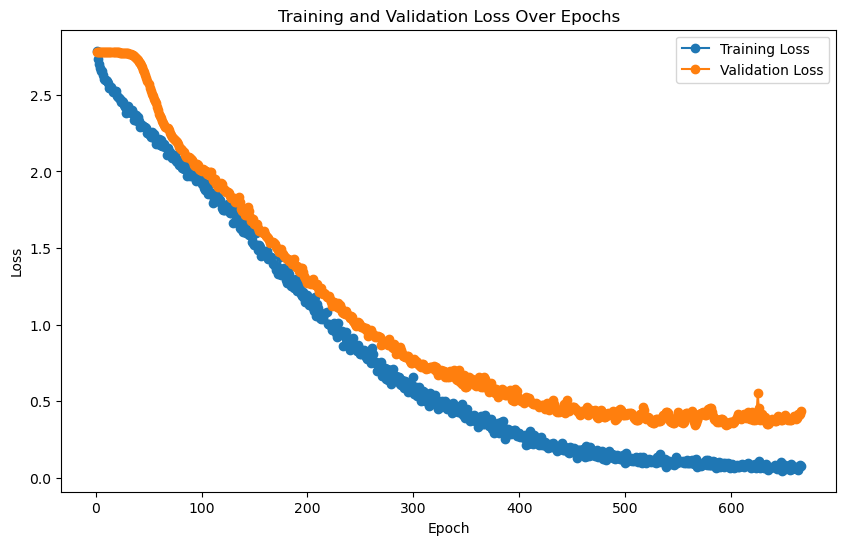

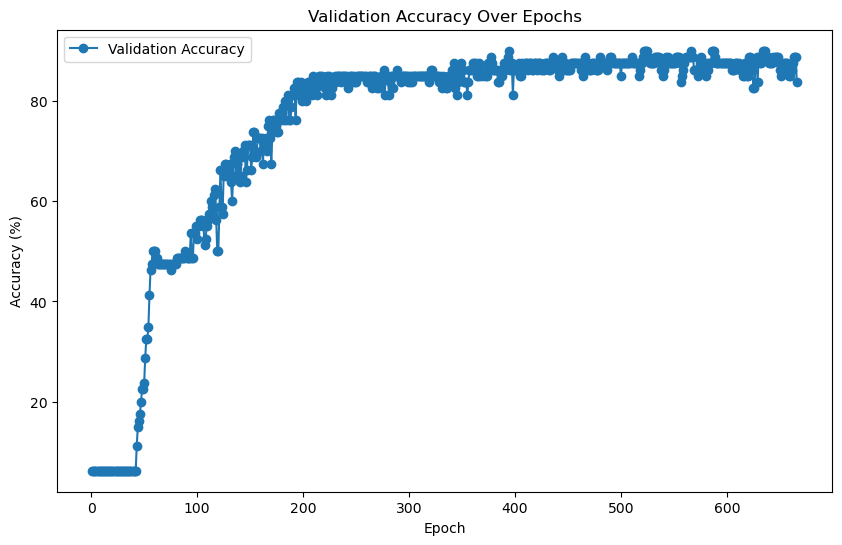


Evaluating on the test set...
    Test Batch [1/211], Loss: 0.3500



Final Test Loss: 0.9973, Test Accuracy: 76.40%
Saved E2E CNN predictions and true labels to model_predictions


In [21]:
#hyperparameters
num_epochs = 1000
learning_rate = 0.0001

#init the model, CrossEntropy loss function, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#getting unique labels from entire dataset (train, validation, test)
all_labels = []
for loader in [train_loader, val_loader, test_loader]:
    for _, labels in loader:
        all_labels.extend(labels.tolist())
all_labels = np.unique(all_labels)

# init model with correct number of classes
num_classes = len(all_labels)
model = hyperspectralCNN(input_channels=window_num_channels, num_classes=num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
#lists to store losses and accuracies
classification_epoch_losses = []
validation_epoch_losses = []
val_accuracies = []

#early stopping parameters
patience = 100
best_val_loss = float('inf')
epochs_without_improvement = 0
best_model_weights = None

#training loop + validation with early stopping
for epoch in range(num_epochs):
    # TRAINING
    model.train()
    running_loss = 0.0
    print(f"\nLOG: Epoch [{epoch + 1}/{num_epochs}] - Training")

    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.to(device).permute(0, 3, 1, 2) 
        target = target.to(device)

        # forward pass
        outputs = model(data)
        loss = criterion(outputs, target)

        # backward pass + optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # accum loss
        running_loss += loss.item()

        if (batch_idx + 1) % 10 == 0:
            print(f"    Training Batch [{batch_idx + 1}/{len(train_loader)}], Loss: {loss.item():.4f}")

    # calc + store average training loss per epoch
    avg_train_loss = running_loss / len(train_loader)
    classification_epoch_losses.append(avg_train_loss)
    print(f"Epoch [{epoch + 1}/{num_epochs}] completed, Average Training Loss: {avg_train_loss:.4f}")

    # VALIDATION
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(val_loader):
            data = data.to(device).permute(0, 3, 1, 2)
            target = target.to(device)
            outputs = model(data)
            loss = criterion(outputs, target)
            val_loss += loss.item()

            # accu calculation
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == target).sum().item()
            total += target.size(0)

            if batch_idx == 0 or (batch_idx + 1) % 10 == 0:
                print(f"    Validation Batch [{batch_idx + 1}/{len(val_loader)}], Loss: {loss.item():.4f}")

    # calc + store validation metrics
    avg_val_loss = val_loss / len(val_loader)
    validation_epoch_losses.append(avg_val_loss)
    val_accuracy = 100 * correct / total
    val_accuracies.append(val_accuracy)
    print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

    # early stopping logic
    if avg_val_loss <= best_val_loss:
        print(f"Validation loss improved from {best_val_loss:.4f} to {avg_val_loss:.4f}. Saving model...")
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0
        best_model_weights = model.state_dict()
    else:
        epochs_without_improvement += 1
        print(f"Validation loss did not improve. Patience: {epochs_without_improvement}/{patience}")

    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered at epoch {epoch + 1}. No improvement for {patience} epochs.")
        break

# loading the best model weights
if best_model_weights is not None:
    print("Loading the best model weights...")
    model.load_state_dict(best_model_weights)

completed_epochs = len(classification_epoch_losses)

# plot for loss and accuracy trends over epochs
plt.figure(figsize=(10,6))
plt.plot(range(1, completed_epochs + 1), classification_epoch_losses, label="Training Loss", marker='o')
plt.plot(range(1, completed_epochs + 1), validation_epoch_losses, label="Validation Loss", marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

plt.figure(figsize=(10,6))
plt.plot(range(1, completed_epochs + 1), val_accuracies, label="Validation Accuracy", marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy Over Epochs')
plt.legend()
plt.show()

#test Set Evaluation
print("\nEvaluating on the test set...")
model.eval()
test_loss = 0.0
correct = 0
total = 0
e2ecnn_test_predictions = []
e2ecnn_test_true_labels = []

with torch.no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        data = data.to(device).permute(0, 3, 1, 2)
        target = target.to(device)
        outputs = model(data)
        loss = criterion(outputs, target)
        test_loss += loss.item()

        #accuracy calc
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == target).sum().item()
        total += target.size(0)

        e2ecnn_test_predictions.extend(predicted.cpu().numpy())
        e2ecnn_test_true_labels.extend(target.cpu().numpy())

        if batch_idx == 0 or (batch_idx + 1) % 1000 == 0:
            print(f"    Test Batch [{batch_idx + 1}/{len(test_loader)}], Loss: {loss.item():.4f}")

#calc + print test metrics
avg_test_loss = test_loss / len(test_loader)
test_accuracy = 100 * correct / total
print(f"\nFinal Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

# Convert to numpy arrays and save
e2e_test_predictions = np.array(e2ecnn_test_predictions)
e2e_test_true_labels = np.array(e2ecnn_test_true_labels)

np.save(os.path.join(predictions_dir, 'e2e_cnn_predictions.npy'), e2e_test_predictions)
np.save(os.path.join(predictions_dir, 'e2e_cnn_true_labels.npy'), e2e_test_true_labels)
print(f"Saved E2E CNN predictions and true labels to {predictions_dir}")

In [22]:
# dir to save the cnn representations
e2ecnn_rep_dir = "e2ecnn_representations"
os.makedirs(e2ecnn_rep_dir, exist_ok=True)

e2ecnn_loaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}


model.eval()

with torch.no_grad():
    for e2ecnn_split_name, e2ecnn_loader in e2ecnn_loaders.items():
        print(f"\nExtracting SCL representations for the {e2ecnn_split_name} dataset...")
        # creating subfolder for the split
        e2ecnn_split_dir = os.path.join(e2ecnn_rep_dir, e2ecnn_split_name)
        os.makedirs(e2ecnn_split_dir, exist_ok=True)

        # processing the data batch-wise
        for e2ecnn_batch_idx, (e2ecnn_vectors, e2ecnn_labels) in enumerate(e2ecnn_loader):
            e2ecnn_vectors = e2ecnn_vectors.permute(0, 3, 1, 2) 
            e2ecnn_vectors = e2ecnn_vectors.to(device).float()
            # computing projections using the trained SCL model
            e2ecnn_projections = model(e2ecnn_vectors)

            # converting projections and labels to np arrays
            e2ecnn_projections_np = e2ecnn_projections.cpu().numpy()
            e2ecnn_labels_np = e2ecnn_labels.cpu().numpy()

            # saving the batch projections and labels
            np.save(os.path.join(e2ecnn_split_dir, f"cnn_encoded_batch_{e2ecnn_batch_idx}.npy"), e2ecnn_projections_np)
            np.save(os.path.join(e2ecnn_split_dir, f"cnn_labels_batch_{e2ecnn_batch_idx}.npy"), e2ecnn_labels_np)

            if (e2ecnn_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {e2ecnn_batch_idx + 1}/{len(e2ecnn_loader)} for {e2ecnn_split_name} dataset.")

        print(f"Completed extraction for the {e2ecnn_split_name} dataset. Representations saved in '{e2ecnn_split_dir}'.")

print("E2E CNN representations extraction complete.")


Extracting SCL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'e2ecnn_representations\train'.

Extracting SCL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'e2ecnn_representations\val'.

Extracting SCL representations for the test dataset...
  Processed batch 10/211 for test dataset.
  Processed batch 20/211 for test dataset.
  Processed batch 30/211 for test dataset.


  Processed batch 40/211 for test dataset.
  Processed batch 50/211 for test dataset.
  Processed batch 60/211 for test dataset.
  Processed batch 70/211 for test dataset.
  Processed batch 80/211 for test dataset.


  Processed batch 90/211 for test dataset.
  Processed batch 100/211 for test dataset.
  Processed batch 110/211 for test dataset.
  Processed batch 120/211 for test dataset.
  Processed batch 130/211 for test dataset.


  Processed batch 140/211 for test dataset.
  Processed batch 150/211 for test dataset.
  Processed batch 160/211 for test dataset.
  Processed batch 170/211 for test dataset.
  Processed batch 180/211 for test dataset.


  Processed batch 190/211 for test dataset.
  Processed batch 200/211 for test dataset.
  Processed batch 210/211 for test dataset.
Completed extraction for the test dataset. Representations saved in 'e2ecnn_representations\test'.
E2E CNN representations extraction complete.


In [23]:
def load_cnn_reps_and_labels(split_dir):
    #gather all the cnn_encoded_batch npy files in sorted order
    cnn_rep_files = sorted(glob.glob(os.path.join(split_dir, "cnn_encoded_batch_*.npy")))

    cnn_all_reps = []
    cnn_all_labels = []

    for cnn_rep_file in cnn_rep_files:
        #deriving label filenames
        cnn_label_file = cnn_rep_file.replace("cnn_encoded_batch_", "cnn_labels_batch_")

        cnn_reps = np.load(cnn_rep_file)
        cnn_labels = np.load(cnn_label_file)

        cnn_all_reps.append(cnn_reps)
        cnn_all_labels.append(cnn_labels)

    #concat along first dim
    cnn_all_reps = np.concatenate(cnn_all_reps, axis = 0)
    cnn_all_labels = np.concatenate(cnn_all_labels, axis = 0)

    return cnn_all_reps, cnn_all_labels

In [24]:
cnn_train_dir = os.path.join("e2ecnn_representations", "train")
cnn_val_dir   = os.path.join("e2ecnn_representations", "val")
cnn_test_dir  = os.path.join("e2ecnn_representations", "test")

cnn_train_reps, cnn_train_labels = load_cnn_reps_and_labels(cnn_train_dir)
cnn_val_reps, cnn_val_labels = load_cnn_reps_and_labels(cnn_val_dir)
cnn_test_reps, cnn_test_labels = load_cnn_reps_and_labels(cnn_test_dir)

## Logistic Regression Model

In [25]:
def load_encoded_data(encoded_dir):
    print(f"LOG: Loading encoded data (representations) from {encoded_dir}...")
    features_list = []
    labels_list = []

    #iter through batches
    for filename in sorted(os.listdir(encoded_dir)):
        if filename.startswith('encoded_batch_') and filename.endswith('.npy'):

            #load the features
            features = np.load(os.path.join(encoded_dir, filename))
            features_flat = features.reshape(features.shape[0], -1) #flatten features for LRM
            features_list.append(features_flat)
        
        elif filename.startswith('labels_batch_') and filename.endswith('.npy'):

            #load labels
            labels = np.load(os.path.join(encoded_dir, filename))
            labels_list.append(labels)

    #concat all batches into a single array
    encoded_features = np.vstack(features_list)
    encoded_labels = np.hstack(labels_list)

    print(f"LOG: Loaded {encoded_features.shape[0]} samples with {encoded_features.shape[1]} features each")
    print(f"LOG: Labels shape: {encoded_labels.shape}")

    return encoded_features, encoded_labels

In [26]:
lrm_encoded_train_dir = os.path.join(encoded_dir, 'train')
lrm_encoded_val_dir = os.path.join(encoded_dir, 'val')
lrm_encoded_test_dir = os.path.join(encoded_dir, 'test')

print("\nLoading training data for LRM...")
lrm_train_features, lrm_train_labels = load_encoded_data(lrm_encoded_train_dir)

print("\nLoading validation data for LRM...")
lrm_val_features, lrm_val_labels = load_encoded_data(lrm_encoded_val_dir)

print("\nLoading test data for LRM...")
lrm_test_features, lrm_test_labels = load_encoded_data(lrm_encoded_test_dir)

#verify shapes
print(f"\nLOG: Training features shape: {lrm_train_features.shape}, Training labels shape: {lrm_train_labels.shape}")
print(f"LOG: Validation features shape: {lrm_val_features.shape}, Validation labels shape: {lrm_val_labels.shape}")
print(f"LOG: Test features shape: {lrm_test_features.shape}, Test labels shape: {lrm_test_labels.shape}")

print("\nLOG: Training Logistic Regression model...")
logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight = 'balanced')
logistic_clf.fit(lrm_train_features, lrm_train_labels)
print("LOG: Logistic Regression training complete.")

#eval on Validation Set
print("\nLOG: Evaluating on the validation set...")
lrm_val_predictions = logistic_clf.predict(lrm_val_features)
lrm_val_accuracy = accuracy_score(lrm_val_labels, lrm_val_predictions)
print(f"Validation Accuracy: {lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(lrm_val_labels, lrm_val_predictions))

#eval on Test Set
print("\nLOG: Evaluating on the test set...")
lrm_test_predictions = logistic_clf.predict(lrm_test_features)
lrm_test_accuracy = accuracy_score(lrm_test_labels, lrm_test_predictions)
print(f"Test Accuracy: {lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(lrm_test_labels, lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'cae_lrm_predictions.npy'), lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'cae_lrm_true_labels.npy'), lrm_test_labels)
print(f"Saved CAE+LRM predictions and true labels to {predictions_dir}")



Loading training data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 80 samples with 64 features each
LOG: Labels shape: (80,)

Loading validation data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 80 samples with 64 features each
LOG: Labels shape: (80,)

Loading test data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\test...


LOG: Loaded 53969 samples with 64 features each
LOG: Labels shape: (53969,)

LOG: Training features shape: (80, 64), Training labels shape: (80,)
LOG: Validation features shape: (80, 64), Validation labels shape: (80,)
LOG: Test features shape: (53969, 64), Test labels shape: (53969,)

LOG: Training Logistic Regression model...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 90.00%

Validation Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         5
           3       1.00      1.00      1.00         5
           4       1.00      1.00      1.00         5
           5       1.00      1.00      1.00         5
           6       0.67      0.80      0.73         5
           7       0.71      1.00      0.83         5
           8       0.83      1.00

### Classifying CAE Embeddings with MLP

In [27]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, num_classes)
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules(): 
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [28]:
cae_mlp_train_dir = os.path.join("encoded_representations", "train")
cae_mlp_val_dir   = os.path.join("encoded_representations", "val")
cae_mlp_test_dir  = os.path.join("encoded_representations", "test")

cae_mlp_train_reps, cae_mlp_train_labels = load_encoded_data(cae_mlp_train_dir)
cae_mlp_val_reps, cae_mlp_val_labels = load_encoded_data(cae_mlp_val_dir)
cae_mlp_test_reps, cae_mlp_test_labels = load_encoded_data(cae_mlp_test_dir)

print("Train reps shape:",cae_mlp_train_reps.shape)
print("Train labels shape:", cae_mlp_train_labels.shape)

print("Val reps shape:", cae_mlp_val_reps.shape)
print("Val labels shape:", cae_mlp_val_labels.shape)

print("Test reps shape:", cae_mlp_test_reps.shape)
print("Test labels shape:", cae_mlp_test_labels.shape)

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 80 samples with 64 features each
LOG: Labels shape: (80,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 80 samples with 64 features each
LOG: Labels shape: (80,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 53969 samples with 64 features each
LOG: Labels shape: (53969,)
Train reps shape: (80, 64)
Train labels shape: (80,)
Val reps shape: (80, 64)
Val labels shape: (80,)
Test reps shape: (53969, 64)
Test labels shape: (53969,)


In [29]:
#converting arrays to torch tensors
cae_mlp_train_embeddings_torch = torch.tensor(cae_mlp_train_reps, dtype=torch.float32)
cae_mlp_train_labels_torch = torch.tensor(cae_mlp_train_labels, dtype=torch.long)

cae_mlp_val_embeddings_torch = torch.tensor(cae_mlp_val_reps, dtype=torch.float32)
cae_mlp_val_labels_torch = torch.tensor(cae_mlp_val_labels, dtype=torch.long)

cae_mlp_test_embeddings_torch = torch.tensor(cae_mlp_test_reps, dtype=torch.float32)
cae_mlp_test_labels_torch = torch.tensor(cae_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
cae_mlp_train_dataset = TensorDataset(cae_mlp_train_embeddings_torch, cae_mlp_train_labels_torch)
cae_mlp_val_dataset = TensorDataset(cae_mlp_val_embeddings_torch, cae_mlp_val_labels_torch)
cae_mlp_test_dataset = TensorDataset(cae_mlp_test_embeddings_torch, cae_mlp_test_labels_torch)

cae_mlp_batch_size = 64
cae_mlp_train_loader = DataLoader(cae_mlp_train_dataset, batch_size=cae_mlp_batch_size, shuffle=True)
cae_mlp_val_loader = DataLoader(cae_mlp_val_dataset, batch_size=cae_mlp_batch_size, shuffle=False)
cae_mlp_test_loader = DataLoader(cae_mlp_test_dataset, batch_size=cae_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.9483  |  Val Loss: 2.7714
Validation loss improved from inf to 2.7714.


[Epoch 2/1000] Train Loss: 2.7523  |  Val Loss: 2.6606
Validation loss improved from 2.7714 to 2.6606.
[Epoch 3/1000] Train Loss: 2.6394  |  Val Loss: 2.6016
Validation loss improved from 2.6606 to 2.6016.
[Epoch 4/1000] Train Loss: 2.5722  |  Val Loss: 2.5502
Validation loss improved from 2.6016 to 2.5502.
[Epoch 5/1000] Train Loss: 2.5141  |  Val Loss: 2.4967
Validation loss improved from 2.5502 to 2.4967.
[Epoch 6/1000] Train Loss: 2.4545  |  Val Loss: 2.4377
Validation loss improved from 2.4967 to 2.4377.
[Epoch 7/1000] Train Loss: 2.3961  |  Val Loss: 2.3801
Validation loss improved from 2.4377 to 2.3801.
[Epoch 8/1000] Train Loss: 2.3363  |  Val Loss: 2.3220
Validation loss improved from 2.3801 to 2.3220.
[Epoch 9/1000] Train Loss: 2.2773  |  Val Loss: 2.2720
Validation loss improved from 2.3220 to 2.2720.
[Epoch 10/1000] Train Loss: 2.2310  |  Val Loss: 2.2316
Validation loss improved from 2.2720 to 2.2316.
[Epoch 11/1000] Train Loss: 2.1890  |  Val Loss: 2.2003
Validation loss 

[Epoch 27/1000] Train Loss: 1.5196  |  Val Loss: 1.6093
Validation loss improved from 1.6455 to 1.6093.
[Epoch 28/1000] Train Loss: 1.4733  |  Val Loss: 1.5738
Validation loss improved from 1.6093 to 1.5738.
[Epoch 29/1000] Train Loss: 1.4297  |  Val Loss: 1.5422
Validation loss improved from 1.5738 to 1.5422.
[Epoch 30/1000] Train Loss: 1.3883  |  Val Loss: 1.5214
Validation loss improved from 1.5422 to 1.5214.
[Epoch 31/1000] Train Loss: 1.3498  |  Val Loss: 1.5170
Validation loss improved from 1.5214 to 1.5170.
[Epoch 32/1000] Train Loss: 1.3268  |  Val Loss: 1.5157
Validation loss improved from 1.5170 to 1.5157.
[Epoch 33/1000] Train Loss: 1.3180  |  Val Loss: 1.4818
Validation loss improved from 1.5157 to 1.4818.
[Epoch 34/1000] Train Loss: 1.2710  |  Val Loss: 1.4131
Validation loss improved from 1.4818 to 1.4131.
[Epoch 35/1000] Train Loss: 1.2140  |  Val Loss: 1.3622
Validation loss improved from 1.4131 to 1.3622.
[Epoch 36/1000] Train Loss: 1.1838  |  Val Loss: 1.3353
Validati

[Epoch 42/1000] Train Loss: 1.0341  |  Val Loss: 1.2245
Validation loss improved from 1.2576 to 1.2245.
[Epoch 43/1000] Train Loss: 1.0081  |  Val Loss: 1.1935
Validation loss improved from 1.2245 to 1.1935.
[Epoch 44/1000] Train Loss: 0.9866  |  Val Loss: 1.1669
Validation loss improved from 1.1935 to 1.1669.
[Epoch 45/1000] Train Loss: 0.9606  |  Val Loss: 1.1529
Validation loss improved from 1.1669 to 1.1529.
[Epoch 46/1000] Train Loss: 0.9405  |  Val Loss: 1.1503
Validation loss improved from 1.1529 to 1.1503.
[Epoch 47/1000] Train Loss: 0.9286  |  Val Loss: 1.1473
Validation loss improved from 1.1503 to 1.1473.
[Epoch 48/1000] Train Loss: 0.9106  |  Val Loss: 1.1417
Validation loss improved from 1.1473 to 1.1417.
[Epoch 49/1000] Train Loss: 0.8894  |  Val Loss: 1.1260
Validation loss improved from 1.1417 to 1.1260.
[Epoch 50/1000] Train Loss: 0.8684  |  Val Loss: 1.1168
Validation loss improved from 1.1260 to 1.1168.
[Epoch 51/1000] Train Loss: 0.8639  |  Val Loss: 1.1082
Validati

[Epoch 69/1000] Train Loss: 0.6270  |  Val Loss: 0.9085
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 70/1000] Train Loss: 0.6101  |  Val Loss: 0.9173
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 71/1000] Train Loss: 0.5930  |  Val Loss: 0.9246
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 72/1000] Train Loss: 0.5843  |  Val Loss: 0.9081
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 73/1000] Train Loss: 0.5703  |  Val Loss: 0.8829
Validation loss improved from 0.9050 to 0.8829.
[Epoch 74/1000] Train Loss: 0.5576  |  Val Loss: 0.8716
Validation loss improved from 0.8829 to 0.8716.
[Epoch 75/1000] Train Loss: 0.5500  |  Val Loss: 0.8688
Validation loss improved from 0.8716 to 0.8688.
[Epoch 76/1000] Train Loss: 0.5488  |  Val Loss: 0.8666
Validation loss improved from 0.8688 to 0.8666.
[Epoch 77/1000] Train Loss: 0.5421  |  Val Loss: 0.8560
Validation loss improved from 0.8666 to 0.8560.
[Epoch 78/1000] Train Loss: 0.5275  |  V

[Epoch 83/1000] Train Loss: 0.4775  |  Val Loss: 0.8455
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 84/1000] Train Loss: 0.4815  |  Val Loss: 0.8538
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 85/1000] Train Loss: 0.4901  |  Val Loss: 0.8490
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 86/1000] Train Loss: 0.4800  |  Val Loss: 0.8272
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 87/1000] Train Loss: 0.4494  |  Val Loss: 0.8413
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 88/1000] Train Loss: 0.4520  |  Val Loss: 0.8680
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 89/1000] Train Loss: 0.4571  |  Val Loss: 0.8695
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 90/1000] Train Loss: 0.4514  |  Val Loss: 0.8280
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 91/1000] Train Loss: 0.4339  |  Val Loss: 0.7864
Validation loss improved from 0.8208 to 0.7864.
[Epoch 92/1000] 

[Epoch 107/1000] Train Loss: 0.3311  |  Val Loss: 0.7618
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 108/1000] Train Loss: 0.3312  |  Val Loss: 0.7723
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 109/1000] Train Loss: 0.3336  |  Val Loss: 0.7646
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 110/1000] Train Loss: 0.3242  |  Val Loss: 0.7576
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 111/1000] Train Loss: 0.3107  |  Val Loss: 0.7471
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 112/1000] Train Loss: 0.3045  |  Val Loss: 0.7403
Validation loss improved from 0.7454 to 0.7403.
[Epoch 113/1000] Train Loss: 0.3025  |  Val Loss: 0.7401
Validation loss improved from 0.7403 to 0.7401.
[Epoch 114/1000] Train Loss: 0.2976  |  Val Loss: 0.7578
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 115/1000] Train Loss: 0.3048  |  Val Loss: 0.7636
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 116/10

[Epoch 122/1000] Train Loss: 0.2659  |  Val Loss: 0.7290
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 123/1000] Train Loss: 0.2639  |  Val Loss: 0.7625
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 124/1000] Train Loss: 0.2812  |  Val Loss: 0.7806
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 125/1000] Train Loss: 0.2792  |  Val Loss: 0.7518
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 126/1000] Train Loss: 0.2690  |  Val Loss: 0.7394
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 127/1000] Train Loss: 0.2696  |  Val Loss: 0.7230
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 128/1000] Train Loss: 0.2615  |  Val Loss: 0.7134
Validation loss improved from 0.7156 to 0.7134.
[Epoch 129/1000] Train Loss: 0.2475  |  Val Loss: 0.7337
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 130/1000] Train Loss: 0.2387  |  Val Loss: 0.7524
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 

[Epoch 149/1000] Train Loss: 0.2051  |  Val Loss: 0.7286
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 150/1000] Train Loss: 0.1943  |  Val Loss: 0.7744
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 151/1000] Train Loss: 0.1970  |  Val Loss: 0.7932
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 152/1000] Train Loss: 0.2014  |  Val Loss: 0.7581
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 153/1000] Train Loss: 0.1886  |  Val Loss: 0.7060
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 154/1000] Train Loss: 0.1764  |  Val Loss: 0.6828
Validation loss improved from 0.6899 to 0.6828.
[Epoch 155/1000] Train Loss: 0.1779  |  Val Loss: 0.6783
Validation loss improved from 0.6828 to 0.6783.
[Epoch 156/1000] Train Loss: 0.1895  |  Val Loss: 0.6849
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 157/1000] Train Loss: 0.1928  |  Val Loss: 0.6864
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 1

[Epoch 164/1000] Train Loss: 0.1585  |  Val Loss: 0.6838
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 165/1000] Train Loss: 0.1563  |  Val Loss: 0.7007
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 166/1000] Train Loss: 0.1675  |  Val Loss: 0.7094
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 167/1000] Train Loss: 0.1669  |  Val Loss: 0.7033
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 168/1000] Train Loss: 0.1579  |  Val Loss: 0.7090
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 169/1000] Train Loss: 0.1518  |  Val Loss: 0.7136
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 170/1000] Train Loss: 0.1483  |  Val Loss: 0.7137
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 171/1000] Train Loss: 0.1476  |  Val Loss: 0.7246
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 172/1000] Train Loss: 0.1490  |  Val Loss: 0.7330
!! Validation loss did NOT improve !! Patience: 

[Epoch 190/1000] Train Loss: 0.1284  |  Val Loss: 0.7578
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 191/1000] Train Loss: 0.1301  |  Val Loss: 0.7753
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 192/1000] Train Loss: 0.1314  |  Val Loss: 0.7544
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 193/1000] Train Loss: 0.1226  |  Val Loss: 0.7147
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 194/1000] Train Loss: 0.1188  |  Val Loss: 0.6821
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 195/1000] Train Loss: 0.1293  |  Val Loss: 0.6749
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 196/1000] Train Loss: 0.1249  |  Val Loss: 0.7050
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 197/1000] Train Loss: 0.1146  |  Val Loss: 0.7295
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 198/1000] Train Loss: 0.1177  |  Val Loss: 0.7277
!! Validation loss did NOT improve !! Patience: 11/100

[Epoch 205/1000] Train Loss: 0.1043  |  Val Loss: 0.7051
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 206/1000] Train Loss: 0.1098  |  Val Loss: 0.7042
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 207/1000] Train Loss: 0.1129  |  Val Loss: 0.7055
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 208/1000] Train Loss: 0.1061  |  Val Loss: 0.7186
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 209/1000] Train Loss: 0.1003  |  Val Loss: 0.7403
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 210/1000] Train Loss: 0.1036  |  Val Loss: 0.7614
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 211/1000] Train Loss: 0.1125  |  Val Loss: 0.7591
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 212/1000] Train Loss: 0.1112  |  Val Loss: 0.7300
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 213/1000] Train Loss: 0.1033  |  Val Loss: 0.7073
!! Validation loss did NOT improve !! Patience:

[Epoch 238/1000] Train Loss: 0.0994  |  Val Loss: 0.7023
!! Validation loss did NOT improve !! Patience: 51/100
[Epoch 239/1000] Train Loss: 0.0934  |  Val Loss: 0.7141
!! Validation loss did NOT improve !! Patience: 52/100
[Epoch 240/1000] Train Loss: 0.0843  |  Val Loss: 0.7275
!! Validation loss did NOT improve !! Patience: 53/100
[Epoch 241/1000] Train Loss: 0.0837  |  Val Loss: 0.7306
!! Validation loss did NOT improve !! Patience: 54/100
[Epoch 242/1000] Train Loss: 0.0903  |  Val Loss: 0.7455
!! Validation loss did NOT improve !! Patience: 55/100
[Epoch 243/1000] Train Loss: 0.1003  |  Val Loss: 0.7516
!! Validation loss did NOT improve !! Patience: 56/100
[Epoch 244/1000] Train Loss: 0.0964  |  Val Loss: 0.7468
!! Validation loss did NOT improve !! Patience: 57/100
[Epoch 245/1000] Train Loss: 0.0834  |  Val Loss: 0.7479
!! Validation loss did NOT improve !! Patience: 58/100
[Epoch 246/1000] Train Loss: 0.0832  |  Val Loss: 0.7458
!! Validation loss did NOT improve !! Patience:

[Epoch 250/1000] Train Loss: 0.0837  |  Val Loss: 0.7386
!! Validation loss did NOT improve !! Patience: 63/100
[Epoch 251/1000] Train Loss: 0.0815  |  Val Loss: 0.7579
!! Validation loss did NOT improve !! Patience: 64/100
[Epoch 252/1000] Train Loss: 0.0799  |  Val Loss: 0.7746
!! Validation loss did NOT improve !! Patience: 65/100
[Epoch 253/1000] Train Loss: 0.0822  |  Val Loss: 0.7669
!! Validation loss did NOT improve !! Patience: 66/100
[Epoch 254/1000] Train Loss: 0.0715  |  Val Loss: 0.7338
!! Validation loss did NOT improve !! Patience: 67/100
[Epoch 255/1000] Train Loss: 0.0734  |  Val Loss: 0.7104
!! Validation loss did NOT improve !! Patience: 68/100
[Epoch 256/1000] Train Loss: 0.0833  |  Val Loss: 0.7050
!! Validation loss did NOT improve !! Patience: 69/100
[Epoch 257/1000] Train Loss: 0.0846  |  Val Loss: 0.7261
!! Validation loss did NOT improve !! Patience: 70/100
[Epoch 258/1000] Train Loss: 0.0795  |  Val Loss: 0.7521
!! Validation loss did NOT improve !! Patience:

[Epoch 280/1000] Train Loss: 0.0611  |  Val Loss: 0.7507
!! Validation loss did NOT improve !! Patience: 93/100
[Epoch 281/1000] Train Loss: 0.0608  |  Val Loss: 0.7589
!! Validation loss did NOT improve !! Patience: 94/100
[Epoch 282/1000] Train Loss: 0.0696  |  Val Loss: 0.7469
!! Validation loss did NOT improve !! Patience: 95/100
[Epoch 283/1000] Train Loss: 0.0730  |  Val Loss: 0.7275
!! Validation loss did NOT improve !! Patience: 96/100
[Epoch 284/1000] Train Loss: 0.0685  |  Val Loss: 0.7142
!! Validation loss did NOT improve !! Patience: 97/100
[Epoch 285/1000] Train Loss: 0.0616  |  Val Loss: 0.7165
!! Validation loss did NOT improve !! Patience: 98/100
[Epoch 286/1000] Train Loss: 0.0575  |  Val Loss: 0.7404
!! Validation loss did NOT improve !! Patience: 99/100
[Epoch 287/1000] Train Loss: 0.0627  |  Val Loss: 0.7446
!! Validation loss did NOT improve !! Patience: 100/100
!! Early stopping triggered at epoch 287 !!
No improvement for 100 epochs.


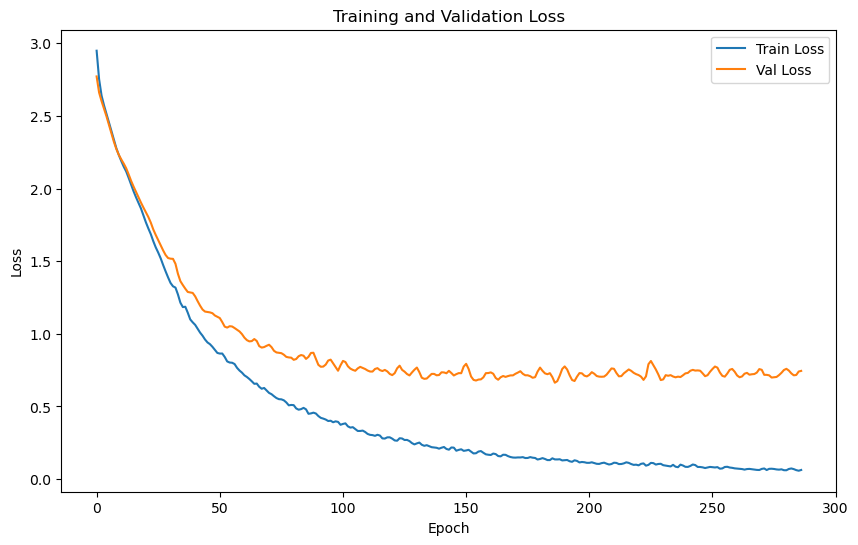

In [30]:
cae_mlp_input_dim = cae_mlp_train_reps.shape[1]
cae_mlp_num_classes = len(torch.unique(cae_mlp_train_labels_torch))
cae_mlp_model = MLPClassifier(cae_mlp_input_dim, cae_mlp_num_classes).to(device)

cae_mlp_criterion = nn.CrossEntropyLoss()
cae_mlp_optimizer = optim.Adam(cae_mlp_model.parameters(), lr=1e-3)

cae_mlp_num_epochs = 1000
cae_mlp_patience = 100

cae_mlp_train_losses = []
cae_mlp_val_losses = []

cae_mlp_best_val_loss = float('inf')
cae_mlp_epochs_without_improvement = 0

for cae_mlp_epoch in range(cae_mlp_num_epochs):
    # Training
    cae_mlp_model.train()
    cae_mlp_train_running_loss = 0.0
    
    for cae_mlp_embeddings_batch, cae_mlp_labels_batch in cae_mlp_train_loader:
        cae_mlp_embeddings_batch = cae_mlp_embeddings_batch.to(device)
        cae_mlp_labels_batch = cae_mlp_labels_batch.to(device)
        
        cae_mlp_optimizer.zero_grad()
        
        # Forward
        cae_mlp_outputs = cae_mlp_model(cae_mlp_embeddings_batch)
        cae_mlp_loss = cae_mlp_criterion(cae_mlp_outputs, cae_mlp_labels_batch)
        
        # Backward & Update
        cae_mlp_loss.backward()
        cae_mlp_optimizer.step()
        
        cae_mlp_train_running_loss += cae_mlp_loss.item() * cae_mlp_embeddings_batch.size(0)
    
    cae_mlp_epoch_train_loss = cae_mlp_train_running_loss / len(cae_mlp_train_loader.dataset)
    cae_mlp_train_losses.append(cae_mlp_epoch_train_loss)


    # Validation

    cae_mlp_model.eval()
    cae_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for cae_mlp_val_embeddings_batch, cae_mlp_val_labels_batch in cae_mlp_val_loader:
            cae_mlp_val_embeddings_batch = cae_mlp_val_embeddings_batch.to(device)
            cae_mlp_val_labels_batch = cae_mlp_val_labels_batch.to(device)

            cae_mlp_val_outputs = cae_mlp_model(cae_mlp_val_embeddings_batch)
            cae_mlp_val_loss = cae_mlp_criterion(cae_mlp_val_outputs, cae_mlp_val_labels_batch)

            cae_mlp_val_running_loss += cae_mlp_val_loss.item() * cae_mlp_val_embeddings_batch.size(0)

    cae_mlp_epoch_val_loss = cae_mlp_val_running_loss / len(cae_mlp_val_loader.dataset)
    cae_mlp_val_losses.append(cae_mlp_epoch_val_loss)

    print(f"[Epoch {cae_mlp_epoch+1}/{cae_mlp_num_epochs}] "
          f"Train Loss: {cae_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {cae_mlp_epoch_val_loss:.4f}")

    # Early stopping

    if cae_mlp_epoch_val_loss < cae_mlp_best_val_loss:
        # improvement, reset patience
        print(f"Validation loss improved from {cae_mlp_best_val_loss:.4f} to {cae_mlp_epoch_val_loss:.4f}.")
        cae_mlp_best_val_loss = cae_mlp_epoch_val_loss
        cae_mlp_epochs_without_improvement = 0

    else:
        # no improvement
        cae_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {cae_mlp_epochs_without_improvement}/{cae_mlp_patience}")
        
        if cae_mlp_epochs_without_improvement >= cae_mlp_patience:
            print(f"!! Early stopping triggered at epoch {cae_mlp_epoch+1} !!\n"
                  f"No improvement for {cae_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(cae_mlp_train_losses, label='Train Loss')
plt.plot(cae_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved CAE+MLP predictions and true labels to model_predictions
Test Loss: 1.0399 | Test Accuracy: 77.23%


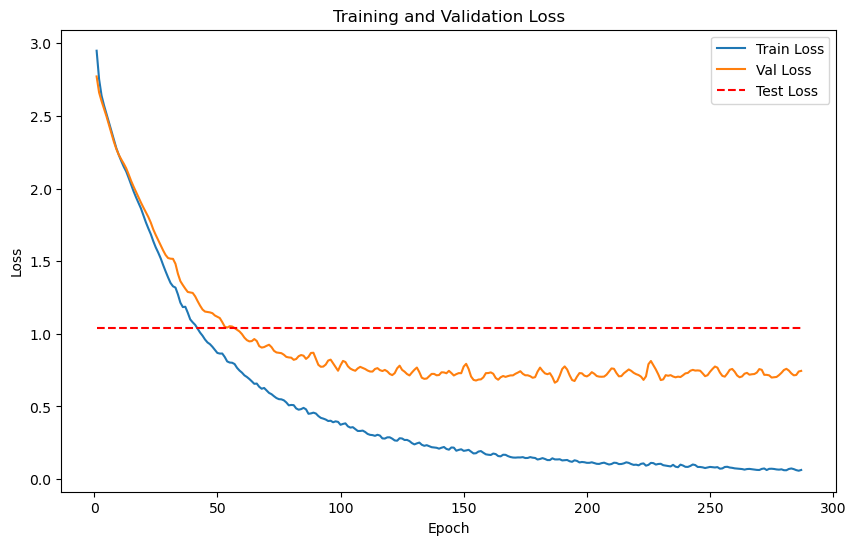

In [31]:
cae_mlp_model.eval()

cae_mlp_test_running_loss = 0.0
cae_mlp_test_correct = 0
cae_mlp_all_predictions = []
cae_mlp_all_true_labels = []

with torch.no_grad():
    for cae_mlp_test_embeddings_batch, cae_mlp_test_labels_batch in cae_mlp_test_loader:
        cae_mlp_test_embeddings_batch = cae_mlp_test_embeddings_batch.to(device)
        cae_mlp_test_labels_batch = cae_mlp_test_labels_batch.to(device)

        cae_mlp_test_outputs = cae_mlp_model(cae_mlp_test_embeddings_batch)
        
        cae_mlp_test_loss_batch = cae_mlp_criterion(cae_mlp_test_outputs, cae_mlp_test_labels_batch)
        cae_mlp_test_running_loss += cae_mlp_test_loss_batch.item() * cae_mlp_test_embeddings_batch.size(0)

        _, cae_mlp_test_predicted = torch.max(cae_mlp_test_outputs, dim=1)
        cae_mlp_test_correct += (cae_mlp_test_predicted == cae_mlp_test_labels_batch).sum().item()

        #saving predictions for conf matrix
        cae_mlp_all_predictions.extend(cae_mlp_test_predicted.cpu().numpy())
        cae_mlp_all_true_labels.extend(cae_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'cae_mlp_predictions.npy'), np.array(cae_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'cae_mlp_true_labels.npy'), np.array(cae_mlp_all_true_labels))
print(f"Saved CAE+MLP predictions and true labels to {predictions_dir}")

cae_mlp_epoch_test_loss = cae_mlp_test_running_loss / len(cae_mlp_test_loader.dataset)
cae_mlp_test_accuracy = cae_mlp_test_correct / len(cae_mlp_test_loader.dataset)

cae_mlp_test_accuracy_pct = cae_mlp_test_accuracy * 100.0

print(f"Test Loss: {cae_mlp_epoch_test_loss:.4f} | Test Accuracy: {cae_mlp_test_accuracy_pct:.2f}%")

cae_mlp_num_epochs_run = len(cae_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         cae_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         cae_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         [cae_mlp_epoch_test_loss]*cae_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

## Typical SCL with Cosine Similarity (Supervised Contrastive Loss)

In [32]:
tscl_encoded_train_dir = os.path.join(encoded_dir, 'train')
tscl_encoded_val_dir = os.path.join(encoded_dir, 'val')
tscl_encoded_test_dir = os.path.join(encoded_dir, 'test')

tscl_train_embeddings, tscl_train_labels = load_encoded_data(tscl_encoded_train_dir)
tscl_val_embeddings, tscl_val_labels = load_encoded_data(tscl_encoded_val_dir)
tscl_test_embeddings, tscl_test_labels = load_encoded_data(tscl_encoded_test_dir)

#shape verification
print(f"\n\nTrain embeddings shape: {tscl_train_embeddings.shape}, \nTrain labels shape: {tscl_train_labels.shape}")
print(f"\n\nVal embeddings shape: {tscl_val_embeddings.shape}, \nVal labels shape: {tscl_val_labels.shape}")
print(f"\n\nTest embeddings shape: {tscl_test_embeddings.shape}, \nTest labels shape: {tscl_test_labels.shape}")

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 80 samples with 64 features each
LOG: Labels shape: (80,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 80 samples with 64 features each
LOG: Labels shape: (80,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 53969 samples with 64 features each
LOG: Labels shape: (53969,)


Train embeddings shape: (80, 64), 
Train labels shape: (80,)


Val embeddings shape: (80, 64), 
Val labels shape: (80,)


Test embeddings shape: (53969, 64), 
Test labels shape: (53969,)


In [33]:
#flattening embeddings to (num_samples, 64)
tscl_train_embeddings = tscl_train_embeddings.reshape(tscl_train_embeddings.shape[0], -1)
tscl_val_embeddings = tscl_val_embeddings.reshape(tscl_val_embeddings.shape[0], -1)
tscl_test_embeddings = tscl_test_embeddings.reshape(tscl_test_embeddings.shape[0], -1)

#compute mean and std from training set
tscl_train_mean = np.mean(tscl_train_embeddings, axis=0)
tscl_train_std = np.std(tscl_train_embeddings, axis=0)

#normalize all datasets from above training mean and std
tscl_train_embeddings = (tscl_train_embeddings - tscl_train_mean) / tscl_train_std
tscl_val_embeddings = (tscl_val_embeddings - tscl_train_mean) / tscl_train_std
tscl_test_embeddings = (tscl_test_embeddings - tscl_train_mean) / tscl_train_std

tscl_train_dataset = TensorDataset(torch.tensor(tscl_train_embeddings, dtype=torch.float32), torch.tensor(tscl_train_labels, dtype=torch.long))
tscl_val_dataset = TensorDataset(torch.tensor(tscl_val_embeddings, dtype=torch.float32), torch.tensor(tscl_val_labels, dtype=torch.long))
tscl_test_dataset = TensorDataset(torch.tensor(tscl_test_embeddings, dtype=torch.float32), torch.tensor(tscl_test_labels, dtype=torch.long))

tscl_m = 20
tscl_num_classes = len(np.unique(tscl_train_labels))

# Calculate theoretical required batch size
tscl_required_batch_size = tscl_m * tscl_num_classes

# Ensure batch size doesn't exceed training set size
if tscl_required_batch_size > len(tscl_train_dataset):
    #case 1: Not enough samples - reduce m proportionally
    tscl_max_possible_m = len(tscl_train_dataset) // tscl_num_classes
    tscl_m = max(1, tscl_max_possible_m)  # Ensure m >= 1
    tscl_batch_size_train = tscl_m * tscl_num_classes
else:
    #case 2: Use full batch size
    tscl_batch_size_train = tscl_required_batch_size

tscl_sampler = MPerClassSampler(labels = tscl_train_labels, m = tscl_m, batch_size = tscl_batch_size_train, length_before_new_iter=len(tscl_train_dataset))
tscl_train_loader = DataLoader(tscl_train_dataset, batch_size=tscl_batch_size_train, sampler=tscl_sampler)

#creating dataloaders for scl
tscl_dataloader_bs = 256
tscl_val_loader = DataLoader(tscl_val_dataset, batch_size=tscl_dataloader_bs, shuffle=False)
tscl_test_loader = DataLoader(tscl_test_dataset, batch_size=tscl_dataloader_bs, shuffle=False)

for tscl_X_batch, tscl_y_batch in tscl_train_loader:
    tscl_unique, tscl_counts = np.unique(y_batch.numpy(), return_counts=True)
    print("Class distribution in batch:", dict(zip(tscl_unique, tscl_counts)))
    print(f"Training batch size: {tscl_batch_size_train}")
    break

Class distribution in batch: {0: 5, 1: 5, 2: 5, 3: 5, 4: 5, 5: 5, 6: 5, 7: 5, 8: 5, 9: 5, 10: 5, 11: 5, 12: 5, 13: 5, 14: 5, 15: 5}
Training batch size: 80


In [34]:
class SupConLoss(nn.Module):
    def __init__(self, temperature = 0.07):
        super(SupConLoss, self).__init__()
        self.temperature = temperature

    def forward(self, features, labels):
        #normalize feat vectors
        features = F.normalize(features, p=2, dim = 1)

        #compute cosine simi matrix
        similarity_matrix = torch.matmul(features, features.T) / self.temperature

        #create a mask for +ve pairs - i.e. same class
        labels = labels.unsqueeze(1)
        mask = torch.eq(labels, labels.T).float().to(features.device)

        #loss computation
        exp_sim = torch.exp(similarity_matrix)
        log_prob = similarity_matrix - torch.log(exp_sim.sum(dim = 1, keepdim=True))

        #mask out diagonal - i.e. self similarity
        mask_self = torch.eye(mask.shape[0], dtype = torch.bool).to(features.device)
        mask = mask * (~mask_self)

        #handling edge cases when there is no +ve pair
        mask_pos_pairs = mask.sum(dim=1)
        mask_pos_pairs = torch.where(mask_pos_pairs < 1e-6, 1, mask_pos_pairs)

        loss = -(mask * log_prob).sum(dim=1) / mask_pos_pairs

        return loss.mean() 

In [35]:
class SupConNet(nn.Module):
    def __init__(self, feature_dim=128):
        super(SupConNet, self).__init__()

        self.projection_head = nn.Sequential(
            nn.Linear(64, 128), #expects input of shape (batch_size, 64)
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, feature_dim)
        )

    def forward(self, x):
        #flattening input tensor
        #x = x.view(x.size(0), -1)  #reshaping -> (batch_size, channels * height * width)
        projections = self.projection_head(x)
        return projections


LOG: Epoch [1/2000] - Training
    Batch [1/1], Train Loss: 8.2828
Epoch [1/2000], Avg Train Loss: 8.2828
Epoch [1/2000], Avg Val Loss: 3.4842
Validation loss improved from inf to 3.4842. Saving model...

LOG: Epoch [2/2000] - Training
    Batch [1/1], Train Loss: 7.9161
Epoch [2/2000], Avg Train Loss: 7.9161
Epoch [2/2000], Avg Val Loss: 3.4692
Validation loss improved from 3.4842 to 3.4692. Saving model...

LOG: Epoch [3/2000] - Training
    Batch [1/1], Train Loss: 8.1266
Epoch [3/2000], Avg Train Loss: 8.1266
Epoch [3/2000], Avg Val Loss: 3.4545
Validation loss improved from 3.4692 to 3.4545. Saving model...

LOG: Epoch [4/2000] - Training


    Batch [1/1], Train Loss: 8.2331
Epoch [4/2000], Avg Train Loss: 8.2331
Epoch [4/2000], Avg Val Loss: 3.4402
Validation loss improved from 3.4545 to 3.4402. Saving model...

LOG: Epoch [5/2000] - Training
    Batch [1/1], Train Loss: 7.7959
Epoch [5/2000], Avg Train Loss: 7.7959
Epoch [5/2000], Avg Val Loss: 3.4261
Validation loss improved from 3.4402 to 3.4261. Saving model...

LOG: Epoch [6/2000] - Training
    Batch [1/1], Train Loss: 7.6525
Epoch [6/2000], Avg Train Loss: 7.6525
Epoch [6/2000], Avg Val Loss: 3.4126
Validation loss improved from 3.4261 to 3.4126. Saving model...

LOG: Epoch [7/2000] - Training
    Batch [1/1], Train Loss: 7.6519
Epoch [7/2000], Avg Train Loss: 7.6519
Epoch [7/2000], Avg Val Loss: 3.3995
Validation loss improved from 3.4126 to 3.3995. Saving model...

LOG: Epoch [8/2000] - Training
    Batch [1/1], Train Loss: 7.4144
Epoch [8/2000], Avg Train Loss: 7.4144
Epoch [8/2000], Avg Val Loss: 3.3868
Validation loss improved from 3.3995 to 3.3868. Saving m

    Batch [1/1], Train Loss: 6.7670
Epoch [23/2000], Avg Train Loss: 6.7670
Epoch [23/2000], Avg Val Loss: 3.2263
Validation loss improved from 3.2353 to 3.2263. Saving model...

LOG: Epoch [24/2000] - Training
    Batch [1/1], Train Loss: 6.5118
Epoch [24/2000], Avg Train Loss: 6.5118
Epoch [24/2000], Avg Val Loss: 3.2176
Validation loss improved from 3.2263 to 3.2176. Saving model...

LOG: Epoch [25/2000] - Training
    Batch [1/1], Train Loss: 6.7831
Epoch [25/2000], Avg Train Loss: 6.7831
Epoch [25/2000], Avg Val Loss: 3.2090
Validation loss improved from 3.2176 to 3.2090. Saving model...

LOG: Epoch [26/2000] - Training
    Batch [1/1], Train Loss: 6.5505
Epoch [26/2000], Avg Train Loss: 6.5505
Epoch [26/2000], Avg Val Loss: 3.2006
Validation loss improved from 3.2090 to 3.2006. Saving model...

LOG: Epoch [27/2000] - Training
    Batch [1/1], Train Loss: 6.4573
Epoch [27/2000], Avg Train Loss: 6.4573
Epoch [27/2000], Avg Val Loss: 3.1924
Validation loss improved from 3.2006 to 3.

    Batch [1/1], Train Loss: 5.5386
Epoch [49/2000], Avg Train Loss: 5.5386
Epoch [49/2000], Avg Val Loss: 3.0629
Validation loss improved from 3.0671 to 3.0629. Saving model...

LOG: Epoch [50/2000] - Training
    Batch [1/1], Train Loss: 5.5322
Epoch [50/2000], Avg Train Loss: 5.5322
Epoch [50/2000], Avg Val Loss: 3.0589
Validation loss improved from 3.0629 to 3.0589. Saving model...

LOG: Epoch [51/2000] - Training
    Batch [1/1], Train Loss: 5.3329
Epoch [51/2000], Avg Train Loss: 5.3329
Epoch [51/2000], Avg Val Loss: 3.0550
Validation loss improved from 3.0589 to 3.0550. Saving model...

LOG: Epoch [52/2000] - Training
    Batch [1/1], Train Loss: 5.1580
Epoch [52/2000], Avg Train Loss: 5.1580
Epoch [52/2000], Avg Val Loss: 3.0512
Validation loss improved from 3.0550 to 3.0512. Saving model...

LOG: Epoch [53/2000] - Training
    Batch [1/1], Train Loss: 5.2530
Epoch [53/2000], Avg Train Loss: 5.2530
Epoch [53/2000], Avg Val Loss: 3.0476
Validation loss improved from 3.0512 to 3.

Epoch [72/2000], Avg Val Loss: 2.9999
Validation loss improved from 3.0016 to 2.9999. Saving model...

LOG: Epoch [73/2000] - Training
    Batch [1/1], Train Loss: 4.5764
Epoch [73/2000], Avg Train Loss: 4.5764
Epoch [73/2000], Avg Val Loss: 2.9983
Validation loss improved from 2.9999 to 2.9983. Saving model...

LOG: Epoch [74/2000] - Training
    Batch [1/1], Train Loss: 4.8828
Epoch [74/2000], Avg Train Loss: 4.8828
Epoch [74/2000], Avg Val Loss: 2.9967
Validation loss improved from 2.9983 to 2.9967. Saving model...

LOG: Epoch [75/2000] - Training
    Batch [1/1], Train Loss: 4.5481
Epoch [75/2000], Avg Train Loss: 4.5481
Epoch [75/2000], Avg Val Loss: 2.9952
Validation loss improved from 2.9967 to 2.9952. Saving model...

LOG: Epoch [76/2000] - Training
    Batch [1/1], Train Loss: 4.5692
Epoch [76/2000], Avg Train Loss: 4.5692
Epoch [76/2000], Avg Val Loss: 2.9938
Validation loss improved from 2.9952 to 2.9938. Saving model...

LOG: Epoch [77/2000] - Training
    Batch [1/1], Trai

Epoch [96/2000], Avg Val Loss: 2.9759
Validation loss improved from 2.9764 to 2.9759. Saving model...

LOG: Epoch [97/2000] - Training
    Batch [1/1], Train Loss: 4.2321
Epoch [97/2000], Avg Train Loss: 4.2321
Epoch [97/2000], Avg Val Loss: 2.9754
Validation loss improved from 2.9759 to 2.9754. Saving model...

LOG: Epoch [98/2000] - Training
    Batch [1/1], Train Loss: 4.3742
Epoch [98/2000], Avg Train Loss: 4.3742
Epoch [98/2000], Avg Val Loss: 2.9749
Validation loss improved from 2.9754 to 2.9749. Saving model...

LOG: Epoch [99/2000] - Training
    Batch [1/1], Train Loss: 4.3572
Epoch [99/2000], Avg Train Loss: 4.3572
Epoch [99/2000], Avg Val Loss: 2.9745
Validation loss improved from 2.9749 to 2.9745. Saving model...

LOG: Epoch [100/2000] - Training
    Batch [1/1], Train Loss: 4.2715
Epoch [100/2000], Avg Train Loss: 4.2715
Epoch [100/2000], Avg Val Loss: 2.9742
Validation loss improved from 2.9745 to 2.9742. Saving model...

LOG: Epoch [101/2000] - Training
    Batch [1/1], 

    Batch [1/1], Train Loss: 3.8435
Epoch [126/2000], Avg Train Loss: 3.8435
Epoch [126/2000], Avg Val Loss: 2.9708
Validation loss did not improve. Patience: 5/100

LOG: Epoch [127/2000] - Training
    Batch [1/1], Train Loss: 3.8494
Epoch [127/2000], Avg Train Loss: 3.8494
Epoch [127/2000], Avg Val Loss: 2.9708
Validation loss did not improve. Patience: 6/100

LOG: Epoch [128/2000] - Training
    Batch [1/1], Train Loss: 3.8997
Epoch [128/2000], Avg Train Loss: 3.8997
Epoch [128/2000], Avg Val Loss: 2.9708
Validation loss did not improve. Patience: 7/100

LOG: Epoch [129/2000] - Training
    Batch [1/1], Train Loss: 3.8262
Epoch [129/2000], Avg Train Loss: 3.8262
Epoch [129/2000], Avg Val Loss: 2.9708
Validation loss did not improve. Patience: 8/100

LOG: Epoch [130/2000] - Training
    Batch [1/1], Train Loss: 3.7825
Epoch [130/2000], Avg Train Loss: 3.7825
Epoch [130/2000], Avg Val Loss: 2.9708
Validation loss did not improve. Patience: 9/100

LOG: Epoch [131/2000] - Training
    B

    Batch [1/1], Train Loss: 3.8192
Epoch [144/2000], Avg Train Loss: 3.8192
Epoch [144/2000], Avg Val Loss: 2.9707
Validation loss did not improve. Patience: 23/100

LOG: Epoch [145/2000] - Training
    Batch [1/1], Train Loss: 3.6800
Epoch [145/2000], Avg Train Loss: 3.6800
Epoch [145/2000], Avg Val Loss: 2.9707
Validation loss did not improve. Patience: 24/100

LOG: Epoch [146/2000] - Training
    Batch [1/1], Train Loss: 3.7734
Epoch [146/2000], Avg Train Loss: 3.7734
Epoch [146/2000], Avg Val Loss: 2.9707
Validation loss did not improve. Patience: 25/100

LOG: Epoch [147/2000] - Training
    Batch [1/1], Train Loss: 3.7970
Epoch [147/2000], Avg Train Loss: 3.7970
Epoch [147/2000], Avg Val Loss: 2.9708
Validation loss did not improve. Patience: 26/100

LOG: Epoch [148/2000] - Training
    Batch [1/1], Train Loss: 3.7869
Epoch [148/2000], Avg Train Loss: 3.7869
Epoch [148/2000], Avg Val Loss: 2.9708
Validation loss did not improve. Patience: 27/100

LOG: Epoch [149/2000] - Training


    Batch [1/1], Train Loss: 3.5039
Epoch [169/2000], Avg Train Loss: 3.5039
Epoch [169/2000], Avg Val Loss: 2.9699
Validation loss improved from 2.9700 to 2.9699. Saving model...

LOG: Epoch [170/2000] - Training
    Batch [1/1], Train Loss: 3.7071
Epoch [170/2000], Avg Train Loss: 3.7071
Epoch [170/2000], Avg Val Loss: 2.9697
Validation loss improved from 2.9699 to 2.9697. Saving model...

LOG: Epoch [171/2000] - Training
    Batch [1/1], Train Loss: 3.5057
Epoch [171/2000], Avg Train Loss: 3.5057
Epoch [171/2000], Avg Val Loss: 2.9695
Validation loss improved from 2.9697 to 2.9695. Saving model...

LOG: Epoch [172/2000] - Training
    Batch [1/1], Train Loss: 3.5960
Epoch [172/2000], Avg Train Loss: 3.5960
Epoch [172/2000], Avg Val Loss: 2.9694
Validation loss improved from 2.9695 to 2.9694. Saving model...

LOG: Epoch [173/2000] - Training
    Batch [1/1], Train Loss: 3.6686
Epoch [173/2000], Avg Train Loss: 3.6686
Epoch [173/2000], Avg Val Loss: 2.9692
Validation loss improved fro

    Batch [1/1], Train Loss: 3.5071
Epoch [188/2000], Avg Train Loss: 3.5071
Epoch [188/2000], Avg Val Loss: 2.9663
Validation loss improved from 2.9665 to 2.9663. Saving model...

LOG: Epoch [189/2000] - Training
    Batch [1/1], Train Loss: 3.6208
Epoch [189/2000], Avg Train Loss: 3.6208
Epoch [189/2000], Avg Val Loss: 2.9661
Validation loss improved from 2.9663 to 2.9661. Saving model...

LOG: Epoch [190/2000] - Training
    Batch [1/1], Train Loss: 3.5602
Epoch [190/2000], Avg Train Loss: 3.5602
Epoch [190/2000], Avg Val Loss: 2.9659
Validation loss improved from 2.9661 to 2.9659. Saving model...

LOG: Epoch [191/2000] - Training
    Batch [1/1], Train Loss: 3.5541
Epoch [191/2000], Avg Train Loss: 3.5541
Epoch [191/2000], Avg Val Loss: 2.9657
Validation loss improved from 2.9659 to 2.9657. Saving model...

LOG: Epoch [192/2000] - Training
    Batch [1/1], Train Loss: 3.4194
Epoch [192/2000], Avg Train Loss: 3.4194
Epoch [192/2000], Avg Val Loss: 2.9655
Validation loss improved fro

Epoch [213/2000], Avg Val Loss: 2.9601
Validation loss improved from 2.9604 to 2.9601. Saving model...

LOG: Epoch [214/2000] - Training
    Batch [1/1], Train Loss: 3.5012
Epoch [214/2000], Avg Train Loss: 3.5012
Epoch [214/2000], Avg Val Loss: 2.9597
Validation loss improved from 2.9601 to 2.9597. Saving model...

LOG: Epoch [215/2000] - Training
    Batch [1/1], Train Loss: 3.5374
Epoch [215/2000], Avg Train Loss: 3.5374
Epoch [215/2000], Avg Val Loss: 2.9594
Validation loss improved from 2.9597 to 2.9594. Saving model...

LOG: Epoch [216/2000] - Training
    Batch [1/1], Train Loss: 3.4213
Epoch [216/2000], Avg Train Loss: 3.4213
Epoch [216/2000], Avg Val Loss: 2.9591
Validation loss improved from 2.9594 to 2.9591. Saving model...

LOG: Epoch [217/2000] - Training
    Batch [1/1], Train Loss: 3.4993
Epoch [217/2000], Avg Train Loss: 3.4993
Epoch [217/2000], Avg Val Loss: 2.9587
Validation loss improved from 2.9591 to 2.9587. Saving model...

LOG: Epoch [218/2000] - Training
    Bat

    Batch [1/1], Train Loss: 3.4645
Epoch [233/2000], Avg Train Loss: 3.4645
Epoch [233/2000], Avg Val Loss: 2.9521
Validation loss improved from 2.9525 to 2.9521. Saving model...

LOG: Epoch [234/2000] - Training
    Batch [1/1], Train Loss: 3.3551
Epoch [234/2000], Avg Train Loss: 3.3551
Epoch [234/2000], Avg Val Loss: 2.9516
Validation loss improved from 2.9521 to 2.9516. Saving model...

LOG: Epoch [235/2000] - Training
    Batch [1/1], Train Loss: 3.3580
Epoch [235/2000], Avg Train Loss: 3.3580
Epoch [235/2000], Avg Val Loss: 2.9512
Validation loss improved from 2.9516 to 2.9512. Saving model...

LOG: Epoch [236/2000] - Training
    Batch [1/1], Train Loss: 3.3260
Epoch [236/2000], Avg Train Loss: 3.3260
Epoch [236/2000], Avg Val Loss: 2.9507
Validation loss improved from 2.9512 to 2.9507. Saving model...

LOG: Epoch [237/2000] - Training
    Batch [1/1], Train Loss: 3.4207
Epoch [237/2000], Avg Train Loss: 3.4207
Epoch [237/2000], Avg Val Loss: 2.9503
Validation loss improved fro

Epoch [257/2000], Avg Val Loss: 2.9410
Validation loss improved from 2.9415 to 2.9410. Saving model...

LOG: Epoch [258/2000] - Training
    Batch [1/1], Train Loss: 3.3283
Epoch [258/2000], Avg Train Loss: 3.3283
Epoch [258/2000], Avg Val Loss: 2.9405
Validation loss improved from 2.9410 to 2.9405. Saving model...

LOG: Epoch [259/2000] - Training
    Batch [1/1], Train Loss: 3.3412
Epoch [259/2000], Avg Train Loss: 3.3412
Epoch [259/2000], Avg Val Loss: 2.9400
Validation loss improved from 2.9405 to 2.9400. Saving model...

LOG: Epoch [260/2000] - Training
    Batch [1/1], Train Loss: 3.3180
Epoch [260/2000], Avg Train Loss: 3.3180
Epoch [260/2000], Avg Val Loss: 2.9395
Validation loss improved from 2.9400 to 2.9395. Saving model...

LOG: Epoch [261/2000] - Training
    Batch [1/1], Train Loss: 3.2320
Epoch [261/2000], Avg Train Loss: 3.2320
Epoch [261/2000], Avg Val Loss: 2.9390
Validation loss improved from 2.9395 to 2.9390. Saving model...

LOG: Epoch [262/2000] - Training
    Bat

Epoch [282/2000], Avg Train Loss: 3.2655
Epoch [282/2000], Avg Val Loss: 2.9291
Validation loss improved from 2.9296 to 2.9291. Saving model...

LOG: Epoch [283/2000] - Training
    Batch [1/1], Train Loss: 3.2458
Epoch [283/2000], Avg Train Loss: 3.2458
Epoch [283/2000], Avg Val Loss: 2.9286
Validation loss improved from 2.9291 to 2.9286. Saving model...

LOG: Epoch [284/2000] - Training
    Batch [1/1], Train Loss: 3.2817
Epoch [284/2000], Avg Train Loss: 3.2817
Epoch [284/2000], Avg Val Loss: 2.9281
Validation loss improved from 2.9286 to 2.9281. Saving model...

LOG: Epoch [285/2000] - Training
    Batch [1/1], Train Loss: 3.3254
Epoch [285/2000], Avg Train Loss: 3.3254
Epoch [285/2000], Avg Val Loss: 2.9276
Validation loss improved from 2.9281 to 2.9276. Saving model...

LOG: Epoch [286/2000] - Training
    Batch [1/1], Train Loss: 3.1754
Epoch [286/2000], Avg Train Loss: 3.1754
Epoch [286/2000], Avg Val Loss: 2.9271
Validation loss improved from 2.9276 to 2.9271. Saving model...


    Batch [1/1], Train Loss: 3.2960
Epoch [303/2000], Avg Train Loss: 3.2960
Epoch [303/2000], Avg Val Loss: 2.9190
Validation loss improved from 2.9194 to 2.9190. Saving model...

LOG: Epoch [304/2000] - Training
    Batch [1/1], Train Loss: 3.2752
Epoch [304/2000], Avg Train Loss: 3.2752
Epoch [304/2000], Avg Val Loss: 2.9185
Validation loss improved from 2.9190 to 2.9185. Saving model...

LOG: Epoch [305/2000] - Training
    Batch [1/1], Train Loss: 3.2082
Epoch [305/2000], Avg Train Loss: 3.2082
Epoch [305/2000], Avg Val Loss: 2.9181
Validation loss improved from 2.9185 to 2.9181. Saving model...

LOG: Epoch [306/2000] - Training
    Batch [1/1], Train Loss: 3.2026
Epoch [306/2000], Avg Train Loss: 3.2026
Epoch [306/2000], Avg Val Loss: 2.9177
Validation loss improved from 2.9181 to 2.9177. Saving model...

LOG: Epoch [307/2000] - Training
    Batch [1/1], Train Loss: 3.2504
Epoch [307/2000], Avg Train Loss: 3.2504
Epoch [307/2000], Avg Val Loss: 2.9172
Validation loss improved fro

Epoch [329/2000], Avg Val Loss: 2.9065
Validation loss improved from 2.9070 to 2.9065. Saving model...

LOG: Epoch [330/2000] - Training
    Batch [1/1], Train Loss: 3.1907
Epoch [330/2000], Avg Train Loss: 3.1907
Epoch [330/2000], Avg Val Loss: 2.9060
Validation loss improved from 2.9065 to 2.9060. Saving model...

LOG: Epoch [331/2000] - Training
    Batch [1/1], Train Loss: 3.2256
Epoch [331/2000], Avg Train Loss: 3.2256
Epoch [331/2000], Avg Val Loss: 2.9056
Validation loss improved from 2.9060 to 2.9056. Saving model...

LOG: Epoch [332/2000] - Training
    Batch [1/1], Train Loss: 3.2024
Epoch [332/2000], Avg Train Loss: 3.2024
Epoch [332/2000], Avg Val Loss: 2.9051
Validation loss improved from 2.9056 to 2.9051. Saving model...

LOG: Epoch [333/2000] - Training
    Batch [1/1], Train Loss: 3.2085
Epoch [333/2000], Avg Train Loss: 3.2085
Epoch [333/2000], Avg Val Loss: 2.9045
Validation loss improved from 2.9051 to 2.9045. Saving model...

LOG: Epoch [334/2000] - Training
    Bat

    Batch [1/1], Train Loss: 3.1148
Epoch [349/2000], Avg Train Loss: 3.1148
Epoch [349/2000], Avg Val Loss: 2.8964
Validation loss improved from 2.8969 to 2.8964. Saving model...

LOG: Epoch [350/2000] - Training
    Batch [1/1], Train Loss: 3.1520
Epoch [350/2000], Avg Train Loss: 3.1520
Epoch [350/2000], Avg Val Loss: 2.8958
Validation loss improved from 2.8964 to 2.8958. Saving model...

LOG: Epoch [351/2000] - Training
    Batch [1/1], Train Loss: 3.1069
Epoch [351/2000], Avg Train Loss: 3.1069
Epoch [351/2000], Avg Val Loss: 2.8953
Validation loss improved from 2.8958 to 2.8953. Saving model...

LOG: Epoch [352/2000] - Training
    Batch [1/1], Train Loss: 3.1628
Epoch [352/2000], Avg Train Loss: 3.1628
Epoch [352/2000], Avg Val Loss: 2.8948
Validation loss improved from 2.8953 to 2.8948. Saving model...

LOG: Epoch [353/2000] - Training
    Batch [1/1], Train Loss: 3.1361
Epoch [353/2000], Avg Train Loss: 3.1361
Epoch [353/2000], Avg Val Loss: 2.8942
Validation loss improved fro

Epoch [374/2000], Avg Val Loss: 2.8838
Validation loss improved from 2.8843 to 2.8838. Saving model...

LOG: Epoch [375/2000] - Training
    Batch [1/1], Train Loss: 3.1863
Epoch [375/2000], Avg Train Loss: 3.1863
Epoch [375/2000], Avg Val Loss: 2.8833
Validation loss improved from 2.8838 to 2.8833. Saving model...

LOG: Epoch [376/2000] - Training
    Batch [1/1], Train Loss: 3.0465
Epoch [376/2000], Avg Train Loss: 3.0465
Epoch [376/2000], Avg Val Loss: 2.8827
Validation loss improved from 2.8833 to 2.8827. Saving model...

LOG: Epoch [377/2000] - Training
    Batch [1/1], Train Loss: 3.1019
Epoch [377/2000], Avg Train Loss: 3.1019
Epoch [377/2000], Avg Val Loss: 2.8822
Validation loss improved from 2.8827 to 2.8822. Saving model...

LOG: Epoch [378/2000] - Training
    Batch [1/1], Train Loss: 3.1195
Epoch [378/2000], Avg Train Loss: 3.1195
Epoch [378/2000], Avg Val Loss: 2.8817
Validation loss improved from 2.8822 to 2.8817. Saving model...

LOG: Epoch [379/2000] - Training
    Bat

    Batch [1/1], Train Loss: 3.0825
Epoch [394/2000], Avg Train Loss: 3.0825
Epoch [394/2000], Avg Val Loss: 2.8740
Validation loss improved from 2.8745 to 2.8740. Saving model...

LOG: Epoch [395/2000] - Training
    Batch [1/1], Train Loss: 3.1299
Epoch [395/2000], Avg Train Loss: 3.1299
Epoch [395/2000], Avg Val Loss: 2.8736
Validation loss improved from 2.8740 to 2.8736. Saving model...

LOG: Epoch [396/2000] - Training
    Batch [1/1], Train Loss: 3.1662
Epoch [396/2000], Avg Train Loss: 3.1662
Epoch [396/2000], Avg Val Loss: 2.8732
Validation loss improved from 2.8736 to 2.8732. Saving model...

LOG: Epoch [397/2000] - Training
    Batch [1/1], Train Loss: 3.1730
Epoch [397/2000], Avg Train Loss: 3.1730
Epoch [397/2000], Avg Val Loss: 2.8727
Validation loss improved from 2.8732 to 2.8727. Saving model...

LOG: Epoch [398/2000] - Training
    Batch [1/1], Train Loss: 3.0591
Epoch [398/2000], Avg Train Loss: 3.0591
Epoch [398/2000], Avg Val Loss: 2.8723
Validation loss improved fro

Epoch [417/2000], Avg Val Loss: 2.8634
Validation loss improved from 2.8639 to 2.8634. Saving model...

LOG: Epoch [418/2000] - Training
    Batch [1/1], Train Loss: 3.0568
Epoch [418/2000], Avg Train Loss: 3.0568
Epoch [418/2000], Avg Val Loss: 2.8629
Validation loss improved from 2.8634 to 2.8629. Saving model...

LOG: Epoch [419/2000] - Training
    Batch [1/1], Train Loss: 3.0978
Epoch [419/2000], Avg Train Loss: 3.0978
Epoch [419/2000], Avg Val Loss: 2.8625
Validation loss improved from 2.8629 to 2.8625. Saving model...

LOG: Epoch [420/2000] - Training
    Batch [1/1], Train Loss: 3.0443
Epoch [420/2000], Avg Train Loss: 3.0443
Epoch [420/2000], Avg Val Loss: 2.8620
Validation loss improved from 2.8625 to 2.8620. Saving model...

LOG: Epoch [421/2000] - Training
    Batch [1/1], Train Loss: 3.0945
Epoch [421/2000], Avg Train Loss: 3.0945
Epoch [421/2000], Avg Val Loss: 2.8615
Validation loss improved from 2.8620 to 2.8615. Saving model...

LOG: Epoch [422/2000] - Training
    Bat

    Batch [1/1], Train Loss: 3.1129
Epoch [438/2000], Avg Train Loss: 3.1129
Epoch [438/2000], Avg Val Loss: 2.8536
Validation loss improved from 2.8540 to 2.8536. Saving model...

LOG: Epoch [439/2000] - Training
    Batch [1/1], Train Loss: 3.0003
Epoch [439/2000], Avg Train Loss: 3.0003
Epoch [439/2000], Avg Val Loss: 2.8531
Validation loss improved from 2.8536 to 2.8531. Saving model...

LOG: Epoch [440/2000] - Training
    Batch [1/1], Train Loss: 3.0957
Epoch [440/2000], Avg Train Loss: 3.0957
Epoch [440/2000], Avg Val Loss: 2.8526
Validation loss improved from 2.8531 to 2.8526. Saving model...

LOG: Epoch [441/2000] - Training
    Batch [1/1], Train Loss: 3.0676
Epoch [441/2000], Avg Train Loss: 3.0676
Epoch [441/2000], Avg Val Loss: 2.8521
Validation loss improved from 2.8526 to 2.8521. Saving model...

LOG: Epoch [442/2000] - Training
    Batch [1/1], Train Loss: 3.0003
Epoch [442/2000], Avg Train Loss: 3.0003
Epoch [442/2000], Avg Val Loss: 2.8517
Validation loss improved fro

Epoch [458/2000], Avg Val Loss: 2.8445
Validation loss improved from 2.8449 to 2.8445. Saving model...

LOG: Epoch [459/2000] - Training
    Batch [1/1], Train Loss: 3.0164
Epoch [459/2000], Avg Train Loss: 3.0164
Epoch [459/2000], Avg Val Loss: 2.8440
Validation loss improved from 2.8445 to 2.8440. Saving model...

LOG: Epoch [460/2000] - Training
    Batch [1/1], Train Loss: 2.9829
Epoch [460/2000], Avg Train Loss: 2.9829
Epoch [460/2000], Avg Val Loss: 2.8436
Validation loss improved from 2.8440 to 2.8436. Saving model...

LOG: Epoch [461/2000] - Training
    Batch [1/1], Train Loss: 3.0419
Epoch [461/2000], Avg Train Loss: 3.0419
Epoch [461/2000], Avg Val Loss: 2.8431
Validation loss improved from 2.8436 to 2.8431. Saving model...

LOG: Epoch [462/2000] - Training
    Batch [1/1], Train Loss: 3.0602
Epoch [462/2000], Avg Train Loss: 3.0602
Epoch [462/2000], Avg Val Loss: 2.8427
Validation loss improved from 2.8431 to 2.8427. Saving model...

LOG: Epoch [463/2000] - Training
    Bat

    Batch [1/1], Train Loss: 3.0000
Epoch [486/2000], Avg Train Loss: 3.0000
Epoch [486/2000], Avg Val Loss: 2.8323
Validation loss improved from 2.8327 to 2.8323. Saving model...

LOG: Epoch [487/2000] - Training
    Batch [1/1], Train Loss: 3.0178
Epoch [487/2000], Avg Train Loss: 3.0178
Epoch [487/2000], Avg Val Loss: 2.8320
Validation loss improved from 2.8323 to 2.8320. Saving model...

LOG: Epoch [488/2000] - Training
    Batch [1/1], Train Loss: 3.0163
Epoch [488/2000], Avg Train Loss: 3.0163
Epoch [488/2000], Avg Val Loss: 2.8316
Validation loss improved from 2.8320 to 2.8316. Saving model...

LOG: Epoch [489/2000] - Training
    Batch [1/1], Train Loss: 2.9589
Epoch [489/2000], Avg Train Loss: 2.9589
Epoch [489/2000], Avg Val Loss: 2.8312
Validation loss improved from 2.8316 to 2.8312. Saving model...

LOG: Epoch [490/2000] - Training
    Batch [1/1], Train Loss: 3.0656
Epoch [490/2000], Avg Train Loss: 3.0656
Epoch [490/2000], Avg Val Loss: 2.8309
Validation loss improved fro

    Batch [1/1], Train Loss: 3.0151
Epoch [507/2000], Avg Train Loss: 3.0151
Epoch [507/2000], Avg Val Loss: 2.8240
Validation loss improved from 2.8244 to 2.8240. Saving model...

LOG: Epoch [508/2000] - Training
    Batch [1/1], Train Loss: 2.9295
Epoch [508/2000], Avg Train Loss: 2.9295
Epoch [508/2000], Avg Val Loss: 2.8235
Validation loss improved from 2.8240 to 2.8235. Saving model...

LOG: Epoch [509/2000] - Training
    Batch [1/1], Train Loss: 2.9193
Epoch [509/2000], Avg Train Loss: 2.9193
Epoch [509/2000], Avg Val Loss: 2.8231
Validation loss improved from 2.8235 to 2.8231. Saving model...

LOG: Epoch [510/2000] - Training
    Batch [1/1], Train Loss: 2.9177
Epoch [510/2000], Avg Train Loss: 2.9177
Epoch [510/2000], Avg Val Loss: 2.8226
Validation loss improved from 2.8231 to 2.8226. Saving model...

LOG: Epoch [511/2000] - Training
    Batch [1/1], Train Loss: 3.0025
Epoch [511/2000], Avg Train Loss: 3.0025
Epoch [511/2000], Avg Val Loss: 2.8221
Validation loss improved fro

    Batch [1/1], Train Loss: 2.9402
Epoch [533/2000], Avg Train Loss: 2.9402
Epoch [533/2000], Avg Val Loss: 2.8126
Validation loss improved from 2.8130 to 2.8126. Saving model...

LOG: Epoch [534/2000] - Training
    Batch [1/1], Train Loss: 2.8998
Epoch [534/2000], Avg Train Loss: 2.8998
Epoch [534/2000], Avg Val Loss: 2.8122
Validation loss improved from 2.8126 to 2.8122. Saving model...

LOG: Epoch [535/2000] - Training
    Batch [1/1], Train Loss: 2.9096
Epoch [535/2000], Avg Train Loss: 2.9096
Epoch [535/2000], Avg Val Loss: 2.8118
Validation loss improved from 2.8122 to 2.8118. Saving model...

LOG: Epoch [536/2000] - Training
    Batch [1/1], Train Loss: 2.9157
Epoch [536/2000], Avg Train Loss: 2.9157
Epoch [536/2000], Avg Val Loss: 2.8114
Validation loss improved from 2.8118 to 2.8114. Saving model...

LOG: Epoch [537/2000] - Training
    Batch [1/1], Train Loss: 2.9422
Epoch [537/2000], Avg Train Loss: 2.9422
Epoch [537/2000], Avg Val Loss: 2.8110
Validation loss improved fro

    Batch [1/1], Train Loss: 2.8792
Epoch [548/2000], Avg Train Loss: 2.8792
Epoch [548/2000], Avg Val Loss: 2.8070
Validation loss improved from 2.8074 to 2.8070. Saving model...

LOG: Epoch [549/2000] - Training
    Batch [1/1], Train Loss: 2.9122
Epoch [549/2000], Avg Train Loss: 2.9122
Epoch [549/2000], Avg Val Loss: 2.8067
Validation loss improved from 2.8070 to 2.8067. Saving model...

LOG: Epoch [550/2000] - Training
    Batch [1/1], Train Loss: 2.9666
Epoch [550/2000], Avg Train Loss: 2.9666
Epoch [550/2000], Avg Val Loss: 2.8064
Validation loss improved from 2.8067 to 2.8064. Saving model...

LOG: Epoch [551/2000] - Training
    Batch [1/1], Train Loss: 2.9413
Epoch [551/2000], Avg Train Loss: 2.9413
Epoch [551/2000], Avg Val Loss: 2.8060
Validation loss improved from 2.8064 to 2.8060. Saving model...

LOG: Epoch [552/2000] - Training
    Batch [1/1], Train Loss: 2.9529
Epoch [552/2000], Avg Train Loss: 2.9529
Epoch [552/2000], Avg Val Loss: 2.8057
Validation loss improved fro

    Batch [1/1], Train Loss: 2.9096
Epoch [578/2000], Avg Train Loss: 2.9096
Epoch [578/2000], Avg Val Loss: 2.7956
Validation loss improved from 2.7960 to 2.7956. Saving model...

LOG: Epoch [579/2000] - Training
    Batch [1/1], Train Loss: 2.9081
Epoch [579/2000], Avg Train Loss: 2.9081
Epoch [579/2000], Avg Val Loss: 2.7952
Validation loss improved from 2.7956 to 2.7952. Saving model...

LOG: Epoch [580/2000] - Training
    Batch [1/1], Train Loss: 2.8617
Epoch [580/2000], Avg Train Loss: 2.8617
Epoch [580/2000], Avg Val Loss: 2.7948
Validation loss improved from 2.7952 to 2.7948. Saving model...

LOG: Epoch [581/2000] - Training
    Batch [1/1], Train Loss: 2.8995
Epoch [581/2000], Avg Train Loss: 2.8995
Epoch [581/2000], Avg Val Loss: 2.7944
Validation loss improved from 2.7948 to 2.7944. Saving model...

LOG: Epoch [582/2000] - Training
    Batch [1/1], Train Loss: 2.9830
Epoch [582/2000], Avg Train Loss: 2.9830
Epoch [582/2000], Avg Val Loss: 2.7940
Validation loss improved fro

Epoch [595/2000], Avg Val Loss: 2.7891
Validation loss improved from 2.7895 to 2.7891. Saving model...

LOG: Epoch [596/2000] - Training
    Batch [1/1], Train Loss: 2.8654
Epoch [596/2000], Avg Train Loss: 2.8654
Epoch [596/2000], Avg Val Loss: 2.7887
Validation loss improved from 2.7891 to 2.7887. Saving model...

LOG: Epoch [597/2000] - Training
    Batch [1/1], Train Loss: 2.9438
Epoch [597/2000], Avg Train Loss: 2.9438
Epoch [597/2000], Avg Val Loss: 2.7883
Validation loss improved from 2.7887 to 2.7883. Saving model...

LOG: Epoch [598/2000] - Training
    Batch [1/1], Train Loss: 2.8174
Epoch [598/2000], Avg Train Loss: 2.8174
Epoch [598/2000], Avg Val Loss: 2.7880
Validation loss improved from 2.7883 to 2.7880. Saving model...

LOG: Epoch [599/2000] - Training
    Batch [1/1], Train Loss: 2.8723
Epoch [599/2000], Avg Train Loss: 2.8723
Epoch [599/2000], Avg Val Loss: 2.7876
Validation loss improved from 2.7880 to 2.7876. Saving model...

LOG: Epoch [600/2000] - Training
    Bat

    Batch [1/1], Train Loss: 2.8874
Epoch [625/2000], Avg Train Loss: 2.8874
Epoch [625/2000], Avg Val Loss: 2.7768
Validation loss improved from 2.7773 to 2.7768. Saving model...

LOG: Epoch [626/2000] - Training
    Batch [1/1], Train Loss: 2.8508
Epoch [626/2000], Avg Train Loss: 2.8508
Epoch [626/2000], Avg Val Loss: 2.7764
Validation loss improved from 2.7768 to 2.7764. Saving model...

LOG: Epoch [627/2000] - Training
    Batch [1/1], Train Loss: 2.8791
Epoch [627/2000], Avg Train Loss: 2.8791
Epoch [627/2000], Avg Val Loss: 2.7760
Validation loss improved from 2.7764 to 2.7760. Saving model...

LOG: Epoch [628/2000] - Training
    Batch [1/1], Train Loss: 2.7665
Epoch [628/2000], Avg Train Loss: 2.7665
Epoch [628/2000], Avg Val Loss: 2.7756
Validation loss improved from 2.7760 to 2.7756. Saving model...

LOG: Epoch [629/2000] - Training
    Batch [1/1], Train Loss: 2.8938
Epoch [629/2000], Avg Train Loss: 2.8938
Epoch [629/2000], Avg Val Loss: 2.7752
Validation loss improved fro

Epoch [641/2000], Avg Val Loss: 2.7706
Validation loss improved from 2.7710 to 2.7706. Saving model...

LOG: Epoch [642/2000] - Training
    Batch [1/1], Train Loss: 2.7891
Epoch [642/2000], Avg Train Loss: 2.7891
Epoch [642/2000], Avg Val Loss: 2.7702
Validation loss improved from 2.7706 to 2.7702. Saving model...

LOG: Epoch [643/2000] - Training
    Batch [1/1], Train Loss: 2.8309
Epoch [643/2000], Avg Train Loss: 2.8309
Epoch [643/2000], Avg Val Loss: 2.7698
Validation loss improved from 2.7702 to 2.7698. Saving model...

LOG: Epoch [644/2000] - Training
    Batch [1/1], Train Loss: 2.8687
Epoch [644/2000], Avg Train Loss: 2.8687
Epoch [644/2000], Avg Val Loss: 2.7694
Validation loss improved from 2.7698 to 2.7694. Saving model...

LOG: Epoch [645/2000] - Training
    Batch [1/1], Train Loss: 2.8735
Epoch [645/2000], Avg Train Loss: 2.8735
Epoch [645/2000], Avg Val Loss: 2.7690
Validation loss improved from 2.7694 to 2.7690. Saving model...

LOG: Epoch [646/2000] - Training
    Bat

    Batch [1/1], Train Loss: 2.7461
Epoch [666/2000], Avg Train Loss: 2.7461
Epoch [666/2000], Avg Val Loss: 2.7607
Validation loss improved from 2.7610 to 2.7607. Saving model...

LOG: Epoch [667/2000] - Training
    Batch [1/1], Train Loss: 2.7615
Epoch [667/2000], Avg Train Loss: 2.7615
Epoch [667/2000], Avg Val Loss: 2.7603
Validation loss improved from 2.7607 to 2.7603. Saving model...

LOG: Epoch [668/2000] - Training
    Batch [1/1], Train Loss: 2.8433
Epoch [668/2000], Avg Train Loss: 2.8433
Epoch [668/2000], Avg Val Loss: 2.7600
Validation loss improved from 2.7603 to 2.7600. Saving model...

LOG: Epoch [669/2000] - Training
    Batch [1/1], Train Loss: 2.7596
Epoch [669/2000], Avg Train Loss: 2.7596
Epoch [669/2000], Avg Val Loss: 2.7596
Validation loss improved from 2.7600 to 2.7596. Saving model...

LOG: Epoch [670/2000] - Training
    Batch [1/1], Train Loss: 2.7656
Epoch [670/2000], Avg Train Loss: 2.7656
Epoch [670/2000], Avg Val Loss: 2.7593
Validation loss improved fro

    Batch [1/1], Train Loss: 2.7853
Epoch [683/2000], Avg Train Loss: 2.7853
Epoch [683/2000], Avg Val Loss: 2.7544
Validation loss improved from 2.7548 to 2.7544. Saving model...

LOG: Epoch [684/2000] - Training
    Batch [1/1], Train Loss: 2.8026
Epoch [684/2000], Avg Train Loss: 2.8026
Epoch [684/2000], Avg Val Loss: 2.7540
Validation loss improved from 2.7544 to 2.7540. Saving model...

LOG: Epoch [685/2000] - Training
    Batch [1/1], Train Loss: 2.8298
Epoch [685/2000], Avg Train Loss: 2.8298
Epoch [685/2000], Avg Val Loss: 2.7537
Validation loss improved from 2.7540 to 2.7537. Saving model...

LOG: Epoch [686/2000] - Training
    Batch [1/1], Train Loss: 2.7895
Epoch [686/2000], Avg Train Loss: 2.7895
Epoch [686/2000], Avg Val Loss: 2.7533
Validation loss improved from 2.7537 to 2.7533. Saving model...

LOG: Epoch [687/2000] - Training
    Batch [1/1], Train Loss: 2.7742
Epoch [687/2000], Avg Train Loss: 2.7742
Epoch [687/2000], Avg Val Loss: 2.7529
Validation loss improved fro

    Batch [1/1], Train Loss: 2.7959
Epoch [714/2000], Avg Train Loss: 2.7959
Epoch [714/2000], Avg Val Loss: 2.7408
Validation loss improved from 2.7413 to 2.7408. Saving model...

LOG: Epoch [715/2000] - Training
    Batch [1/1], Train Loss: 2.7759
Epoch [715/2000], Avg Train Loss: 2.7759
Epoch [715/2000], Avg Val Loss: 2.7404
Validation loss improved from 2.7408 to 2.7404. Saving model...

LOG: Epoch [716/2000] - Training
    Batch [1/1], Train Loss: 2.7456
Epoch [716/2000], Avg Train Loss: 2.7456
Epoch [716/2000], Avg Val Loss: 2.7399
Validation loss improved from 2.7404 to 2.7399. Saving model...

LOG: Epoch [717/2000] - Training
    Batch [1/1], Train Loss: 2.8281
Epoch [717/2000], Avg Train Loss: 2.8281
Epoch [717/2000], Avg Val Loss: 2.7394
Validation loss improved from 2.7399 to 2.7394. Saving model...

LOG: Epoch [718/2000] - Training
    Batch [1/1], Train Loss: 2.7651
Epoch [718/2000], Avg Train Loss: 2.7651
Epoch [718/2000], Avg Val Loss: 2.7390
Validation loss improved fro

    Batch [1/1], Train Loss: 2.7842
Epoch [731/2000], Avg Train Loss: 2.7842
Epoch [731/2000], Avg Val Loss: 2.7325
Validation loss improved from 2.7330 to 2.7325. Saving model...

LOG: Epoch [732/2000] - Training
    Batch [1/1], Train Loss: 2.7216
Epoch [732/2000], Avg Train Loss: 2.7216
Epoch [732/2000], Avg Val Loss: 2.7321
Validation loss improved from 2.7325 to 2.7321. Saving model...

LOG: Epoch [733/2000] - Training
    Batch [1/1], Train Loss: 2.8024
Epoch [733/2000], Avg Train Loss: 2.8024
Epoch [733/2000], Avg Val Loss: 2.7316
Validation loss improved from 2.7321 to 2.7316. Saving model...

LOG: Epoch [734/2000] - Training
    Batch [1/1], Train Loss: 2.7476
Epoch [734/2000], Avg Train Loss: 2.7476
Epoch [734/2000], Avg Val Loss: 2.7312
Validation loss improved from 2.7316 to 2.7312. Saving model...

LOG: Epoch [735/2000] - Training
    Batch [1/1], Train Loss: 2.6778
Epoch [735/2000], Avg Train Loss: 2.6778
Epoch [735/2000], Avg Val Loss: 2.7308
Validation loss improved fro

    Batch [1/1], Train Loss: 2.7391
Epoch [761/2000], Avg Train Loss: 2.7391
Epoch [761/2000], Avg Val Loss: 2.7204
Validation loss improved from 2.7208 to 2.7204. Saving model...

LOG: Epoch [762/2000] - Training
    Batch [1/1], Train Loss: 2.7323
Epoch [762/2000], Avg Train Loss: 2.7323
Epoch [762/2000], Avg Val Loss: 2.7201
Validation loss improved from 2.7204 to 2.7201. Saving model...

LOG: Epoch [763/2000] - Training
    Batch [1/1], Train Loss: 2.6551
Epoch [763/2000], Avg Train Loss: 2.6551
Epoch [763/2000], Avg Val Loss: 2.7197
Validation loss improved from 2.7201 to 2.7197. Saving model...

LOG: Epoch [764/2000] - Training
    Batch [1/1], Train Loss: 2.7254
Epoch [764/2000], Avg Train Loss: 2.7254
Epoch [764/2000], Avg Val Loss: 2.7194
Validation loss improved from 2.7197 to 2.7194. Saving model...

LOG: Epoch [765/2000] - Training
    Batch [1/1], Train Loss: 2.6910
Epoch [765/2000], Avg Train Loss: 2.6910
Epoch [765/2000], Avg Val Loss: 2.7190
Validation loss improved fro

Epoch [781/2000], Avg Val Loss: 2.7136
Validation loss improved from 2.7139 to 2.7136. Saving model...

LOG: Epoch [782/2000] - Training
    Batch [1/1], Train Loss: 2.7083
Epoch [782/2000], Avg Train Loss: 2.7083
Epoch [782/2000], Avg Val Loss: 2.7132
Validation loss improved from 2.7136 to 2.7132. Saving model...

LOG: Epoch [783/2000] - Training
    Batch [1/1], Train Loss: 2.7342
Epoch [783/2000], Avg Train Loss: 2.7342
Epoch [783/2000], Avg Val Loss: 2.7128
Validation loss improved from 2.7132 to 2.7128. Saving model...

LOG: Epoch [784/2000] - Training
    Batch [1/1], Train Loss: 2.7595
Epoch [784/2000], Avg Train Loss: 2.7595
Epoch [784/2000], Avg Val Loss: 2.7124
Validation loss improved from 2.7128 to 2.7124. Saving model...

LOG: Epoch [785/2000] - Training
    Batch [1/1], Train Loss: 2.7218
Epoch [785/2000], Avg Train Loss: 2.7218
Epoch [785/2000], Avg Val Loss: 2.7121
Validation loss improved from 2.7124 to 2.7121. Saving model...

LOG: Epoch [786/2000] - Training
    Bat

    Batch [1/1], Train Loss: 2.7231
Epoch [809/2000], Avg Train Loss: 2.7231
Epoch [809/2000], Avg Val Loss: 2.7030
Validation loss improved from 2.7034 to 2.7030. Saving model...

LOG: Epoch [810/2000] - Training
    Batch [1/1], Train Loss: 2.7042
Epoch [810/2000], Avg Train Loss: 2.7042
Epoch [810/2000], Avg Val Loss: 2.7026
Validation loss improved from 2.7030 to 2.7026. Saving model...

LOG: Epoch [811/2000] - Training
    Batch [1/1], Train Loss: 2.6831
Epoch [811/2000], Avg Train Loss: 2.6831
Epoch [811/2000], Avg Val Loss: 2.7023
Validation loss improved from 2.7026 to 2.7023. Saving model...

LOG: Epoch [812/2000] - Training
    Batch [1/1], Train Loss: 2.7513
Epoch [812/2000], Avg Train Loss: 2.7513
Epoch [812/2000], Avg Val Loss: 2.7020
Validation loss improved from 2.7023 to 2.7020. Saving model...

LOG: Epoch [813/2000] - Training
    Batch [1/1], Train Loss: 2.7125
Epoch [813/2000], Avg Train Loss: 2.7125
Epoch [813/2000], Avg Val Loss: 2.7017
Validation loss improved fro

    Batch [1/1], Train Loss: 2.7413
Epoch [828/2000], Avg Train Loss: 2.7413
Epoch [828/2000], Avg Val Loss: 2.6979
Validation loss improved from 2.6983 to 2.6979. Saving model...

LOG: Epoch [829/2000] - Training
    Batch [1/1], Train Loss: 2.7019
Epoch [829/2000], Avg Train Loss: 2.7019
Epoch [829/2000], Avg Val Loss: 2.6976
Validation loss improved from 2.6979 to 2.6976. Saving model...

LOG: Epoch [830/2000] - Training
    Batch [1/1], Train Loss: 2.7352
Epoch [830/2000], Avg Train Loss: 2.7352
Epoch [830/2000], Avg Val Loss: 2.6971
Validation loss improved from 2.6976 to 2.6971. Saving model...

LOG: Epoch [831/2000] - Training
    Batch [1/1], Train Loss: 2.6630
Epoch [831/2000], Avg Train Loss: 2.6630
Epoch [831/2000], Avg Val Loss: 2.6967
Validation loss improved from 2.6971 to 2.6967. Saving model...

LOG: Epoch [832/2000] - Training
    Batch [1/1], Train Loss: 2.6485
Epoch [832/2000], Avg Train Loss: 2.6485
Epoch [832/2000], Avg Val Loss: 2.6963
Validation loss improved fro

Epoch [851/2000], Avg Val Loss: 2.6888
Validation loss improved from 2.6892 to 2.6888. Saving model...

LOG: Epoch [852/2000] - Training
    Batch [1/1], Train Loss: 2.6454
Epoch [852/2000], Avg Train Loss: 2.6454
Epoch [852/2000], Avg Val Loss: 2.6884
Validation loss improved from 2.6888 to 2.6884. Saving model...

LOG: Epoch [853/2000] - Training
    Batch [1/1], Train Loss: 2.6806
Epoch [853/2000], Avg Train Loss: 2.6806
Epoch [853/2000], Avg Val Loss: 2.6880
Validation loss improved from 2.6884 to 2.6880. Saving model...

LOG: Epoch [854/2000] - Training
    Batch [1/1], Train Loss: 2.6835
Epoch [854/2000], Avg Train Loss: 2.6835
Epoch [854/2000], Avg Val Loss: 2.6876
Validation loss improved from 2.6880 to 2.6876. Saving model...

LOG: Epoch [855/2000] - Training
    Batch [1/1], Train Loss: 2.6655
Epoch [855/2000], Avg Train Loss: 2.6655
Epoch [855/2000], Avg Val Loss: 2.6872
Validation loss improved from 2.6876 to 2.6872. Saving model...

LOG: Epoch [856/2000] - Training
    Bat

    Batch [1/1], Train Loss: 2.7027
Epoch [871/2000], Avg Train Loss: 2.7027
Epoch [871/2000], Avg Val Loss: 2.6818
Validation loss improved from 2.6821 to 2.6818. Saving model...

LOG: Epoch [872/2000] - Training
    Batch [1/1], Train Loss: 2.7212
Epoch [872/2000], Avg Train Loss: 2.7212
Epoch [872/2000], Avg Val Loss: 2.6815
Validation loss improved from 2.6818 to 2.6815. Saving model...

LOG: Epoch [873/2000] - Training
    Batch [1/1], Train Loss: 2.6678
Epoch [873/2000], Avg Train Loss: 2.6678
Epoch [873/2000], Avg Val Loss: 2.6811
Validation loss improved from 2.6815 to 2.6811. Saving model...

LOG: Epoch [874/2000] - Training
    Batch [1/1], Train Loss: 2.6181
Epoch [874/2000], Avg Train Loss: 2.6181
Epoch [874/2000], Avg Val Loss: 2.6807
Validation loss improved from 2.6811 to 2.6807. Saving model...

LOG: Epoch [875/2000] - Training
    Batch [1/1], Train Loss: 2.6140
Epoch [875/2000], Avg Train Loss: 2.6140
Epoch [875/2000], Avg Val Loss: 2.6804
Validation loss improved fro

    Batch [1/1], Train Loss: 2.6044
Epoch [896/2000], Avg Train Loss: 2.6044
Epoch [896/2000], Avg Val Loss: 2.6736
Validation loss improved from 2.6740 to 2.6736. Saving model...

LOG: Epoch [897/2000] - Training
    Batch [1/1], Train Loss: 2.6321
Epoch [897/2000], Avg Train Loss: 2.6321
Epoch [897/2000], Avg Val Loss: 2.6733
Validation loss improved from 2.6736 to 2.6733. Saving model...

LOG: Epoch [898/2000] - Training
    Batch [1/1], Train Loss: 2.5789
Epoch [898/2000], Avg Train Loss: 2.5789
Epoch [898/2000], Avg Val Loss: 2.6731
Validation loss improved from 2.6733 to 2.6731. Saving model...

LOG: Epoch [899/2000] - Training
    Batch [1/1], Train Loss: 2.5855
Epoch [899/2000], Avg Train Loss: 2.5855
Epoch [899/2000], Avg Val Loss: 2.6728
Validation loss improved from 2.6731 to 2.6728. Saving model...

LOG: Epoch [900/2000] - Training
    Batch [1/1], Train Loss: 2.6306
Epoch [900/2000], Avg Train Loss: 2.6306
Epoch [900/2000], Avg Val Loss: 2.6725
Validation loss improved fro

    Batch [1/1], Train Loss: 2.5982
Epoch [916/2000], Avg Train Loss: 2.5982
Epoch [916/2000], Avg Val Loss: 2.6676
Validation loss improved from 2.6679 to 2.6676. Saving model...

LOG: Epoch [917/2000] - Training
    Batch [1/1], Train Loss: 2.6435
Epoch [917/2000], Avg Train Loss: 2.6435
Epoch [917/2000], Avg Val Loss: 2.6674
Validation loss improved from 2.6676 to 2.6674. Saving model...

LOG: Epoch [918/2000] - Training
    Batch [1/1], Train Loss: 2.6403
Epoch [918/2000], Avg Train Loss: 2.6403
Epoch [918/2000], Avg Val Loss: 2.6671
Validation loss improved from 2.6674 to 2.6671. Saving model...

LOG: Epoch [919/2000] - Training
    Batch [1/1], Train Loss: 2.6357
Epoch [919/2000], Avg Train Loss: 2.6357
Epoch [919/2000], Avg Val Loss: 2.6668
Validation loss improved from 2.6671 to 2.6668. Saving model...

LOG: Epoch [920/2000] - Training
    Batch [1/1], Train Loss: 2.6646
Epoch [920/2000], Avg Train Loss: 2.6646
Epoch [920/2000], Avg Val Loss: 2.6665
Validation loss improved fro

Epoch [943/2000], Avg Val Loss: 2.6598
Validation loss improved from 2.6601 to 2.6598. Saving model...

LOG: Epoch [944/2000] - Training
    Batch [1/1], Train Loss: 2.5809
Epoch [944/2000], Avg Train Loss: 2.5809
Epoch [944/2000], Avg Val Loss: 2.6595
Validation loss improved from 2.6598 to 2.6595. Saving model...

LOG: Epoch [945/2000] - Training
    Batch [1/1], Train Loss: 2.6263
Epoch [945/2000], Avg Train Loss: 2.6263
Epoch [945/2000], Avg Val Loss: 2.6593
Validation loss improved from 2.6595 to 2.6593. Saving model...

LOG: Epoch [946/2000] - Training
    Batch [1/1], Train Loss: 2.6048
Epoch [946/2000], Avg Train Loss: 2.6048
Epoch [946/2000], Avg Val Loss: 2.6590
Validation loss improved from 2.6593 to 2.6590. Saving model...

LOG: Epoch [947/2000] - Training
    Batch [1/1], Train Loss: 2.6310
Epoch [947/2000], Avg Train Loss: 2.6310
Epoch [947/2000], Avg Val Loss: 2.6587
Validation loss improved from 2.6590 to 2.6587. Saving model...

LOG: Epoch [948/2000] - Training
    Bat

Epoch [960/2000], Avg Val Loss: 2.6549
Validation loss improved from 2.6552 to 2.6549. Saving model...

LOG: Epoch [961/2000] - Training
    Batch [1/1], Train Loss: 2.6110
Epoch [961/2000], Avg Train Loss: 2.6110
Epoch [961/2000], Avg Val Loss: 2.6547
Validation loss improved from 2.6549 to 2.6547. Saving model...

LOG: Epoch [962/2000] - Training
    Batch [1/1], Train Loss: 2.6300
Epoch [962/2000], Avg Train Loss: 2.6300
Epoch [962/2000], Avg Val Loss: 2.6546
Validation loss improved from 2.6547 to 2.6546. Saving model...

LOG: Epoch [963/2000] - Training
    Batch [1/1], Train Loss: 2.5654
Epoch [963/2000], Avg Train Loss: 2.5654
Epoch [963/2000], Avg Val Loss: 2.6544
Validation loss improved from 2.6546 to 2.6544. Saving model...

LOG: Epoch [964/2000] - Training
    Batch [1/1], Train Loss: 2.5873
Epoch [964/2000], Avg Train Loss: 2.5873
Epoch [964/2000], Avg Val Loss: 2.6543
Validation loss improved from 2.6544 to 2.6543. Saving model...

LOG: Epoch [965/2000] - Training
    Bat

    Batch [1/1], Train Loss: 2.5286
Epoch [988/2000], Avg Train Loss: 2.5286
Epoch [988/2000], Avg Val Loss: 2.6503
Validation loss improved from 2.6506 to 2.6503. Saving model...

LOG: Epoch [989/2000] - Training
    Batch [1/1], Train Loss: 2.6015
Epoch [989/2000], Avg Train Loss: 2.6015
Epoch [989/2000], Avg Val Loss: 2.6500
Validation loss improved from 2.6503 to 2.6500. Saving model...

LOG: Epoch [990/2000] - Training
    Batch [1/1], Train Loss: 2.6126
Epoch [990/2000], Avg Train Loss: 2.6126
Epoch [990/2000], Avg Val Loss: 2.6497
Validation loss improved from 2.6500 to 2.6497. Saving model...

LOG: Epoch [991/2000] - Training
    Batch [1/1], Train Loss: 2.6558
Epoch [991/2000], Avg Train Loss: 2.6558
Epoch [991/2000], Avg Val Loss: 2.6496
Validation loss improved from 2.6497 to 2.6496. Saving model...

LOG: Epoch [992/2000] - Training
    Batch [1/1], Train Loss: 2.5521
Epoch [992/2000], Avg Train Loss: 2.5521
Epoch [992/2000], Avg Val Loss: 2.6493
Validation loss improved fro

Epoch [1003/2000], Avg Val Loss: 2.6462
Validation loss improved from 2.6464 to 2.6462. Saving model...

LOG: Epoch [1004/2000] - Training
    Batch [1/1], Train Loss: 2.5901
Epoch [1004/2000], Avg Train Loss: 2.5901
Epoch [1004/2000], Avg Val Loss: 2.6460
Validation loss improved from 2.6462 to 2.6460. Saving model...

LOG: Epoch [1005/2000] - Training
    Batch [1/1], Train Loss: 2.5698
Epoch [1005/2000], Avg Train Loss: 2.5698
Epoch [1005/2000], Avg Val Loss: 2.6458
Validation loss improved from 2.6460 to 2.6458. Saving model...

LOG: Epoch [1006/2000] - Training
    Batch [1/1], Train Loss: 2.6248
Epoch [1006/2000], Avg Train Loss: 2.6248
Epoch [1006/2000], Avg Val Loss: 2.6455
Validation loss improved from 2.6458 to 2.6455. Saving model...

LOG: Epoch [1007/2000] - Training
    Batch [1/1], Train Loss: 2.5900
Epoch [1007/2000], Avg Train Loss: 2.5900
Epoch [1007/2000], Avg Val Loss: 2.6453
Validation loss improved from 2.6455 to 2.6453. Saving model...

LOG: Epoch [1008/2000] - Tr

Epoch [1031/2000], Avg Train Loss: 2.5276
Epoch [1031/2000], Avg Val Loss: 2.6394
Validation loss improved from 2.6398 to 2.6394. Saving model...

LOG: Epoch [1032/2000] - Training
    Batch [1/1], Train Loss: 2.5189
Epoch [1032/2000], Avg Train Loss: 2.5189
Epoch [1032/2000], Avg Val Loss: 2.6391
Validation loss improved from 2.6394 to 2.6391. Saving model...

LOG: Epoch [1033/2000] - Training
    Batch [1/1], Train Loss: 2.5927
Epoch [1033/2000], Avg Train Loss: 2.5927
Epoch [1033/2000], Avg Val Loss: 2.6387
Validation loss improved from 2.6391 to 2.6387. Saving model...

LOG: Epoch [1034/2000] - Training
    Batch [1/1], Train Loss: 2.5754
Epoch [1034/2000], Avg Train Loss: 2.5754
Epoch [1034/2000], Avg Val Loss: 2.6384
Validation loss improved from 2.6387 to 2.6384. Saving model...

LOG: Epoch [1035/2000] - Training
    Batch [1/1], Train Loss: 2.5228
Epoch [1035/2000], Avg Train Loss: 2.5228
Epoch [1035/2000], Avg Val Loss: 2.6381
Validation loss improved from 2.6384 to 2.6381. Sa

    Batch [1/1], Train Loss: 2.5596
Epoch [1048/2000], Avg Train Loss: 2.5596
Epoch [1048/2000], Avg Val Loss: 2.6355
Validation loss improved from 2.6356 to 2.6355. Saving model...

LOG: Epoch [1049/2000] - Training
    Batch [1/1], Train Loss: 2.4988
Epoch [1049/2000], Avg Train Loss: 2.4988
Epoch [1049/2000], Avg Val Loss: 2.6354
Validation loss improved from 2.6355 to 2.6354. Saving model...

LOG: Epoch [1050/2000] - Training
    Batch [1/1], Train Loss: 2.5217
Epoch [1050/2000], Avg Train Loss: 2.5217
Epoch [1050/2000], Avg Val Loss: 2.6353
Validation loss improved from 2.6354 to 2.6353. Saving model...

LOG: Epoch [1051/2000] - Training
    Batch [1/1], Train Loss: 2.6374
Epoch [1051/2000], Avg Train Loss: 2.6374
Epoch [1051/2000], Avg Val Loss: 2.6352
Validation loss improved from 2.6353 to 2.6352. Saving model...

LOG: Epoch [1052/2000] - Training
    Batch [1/1], Train Loss: 2.5863
Epoch [1052/2000], Avg Train Loss: 2.5863
Epoch [1052/2000], Avg Val Loss: 2.6351
Validation los

    Batch [1/1], Train Loss: 2.5129
Epoch [1076/2000], Avg Train Loss: 2.5129
Epoch [1076/2000], Avg Val Loss: 2.6345
Validation loss improved from 2.6345 to 2.6345. Saving model...

LOG: Epoch [1077/2000] - Training
    Batch [1/1], Train Loss: 2.4884
Epoch [1077/2000], Avg Train Loss: 2.4884
Epoch [1077/2000], Avg Val Loss: 2.6345
Validation loss did not improve. Patience: 1/100

LOG: Epoch [1078/2000] - Training
    Batch [1/1], Train Loss: 2.5782
Epoch [1078/2000], Avg Train Loss: 2.5782
Epoch [1078/2000], Avg Val Loss: 2.6345
Validation loss improved from 2.6345 to 2.6345. Saving model...

LOG: Epoch [1079/2000] - Training
    Batch [1/1], Train Loss: 2.5090
Epoch [1079/2000], Avg Train Loss: 2.5090
Epoch [1079/2000], Avg Val Loss: 2.6344
Validation loss improved from 2.6345 to 2.6344. Saving model...

LOG: Epoch [1080/2000] - Training
    Batch [1/1], Train Loss: 2.5455
Epoch [1080/2000], Avg Train Loss: 2.5455
Epoch [1080/2000], Avg Val Loss: 2.6342
Validation loss improved from

Epoch [1093/2000], Avg Val Loss: 2.6315
Validation loss improved from 2.6317 to 2.6315. Saving model...

LOG: Epoch [1094/2000] - Training
    Batch [1/1], Train Loss: 2.4800
Epoch [1094/2000], Avg Train Loss: 2.4800
Epoch [1094/2000], Avg Val Loss: 2.6312
Validation loss improved from 2.6315 to 2.6312. Saving model...

LOG: Epoch [1095/2000] - Training
    Batch [1/1], Train Loss: 2.5078
Epoch [1095/2000], Avg Train Loss: 2.5078
Epoch [1095/2000], Avg Val Loss: 2.6309
Validation loss improved from 2.6312 to 2.6309. Saving model...

LOG: Epoch [1096/2000] - Training
    Batch [1/1], Train Loss: 2.5226
Epoch [1096/2000], Avg Train Loss: 2.5226
Epoch [1096/2000], Avg Val Loss: 2.6306
Validation loss improved from 2.6309 to 2.6306. Saving model...

LOG: Epoch [1097/2000] - Training
    Batch [1/1], Train Loss: 2.4582
Epoch [1097/2000], Avg Train Loss: 2.4582
Epoch [1097/2000], Avg Val Loss: 2.6302
Validation loss improved from 2.6306 to 2.6302. Saving model...

LOG: Epoch [1098/2000] - Tr

    Batch [1/1], Train Loss: 2.4720
Epoch [1122/2000], Avg Train Loss: 2.4720
Epoch [1122/2000], Avg Val Loss: 2.6254
Validation loss improved from 2.6255 to 2.6254. Saving model...

LOG: Epoch [1123/2000] - Training
    Batch [1/1], Train Loss: 2.5148
Epoch [1123/2000], Avg Train Loss: 2.5148
Epoch [1123/2000], Avg Val Loss: 2.6252
Validation loss improved from 2.6254 to 2.6252. Saving model...

LOG: Epoch [1124/2000] - Training
    Batch [1/1], Train Loss: 2.4651
Epoch [1124/2000], Avg Train Loss: 2.4651
Epoch [1124/2000], Avg Val Loss: 2.6251
Validation loss improved from 2.6252 to 2.6251. Saving model...

LOG: Epoch [1125/2000] - Training
    Batch [1/1], Train Loss: 2.5966
Epoch [1125/2000], Avg Train Loss: 2.5966
Epoch [1125/2000], Avg Val Loss: 2.6250
Validation loss improved from 2.6251 to 2.6250. Saving model...

LOG: Epoch [1126/2000] - Training
    Batch [1/1], Train Loss: 2.4718
Epoch [1126/2000], Avg Train Loss: 2.4718
Epoch [1126/2000], Avg Val Loss: 2.6249
Validation los

    Batch [1/1], Train Loss: 2.4566
Epoch [1140/2000], Avg Train Loss: 2.4566
Epoch [1140/2000], Avg Val Loss: 2.6234
Validation loss improved from 2.6236 to 2.6234. Saving model...

LOG: Epoch [1141/2000] - Training
    Batch [1/1], Train Loss: 2.4519
Epoch [1141/2000], Avg Train Loss: 2.4519
Epoch [1141/2000], Avg Val Loss: 2.6232
Validation loss improved from 2.6234 to 2.6232. Saving model...

LOG: Epoch [1142/2000] - Training
    Batch [1/1], Train Loss: 2.4680
Epoch [1142/2000], Avg Train Loss: 2.4680
Epoch [1142/2000], Avg Val Loss: 2.6230
Validation loss improved from 2.6232 to 2.6230. Saving model...

LOG: Epoch [1143/2000] - Training
    Batch [1/1], Train Loss: 2.4749
Epoch [1143/2000], Avg Train Loss: 2.4749
Epoch [1143/2000], Avg Val Loss: 2.6229
Validation loss improved from 2.6230 to 2.6229. Saving model...

LOG: Epoch [1144/2000] - Training
    Batch [1/1], Train Loss: 2.4890
Epoch [1144/2000], Avg Train Loss: 2.4890
Epoch [1144/2000], Avg Val Loss: 2.6227
Validation los

    Batch [1/1], Train Loss: 2.4488
Epoch [1168/2000], Avg Train Loss: 2.4488
Epoch [1168/2000], Avg Val Loss: 2.6219
Validation loss improved from 2.6221 to 2.6219. Saving model...

LOG: Epoch [1169/2000] - Training
    Batch [1/1], Train Loss: 2.4991
Epoch [1169/2000], Avg Train Loss: 2.4991
Epoch [1169/2000], Avg Val Loss: 2.6217
Validation loss improved from 2.6219 to 2.6217. Saving model...

LOG: Epoch [1170/2000] - Training
    Batch [1/1], Train Loss: 2.4241
Epoch [1170/2000], Avg Train Loss: 2.4241
Epoch [1170/2000], Avg Val Loss: 2.6216
Validation loss improved from 2.6217 to 2.6216. Saving model...

LOG: Epoch [1171/2000] - Training
    Batch [1/1], Train Loss: 2.4794
Epoch [1171/2000], Avg Train Loss: 2.4794
Epoch [1171/2000], Avg Val Loss: 2.6214
Validation loss improved from 2.6216 to 2.6214. Saving model...

LOG: Epoch [1172/2000] - Training
    Batch [1/1], Train Loss: 2.3790
Epoch [1172/2000], Avg Train Loss: 2.3790
Epoch [1172/2000], Avg Val Loss: 2.6212
Validation los

Epoch [1188/2000], Avg Val Loss: 2.6179
Validation loss improved from 2.6181 to 2.6179. Saving model...

LOG: Epoch [1189/2000] - Training
    Batch [1/1], Train Loss: 2.4804
Epoch [1189/2000], Avg Train Loss: 2.4804
Epoch [1189/2000], Avg Val Loss: 2.6177
Validation loss improved from 2.6179 to 2.6177. Saving model...

LOG: Epoch [1190/2000] - Training
    Batch [1/1], Train Loss: 2.5580
Epoch [1190/2000], Avg Train Loss: 2.5580
Epoch [1190/2000], Avg Val Loss: 2.6175
Validation loss improved from 2.6177 to 2.6175. Saving model...

LOG: Epoch [1191/2000] - Training
    Batch [1/1], Train Loss: 2.4106
Epoch [1191/2000], Avg Train Loss: 2.4106
Epoch [1191/2000], Avg Val Loss: 2.6173
Validation loss improved from 2.6175 to 2.6173. Saving model...

LOG: Epoch [1192/2000] - Training
    Batch [1/1], Train Loss: 2.3914
Epoch [1192/2000], Avg Train Loss: 2.3914
Epoch [1192/2000], Avg Val Loss: 2.6171
Validation loss improved from 2.6173 to 2.6171. Saving model...

LOG: Epoch [1193/2000] - Tr

    Batch [1/1], Train Loss: 2.4521
Epoch [1210/2000], Avg Train Loss: 2.4521
Epoch [1210/2000], Avg Val Loss: 2.6150
Validation loss improved from 2.6151 to 2.6150. Saving model...

LOG: Epoch [1211/2000] - Training
    Batch [1/1], Train Loss: 2.4098
Epoch [1211/2000], Avg Train Loss: 2.4098
Epoch [1211/2000], Avg Val Loss: 2.6149
Validation loss improved from 2.6150 to 2.6149. Saving model...

LOG: Epoch [1212/2000] - Training
    Batch [1/1], Train Loss: 2.4376
Epoch [1212/2000], Avg Train Loss: 2.4376
Epoch [1212/2000], Avg Val Loss: 2.6148
Validation loss improved from 2.6149 to 2.6148. Saving model...

LOG: Epoch [1213/2000] - Training
    Batch [1/1], Train Loss: 2.3788
Epoch [1213/2000], Avg Train Loss: 2.3788
Epoch [1213/2000], Avg Val Loss: 2.6148
Validation loss improved from 2.6148 to 2.6148. Saving model...

LOG: Epoch [1214/2000] - Training
    Batch [1/1], Train Loss: 2.4682
Epoch [1214/2000], Avg Train Loss: 2.4682
Epoch [1214/2000], Avg Val Loss: 2.6148
Validation los

    Batch [1/1], Train Loss: 2.4014
Epoch [1232/2000], Avg Train Loss: 2.4014
Epoch [1232/2000], Avg Val Loss: 2.6143
Validation loss did not improve. Patience: 12/100

LOG: Epoch [1233/2000] - Training
    Batch [1/1], Train Loss: 2.4452
Epoch [1233/2000], Avg Train Loss: 2.4452
Epoch [1233/2000], Avg Val Loss: 2.6143
Validation loss improved from 2.6143 to 2.6143. Saving model...

LOG: Epoch [1234/2000] - Training
    Batch [1/1], Train Loss: 2.4454
Epoch [1234/2000], Avg Train Loss: 2.4454
Epoch [1234/2000], Avg Val Loss: 2.6141
Validation loss improved from 2.6143 to 2.6141. Saving model...

LOG: Epoch [1235/2000] - Training
    Batch [1/1], Train Loss: 2.4358
Epoch [1235/2000], Avg Train Loss: 2.4358
Epoch [1235/2000], Avg Val Loss: 2.6140
Validation loss improved from 2.6141 to 2.6140. Saving model...

LOG: Epoch [1236/2000] - Training
    Batch [1/1], Train Loss: 2.4091
Epoch [1236/2000], Avg Train Loss: 2.4091
Epoch [1236/2000], Avg Val Loss: 2.6140
Validation loss improved fro

Epoch [1257/2000], Avg Val Loss: 2.6126
Validation loss improved from 2.6127 to 2.6126. Saving model...

LOG: Epoch [1258/2000] - Training
    Batch [1/1], Train Loss: 2.4213
Epoch [1258/2000], Avg Train Loss: 2.4213
Epoch [1258/2000], Avg Val Loss: 2.6126
Validation loss did not improve. Patience: 1/100

LOG: Epoch [1259/2000] - Training
    Batch [1/1], Train Loss: 2.3723
Epoch [1259/2000], Avg Train Loss: 2.3723
Epoch [1259/2000], Avg Val Loss: 2.6127
Validation loss did not improve. Patience: 2/100

LOG: Epoch [1260/2000] - Training
    Batch [1/1], Train Loss: 2.4714
Epoch [1260/2000], Avg Train Loss: 2.4714
Epoch [1260/2000], Avg Val Loss: 2.6128
Validation loss did not improve. Patience: 3/100

LOG: Epoch [1261/2000] - Training
    Batch [1/1], Train Loss: 2.3286
Epoch [1261/2000], Avg Train Loss: 2.3286
Epoch [1261/2000], Avg Val Loss: 2.6129
Validation loss did not improve. Patience: 4/100

LOG: Epoch [1262/2000] - Training
    Batch [1/1], Train Loss: 2.3959
Epoch [1262/2000]

    Batch [1/1], Train Loss: 2.3911
Epoch [1279/2000], Avg Train Loss: 2.3911
Epoch [1279/2000], Avg Val Loss: 2.6116
Validation loss did not improve. Patience: 5/100

LOG: Epoch [1280/2000] - Training
    Batch [1/1], Train Loss: 2.4007
Epoch [1280/2000], Avg Train Loss: 2.4007
Epoch [1280/2000], Avg Val Loss: 2.6116
Validation loss did not improve. Patience: 6/100

LOG: Epoch [1281/2000] - Training
    Batch [1/1], Train Loss: 2.3923
Epoch [1281/2000], Avg Train Loss: 2.3923
Epoch [1281/2000], Avg Val Loss: 2.6117
Validation loss did not improve. Patience: 7/100

LOG: Epoch [1282/2000] - Training
    Batch [1/1], Train Loss: 2.4045
Epoch [1282/2000], Avg Train Loss: 2.4045
Epoch [1282/2000], Avg Val Loss: 2.6118
Validation loss did not improve. Patience: 8/100

LOG: Epoch [1283/2000] - Training
    Batch [1/1], Train Loss: 2.4614
Epoch [1283/2000], Avg Train Loss: 2.4614
Epoch [1283/2000], Avg Val Loss: 2.6118
Validation loss did not improve. Patience: 9/100

LOG: Epoch [1284/2000] -

    Batch [1/1], Train Loss: 2.4408
Epoch [1298/2000], Avg Train Loss: 2.4408
Epoch [1298/2000], Avg Val Loss: 2.6095
Validation loss improved from 2.6095 to 2.6095. Saving model...

LOG: Epoch [1299/2000] - Training
    Batch [1/1], Train Loss: 2.3678
Epoch [1299/2000], Avg Train Loss: 2.3678
Epoch [1299/2000], Avg Val Loss: 2.6094
Validation loss improved from 2.6095 to 2.6094. Saving model...

LOG: Epoch [1300/2000] - Training
    Batch [1/1], Train Loss: 2.3626
Epoch [1300/2000], Avg Train Loss: 2.3626
Epoch [1300/2000], Avg Val Loss: 2.6092
Validation loss improved from 2.6094 to 2.6092. Saving model...

LOG: Epoch [1301/2000] - Training
    Batch [1/1], Train Loss: 2.3733
Epoch [1301/2000], Avg Train Loss: 2.3733
Epoch [1301/2000], Avg Val Loss: 2.6091
Validation loss improved from 2.6092 to 2.6091. Saving model...

LOG: Epoch [1302/2000] - Training
    Batch [1/1], Train Loss: 2.3926
Epoch [1302/2000], Avg Train Loss: 2.3926
Epoch [1302/2000], Avg Val Loss: 2.6089
Validation los

Epoch [1323/2000], Avg Val Loss: 2.6092
Validation loss did not improve. Patience: 15/100

LOG: Epoch [1324/2000] - Training
    Batch [1/1], Train Loss: 2.3423
Epoch [1324/2000], Avg Train Loss: 2.3423
Epoch [1324/2000], Avg Val Loss: 2.6091
Validation loss did not improve. Patience: 16/100

LOG: Epoch [1325/2000] - Training
    Batch [1/1], Train Loss: 2.3965
Epoch [1325/2000], Avg Train Loss: 2.3965
Epoch [1325/2000], Avg Val Loss: 2.6090
Validation loss did not improve. Patience: 17/100

LOG: Epoch [1326/2000] - Training
    Batch [1/1], Train Loss: 2.3686
Epoch [1326/2000], Avg Train Loss: 2.3686
Epoch [1326/2000], Avg Val Loss: 2.6090
Validation loss did not improve. Patience: 18/100

LOG: Epoch [1327/2000] - Training
    Batch [1/1], Train Loss: 2.3128
Epoch [1327/2000], Avg Train Loss: 2.3128
Epoch [1327/2000], Avg Val Loss: 2.6088
Validation loss did not improve. Patience: 19/100

LOG: Epoch [1328/2000] - Training
    Batch [1/1], Train Loss: 2.3453
Epoch [1328/2000], Avg Trai

    Batch [1/1], Train Loss: 2.3444
Epoch [1344/2000], Avg Train Loss: 2.3444
Epoch [1344/2000], Avg Val Loss: 2.6064
Validation loss improved from 2.6065 to 2.6064. Saving model...

LOG: Epoch [1345/2000] - Training
    Batch [1/1], Train Loss: 2.3362
Epoch [1345/2000], Avg Train Loss: 2.3362
Epoch [1345/2000], Avg Val Loss: 2.6063
Validation loss improved from 2.6064 to 2.6063. Saving model...

LOG: Epoch [1346/2000] - Training
    Batch [1/1], Train Loss: 2.3305
Epoch [1346/2000], Avg Train Loss: 2.3305
Epoch [1346/2000], Avg Val Loss: 2.6062
Validation loss improved from 2.6063 to 2.6062. Saving model...

LOG: Epoch [1347/2000] - Training
    Batch [1/1], Train Loss: 2.3692
Epoch [1347/2000], Avg Train Loss: 2.3692
Epoch [1347/2000], Avg Val Loss: 2.6060
Validation loss improved from 2.6062 to 2.6060. Saving model...

LOG: Epoch [1348/2000] - Training
    Batch [1/1], Train Loss: 2.4519
Epoch [1348/2000], Avg Train Loss: 2.4519
Epoch [1348/2000], Avg Val Loss: 2.6057
Validation los

    Batch [1/1], Train Loss: 2.3535
Epoch [1373/2000], Avg Train Loss: 2.3535
Epoch [1373/2000], Avg Val Loss: 2.6019
Validation loss improved from 2.6019 to 2.6019. Saving model...

LOG: Epoch [1374/2000] - Training
    Batch [1/1], Train Loss: 2.3697
Epoch [1374/2000], Avg Train Loss: 2.3697
Epoch [1374/2000], Avg Val Loss: 2.6018
Validation loss improved from 2.6019 to 2.6018. Saving model...

LOG: Epoch [1375/2000] - Training
    Batch [1/1], Train Loss: 2.4456
Epoch [1375/2000], Avg Train Loss: 2.4456
Epoch [1375/2000], Avg Val Loss: 2.6018
Validation loss improved from 2.6018 to 2.6018. Saving model...

LOG: Epoch [1376/2000] - Training
    Batch [1/1], Train Loss: 2.3365
Epoch [1376/2000], Avg Train Loss: 2.3365
Epoch [1376/2000], Avg Val Loss: 2.6018
Validation loss did not improve. Patience: 1/100

LOG: Epoch [1377/2000] - Training
    Batch [1/1], Train Loss: 2.3228
Epoch [1377/2000], Avg Train Loss: 2.3228
Epoch [1377/2000], Avg Val Loss: 2.6018
Validation loss improved from

Epoch [1390/2000], Avg Val Loss: 2.6021
Validation loss did not improve. Patience: 8/100

LOG: Epoch [1391/2000] - Training
    Batch [1/1], Train Loss: 2.2966
Epoch [1391/2000], Avg Train Loss: 2.2966
Epoch [1391/2000], Avg Val Loss: 2.6022
Validation loss did not improve. Patience: 9/100

LOG: Epoch [1392/2000] - Training
    Batch [1/1], Train Loss: 2.3647
Epoch [1392/2000], Avg Train Loss: 2.3647
Epoch [1392/2000], Avg Val Loss: 2.6023
Validation loss did not improve. Patience: 10/100

LOG: Epoch [1393/2000] - Training
    Batch [1/1], Train Loss: 2.3752
Epoch [1393/2000], Avg Train Loss: 2.3752
Epoch [1393/2000], Avg Val Loss: 2.6023
Validation loss did not improve. Patience: 11/100

LOG: Epoch [1394/2000] - Training
    Batch [1/1], Train Loss: 2.3513
Epoch [1394/2000], Avg Train Loss: 2.3513
Epoch [1394/2000], Avg Val Loss: 2.6024
Validation loss did not improve. Patience: 12/100

LOG: Epoch [1395/2000] - Training
    Batch [1/1], Train Loss: 2.3939
Epoch [1395/2000], Avg Train 

    Batch [1/1], Train Loss: 2.3422
Epoch [1419/2000], Avg Train Loss: 2.3422
Epoch [1419/2000], Avg Val Loss: 2.6008
Validation loss improved from 2.6010 to 2.6008. Saving model...

LOG: Epoch [1420/2000] - Training
    Batch [1/1], Train Loss: 2.3218
Epoch [1420/2000], Avg Train Loss: 2.3218
Epoch [1420/2000], Avg Val Loss: 2.6007
Validation loss improved from 2.6008 to 2.6007. Saving model...

LOG: Epoch [1421/2000] - Training
    Batch [1/1], Train Loss: 2.3132
Epoch [1421/2000], Avg Train Loss: 2.3132
Epoch [1421/2000], Avg Val Loss: 2.6007
Validation loss improved from 2.6007 to 2.6007. Saving model...

LOG: Epoch [1422/2000] - Training
    Batch [1/1], Train Loss: 2.4567
Epoch [1422/2000], Avg Train Loss: 2.4567
Epoch [1422/2000], Avg Val Loss: 2.6007
Validation loss did not improve. Patience: 1/100

LOG: Epoch [1423/2000] - Training
    Batch [1/1], Train Loss: 2.3427
Epoch [1423/2000], Avg Train Loss: 2.3427
Epoch [1423/2000], Avg Val Loss: 2.6009
Validation loss did not impro

    Batch [1/1], Train Loss: 2.3747
Epoch [1437/2000], Avg Train Loss: 2.3747
Epoch [1437/2000], Avg Val Loss: 2.6010
Validation loss did not improve. Patience: 16/100

LOG: Epoch [1438/2000] - Training
    Batch [1/1], Train Loss: 2.2937
Epoch [1438/2000], Avg Train Loss: 2.2937
Epoch [1438/2000], Avg Val Loss: 2.6010
Validation loss did not improve. Patience: 17/100

LOG: Epoch [1439/2000] - Training
    Batch [1/1], Train Loss: 2.3434
Epoch [1439/2000], Avg Train Loss: 2.3434
Epoch [1439/2000], Avg Val Loss: 2.6010
Validation loss did not improve. Patience: 18/100

LOG: Epoch [1440/2000] - Training
    Batch [1/1], Train Loss: 2.3122
Epoch [1440/2000], Avg Train Loss: 2.3122
Epoch [1440/2000], Avg Val Loss: 2.6010
Validation loss did not improve. Patience: 19/100

LOG: Epoch [1441/2000] - Training
    Batch [1/1], Train Loss: 2.2847
Epoch [1441/2000], Avg Train Loss: 2.2847
Epoch [1441/2000], Avg Val Loss: 2.6010
Validation loss did not improve. Patience: 20/100

LOG: Epoch [1442/20

Epoch [1470/2000], Avg Val Loss: 2.5940
Validation loss improved from 2.5943 to 2.5940. Saving model...

LOG: Epoch [1471/2000] - Training
    Batch [1/1], Train Loss: 2.3372
Epoch [1471/2000], Avg Train Loss: 2.3372
Epoch [1471/2000], Avg Val Loss: 2.5938
Validation loss improved from 2.5940 to 2.5938. Saving model...

LOG: Epoch [1472/2000] - Training
    Batch [1/1], Train Loss: 2.2992
Epoch [1472/2000], Avg Train Loss: 2.2992
Epoch [1472/2000], Avg Val Loss: 2.5935
Validation loss improved from 2.5938 to 2.5935. Saving model...

LOG: Epoch [1473/2000] - Training
    Batch [1/1], Train Loss: 2.3252
Epoch [1473/2000], Avg Train Loss: 2.3252
Epoch [1473/2000], Avg Val Loss: 2.5933
Validation loss improved from 2.5935 to 2.5933. Saving model...

LOG: Epoch [1474/2000] - Training
    Batch [1/1], Train Loss: 2.3619
Epoch [1474/2000], Avg Train Loss: 2.3619
Epoch [1474/2000], Avg Val Loss: 2.5930
Validation loss improved from 2.5933 to 2.5930. Saving model...

LOG: Epoch [1475/2000] - Tr

    Batch [1/1], Train Loss: 2.3251
Epoch [1483/2000], Avg Train Loss: 2.3251
Epoch [1483/2000], Avg Val Loss: 2.5899
Validation loss improved from 2.5904 to 2.5899. Saving model...

LOG: Epoch [1484/2000] - Training
    Batch [1/1], Train Loss: 2.3708
Epoch [1484/2000], Avg Train Loss: 2.3708
Epoch [1484/2000], Avg Val Loss: 2.5896
Validation loss improved from 2.5899 to 2.5896. Saving model...

LOG: Epoch [1485/2000] - Training
    Batch [1/1], Train Loss: 2.2531
Epoch [1485/2000], Avg Train Loss: 2.2531
Epoch [1485/2000], Avg Val Loss: 2.5893
Validation loss improved from 2.5896 to 2.5893. Saving model...

LOG: Epoch [1486/2000] - Training
    Batch [1/1], Train Loss: 2.2972
Epoch [1486/2000], Avg Train Loss: 2.2972
Epoch [1486/2000], Avg Val Loss: 2.5892
Validation loss improved from 2.5893 to 2.5892. Saving model...

LOG: Epoch [1487/2000] - Training
    Batch [1/1], Train Loss: 2.3618
Epoch [1487/2000], Avg Train Loss: 2.3618
Epoch [1487/2000], Avg Val Loss: 2.5891
Validation los

    Batch [1/1], Train Loss: 2.2927
Epoch [1513/2000], Avg Train Loss: 2.2927
Epoch [1513/2000], Avg Val Loss: 2.5910
Validation loss did not improve. Patience: 17/100

LOG: Epoch [1514/2000] - Training
    Batch [1/1], Train Loss: 2.2722
Epoch [1514/2000], Avg Train Loss: 2.2722
Epoch [1514/2000], Avg Val Loss: 2.5912
Validation loss did not improve. Patience: 18/100

LOG: Epoch [1515/2000] - Training
    Batch [1/1], Train Loss: 2.2598
Epoch [1515/2000], Avg Train Loss: 2.2598
Epoch [1515/2000], Avg Val Loss: 2.5914
Validation loss did not improve. Patience: 19/100

LOG: Epoch [1516/2000] - Training
    Batch [1/1], Train Loss: 2.3010
Epoch [1516/2000], Avg Train Loss: 2.3010
Epoch [1516/2000], Avg Val Loss: 2.5916
Validation loss did not improve. Patience: 20/100

LOG: Epoch [1517/2000] - Training
    Batch [1/1], Train Loss: 2.3398
Epoch [1517/2000], Avg Train Loss: 2.3398
Epoch [1517/2000], Avg Val Loss: 2.5916
Validation loss did not improve. Patience: 21/100

LOG: Epoch [1518/20

    Batch [1/1], Train Loss: 2.2675
Epoch [1528/2000], Avg Train Loss: 2.2675
Epoch [1528/2000], Avg Val Loss: 2.5914
Validation loss did not improve. Patience: 32/100

LOG: Epoch [1529/2000] - Training
    Batch [1/1], Train Loss: 2.3127
Epoch [1529/2000], Avg Train Loss: 2.3127
Epoch [1529/2000], Avg Val Loss: 2.5914
Validation loss did not improve. Patience: 33/100

LOG: Epoch [1530/2000] - Training
    Batch [1/1], Train Loss: 2.2990
Epoch [1530/2000], Avg Train Loss: 2.2990
Epoch [1530/2000], Avg Val Loss: 2.5915
Validation loss did not improve. Patience: 34/100

LOG: Epoch [1531/2000] - Training
    Batch [1/1], Train Loss: 2.2725
Epoch [1531/2000], Avg Train Loss: 2.2725
Epoch [1531/2000], Avg Val Loss: 2.5916
Validation loss did not improve. Patience: 35/100

LOG: Epoch [1532/2000] - Training
    Batch [1/1], Train Loss: 2.2775
Epoch [1532/2000], Avg Train Loss: 2.2775
Epoch [1532/2000], Avg Val Loss: 2.5916
Validation loss did not improve. Patience: 36/100

LOG: Epoch [1533/20

Epoch [1555/2000], Avg Val Loss: 2.5898
Validation loss did not improve. Patience: 59/100

LOG: Epoch [1556/2000] - Training
    Batch [1/1], Train Loss: 2.3234
Epoch [1556/2000], Avg Train Loss: 2.3234
Epoch [1556/2000], Avg Val Loss: 2.5897
Validation loss did not improve. Patience: 60/100

LOG: Epoch [1557/2000] - Training
    Batch [1/1], Train Loss: 2.2897
Epoch [1557/2000], Avg Train Loss: 2.2897
Epoch [1557/2000], Avg Val Loss: 2.5896
Validation loss did not improve. Patience: 61/100

LOG: Epoch [1558/2000] - Training
    Batch [1/1], Train Loss: 2.2809
Epoch [1558/2000], Avg Train Loss: 2.2809
Epoch [1558/2000], Avg Val Loss: 2.5896
Validation loss did not improve. Patience: 62/100

LOG: Epoch [1559/2000] - Training
    Batch [1/1], Train Loss: 2.3452
Epoch [1559/2000], Avg Train Loss: 2.3452
Epoch [1559/2000], Avg Val Loss: 2.5896
Validation loss did not improve. Patience: 63/100

LOG: Epoch [1560/2000] - Training
    Batch [1/1], Train Loss: 2.3322
Epoch [1560/2000], Avg Trai

    Batch [1/1], Train Loss: 2.2369
Epoch [1572/2000], Avg Train Loss: 2.2369
Epoch [1572/2000], Avg Val Loss: 2.5901
Validation loss did not improve. Patience: 76/100

LOG: Epoch [1573/2000] - Training
    Batch [1/1], Train Loss: 2.2592
Epoch [1573/2000], Avg Train Loss: 2.2592
Epoch [1573/2000], Avg Val Loss: 2.5903
Validation loss did not improve. Patience: 77/100

LOG: Epoch [1574/2000] - Training
    Batch [1/1], Train Loss: 2.2729
Epoch [1574/2000], Avg Train Loss: 2.2729
Epoch [1574/2000], Avg Val Loss: 2.5904
Validation loss did not improve. Patience: 78/100

LOG: Epoch [1575/2000] - Training
    Batch [1/1], Train Loss: 2.2900
Epoch [1575/2000], Avg Train Loss: 2.2900
Epoch [1575/2000], Avg Val Loss: 2.5906
Validation loss did not improve. Patience: 79/100

LOG: Epoch [1576/2000] - Training
    Batch [1/1], Train Loss: 2.2357
Epoch [1576/2000], Avg Train Loss: 2.2357
Epoch [1576/2000], Avg Val Loss: 2.5908
Validation loss did not improve. Patience: 80/100

LOG: Epoch [1577/20

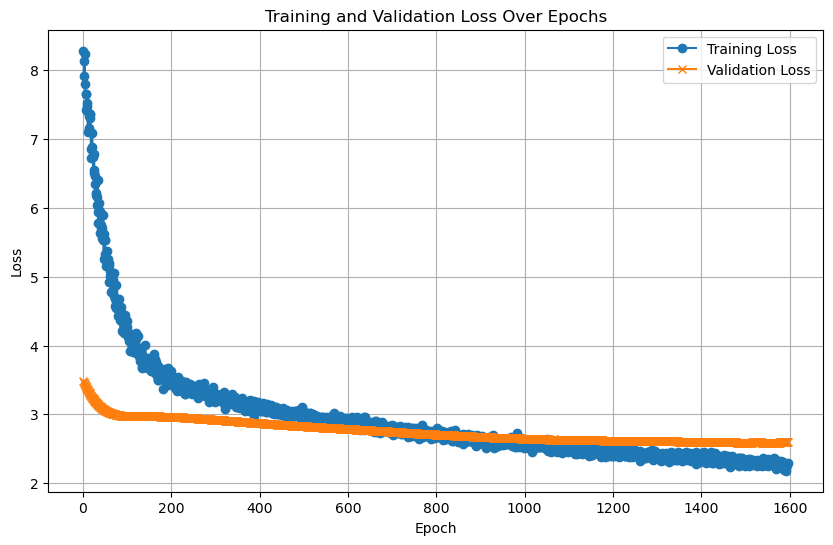

In [36]:
tscl_model = SupConNet().to(device)
tscl_criterion = SupConLoss(temperature=0.07).to(device)
tscl_optimizer = optim.Adam(tscl_model.parameters(), lr=1e-4, weight_decay=1e-5)  # Increased learning rate

tscl_patience = 100
tscl_best_val_loss = float('inf')
tscl_epochs_without_improvement = 0

tscl_num_epochs = 2000
tscl_train_losses = []
tscl_val_losses = []

# TRAINING
for tscl_epoch in range(tscl_num_epochs):
    print(f"\nLOG: Epoch [{tscl_epoch + 1}/{tscl_num_epochs}] - Training")
    tscl_model.train()
    tscl_total_loss = 0

    for batch_idx, (vectors, labels) in enumerate(tscl_train_loader):
        vectors = vectors.to(device).float()  # moving input tensors to GPU
        labels = labels.to(device)  # moving labels to GPU

        # forward pass to get projections
        projections = tscl_model(vectors)

        # calc contrastive loss
        loss = tscl_criterion(projections, labels)

        # backprop and optimization
        tscl_optimizer.zero_grad()
        loss.backward()
        tscl_optimizer.step()

        tscl_total_loss += loss.item()

        if (batch_idx + 1) % 1 == 0:
            print(f"    Batch [{batch_idx + 1}/{len(tscl_train_loader)}], "
                  f"Train Loss: {loss.item():.4f}")

    # calc avg training loss for the epoch
    tscl_avg_train_loss = tscl_total_loss / len(tscl_train_loader)
    tscl_train_losses.append(tscl_avg_train_loss)
    print(f"Epoch [{tscl_epoch + 1}/{tscl_num_epochs}], "
          f"Avg Train Loss: {tscl_avg_train_loss:.4f}")

    # VALIDATION
    tscl_model.eval()
    total_val_loss = 0.0

    with torch.no_grad():
        for batch_idx, (vectors, labels) in enumerate(tscl_val_loader):
            vectors = vectors.to(device).float()
            labels = labels.to(device)

            projections = tscl_model(vectors)

            loss = tscl_criterion(projections, labels)
            total_val_loss += loss.item()

            if (batch_idx + 1) % 10 == 0:
                print(f"    Batch [{batch_idx + 1}/{len(tscl_val_loader)}], "
                      f"Val Loss: {loss.item():.4f}")

    tscl_avg_val_loss = total_val_loss / len(tscl_val_loader)
    tscl_val_losses.append(tscl_avg_val_loss)
    print(f"Epoch [{tscl_epoch + 1}/{tscl_num_epochs}], "
          f"Avg Val Loss: {tscl_avg_val_loss:.4f}")

    # early stopping logic
    if tscl_avg_val_loss < tscl_best_val_loss:
        print(f"Validation loss improved from {tscl_best_val_loss:.4f} to {tscl_avg_val_loss:.4f}. Saving model...")
        tscl_best_val_loss = tscl_avg_val_loss
        tscl_epochs_without_improvement = 0
    else:
        tscl_epochs_without_improvement += 1
        print(f"Validation loss did not improve. Patience: {tscl_epochs_without_improvement}/{tscl_patience}")

    # stopping training if validation loss hasn't improved for patience amount of epochs
    if tscl_epochs_without_improvement >= tscl_patience:
        print(f"Early stopping triggered at epoch {tscl_epoch + 1}. No improvement for {tscl_patience} epochs.")
        break

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(tscl_train_losses) + 1), tscl_train_losses, label="Training Loss", marker='o')
plt.plot(range(1, len(tscl_val_losses) + 1), tscl_val_losses, label="Validation Loss", marker='x')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid()
plt.show()

Test Batch [10/211], Loss: 4.4873
Test Batch [20/211], Loss: 5.1066
Test Batch [30/211], Loss: 5.3444
Test Batch [40/211], Loss: 5.3229
Test Batch [50/211], Loss: 5.3679
Test Batch [60/211], Loss: 5.3365
Test Batch [70/211], Loss: 4.9822
Test Batch [80/211], Loss: 5.1034
Test Batch [90/211], Loss: 4.9139
Test Batch [100/211], Loss: 5.2821
Test Batch [110/211], Loss: 5.6316
Test Batch [120/211], Loss: 5.5827
Test Batch [130/211], Loss: 5.0978
Test Batch [140/211], Loss: 5.0537
Test Batch [150/211], Loss: 5.0217


Test Batch [160/211], Loss: 5.0950
Test Batch [170/211], Loss: 5.0053
Test Batch [180/211], Loss: 4.8143
Test Batch [190/211], Loss: 4.8608
Test Batch [200/211], Loss: 4.4836
Test Batch [210/211], Loss: 4.4469

Test Loss: 5.0074


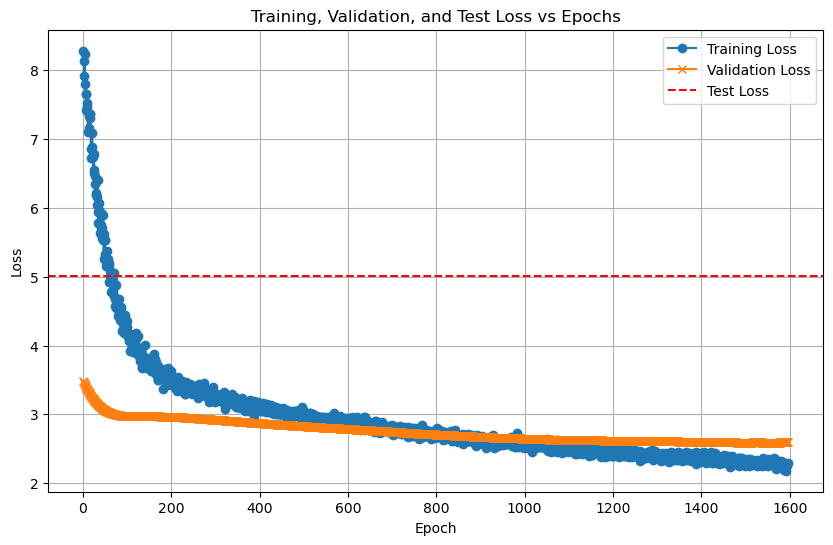

In [37]:
# Test Evaluation
tscl_model.eval()
total_test_loss = 0.0

with torch.no_grad():
    for batch_idx, (vectors, labels) in enumerate(tscl_test_loader):
        vectors = vectors.to(device).float()
        labels = labels.to(device)
        projections = tscl_model(vectors)
        loss = criterion(projections, labels)
        total_test_loss += loss.item()
        if (batch_idx + 1) % 10 == 0:
            print(f"Test Batch [{batch_idx + 1}/{len(tscl_test_loader)}], Loss: {loss.item():.4f}")

avg_test_loss = total_test_loss / len(tscl_test_loader)
print(f"\nTest Loss: {avg_test_loss:.4f}")


plt.figure(figsize=(10, 6))
epochs = range(1, len(tscl_train_losses) + 1)
plt.plot(epochs, tscl_train_losses, label="Training Loss", marker='o')
plt.plot(epochs, tscl_val_losses, label="Validation Loss", marker='x')
# test loss = horizontal dashed line
plt.axhline(y=avg_test_loss, color='r', linestyle='--', label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training, Validation, and Test Loss vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

### Saving representations learnt by Typical SCL Model

In [38]:
# dir to save the SCL representations
tscl_rep_dir = "tscl_representations"
os.makedirs(tscl_rep_dir, exist_ok=True)

tscl_loaders = {
    'train': tscl_train_loader,
    'val': tscl_val_loader,
    'test': tscl_test_loader
}

tscl_model.eval()

with torch.no_grad():
    for tscl_split_name, tscl_loader in tscl_loaders.items():
        print(f"\nExtracting SCL representations for the {tscl_split_name} dataset...")
        # creating subfolder for the split
        tscl_split_dir = os.path.join(tscl_rep_dir, tscl_split_name)
        os.makedirs(tscl_split_dir, exist_ok=True)
        
        # processing the data batch-wise
        for tscl_batch_idx, (tscl_vectors, tscl_labels) in enumerate(tscl_loader):
            tscl_vectors = tscl_vectors.to(device).float()
            # computing projections using the trained SCL model
            tscl_projections = tscl_model(tscl_vectors)
            
            # converting projections and labels to np arrays
            tscl_projections_np = tscl_projections.cpu().numpy()
            tscl_labels_np = tscl_labels.cpu().numpy()
            
            # saving the batch projections and labels
            np.save(os.path.join(tscl_split_dir, f"scl_encoded_batch_{tscl_batch_idx}.npy"), tscl_projections_np)
            np.save(os.path.join(tscl_split_dir, f"scl_labels_batch_{tscl_batch_idx}.npy"), tscl_labels_np)
            
            if (tscl_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {tscl_batch_idx + 1}/{len(tscl_loader)} for {tscl_split_name} dataset.")

        print(f"Completed extraction for the {tscl_split_name} dataset. Representations saved in '{tscl_split_dir}'.")

print("SCL representations extraction complete.")


Extracting SCL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'tscl_representations\train'.

Extracting SCL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'tscl_representations\val'.

Extracting SCL representations for the test dataset...


  Processed batch 10/211 for test dataset.
  Processed batch 20/211 for test dataset.
  Processed batch 30/211 for test dataset.
  Processed batch 40/211 for test dataset.
  Processed batch 50/211 for test dataset.


  Processed batch 60/211 for test dataset.
  Processed batch 70/211 for test dataset.


  Processed batch 80/211 for test dataset.
  Processed batch 90/211 for test dataset.
  Processed batch 100/211 for test dataset.
  Processed batch 110/211 for test dataset.
  Processed batch 120/211 for test dataset.


  Processed batch 130/211 for test dataset.
  Processed batch 140/211 for test dataset.


  Processed batch 150/211 for test dataset.
  Processed batch 160/211 for test dataset.
  Processed batch 170/211 for test dataset.
  Processed batch 180/211 for test dataset.
  Processed batch 190/211 for test dataset.


  Processed batch 200/211 for test dataset.
  Processed batch 210/211 for test dataset.
Completed extraction for the test dataset. Representations saved in 'tscl_representations\test'.
SCL representations extraction complete.


### Classifying representations learnt by SCL Model with LRM

In [39]:
def load_tscl_reps_and_labels(split_dir):
    #gather all the scl_encoded_batch npy files in sorted order
    tscl_rep_files = sorted(glob.glob(os.path.join(split_dir, "scl_encoded_batch_*.npy")))

    tscl_all_reps = []
    tscl_all_labels = []

    for tscl_rep_file in tscl_rep_files:
        #deriving label filenames
        tscl_label_file = tscl_rep_file.replace("scl_encoded_batch_", "scl_labels_batch_")

        tscl_reps = np.load(tscl_rep_file)
        tscl_labels = np.load(tscl_label_file)

        tscl_all_reps.append(tscl_reps)
        tscl_all_labels.append(tscl_labels)

    #concat along first dim
    tscl_all_reps = np.concatenate(tscl_all_reps, axis = 0)
    tscl_all_labels = np.concatenate(tscl_all_labels, axis = 0)

    return tscl_all_reps, tscl_all_labels

In [40]:
tscl_lrm_train_dir = os.path.join("tscl_representations", "train")
tscl_lrm_val_dir   = os.path.join("tscl_representations", "val")
tscl_lrm_test_dir  = os.path.join("tscl_representations", "test")

tscl_lrm_train_reps, tscl_lrm_train_labels = load_tscl_reps_and_labels(tscl_lrm_train_dir)
tscl_lrm_val_reps, tscl_lrm_val_labels = load_tscl_reps_and_labels(tscl_lrm_val_dir)
tscl_lrm_test_reps, tscl_lrm_test_labels = load_tscl_reps_and_labels(tscl_lrm_test_dir)

print("Train reps shape:", tscl_lrm_train_reps.shape)
print("Train labels shape:", tscl_lrm_train_labels.shape)

print("Val reps shape:", tscl_lrm_val_reps.shape)
print("Val labels shape:", tscl_lrm_val_labels.shape)

print("Test reps shape:", tscl_lrm_test_reps.shape)
print("Test labels shape:", tscl_lrm_test_labels.shape)

Train reps shape: (80, 128)
Train labels shape: (80,)
Val reps shape: (80, 128)
Val labels shape: (80,)
Test reps shape: (53969, 128)
Test labels shape: (53969,)


In [41]:
# training LRM on the tscl representations
print("\nLOG: Training Logistic Regression model on SCL SDL representations...")
tscl_logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight='balanced')
tscl_logistic_clf.fit(tscl_lrm_train_reps, tscl_lrm_train_labels)
print("LOG: Logistic Regression training complete.")

# eval on val set
print("\nLOG: Evaluating on the validation set...")
tscl_lrm_val_predictions = tscl_logistic_clf.predict(tscl_lrm_val_reps)
tscl_lrm_val_accuracy = accuracy_score(tscl_lrm_val_labels, tscl_lrm_val_predictions)
print(f"Validation Accuracy: {tscl_lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(tscl_lrm_val_labels, tscl_lrm_val_predictions))

# eval on test
print("\nLOG: Evaluating on the test set...")
tscl_lrm_test_predictions = tscl_logistic_clf.predict(tscl_lrm_test_reps)
tscl_lrm_test_accuracy = accuracy_score(tscl_lrm_test_labels, tscl_lrm_test_predictions)
print(f"Test Accuracy: {tscl_lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(tscl_lrm_test_labels, tscl_lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'tscl_lrm_predictions.npy'), tscl_lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'tscl_lrm_true_labels.npy'), tscl_lrm_test_labels)
print(f"Saved CAE+LRM predictions and true labels to {predictions_dir}")


LOG: Training Logistic Regression model on SCL SDL representations...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 86.25%

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.83      1.00      0.91         5
           1       1.00      0.80      0.89         5
           2       1.00      1.00      1.00         5
           3       0.80      0.80      0.80         5
           4       0.71      1.00      0.83         5
           5       1.00      1.00      1.00         5
           6       0.71      1.00      0.83         5
           7       0.67      0.80      0.73         5
           8       1.00      1.00      1.00         5
           9       1.00      0.80      0.89         5
          10       1.00      0.80      0.89         5
          11       1.00      1.00      1.00         5
          12       0.83      1.00      0.91         5
          13       1.0

### Classifying the representations learnt by Typical SCL Model with MLP Classifier

In [42]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, num_classes)
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules(): 
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [43]:
tscl_mlp_train_dir = os.path.join("tscl_representations", "train")
tscl_mlp_val_dir   = os.path.join("tscl_representations", "val")
tscl_mlp_test_dir  = os.path.join("tscl_representations", "test")

tscl_mlp_train_reps, tscl_mlp_train_labels = load_tscl_reps_and_labels(tscl_mlp_train_dir)
tscl_mlp_val_reps, tscl_mlp_val_labels = load_tscl_reps_and_labels(tscl_mlp_val_dir)
tscl_mlp_test_reps, tscl_mlp_test_labels = load_tscl_reps_and_labels(tscl_mlp_test_dir)

print("Train reps shape:",tscl_mlp_train_reps.shape)
print("Train labels shape:", tscl_mlp_train_labels.shape)

print("Val reps shape:", tscl_mlp_val_reps.shape)
print("Val labels shape:", tscl_mlp_val_labels.shape)

print("Test reps shape:", tscl_mlp_test_reps.shape)
print("Test labels shape:", tscl_mlp_test_labels.shape)

Train reps shape: (80, 128)
Train labels shape: (80,)
Val reps shape: (80, 128)
Val labels shape: (80,)
Test reps shape: (53969, 128)
Test labels shape: (53969,)


In [44]:
#converting arrays to torch tensors
tscl_mlp_train_embeddings_torch = torch.tensor(tscl_mlp_train_reps, dtype=torch.float32)
tscl_mlp_train_labels_torch = torch.tensor(tscl_mlp_train_labels, dtype=torch.long)

tscl_mlp_val_embeddings_torch = torch.tensor(tscl_mlp_val_reps, dtype=torch.float32)
tscl_mlp_val_labels_torch = torch.tensor(tscl_mlp_val_labels, dtype=torch.long)

tscl_mlp_test_embeddings_torch = torch.tensor(tscl_mlp_test_reps, dtype=torch.float32)
tscl_mlp_test_labels_torch = torch.tensor(tscl_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
tscl_mlp_train_dataset = TensorDataset(tscl_mlp_train_embeddings_torch, tscl_mlp_train_labels_torch)
tscl_mlp_val_dataset = TensorDataset(tscl_mlp_val_embeddings_torch, tscl_mlp_val_labels_torch)
tscl_mlp_test_dataset = TensorDataset(tscl_mlp_test_embeddings_torch, tscl_mlp_test_labels_torch)

tscl_mlp_batch_size = 64
tscl_mlp_train_loader = DataLoader(tscl_mlp_train_dataset, batch_size=tscl_mlp_batch_size, shuffle=True)
tscl_mlp_val_loader = DataLoader(tscl_mlp_val_dataset, batch_size=tscl_mlp_batch_size, shuffle=False)
tscl_mlp_test_loader = DataLoader(tscl_mlp_test_dataset, batch_size=tscl_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.8863  |  Val Loss: 2.8711
Validation loss improved from inf to 2.8711.
[Epoch 2/1000] Train Loss: 2.8685  |  Val Loss: 2.8564
Validation loss improved from 2.8711 to 2.8564.
[Epoch 3/1000] Train Loss: 2.8535  |  Val Loss: 2.8422
Validation loss improved from 2.8564 to 2.8422.
[Epoch 4/1000] Train Loss: 2.8381  |  Val Loss: 2.8284
Validation loss improved from 2.8422 to 2.8284.
[Epoch 5/1000] Train Loss: 2.8235  |  Val Loss: 2.8150
Validation loss improved from 2.8284 to 2.8150.
[Epoch 6/1000] Train Loss: 2.8099  |  Val Loss: 2.8021
Validation loss improved from 2.8150 to 2.8021.
[Epoch 7/1000] Train Loss: 2.7957  |  Val Loss: 2.7895
Validation loss improved from 2.8021 to 2.7895.
[Epoch 8/1000] Train Loss: 2.7825  |  Val Loss: 2.7774
Validation loss improved from 2.7895 to 2.7774.
[Epoch 9/1000] Train Loss: 2.7687  |  Val Loss: 2.7658
Validation loss improved from 2.7774 to 2.7658.
[Epoch 10/1000] Train Loss: 2.7563  |  Val Loss: 2.7544
Validation loss impr

[Epoch 34/1000] Train Loss: 2.5167  |  Val Loss: 2.5432
Validation loss improved from 2.5506 to 2.5432.
[Epoch 35/1000] Train Loss: 2.5078  |  Val Loss: 2.5357
Validation loss improved from 2.5432 to 2.5357.
[Epoch 36/1000] Train Loss: 2.4992  |  Val Loss: 2.5282
Validation loss improved from 2.5357 to 2.5282.
[Epoch 37/1000] Train Loss: 2.4900  |  Val Loss: 2.5205
Validation loss improved from 2.5282 to 2.5205.
[Epoch 38/1000] Train Loss: 2.4812  |  Val Loss: 2.5128
Validation loss improved from 2.5205 to 2.5128.
[Epoch 39/1000] Train Loss: 2.4719  |  Val Loss: 2.5051
Validation loss improved from 2.5128 to 2.5051.
[Epoch 40/1000] Train Loss: 2.4630  |  Val Loss: 2.4975
Validation loss improved from 2.5051 to 2.4975.
[Epoch 41/1000] Train Loss: 2.4539  |  Val Loss: 2.4898
Validation loss improved from 2.4975 to 2.4898.
[Epoch 42/1000] Train Loss: 2.4450  |  Val Loss: 2.4822
Validation loss improved from 2.4898 to 2.4822.
[Epoch 43/1000] Train Loss: 2.4357  |  Val Loss: 2.4745
Validati

[Epoch 74/1000] Train Loss: 2.1266  |  Val Loss: 2.2125
Validation loss improved from 2.2201 to 2.2125.
[Epoch 75/1000] Train Loss: 2.1166  |  Val Loss: 2.2051
Validation loss improved from 2.2125 to 2.2051.
[Epoch 76/1000] Train Loss: 2.1068  |  Val Loss: 2.1977
Validation loss improved from 2.2051 to 2.1977.
[Epoch 77/1000] Train Loss: 2.0970  |  Val Loss: 2.1903
Validation loss improved from 2.1977 to 2.1903.
[Epoch 78/1000] Train Loss: 2.0868  |  Val Loss: 2.1829
Validation loss improved from 2.1903 to 2.1829.
[Epoch 79/1000] Train Loss: 2.0766  |  Val Loss: 2.1753
Validation loss improved from 2.1829 to 2.1753.
[Epoch 80/1000] Train Loss: 2.0664  |  Val Loss: 2.1673
Validation loss improved from 2.1753 to 2.1673.
[Epoch 81/1000] Train Loss: 2.0558  |  Val Loss: 2.1592
Validation loss improved from 2.1673 to 2.1592.
[Epoch 82/1000] Train Loss: 2.0454  |  Val Loss: 2.1509
Validation loss improved from 2.1592 to 2.1509.
[Epoch 83/1000] Train Loss: 2.0345  |  Val Loss: 2.1426
Validati

[Epoch 115/1000] Train Loss: 1.6916  |  Val Loss: 1.8701
Validation loss improved from 1.8788 to 1.8701.
[Epoch 116/1000] Train Loss: 1.6811  |  Val Loss: 1.8616
Validation loss improved from 1.8701 to 1.8616.
[Epoch 117/1000] Train Loss: 1.6708  |  Val Loss: 1.8531
Validation loss improved from 1.8616 to 1.8531.
[Epoch 118/1000] Train Loss: 1.6607  |  Val Loss: 1.8445
Validation loss improved from 1.8531 to 1.8445.
[Epoch 119/1000] Train Loss: 1.6508  |  Val Loss: 1.8362
Validation loss improved from 1.8445 to 1.8362.
[Epoch 120/1000] Train Loss: 1.6406  |  Val Loss: 1.8281
Validation loss improved from 1.8362 to 1.8281.
[Epoch 121/1000] Train Loss: 1.6305  |  Val Loss: 1.8199
Validation loss improved from 1.8281 to 1.8199.
[Epoch 122/1000] Train Loss: 1.6200  |  Val Loss: 1.8117
Validation loss improved from 1.8199 to 1.8117.
[Epoch 123/1000] Train Loss: 1.6097  |  Val Loss: 1.8037
Validation loss improved from 1.8117 to 1.8037.
[Epoch 124/1000] Train Loss: 1.5995  |  Val Loss: 1.795

[Epoch 151/1000] Train Loss: 1.3280  |  Val Loss: 1.5593
Validation loss improved from 1.5676 to 1.5593.
[Epoch 152/1000] Train Loss: 1.3192  |  Val Loss: 1.5511
Validation loss improved from 1.5593 to 1.5511.
[Epoch 153/1000] Train Loss: 1.3102  |  Val Loss: 1.5436
Validation loss improved from 1.5511 to 1.5436.
[Epoch 154/1000] Train Loss: 1.3009  |  Val Loss: 1.5366
Validation loss improved from 1.5436 to 1.5366.
[Epoch 155/1000] Train Loss: 1.2923  |  Val Loss: 1.5293
Validation loss improved from 1.5366 to 1.5293.
[Epoch 156/1000] Train Loss: 1.2836  |  Val Loss: 1.5218
Validation loss improved from 1.5293 to 1.5218.
[Epoch 157/1000] Train Loss: 1.2745  |  Val Loss: 1.5143
Validation loss improved from 1.5218 to 1.5143.
[Epoch 158/1000] Train Loss: 1.2665  |  Val Loss: 1.5068
Validation loss improved from 1.5143 to 1.5068.
[Epoch 159/1000] Train Loss: 1.2581  |  Val Loss: 1.4994
Validation loss improved from 1.5068 to 1.4994.
[Epoch 160/1000] Train Loss: 1.2495  |  Val Loss: 1.492

[Epoch 191/1000] Train Loss: 1.0064  |  Val Loss: 1.2849
Validation loss improved from 1.2917 to 1.2849.
[Epoch 192/1000] Train Loss: 0.9995  |  Val Loss: 1.2787
Validation loss improved from 1.2849 to 1.2787.
[Epoch 193/1000] Train Loss: 0.9926  |  Val Loss: 1.2730
Validation loss improved from 1.2787 to 1.2730.
[Epoch 194/1000] Train Loss: 0.9854  |  Val Loss: 1.2672
Validation loss improved from 1.2730 to 1.2672.
[Epoch 195/1000] Train Loss: 0.9785  |  Val Loss: 1.2614
Validation loss improved from 1.2672 to 1.2614.
[Epoch 196/1000] Train Loss: 0.9716  |  Val Loss: 1.2552
Validation loss improved from 1.2614 to 1.2552.
[Epoch 197/1000] Train Loss: 0.9647  |  Val Loss: 1.2487
Validation loss improved from 1.2552 to 1.2487.
[Epoch 198/1000] Train Loss: 0.9581  |  Val Loss: 1.2425
Validation loss improved from 1.2487 to 1.2425.
[Epoch 199/1000] Train Loss: 0.9512  |  Val Loss: 1.2366
Validation loss improved from 1.2425 to 1.2366.
[Epoch 200/1000] Train Loss: 0.9444  |  Val Loss: 1.231

[Epoch 227/1000] Train Loss: 0.7816  |  Val Loss: 1.0942
Validation loss improved from 1.0981 to 1.0942.
[Epoch 228/1000] Train Loss: 0.7764  |  Val Loss: 1.0904
Validation loss improved from 1.0942 to 1.0904.
[Epoch 229/1000] Train Loss: 0.7711  |  Val Loss: 1.0865
Validation loss improved from 1.0904 to 1.0865.
[Epoch 230/1000] Train Loss: 0.7658  |  Val Loss: 1.0823
Validation loss improved from 1.0865 to 1.0823.
[Epoch 231/1000] Train Loss: 0.7612  |  Val Loss: 1.0781
Validation loss improved from 1.0823 to 1.0781.
[Epoch 232/1000] Train Loss: 0.7561  |  Val Loss: 1.0738
Validation loss improved from 1.0781 to 1.0738.
[Epoch 233/1000] Train Loss: 0.7512  |  Val Loss: 1.0693
Validation loss improved from 1.0738 to 1.0693.
[Epoch 234/1000] Train Loss: 0.7456  |  Val Loss: 1.0653
Validation loss improved from 1.0693 to 1.0653.
[Epoch 235/1000] Train Loss: 0.7404  |  Val Loss: 1.0613
Validation loss improved from 1.0653 to 1.0613.
[Epoch 236/1000] Train Loss: 0.7349  |  Val Loss: 1.056

[Epoch 268/1000] Train Loss: 0.5919  |  Val Loss: 0.9420
Validation loss improved from 0.9463 to 0.9420.
[Epoch 269/1000] Train Loss: 0.5877  |  Val Loss: 0.9375
Validation loss improved from 0.9420 to 0.9375.
[Epoch 270/1000] Train Loss: 0.5837  |  Val Loss: 0.9338
Validation loss improved from 0.9375 to 0.9338.
[Epoch 271/1000] Train Loss: 0.5798  |  Val Loss: 0.9305
Validation loss improved from 0.9338 to 0.9305.
[Epoch 272/1000] Train Loss: 0.5760  |  Val Loss: 0.9269
Validation loss improved from 0.9305 to 0.9269.
[Epoch 273/1000] Train Loss: 0.5718  |  Val Loss: 0.9230
Validation loss improved from 0.9269 to 0.9230.
[Epoch 274/1000] Train Loss: 0.5680  |  Val Loss: 0.9193
Validation loss improved from 0.9230 to 0.9193.
[Epoch 275/1000] Train Loss: 0.5642  |  Val Loss: 0.9161
Validation loss improved from 0.9193 to 0.9161.
[Epoch 276/1000] Train Loss: 0.5603  |  Val Loss: 0.9130
Validation loss improved from 0.9161 to 0.9130.
[Epoch 277/1000] Train Loss: 0.5566  |  Val Loss: 0.909

[Epoch 310/1000] Train Loss: 0.4512  |  Val Loss: 0.8291
Validation loss improved from 0.8322 to 0.8291.
[Epoch 311/1000] Train Loss: 0.4482  |  Val Loss: 0.8259
Validation loss improved from 0.8291 to 0.8259.
[Epoch 312/1000] Train Loss: 0.4453  |  Val Loss: 0.8226
Validation loss improved from 0.8259 to 0.8226.
[Epoch 313/1000] Train Loss: 0.4430  |  Val Loss: 0.8202
Validation loss improved from 0.8226 to 0.8202.
[Epoch 314/1000] Train Loss: 0.4398  |  Val Loss: 0.8186
Validation loss improved from 0.8202 to 0.8186.
[Epoch 315/1000] Train Loss: 0.4376  |  Val Loss: 0.8167
Validation loss improved from 0.8186 to 0.8167.
[Epoch 316/1000] Train Loss: 0.4346  |  Val Loss: 0.8139
Validation loss improved from 0.8167 to 0.8139.
[Epoch 317/1000] Train Loss: 0.4320  |  Val Loss: 0.8108
Validation loss improved from 0.8139 to 0.8108.
[Epoch 318/1000] Train Loss: 0.4290  |  Val Loss: 0.8074
Validation loss improved from 0.8108 to 0.8074.
[Epoch 319/1000] Train Loss: 0.4270  |  Val Loss: 0.804

[Epoch 348/1000] Train Loss: 0.3606  |  Val Loss: 0.7718
Validation loss improved from 0.7722 to 0.7718.
[Epoch 349/1000] Train Loss: 0.3588  |  Val Loss: 0.7706
Validation loss improved from 0.7718 to 0.7706.
[Epoch 350/1000] Train Loss: 0.3562  |  Val Loss: 0.7699
Validation loss improved from 0.7706 to 0.7699.
[Epoch 351/1000] Train Loss: 0.3542  |  Val Loss: 0.7692
Validation loss improved from 0.7699 to 0.7692.
[Epoch 352/1000] Train Loss: 0.3523  |  Val Loss: 0.7678
Validation loss improved from 0.7692 to 0.7678.
[Epoch 353/1000] Train Loss: 0.3504  |  Val Loss: 0.7662
Validation loss improved from 0.7678 to 0.7662.
[Epoch 354/1000] Train Loss: 0.3483  |  Val Loss: 0.7648
Validation loss improved from 0.7662 to 0.7648.
[Epoch 355/1000] Train Loss: 0.3464  |  Val Loss: 0.7635
Validation loss improved from 0.7648 to 0.7635.
[Epoch 356/1000] Train Loss: 0.3446  |  Val Loss: 0.7622
Validation loss improved from 0.7635 to 0.7622.
[Epoch 357/1000] Train Loss: 0.3427  |  Val Loss: 0.761

[Epoch 389/1000] Train Loss: 0.2917  |  Val Loss: 0.7290
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 390/1000] Train Loss: 0.2898  |  Val Loss: 0.7296
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 391/1000] Train Loss: 0.2888  |  Val Loss: 0.7300
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 392/1000] Train Loss: 0.2868  |  Val Loss: 0.7295
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 393/1000] Train Loss: 0.2854  |  Val Loss: 0.7289
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 394/1000] Train Loss: 0.2842  |  Val Loss: 0.7282
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 395/1000] Train Loss: 0.2828  |  Val Loss: 0.7280
Validation loss improved from 0.7281 to 0.7280.
[Epoch 396/1000] Train Loss: 0.2815  |  Val Loss: 0.7285
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 397/1000] Train Loss: 0.2803  |  Val Loss: 0.7297
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 

[Epoch 431/1000] Train Loss: 0.2407  |  Val Loss: 0.6996
Validation loss improved from 0.7000 to 0.6996.
[Epoch 432/1000] Train Loss: 0.2400  |  Val Loss: 0.6989
Validation loss improved from 0.6996 to 0.6989.
[Epoch 433/1000] Train Loss: 0.2384  |  Val Loss: 0.6977
Validation loss improved from 0.6989 to 0.6977.
[Epoch 434/1000] Train Loss: 0.2372  |  Val Loss: 0.6967
Validation loss improved from 0.6977 to 0.6967.
[Epoch 435/1000] Train Loss: 0.2359  |  Val Loss: 0.6959
Validation loss improved from 0.6967 to 0.6959.
[Epoch 436/1000] Train Loss: 0.2357  |  Val Loss: 0.6951
Validation loss improved from 0.6959 to 0.6951.
[Epoch 437/1000] Train Loss: 0.2354  |  Val Loss: 0.6947
Validation loss improved from 0.6951 to 0.6947.
[Epoch 438/1000] Train Loss: 0.2343  |  Val Loss: 0.6947
Validation loss improved from 0.6947 to 0.6947.
[Epoch 439/1000] Train Loss: 0.2330  |  Val Loss: 0.6946
Validation loss improved from 0.6947 to 0.6946.
[Epoch 440/1000] Train Loss: 0.2317  |  Val Loss: 0.694

[Epoch 472/1000] Train Loss: 0.2030  |  Val Loss: 0.6762
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 473/1000] Train Loss: 0.2014  |  Val Loss: 0.6782
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 474/1000] Train Loss: 0.2006  |  Val Loss: 0.6797
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 475/1000] Train Loss: 0.1998  |  Val Loss: 0.6809
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 476/1000] Train Loss: 0.1994  |  Val Loss: 0.6814
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 477/1000] Train Loss: 0.1986  |  Val Loss: 0.6809
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 478/1000] Train Loss: 0.1978  |  Val Loss: 0.6796
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 479/1000] Train Loss: 0.1972  |  Val Loss: 0.6783
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 480/1000] Train Loss: 0.1961  |  Val Loss: 0.6766
!! Validation loss did NOT improve !! Patience: 10/100


[Epoch 515/1000] Train Loss: 0.1719  |  Val Loss: 0.6774
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 516/1000] Train Loss: 0.1719  |  Val Loss: 0.6783
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 517/1000] Train Loss: 0.1716  |  Val Loss: 0.6774
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 518/1000] Train Loss: 0.1705  |  Val Loss: 0.6740
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 519/1000] Train Loss: 0.1697  |  Val Loss: 0.6712
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 520/1000] Train Loss: 0.1686  |  Val Loss: 0.6693
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 521/1000] Train Loss: 0.1680  |  Val Loss: 0.6676
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 522/1000] Train Loss: 0.1678  |  Val Loss: 0.6672
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 523/1000] Train Loss: 0.1672  |  Val Loss: 0.6684
!! Validation loss did NOT improve !! Patience: 1

[Epoch 557/1000] Train Loss: 0.1483  |  Val Loss: 0.6669
!! Validation loss did NOT improve !! Patience: 50/100
[Epoch 558/1000] Train Loss: 0.1473  |  Val Loss: 0.6645
!! Validation loss did NOT improve !! Patience: 51/100
[Epoch 559/1000] Train Loss: 0.1467  |  Val Loss: 0.6634
!! Validation loss did NOT improve !! Patience: 52/100
[Epoch 560/1000] Train Loss: 0.1464  |  Val Loss: 0.6633
!! Validation loss did NOT improve !! Patience: 53/100
[Epoch 561/1000] Train Loss: 0.1459  |  Val Loss: 0.6636
!! Validation loss did NOT improve !! Patience: 54/100
[Epoch 562/1000] Train Loss: 0.1461  |  Val Loss: 0.6647
!! Validation loss did NOT improve !! Patience: 55/100
[Epoch 563/1000] Train Loss: 0.1456  |  Val Loss: 0.6667
!! Validation loss did NOT improve !! Patience: 56/100
[Epoch 564/1000] Train Loss: 0.1455  |  Val Loss: 0.6682
!! Validation loss did NOT improve !! Patience: 57/100
[Epoch 565/1000] Train Loss: 0.1457  |  Val Loss: 0.6691
!! Validation loss did NOT improve !! Patience:

[Epoch 597/1000] Train Loss: 0.1294  |  Val Loss: 0.6586
Validation loss improved from 0.6586 to 0.6586.
[Epoch 598/1000] Train Loss: 0.1297  |  Val Loss: 0.6593
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 599/1000] Train Loss: 0.1291  |  Val Loss: 0.6608
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 600/1000] Train Loss: 0.1283  |  Val Loss: 0.6624
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 601/1000] Train Loss: 0.1276  |  Val Loss: 0.6644
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 602/1000] Train Loss: 0.1271  |  Val Loss: 0.6658
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 603/1000] Train Loss: 0.1268  |  Val Loss: 0.6655
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 604/1000] Train Loss: 0.1259  |  Val Loss: 0.6633
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 605/1000] Train Loss: 0.1260  |  Val Loss: 0.6608
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 

[Epoch 635/1000] Train Loss: 0.1145  |  Val Loss: 0.6608
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 636/1000] Train Loss: 0.1144  |  Val Loss: 0.6625
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 637/1000] Train Loss: 0.1142  |  Val Loss: 0.6632
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 638/1000] Train Loss: 0.1141  |  Val Loss: 0.6631
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 639/1000] Train Loss: 0.1137  |  Val Loss: 0.6620
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 640/1000] Train Loss: 0.1131  |  Val Loss: 0.6610
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 641/1000] Train Loss: 0.1128  |  Val Loss: 0.6603
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 642/1000] Train Loss: 0.1124  |  Val Loss: 0.6608
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 643/1000] Train Loss: 0.1118  |  Val Loss: 0.6626
!! Validation loss did NOT improve !! Patience: 12/10

[Epoch 677/1000] Train Loss: 0.1007  |  Val Loss: 0.6688
!! Validation loss did NOT improve !! Patience: 46/100
[Epoch 678/1000] Train Loss: 0.1003  |  Val Loss: 0.6672
!! Validation loss did NOT improve !! Patience: 47/100
[Epoch 679/1000] Train Loss: 0.1003  |  Val Loss: 0.6645
!! Validation loss did NOT improve !! Patience: 48/100
[Epoch 680/1000] Train Loss: 0.0994  |  Val Loss: 0.6622
!! Validation loss did NOT improve !! Patience: 49/100
[Epoch 681/1000] Train Loss: 0.0991  |  Val Loss: 0.6604
!! Validation loss did NOT improve !! Patience: 50/100
[Epoch 682/1000] Train Loss: 0.0992  |  Val Loss: 0.6594
!! Validation loss did NOT improve !! Patience: 51/100
[Epoch 683/1000] Train Loss: 0.0995  |  Val Loss: 0.6599
!! Validation loss did NOT improve !! Patience: 52/100
[Epoch 684/1000] Train Loss: 0.0992  |  Val Loss: 0.6608
!! Validation loss did NOT improve !! Patience: 53/100
[Epoch 685/1000] Train Loss: 0.0987  |  Val Loss: 0.6612
!! Validation loss did NOT improve !! Patience:

[Epoch 717/1000] Train Loss: 0.0881  |  Val Loss: 0.6642
!! Validation loss did NOT improve !! Patience: 86/100
[Epoch 718/1000] Train Loss: 0.0882  |  Val Loss: 0.6649
!! Validation loss did NOT improve !! Patience: 87/100
[Epoch 719/1000] Train Loss: 0.0875  |  Val Loss: 0.6666
!! Validation loss did NOT improve !! Patience: 88/100
[Epoch 720/1000] Train Loss: 0.0864  |  Val Loss: 0.6701
!! Validation loss did NOT improve !! Patience: 89/100
[Epoch 721/1000] Train Loss: 0.0856  |  Val Loss: 0.6740
!! Validation loss did NOT improve !! Patience: 90/100
[Epoch 722/1000] Train Loss: 0.0856  |  Val Loss: 0.6775
!! Validation loss did NOT improve !! Patience: 91/100
[Epoch 723/1000] Train Loss: 0.0862  |  Val Loss: 0.6805
!! Validation loss did NOT improve !! Patience: 92/100
[Epoch 724/1000] Train Loss: 0.0875  |  Val Loss: 0.6800
!! Validation loss did NOT improve !! Patience: 93/100
[Epoch 725/1000] Train Loss: 0.0863  |  Val Loss: 0.6744
!! Validation loss did NOT improve !! Patience:

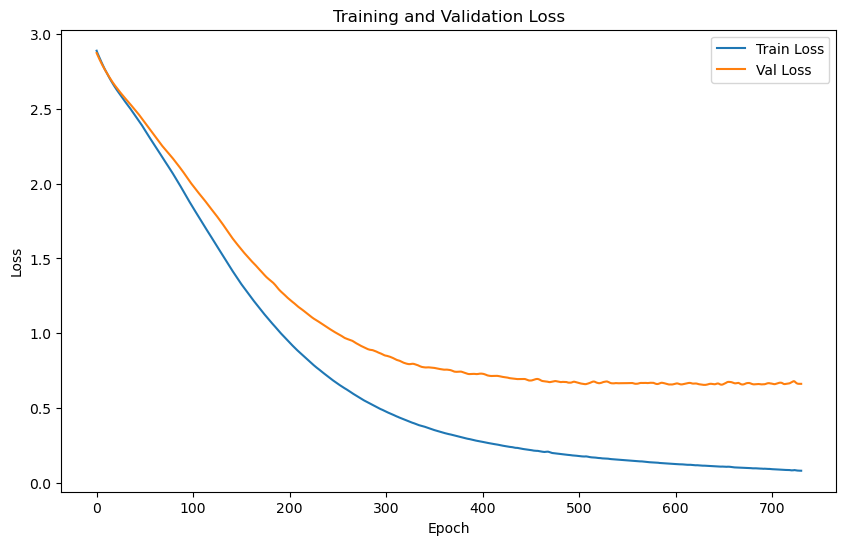

In [45]:
tscl_mlp_input_dim = tscl_mlp_train_reps.shape[1]
tscl_mlp_num_classes = len(torch.unique(tscl_mlp_train_labels_torch))
tscl_mlp_model = MLPClassifier(tscl_mlp_input_dim, tscl_mlp_num_classes).to(device)

tscl_mlp_criterion = nn.CrossEntropyLoss()
tscl_mlp_optimizer = optim.Adam(tscl_mlp_model.parameters(), lr=1e-4)

tscl_mlp_num_epochs = 1000
tscl_mlp_patience = 100

tscl_mlp_train_losses = []
tscl_mlp_val_losses = []

tscl_mlp_best_val_loss = float('inf')
tscl_mlp_epochs_without_improvement = 0

for tscl_mlp_epoch in range(tscl_mlp_num_epochs):
    # Training
    tscl_mlp_model.train()
    tscl_mlp_train_running_loss = 0.0
    
    for tscl_mlp_embeddings_batch, tscl_mlp_labels_batch in tscl_mlp_train_loader:
        tscl_mlp_embeddings_batch = tscl_mlp_embeddings_batch.to(device)
        tscl_mlp_labels_batch = tscl_mlp_labels_batch.to(device)
        
        tscl_mlp_optimizer.zero_grad()
        
        # Forward
        tscl_mlp_outputs = tscl_mlp_model(tscl_mlp_embeddings_batch)
        tscl_mlp_loss = tscl_mlp_criterion(tscl_mlp_outputs, tscl_mlp_labels_batch)
        
        # Backward & Update
        tscl_mlp_loss.backward()
        tscl_mlp_optimizer.step()
        
        tscl_mlp_train_running_loss += tscl_mlp_loss.item() * tscl_mlp_embeddings_batch.size(0)
    
    tscl_mlp_epoch_train_loss = tscl_mlp_train_running_loss / len(tscl_mlp_train_loader.dataset)
    tscl_mlp_train_losses.append(tscl_mlp_epoch_train_loss)

    # Validation
    tscl_mlp_model.eval()
    tscl_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for tscl_mlp_val_embeddings_batch, tscl_mlp_val_labels_batch in tscl_mlp_val_loader:
            tscl_mlp_val_embeddings_batch = tscl_mlp_val_embeddings_batch.to(device)
            tscl_mlp_val_labels_batch = tscl_mlp_val_labels_batch.to(device)

            tscl_mlp_val_outputs = tscl_mlp_model(tscl_mlp_val_embeddings_batch)
            tscl_mlp_val_loss = tscl_mlp_criterion(tscl_mlp_val_outputs, tscl_mlp_val_labels_batch)

            tscl_mlp_val_running_loss += tscl_mlp_val_loss.item() * tscl_mlp_val_embeddings_batch.size(0)

    tscl_mlp_epoch_val_loss = tscl_mlp_val_running_loss / len(tscl_mlp_val_loader.dataset)
    tscl_mlp_val_losses.append(tscl_mlp_epoch_val_loss)

    print(f"[Epoch {tscl_mlp_epoch+1}/{tscl_mlp_num_epochs}] "
          f"Train Loss: {tscl_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {tscl_mlp_epoch_val_loss:.4f}")

    # Early stopping
    if tscl_mlp_epoch_val_loss < tscl_mlp_best_val_loss:
        print(f"Validation loss improved from {tscl_mlp_best_val_loss:.4f} to {tscl_mlp_epoch_val_loss:.4f}.")
        tscl_mlp_best_val_loss = tscl_mlp_epoch_val_loss
        tscl_mlp_epochs_without_improvement = 0

    else:
        # no improvement
        tscl_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {tscl_mlp_epochs_without_improvement}/{tscl_mlp_patience}")
        
        if tscl_mlp_epochs_without_improvement >= tscl_mlp_patience:
            print(f"!! Early stopping triggered at epoch {tscl_mlp_epoch+1} !!\n"
                  f"No improvement for {tscl_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(tscl_mlp_train_losses, label='Train Loss')
plt.plot(tscl_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved TSCL+MLP predictions and true labels to model_predictions
Test Loss: 0.9245 | Test Accuracy: 79.79%


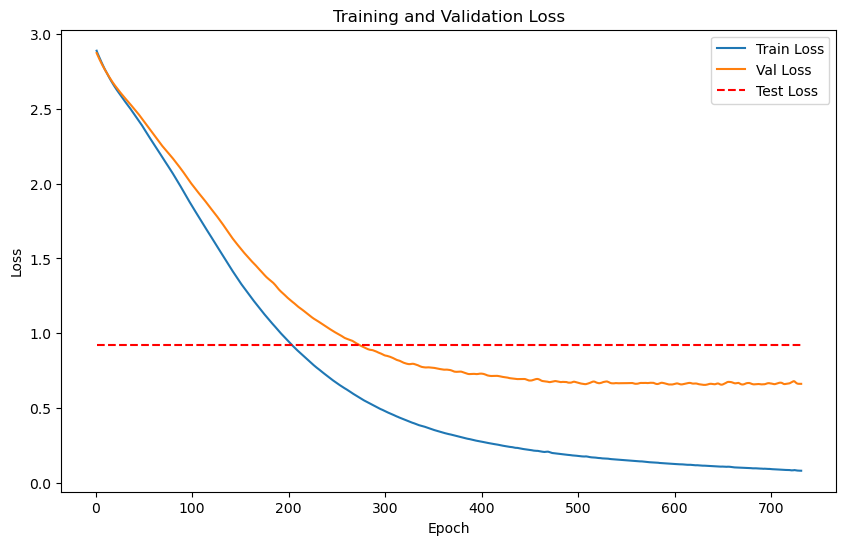

In [46]:
tscl_mlp_model.eval()

tscl_mlp_test_running_loss = 0.0
tscl_mlp_test_correct = 0
tscl_mlp_all_predictions = []
tscl_mlp_all_true_labels = []

with torch.no_grad():
    for tscl_mlp_test_embeddings_batch, tscl_mlp_test_labels_batch in tscl_mlp_test_loader:
        tscl_mlp_test_embeddings_batch = tscl_mlp_test_embeddings_batch.to(device)
        tscl_mlp_test_labels_batch = tscl_mlp_test_labels_batch.to(device)

        tscl_mlp_test_outputs = tscl_mlp_model(tscl_mlp_test_embeddings_batch)
        
        tscl_mlp_test_loss_batch = tscl_mlp_criterion(tscl_mlp_test_outputs, tscl_mlp_test_labels_batch)
        tscl_mlp_test_running_loss += tscl_mlp_test_loss_batch.item() * tscl_mlp_test_embeddings_batch.size(0)

        _, tscl_mlp_test_predicted = torch.max(tscl_mlp_test_outputs, dim=1)
        tscl_mlp_test_correct += (tscl_mlp_test_predicted == tscl_mlp_test_labels_batch).sum().item()

        tscl_mlp_all_predictions.extend(tscl_mlp_test_predicted.cpu().numpy())
        tscl_mlp_all_true_labels.extend(tscl_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'tscl_mlp_predictions.npy'), np.array(tscl_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'tscl_mlp_true_labels.npy'), np.array(tscl_mlp_all_true_labels))
print(f"Saved TSCL+MLP predictions and true labels to {predictions_dir}")

tscl_mlp_epoch_test_loss = tscl_mlp_test_running_loss / len(tscl_mlp_test_loader.dataset)
tscl_mlp_test_accuracy = tscl_mlp_test_correct / len(tscl_mlp_test_loader.dataset)

tscl_mlp_test_accuracy_pct = tscl_mlp_test_accuracy * 100.0

print(f"Test Loss: {tscl_mlp_epoch_test_loss:.4f} | Test Accuracy: {tscl_mlp_test_accuracy_pct:.2f}%")

tscl_mlp_num_epochs_run = len(tscl_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         tscl_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         tscl_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         [tscl_mlp_epoch_test_loss]*tscl_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


## Model - Supervised Contrastive Learning with Silhouette Distance Loss

In [47]:
sclsdl_encoded_train_dir = os.path.join(encoded_dir, 'train')
sclsdl_encoded_val_dir = os.path.join(encoded_dir, 'val')
sclsdl_encoded_test_dir = os.path.join(encoded_dir, 'test')

sclsdl_train_embeddings, sclsdl_train_labels = load_encoded_data(sclsdl_encoded_train_dir)
sclsdl_val_embeddings, sclsdl_val_labels = load_encoded_data(sclsdl_encoded_val_dir)
sclsdl_test_embeddings, sclsdl_test_labels = load_encoded_data(sclsdl_encoded_test_dir)

#shape verification
print(f"\n\nTrain embeddings shape: {sclsdl_train_embeddings.shape}, \nTrain labels shape: {sclsdl_train_labels.shape}")
print(f"\n\nVal embeddings shape: {sclsdl_val_embeddings.shape}, \nVal labels shape: {sclsdl_val_labels.shape}")
print(f"\n\nTest embeddings shape: {sclsdl_test_embeddings.shape}, \nTest labels shape: {sclsdl_test_labels.shape}")

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 80 samples with 64 features each
LOG: Labels shape: (80,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 80 samples with 64 features each
LOG: Labels shape: (80,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 53969 samples with 64 features each
LOG: Labels shape: (53969,)


Train embeddings shape: (80, 64), 
Train labels shape: (80,)


Val embeddings shape: (80, 64), 
Val labels shape: (80,)


Test embeddings shape: (53969, 64), 
Test labels shape: (53969,)


In [48]:
#flattening embeddings to (num_samples, 64)
sclsdl_train_embeddings = sclsdl_train_embeddings.reshape(sclsdl_train_embeddings.shape[0], -1)
sclsdl_val_embeddings = sclsdl_val_embeddings.reshape(sclsdl_val_embeddings.shape[0], -1)
sclsdl_test_embeddings = sclsdl_test_embeddings.reshape(sclsdl_test_embeddings.shape[0], -1)

#compute mean and std from training set
sclsdl_train_mean = np.mean(sclsdl_train_embeddings, axis=0)
sclsdl_train_std = np.std(sclsdl_train_embeddings, axis=0)

#normalize all datasets from above training mean and std
#sclsdl_train_embeddings = (sclsdl_train_embeddings - sclsdl_train_mean) / sclsdl_train_std
#sclsdl_val_embeddings = (sclsdl_val_embeddings - sclsdl_train_mean) / sclsdl_train_std
#sclsdl_test_embeddings = (sclsdl_test_embeddings - sclsdl_train_mean) / sclsdl_train_std

sclsdl_train_dataset = TensorDataset(torch.tensor(sclsdl_train_embeddings, dtype=torch.float32), torch.tensor(sclsdl_train_labels, dtype=torch.long))
sclsdl_val_dataset = TensorDataset(torch.tensor(sclsdl_val_embeddings, dtype=torch.float32), torch.tensor(sclsdl_val_labels, dtype=torch.long))
sclsdl_test_dataset = TensorDataset(torch.tensor(sclsdl_test_embeddings, dtype=torch.float32), torch.tensor(sclsdl_test_labels, dtype=torch.long))


sclsdl_m = 20
sclsdl_num_classes = len(np.unique(sclsdl_train_labels))

# calc theoretical required batch size
sclsdl_required_batch_size = sclsdl_m * sclsdl_num_classes

if sclsdl_required_batch_size > len(sclsdl_train_dataset):
    sclsdl_max_possible_m = len(sclsdl_train_dataset) // sclsdl_num_classes
    sclsdl_m = max(1, sclsdl_max_possible_m)
    sclsdl_batch_size_train = sclsdl_m * sclsdl_num_classes
else:
    sclsdl_batch_size_train = sclsdl_required_batch_size

sclsdl_sampler = MPerClassSampler(labels = sclsdl_train_labels, m = sclsdl_m, batch_size = sclsdl_batch_size_train, length_before_new_iter=len(sclsdl_train_dataset))
sclsdl_train_loader = DataLoader(sclsdl_train_dataset, batch_size=sclsdl_batch_size_train, sampler=sclsdl_sampler)

#creating dataloaders for scl
sclsdl_dataloader_bs = 64
sclsdl_val_loader = DataLoader(sclsdl_val_dataset, batch_size=sclsdl_dataloader_bs, shuffle=False)
sclsdl_test_loader = DataLoader(sclsdl_test_dataset, batch_size=sclsdl_dataloader_bs, shuffle=False)

for sclsdl_X_batch, sclsdl_y_batch in sclsdl_train_loader:
    sclsdl_unique, sclsdl_counts = np.unique(y_batch.numpy(), return_counts=True)
    print("Class distribution in batch:", dict(zip(sclsdl_unique, sclsdl_counts)))
    print(f"Training batch size: {sclsdl_batch_size_train}")
    break


Class distribution in batch: {0: 5, 1: 5, 2: 5, 3: 5, 4: 5, 5: 5, 6: 5, 7: 5, 8: 5, 9: 5, 10: 5, 11: 5, 12: 5, 13: 5, 14: 5, 15: 5}
Training batch size: 80


In [49]:
class SupConNet(nn.Module):
    def __init__(self, feature_dim=128):
        super(SupConNet, self).__init__()
        self.projection_head = nn.Sequential(
            nn.Linear(64, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, feature_dim)
        )

    def forward(self, x):
        return self.projection_head(x)

In [50]:
class SilhouetteDistanceLoss(nn.Module):
    def __init__(self):
        super(SilhouetteDistanceLoss, self).__init__()

    def forward(self, features, labels):
        return self.score(features, labels, True,True)

    def score(self,X, labels,feature_norm=True, loss=False):
        unique_labels = torch.unique(labels)
        if feature_norm:
            X= F.normalize(X, p=2, dim=1)


        A, B = self._compute_distances(X, labels, unique_labels)

        # A= scale*A
        # B = (1-scale)*B
        sil_samples = (B - A) / torch.clamp(torch.maximum(A, B), min=0.0001)

        # nan values are for clusters of size 1, and should be 0
        mean_sil_score = torch.mean(torch.nan_to_num(sil_samples))
        if loss:
            return (1 - mean_sil_score) / 2
        else:
            return mean_sil_score.item()


    def _compute_distances(self,X, labels, unique_labels):
        intra_dist = torch.zeros_like(labels, dtype=torch.float32)
        inter_dist = torch.full_like(labels, torch.inf, dtype=torch.float32)

        for i, label_a in enumerate(unique_labels):
            cluster_indices_a = (labels == label_a)
            subX_a = X[cluster_indices_a]


            intra_distances_a = torch.cdist(subX_a, subX_a)
            div = (subX_a.size(0) - 1) if subX_a.shape[0]>1 else 1
            intra_dist[cluster_indices_a] = intra_distances_a.sum(dim=1) / div

            for label_b in unique_labels[i + 1:]:
                cluster_indices_b = (labels == label_b)
                subX_b = X[cluster_indices_b]
                inter_distances_ab = torch.cdist(subX_a, subX_b)
                inter_distances_ba = torch.cdist(subX_b, subX_a)

                inter_dist[cluster_indices_a] = torch.minimum(inter_distances_ab.mean(dim=1), inter_dist[cluster_indices_a])
                inter_dist[cluster_indices_b] = torch.minimum(inter_distances_ba.mean(dim=1), inter_dist[cluster_indices_b])

        return intra_dist, inter_dist

LOG: Epoch [1/2000] - Training


    Batch [1/1], Train Loss: 0.4605
LOG: Epoch [1/2000] - Validation
    Batch [1/2], Val Loss: 0.3431
    Batch [2/2], Val Loss: 0.4782
Epoch [1/2000], Avg Train Loss: 0.4605, Avg Val Loss: 0.4106

Validation loss improved from inf to 0.4106. Saving model...
LOG: Epoch [2/2000] - Training


    Batch [1/1], Train Loss: 0.4575
LOG: Epoch [2/2000] - Validation
    Batch [1/2], Val Loss: 0.3437
    Batch [2/2], Val Loss: 0.4746
Epoch [2/2000], Avg Train Loss: 0.4575, Avg Val Loss: 0.4091

Validation loss improved from 0.4106 to 0.4091. Saving model...
LOG: Epoch [3/2000] - Training


    Batch [1/1], Train Loss: 0.4499
LOG: Epoch [3/2000] - Validation
    Batch [1/2], Val Loss: 0.3450
    Batch [2/2], Val Loss: 0.4705
Epoch [3/2000], Avg Train Loss: 0.4499, Avg Val Loss: 0.4077

Validation loss improved from 0.4091 to 0.4077. Saving model...
LOG: Epoch [4/2000] - Training


    Batch [1/1], Train Loss: 0.4446
LOG: Epoch [4/2000] - Validation
    Batch [1/2], Val Loss: 0.3466
    Batch [2/2], Val Loss: 0.4664
Epoch [4/2000], Avg Train Loss: 0.4446, Avg Val Loss: 0.4065

Validation loss improved from 0.4077 to 0.4065. Saving model...
LOG: Epoch [5/2000] - Training


    Batch [1/1], Train Loss: 0.4531
LOG: Epoch [5/2000] - Validation
    Batch [1/2], Val Loss: 0.3484
    Batch [2/2], Val Loss: 0.4622
Epoch [5/2000], Avg Train Loss: 0.4531, Avg Val Loss: 0.4053

Validation loss improved from 0.4065 to 0.4053. Saving model...
LOG: Epoch [6/2000] - Training


    Batch [1/1], Train Loss: 0.4548
LOG: Epoch [6/2000] - Validation
    Batch [1/2], Val Loss: 0.3502
    Batch [2/2], Val Loss: 0.4573
Epoch [6/2000], Avg Train Loss: 0.4548, Avg Val Loss: 0.4037

Validation loss improved from 0.4053 to 0.4037. Saving model...
LOG: Epoch [7/2000] - Training


    Batch [1/1], Train Loss: 0.4442
LOG: Epoch [7/2000] - Validation
    Batch [1/2], Val Loss: 0.3516
    Batch [2/2], Val Loss: 0.4524
Epoch [7/2000], Avg Train Loss: 0.4442, Avg Val Loss: 0.4020

Validation loss improved from 0.4037 to 0.4020. Saving model...
LOG: Epoch [8/2000] - Training


    Batch [1/1], Train Loss: 0.4498
LOG: Epoch [8/2000] - Validation
    Batch [1/2], Val Loss: 0.3532
    Batch [2/2], Val Loss: 0.4477
Epoch [8/2000], Avg Train Loss: 0.4498, Avg Val Loss: 0.4005

Validation loss improved from 0.4020 to 0.4005. Saving model...
LOG: Epoch [9/2000] - Training


    Batch [1/1], Train Loss: 0.4516
LOG: Epoch [9/2000] - Validation
    Batch [1/2], Val Loss: 0.3540
    Batch [2/2], Val Loss: 0.4426
Epoch [9/2000], Avg Train Loss: 0.4516, Avg Val Loss: 0.3983

Validation loss improved from 0.4005 to 0.3983. Saving model...
LOG: Epoch [10/2000] - Training


    Batch [1/1], Train Loss: 0.4427
LOG: Epoch [10/2000] - Validation
    Batch [1/2], Val Loss: 0.3544
    Batch [2/2], Val Loss: 0.4377
Epoch [10/2000], Avg Train Loss: 0.4427, Avg Val Loss: 0.3960

Validation loss improved from 0.3983 to 0.3960. Saving model...
LOG: Epoch [11/2000] - Training


    Batch [1/1], Train Loss: 0.4447
LOG: Epoch [11/2000] - Validation
    Batch [1/2], Val Loss: 0.3548
    Batch [2/2], Val Loss: 0.4337
Epoch [11/2000], Avg Train Loss: 0.4447, Avg Val Loss: 0.3943

Validation loss improved from 0.3960 to 0.3943. Saving model...
LOG: Epoch [12/2000] - Training


    Batch [1/1], Train Loss: 0.4506
LOG: Epoch [12/2000] - Validation
    Batch [1/2], Val Loss: 0.3543
    Batch [2/2], Val Loss: 0.4305
Epoch [12/2000], Avg Train Loss: 0.4506, Avg Val Loss: 0.3924

Validation loss improved from 0.3943 to 0.3924. Saving model...
LOG: Epoch [13/2000] - Training


    Batch [1/1], Train Loss: 0.4471
LOG: Epoch [13/2000] - Validation
    Batch [1/2], Val Loss: 0.3533
    Batch [2/2], Val Loss: 0.4281
Epoch [13/2000], Avg Train Loss: 0.4471, Avg Val Loss: 0.3907

Validation loss improved from 0.3924 to 0.3907. Saving model...
LOG: Epoch [14/2000] - Training


    Batch [1/1], Train Loss: 0.4421
LOG: Epoch [14/2000] - Validation
    Batch [1/2], Val Loss: 0.3521
    Batch [2/2], Val Loss: 0.4261
Epoch [14/2000], Avg Train Loss: 0.4421, Avg Val Loss: 0.3891

Validation loss improved from 0.3907 to 0.3891. Saving model...
LOG: Epoch [15/2000] - Training


    Batch [1/1], Train Loss: 0.4492
LOG: Epoch [15/2000] - Validation
    Batch [1/2], Val Loss: 0.3508
    Batch [2/2], Val Loss: 0.4242
Epoch [15/2000], Avg Train Loss: 0.4492, Avg Val Loss: 0.3875

Validation loss improved from 0.3891 to 0.3875. Saving model...
LOG: Epoch [16/2000] - Training


    Batch [1/1], Train Loss: 0.4431
LOG: Epoch [16/2000] - Validation
    Batch [1/2], Val Loss: 0.3495
    Batch [2/2], Val Loss: 0.4220
Epoch [16/2000], Avg Train Loss: 0.4431, Avg Val Loss: 0.3858

Validation loss improved from 0.3875 to 0.3858. Saving model...
LOG: Epoch [17/2000] - Training


    Batch [1/1], Train Loss: 0.4481
LOG: Epoch [17/2000] - Validation
    Batch [1/2], Val Loss: 0.3482
    Batch [2/2], Val Loss: 0.4201
Epoch [17/2000], Avg Train Loss: 0.4481, Avg Val Loss: 0.3841

Validation loss improved from 0.3858 to 0.3841. Saving model...
LOG: Epoch [18/2000] - Training


    Batch [1/1], Train Loss: 0.4457
LOG: Epoch [18/2000] - Validation
    Batch [1/2], Val Loss: 0.3464
    Batch [2/2], Val Loss: 0.4182
Epoch [18/2000], Avg Train Loss: 0.4457, Avg Val Loss: 0.3823

Validation loss improved from 0.3841 to 0.3823. Saving model...
LOG: Epoch [19/2000] - Training


    Batch [1/1], Train Loss: 0.4407
LOG: Epoch [19/2000] - Validation
    Batch [1/2], Val Loss: 0.3446
    Batch [2/2], Val Loss: 0.4171
Epoch [19/2000], Avg Train Loss: 0.4407, Avg Val Loss: 0.3808

Validation loss improved from 0.3823 to 0.3808. Saving model...
LOG: Epoch [20/2000] - Training


    Batch [1/1], Train Loss: 0.4393
LOG: Epoch [20/2000] - Validation
    Batch [1/2], Val Loss: 0.3427
    Batch [2/2], Val Loss: 0.4162
Epoch [20/2000], Avg Train Loss: 0.4393, Avg Val Loss: 0.3794

Validation loss improved from 0.3808 to 0.3794. Saving model...
LOG: Epoch [21/2000] - Training


    Batch [1/1], Train Loss: 0.4406
LOG: Epoch [21/2000] - Validation
    Batch [1/2], Val Loss: 0.3409
    Batch [2/2], Val Loss: 0.4153
Epoch [21/2000], Avg Train Loss: 0.4406, Avg Val Loss: 0.3781

Validation loss improved from 0.3794 to 0.3781. Saving model...
LOG: Epoch [22/2000] - Training


    Batch [1/1], Train Loss: 0.4369
LOG: Epoch [22/2000] - Validation
    Batch [1/2], Val Loss: 0.3394
    Batch [2/2], Val Loss: 0.4145
Epoch [22/2000], Avg Train Loss: 0.4369, Avg Val Loss: 0.3769

Validation loss improved from 0.3781 to 0.3769. Saving model...
LOG: Epoch [23/2000] - Training


    Batch [1/1], Train Loss: 0.4299
LOG: Epoch [23/2000] - Validation
    Batch [1/2], Val Loss: 0.3380
    Batch [2/2], Val Loss: 0.4135
Epoch [23/2000], Avg Train Loss: 0.4299, Avg Val Loss: 0.3757

Validation loss improved from 0.3769 to 0.3757. Saving model...
LOG: Epoch [24/2000] - Training


    Batch [1/1], Train Loss: 0.4323
LOG: Epoch [24/2000] - Validation
    Batch [1/2], Val Loss: 0.3368
    Batch [2/2], Val Loss: 0.4124
Epoch [24/2000], Avg Train Loss: 0.4323, Avg Val Loss: 0.3746

Validation loss improved from 0.3757 to 0.3746. Saving model...
LOG: Epoch [25/2000] - Training


    Batch [1/1], Train Loss: 0.4367
LOG: Epoch [25/2000] - Validation
    Batch [1/2], Val Loss: 0.3356
    Batch [2/2], Val Loss: 0.4116
Epoch [25/2000], Avg Train Loss: 0.4367, Avg Val Loss: 0.3736

Validation loss improved from 0.3746 to 0.3736. Saving model...
LOG: Epoch [26/2000] - Training


    Batch [1/1], Train Loss: 0.4381
LOG: Epoch [26/2000] - Validation
    Batch [1/2], Val Loss: 0.3343
    Batch [2/2], Val Loss: 0.4111
Epoch [26/2000], Avg Train Loss: 0.4381, Avg Val Loss: 0.3727

Validation loss improved from 0.3736 to 0.3727. Saving model...
LOG: Epoch [27/2000] - Training


    Batch [1/1], Train Loss: 0.4257
LOG: Epoch [27/2000] - Validation
    Batch [1/2], Val Loss: 0.3329
    Batch [2/2], Val Loss: 0.4106
Epoch [27/2000], Avg Train Loss: 0.4257, Avg Val Loss: 0.3718

Validation loss improved from 0.3727 to 0.3718. Saving model...
LOG: Epoch [28/2000] - Training


    Batch [1/1], Train Loss: 0.4329
LOG: Epoch [28/2000] - Validation
    Batch [1/2], Val Loss: 0.3317
    Batch [2/2], Val Loss: 0.4102
Epoch [28/2000], Avg Train Loss: 0.4329, Avg Val Loss: 0.3709

Validation loss improved from 0.3718 to 0.3709. Saving model...
LOG: Epoch [29/2000] - Training


    Batch [1/1], Train Loss: 0.4280
LOG: Epoch [29/2000] - Validation
    Batch [1/2], Val Loss: 0.3304
    Batch [2/2], Val Loss: 0.4097
Epoch [29/2000], Avg Train Loss: 0.4280, Avg Val Loss: 0.3701

Validation loss improved from 0.3709 to 0.3701. Saving model...
LOG: Epoch [30/2000] - Training


    Batch [1/1], Train Loss: 0.4325
LOG: Epoch [30/2000] - Validation
    Batch [1/2], Val Loss: 0.3292
    Batch [2/2], Val Loss: 0.4092
Epoch [30/2000], Avg Train Loss: 0.4325, Avg Val Loss: 0.3692

Validation loss improved from 0.3701 to 0.3692. Saving model...
LOG: Epoch [31/2000] - Training


    Batch [1/1], Train Loss: 0.4390
LOG: Epoch [31/2000] - Validation
    Batch [1/2], Val Loss: 0.3281
    Batch [2/2], Val Loss: 0.4088
Epoch [31/2000], Avg Train Loss: 0.4390, Avg Val Loss: 0.3685

Validation loss improved from 0.3692 to 0.3685. Saving model...
LOG: Epoch [32/2000] - Training


    Batch [1/1], Train Loss: 0.4327
LOG: Epoch [32/2000] - Validation
    Batch [1/2], Val Loss: 0.3270
    Batch [2/2], Val Loss: 0.4086
Epoch [32/2000], Avg Train Loss: 0.4327, Avg Val Loss: 0.3678

Validation loss improved from 0.3685 to 0.3678. Saving model...
LOG: Epoch [33/2000] - Training


    Batch [1/1], Train Loss: 0.4311
LOG: Epoch [33/2000] - Validation
    Batch [1/2], Val Loss: 0.3260
    Batch [2/2], Val Loss: 0.4085
Epoch [33/2000], Avg Train Loss: 0.4311, Avg Val Loss: 0.3672

Validation loss improved from 0.3678 to 0.3672. Saving model...
LOG: Epoch [34/2000] - Training


    Batch [1/1], Train Loss: 0.4336
LOG: Epoch [34/2000] - Validation
    Batch [1/2], Val Loss: 0.3250
    Batch [2/2], Val Loss: 0.4083
Epoch [34/2000], Avg Train Loss: 0.4336, Avg Val Loss: 0.3666

Validation loss improved from 0.3672 to 0.3666. Saving model...
LOG: Epoch [35/2000] - Training


    Batch [1/1], Train Loss: 0.4302
LOG: Epoch [35/2000] - Validation
    Batch [1/2], Val Loss: 0.3239
    Batch [2/2], Val Loss: 0.4081
Epoch [35/2000], Avg Train Loss: 0.4302, Avg Val Loss: 0.3660

Validation loss improved from 0.3666 to 0.3660. Saving model...
LOG: Epoch [36/2000] - Training


    Batch [1/1], Train Loss: 0.4250
LOG: Epoch [36/2000] - Validation
    Batch [1/2], Val Loss: 0.3229
    Batch [2/2], Val Loss: 0.4079
Epoch [36/2000], Avg Train Loss: 0.4250, Avg Val Loss: 0.3654

Validation loss improved from 0.3660 to 0.3654. Saving model...
LOG: Epoch [37/2000] - Training


    Batch [1/1], Train Loss: 0.4304
LOG: Epoch [37/2000] - Validation
    Batch [1/2], Val Loss: 0.3219
    Batch [2/2], Val Loss: 0.4078
Epoch [37/2000], Avg Train Loss: 0.4304, Avg Val Loss: 0.3649

Validation loss improved from 0.3654 to 0.3649. Saving model...
LOG: Epoch [38/2000] - Training


    Batch [1/1], Train Loss: 0.4204
LOG: Epoch [38/2000] - Validation
    Batch [1/2], Val Loss: 0.3210
    Batch [2/2], Val Loss: 0.4076
Epoch [38/2000], Avg Train Loss: 0.4204, Avg Val Loss: 0.3643

Validation loss improved from 0.3649 to 0.3643. Saving model...
LOG: Epoch [39/2000] - Training


    Batch [1/1], Train Loss: 0.4179
LOG: Epoch [39/2000] - Validation
    Batch [1/2], Val Loss: 0.3201
    Batch [2/2], Val Loss: 0.4074
Epoch [39/2000], Avg Train Loss: 0.4179, Avg Val Loss: 0.3638

Validation loss improved from 0.3643 to 0.3638. Saving model...
LOG: Epoch [40/2000] - Training


    Batch [1/1], Train Loss: 0.4221
LOG: Epoch [40/2000] - Validation
    Batch [1/2], Val Loss: 0.3193
    Batch [2/2], Val Loss: 0.4072
Epoch [40/2000], Avg Train Loss: 0.4221, Avg Val Loss: 0.3633

Validation loss improved from 0.3638 to 0.3633. Saving model...
LOG: Epoch [41/2000] - Training


    Batch [1/1], Train Loss: 0.4266
LOG: Epoch [41/2000] - Validation
    Batch [1/2], Val Loss: 0.3185
    Batch [2/2], Val Loss: 0.4070
Epoch [41/2000], Avg Train Loss: 0.4266, Avg Val Loss: 0.3628

Validation loss improved from 0.3633 to 0.3628. Saving model...
LOG: Epoch [42/2000] - Training


    Batch [1/1], Train Loss: 0.4193
LOG: Epoch [42/2000] - Validation
    Batch [1/2], Val Loss: 0.3178
    Batch [2/2], Val Loss: 0.4068
Epoch [42/2000], Avg Train Loss: 0.4193, Avg Val Loss: 0.3623

Validation loss improved from 0.3628 to 0.3623. Saving model...
LOG: Epoch [43/2000] - Training


    Batch [1/1], Train Loss: 0.4248
LOG: Epoch [43/2000] - Validation
    Batch [1/2], Val Loss: 0.3170
    Batch [2/2], Val Loss: 0.4065
Epoch [43/2000], Avg Train Loss: 0.4248, Avg Val Loss: 0.3618

Validation loss improved from 0.3623 to 0.3618. Saving model...
LOG: Epoch [44/2000] - Training


    Batch [1/1], Train Loss: 0.4238
LOG: Epoch [44/2000] - Validation
    Batch [1/2], Val Loss: 0.3163
    Batch [2/2], Val Loss: 0.4062
Epoch [44/2000], Avg Train Loss: 0.4238, Avg Val Loss: 0.3612

Validation loss improved from 0.3618 to 0.3612. Saving model...
LOG: Epoch [45/2000] - Training


    Batch [1/1], Train Loss: 0.4192
LOG: Epoch [45/2000] - Validation
    Batch [1/2], Val Loss: 0.3155
    Batch [2/2], Val Loss: 0.4059
Epoch [45/2000], Avg Train Loss: 0.4192, Avg Val Loss: 0.3607

Validation loss improved from 0.3612 to 0.3607. Saving model...
LOG: Epoch [46/2000] - Training


    Batch [1/1], Train Loss: 0.4172
LOG: Epoch [46/2000] - Validation
    Batch [1/2], Val Loss: 0.3148
    Batch [2/2], Val Loss: 0.4056
Epoch [46/2000], Avg Train Loss: 0.4172, Avg Val Loss: 0.3602

Validation loss improved from 0.3607 to 0.3602. Saving model...
LOG: Epoch [47/2000] - Training


    Batch [1/1], Train Loss: 0.4118
LOG: Epoch [47/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.4052
Epoch [47/2000], Avg Train Loss: 0.4118, Avg Val Loss: 0.3596

Validation loss improved from 0.3602 to 0.3596. Saving model...
LOG: Epoch [48/2000] - Training


    Batch [1/1], Train Loss: 0.4186
LOG: Epoch [48/2000] - Validation
    Batch [1/2], Val Loss: 0.3133
    Batch [2/2], Val Loss: 0.4049
Epoch [48/2000], Avg Train Loss: 0.4186, Avg Val Loss: 0.3591

Validation loss improved from 0.3596 to 0.3591. Saving model...
LOG: Epoch [49/2000] - Training


    Batch [1/1], Train Loss: 0.4197
LOG: Epoch [49/2000] - Validation
    Batch [1/2], Val Loss: 0.3127
    Batch [2/2], Val Loss: 0.4045
Epoch [49/2000], Avg Train Loss: 0.4197, Avg Val Loss: 0.3586

Validation loss improved from 0.3591 to 0.3586. Saving model...
LOG: Epoch [50/2000] - Training


    Batch [1/1], Train Loss: 0.4137
LOG: Epoch [50/2000] - Validation
    Batch [1/2], Val Loss: 0.3120
    Batch [2/2], Val Loss: 0.4042
Epoch [50/2000], Avg Train Loss: 0.4137, Avg Val Loss: 0.3581

Validation loss improved from 0.3586 to 0.3581. Saving model...
LOG: Epoch [51/2000] - Training


    Batch [1/1], Train Loss: 0.4033
LOG: Epoch [51/2000] - Validation
    Batch [1/2], Val Loss: 0.3113
    Batch [2/2], Val Loss: 0.4040
Epoch [51/2000], Avg Train Loss: 0.4033, Avg Val Loss: 0.3576

Validation loss improved from 0.3581 to 0.3576. Saving model...
LOG: Epoch [52/2000] - Training


    Batch [1/1], Train Loss: 0.4212
LOG: Epoch [52/2000] - Validation
    Batch [1/2], Val Loss: 0.3107
    Batch [2/2], Val Loss: 0.4037
Epoch [52/2000], Avg Train Loss: 0.4212, Avg Val Loss: 0.3572

Validation loss improved from 0.3576 to 0.3572. Saving model...
LOG: Epoch [53/2000] - Training


    Batch [1/1], Train Loss: 0.4150
LOG: Epoch [53/2000] - Validation
    Batch [1/2], Val Loss: 0.3101
    Batch [2/2], Val Loss: 0.4033
Epoch [53/2000], Avg Train Loss: 0.4150, Avg Val Loss: 0.3567

Validation loss improved from 0.3572 to 0.3567. Saving model...
LOG: Epoch [54/2000] - Training


    Batch [1/1], Train Loss: 0.4132
LOG: Epoch [54/2000] - Validation
    Batch [1/2], Val Loss: 0.3095
    Batch [2/2], Val Loss: 0.4030
Epoch [54/2000], Avg Train Loss: 0.4132, Avg Val Loss: 0.3563

Validation loss improved from 0.3567 to 0.3563. Saving model...
LOG: Epoch [55/2000] - Training


    Batch [1/1], Train Loss: 0.4242
LOG: Epoch [55/2000] - Validation
    Batch [1/2], Val Loss: 0.3089
    Batch [2/2], Val Loss: 0.4027
Epoch [55/2000], Avg Train Loss: 0.4242, Avg Val Loss: 0.3558

Validation loss improved from 0.3563 to 0.3558. Saving model...
LOG: Epoch [56/2000] - Training


    Batch [1/1], Train Loss: 0.4038
LOG: Epoch [56/2000] - Validation
    Batch [1/2], Val Loss: 0.3084
    Batch [2/2], Val Loss: 0.4023
Epoch [56/2000], Avg Train Loss: 0.4038, Avg Val Loss: 0.3554

Validation loss improved from 0.3558 to 0.3554. Saving model...
LOG: Epoch [57/2000] - Training


    Batch [1/1], Train Loss: 0.4091
LOG: Epoch [57/2000] - Validation
    Batch [1/2], Val Loss: 0.3078
    Batch [2/2], Val Loss: 0.4020
Epoch [57/2000], Avg Train Loss: 0.4091, Avg Val Loss: 0.3549

Validation loss improved from 0.3554 to 0.3549. Saving model...
LOG: Epoch [58/2000] - Training


    Batch [1/1], Train Loss: 0.4096
LOG: Epoch [58/2000] - Validation
    Batch [1/2], Val Loss: 0.3073
    Batch [2/2], Val Loss: 0.4017
Epoch [58/2000], Avg Train Loss: 0.4096, Avg Val Loss: 0.3545

Validation loss improved from 0.3549 to 0.3545. Saving model...
LOG: Epoch [59/2000] - Training


    Batch [1/1], Train Loss: 0.4070
LOG: Epoch [59/2000] - Validation
    Batch [1/2], Val Loss: 0.3067
    Batch [2/2], Val Loss: 0.4014
Epoch [59/2000], Avg Train Loss: 0.4070, Avg Val Loss: 0.3541

Validation loss improved from 0.3545 to 0.3541. Saving model...
LOG: Epoch [60/2000] - Training


    Batch [1/1], Train Loss: 0.4102
LOG: Epoch [60/2000] - Validation
    Batch [1/2], Val Loss: 0.3061
    Batch [2/2], Val Loss: 0.4012
Epoch [60/2000], Avg Train Loss: 0.4102, Avg Val Loss: 0.3537

Validation loss improved from 0.3541 to 0.3537. Saving model...
LOG: Epoch [61/2000] - Training


    Batch [1/1], Train Loss: 0.4081
LOG: Epoch [61/2000] - Validation
    Batch [1/2], Val Loss: 0.3056
    Batch [2/2], Val Loss: 0.4009
Epoch [61/2000], Avg Train Loss: 0.4081, Avg Val Loss: 0.3533

Validation loss improved from 0.3537 to 0.3533. Saving model...
LOG: Epoch [62/2000] - Training


    Batch [1/1], Train Loss: 0.4119
LOG: Epoch [62/2000] - Validation
    Batch [1/2], Val Loss: 0.3051
    Batch [2/2], Val Loss: 0.4006
Epoch [62/2000], Avg Train Loss: 0.4119, Avg Val Loss: 0.3529

Validation loss improved from 0.3533 to 0.3529. Saving model...
LOG: Epoch [63/2000] - Training


    Batch [1/1], Train Loss: 0.4124
LOG: Epoch [63/2000] - Validation
    Batch [1/2], Val Loss: 0.3046
    Batch [2/2], Val Loss: 0.4003
Epoch [63/2000], Avg Train Loss: 0.4124, Avg Val Loss: 0.3525

Validation loss improved from 0.3529 to 0.3525. Saving model...
LOG: Epoch [64/2000] - Training


    Batch [1/1], Train Loss: 0.4049
LOG: Epoch [64/2000] - Validation
    Batch [1/2], Val Loss: 0.3041
    Batch [2/2], Val Loss: 0.4000
Epoch [64/2000], Avg Train Loss: 0.4049, Avg Val Loss: 0.3521

Validation loss improved from 0.3525 to 0.3521. Saving model...
LOG: Epoch [65/2000] - Training


    Batch [1/1], Train Loss: 0.3935
LOG: Epoch [65/2000] - Validation
    Batch [1/2], Val Loss: 0.3035
    Batch [2/2], Val Loss: 0.3997
Epoch [65/2000], Avg Train Loss: 0.3935, Avg Val Loss: 0.3516

Validation loss improved from 0.3521 to 0.3516. Saving model...
LOG: Epoch [66/2000] - Training


    Batch [1/1], Train Loss: 0.4094
LOG: Epoch [66/2000] - Validation
    Batch [1/2], Val Loss: 0.3030
    Batch [2/2], Val Loss: 0.3994
Epoch [66/2000], Avg Train Loss: 0.4094, Avg Val Loss: 0.3512

Validation loss improved from 0.3516 to 0.3512. Saving model...
LOG: Epoch [67/2000] - Training


    Batch [1/1], Train Loss: 0.3999
LOG: Epoch [67/2000] - Validation
    Batch [1/2], Val Loss: 0.3025
    Batch [2/2], Val Loss: 0.3990
Epoch [67/2000], Avg Train Loss: 0.3999, Avg Val Loss: 0.3507

Validation loss improved from 0.3512 to 0.3507. Saving model...
LOG: Epoch [68/2000] - Training


    Batch [1/1], Train Loss: 0.4010
LOG: Epoch [68/2000] - Validation
    Batch [1/2], Val Loss: 0.3019
    Batch [2/2], Val Loss: 0.3986
Epoch [68/2000], Avg Train Loss: 0.4010, Avg Val Loss: 0.3502

Validation loss improved from 0.3507 to 0.3502. Saving model...
LOG: Epoch [69/2000] - Training


    Batch [1/1], Train Loss: 0.3910
LOG: Epoch [69/2000] - Validation
    Batch [1/2], Val Loss: 0.3014
    Batch [2/2], Val Loss: 0.3982
Epoch [69/2000], Avg Train Loss: 0.3910, Avg Val Loss: 0.3498

Validation loss improved from 0.3502 to 0.3498. Saving model...
LOG: Epoch [70/2000] - Training


    Batch [1/1], Train Loss: 0.4063
LOG: Epoch [70/2000] - Validation
    Batch [1/2], Val Loss: 0.3009
    Batch [2/2], Val Loss: 0.3978
Epoch [70/2000], Avg Train Loss: 0.4063, Avg Val Loss: 0.3493

Validation loss improved from 0.3498 to 0.3493. Saving model...
LOG: Epoch [71/2000] - Training


    Batch [1/1], Train Loss: 0.3971
LOG: Epoch [71/2000] - Validation
    Batch [1/2], Val Loss: 0.3004
    Batch [2/2], Val Loss: 0.3975
Epoch [71/2000], Avg Train Loss: 0.3971, Avg Val Loss: 0.3489

Validation loss improved from 0.3493 to 0.3489. Saving model...
LOG: Epoch [72/2000] - Training


    Batch [1/1], Train Loss: 0.4020
LOG: Epoch [72/2000] - Validation
    Batch [1/2], Val Loss: 0.2999
    Batch [2/2], Val Loss: 0.3971
Epoch [72/2000], Avg Train Loss: 0.4020, Avg Val Loss: 0.3485

Validation loss improved from 0.3489 to 0.3485. Saving model...
LOG: Epoch [73/2000] - Training


    Batch [1/1], Train Loss: 0.4155
LOG: Epoch [73/2000] - Validation
    Batch [1/2], Val Loss: 0.2994
    Batch [2/2], Val Loss: 0.3968
Epoch [73/2000], Avg Train Loss: 0.4155, Avg Val Loss: 0.3481

Validation loss improved from 0.3485 to 0.3481. Saving model...
LOG: Epoch [74/2000] - Training


    Batch [1/1], Train Loss: 0.4026
LOG: Epoch [74/2000] - Validation
    Batch [1/2], Val Loss: 0.2989
    Batch [2/2], Val Loss: 0.3964
Epoch [74/2000], Avg Train Loss: 0.4026, Avg Val Loss: 0.3477

Validation loss improved from 0.3481 to 0.3477. Saving model...
LOG: Epoch [75/2000] - Training


    Batch [1/1], Train Loss: 0.3963
LOG: Epoch [75/2000] - Validation
    Batch [1/2], Val Loss: 0.2984
    Batch [2/2], Val Loss: 0.3961
Epoch [75/2000], Avg Train Loss: 0.3963, Avg Val Loss: 0.3472

Validation loss improved from 0.3477 to 0.3472. Saving model...
LOG: Epoch [76/2000] - Training


    Batch [1/1], Train Loss: 0.4008
LOG: Epoch [76/2000] - Validation
    Batch [1/2], Val Loss: 0.2979
    Batch [2/2], Val Loss: 0.3957
Epoch [76/2000], Avg Train Loss: 0.4008, Avg Val Loss: 0.3468

Validation loss improved from 0.3472 to 0.3468. Saving model...
LOG: Epoch [77/2000] - Training


    Batch [1/1], Train Loss: 0.3996
LOG: Epoch [77/2000] - Validation
    Batch [1/2], Val Loss: 0.2974
    Batch [2/2], Val Loss: 0.3953
Epoch [77/2000], Avg Train Loss: 0.3996, Avg Val Loss: 0.3464

Validation loss improved from 0.3468 to 0.3464. Saving model...
LOG: Epoch [78/2000] - Training


    Batch [1/1], Train Loss: 0.4023
LOG: Epoch [78/2000] - Validation
    Batch [1/2], Val Loss: 0.2970
    Batch [2/2], Val Loss: 0.3949
Epoch [78/2000], Avg Train Loss: 0.4023, Avg Val Loss: 0.3459

Validation loss improved from 0.3464 to 0.3459. Saving model...
LOG: Epoch [79/2000] - Training


    Batch [1/1], Train Loss: 0.3963
LOG: Epoch [79/2000] - Validation
    Batch [1/2], Val Loss: 0.2966
    Batch [2/2], Val Loss: 0.3945
Epoch [79/2000], Avg Train Loss: 0.3963, Avg Val Loss: 0.3455

Validation loss improved from 0.3459 to 0.3455. Saving model...
LOG: Epoch [80/2000] - Training


    Batch [1/1], Train Loss: 0.3919
LOG: Epoch [80/2000] - Validation
    Batch [1/2], Val Loss: 0.2962
    Batch [2/2], Val Loss: 0.3941
Epoch [80/2000], Avg Train Loss: 0.3919, Avg Val Loss: 0.3451

Validation loss improved from 0.3455 to 0.3451. Saving model...
LOG: Epoch [81/2000] - Training


    Batch [1/1], Train Loss: 0.3919
LOG: Epoch [81/2000] - Validation
    Batch [1/2], Val Loss: 0.2958
    Batch [2/2], Val Loss: 0.3937
Epoch [81/2000], Avg Train Loss: 0.3919, Avg Val Loss: 0.3448

Validation loss improved from 0.3451 to 0.3448. Saving model...
LOG: Epoch [82/2000] - Training


    Batch [1/1], Train Loss: 0.3944
LOG: Epoch [82/2000] - Validation
    Batch [1/2], Val Loss: 0.2953
    Batch [2/2], Val Loss: 0.3933
Epoch [82/2000], Avg Train Loss: 0.3944, Avg Val Loss: 0.3443

Validation loss improved from 0.3448 to 0.3443. Saving model...
LOG: Epoch [83/2000] - Training


    Batch [1/1], Train Loss: 0.4102
LOG: Epoch [83/2000] - Validation
    Batch [1/2], Val Loss: 0.2949
    Batch [2/2], Val Loss: 0.3929
Epoch [83/2000], Avg Train Loss: 0.4102, Avg Val Loss: 0.3439

Validation loss improved from 0.3443 to 0.3439. Saving model...
LOG: Epoch [84/2000] - Training


    Batch [1/1], Train Loss: 0.3907
LOG: Epoch [84/2000] - Validation
    Batch [1/2], Val Loss: 0.2944
    Batch [2/2], Val Loss: 0.3926
Epoch [84/2000], Avg Train Loss: 0.3907, Avg Val Loss: 0.3435

Validation loss improved from 0.3439 to 0.3435. Saving model...
LOG: Epoch [85/2000] - Training


    Batch [1/1], Train Loss: 0.4027
LOG: Epoch [85/2000] - Validation
    Batch [1/2], Val Loss: 0.2940
    Batch [2/2], Val Loss: 0.3922
Epoch [85/2000], Avg Train Loss: 0.4027, Avg Val Loss: 0.3431

Validation loss improved from 0.3435 to 0.3431. Saving model...
LOG: Epoch [86/2000] - Training


    Batch [1/1], Train Loss: 0.3949
LOG: Epoch [86/2000] - Validation
    Batch [1/2], Val Loss: 0.2935
    Batch [2/2], Val Loss: 0.3919
Epoch [86/2000], Avg Train Loss: 0.3949, Avg Val Loss: 0.3427

Validation loss improved from 0.3431 to 0.3427. Saving model...
LOG: Epoch [87/2000] - Training


    Batch [1/1], Train Loss: 0.3884
LOG: Epoch [87/2000] - Validation
    Batch [1/2], Val Loss: 0.2930
    Batch [2/2], Val Loss: 0.3917
Epoch [87/2000], Avg Train Loss: 0.3884, Avg Val Loss: 0.3424

Validation loss improved from 0.3427 to 0.3424. Saving model...
LOG: Epoch [88/2000] - Training


    Batch [1/1], Train Loss: 0.3911
LOG: Epoch [88/2000] - Validation
    Batch [1/2], Val Loss: 0.2926
    Batch [2/2], Val Loss: 0.3914
Epoch [88/2000], Avg Train Loss: 0.3911, Avg Val Loss: 0.3420

Validation loss improved from 0.3424 to 0.3420. Saving model...
LOG: Epoch [89/2000] - Training


    Batch [1/1], Train Loss: 0.3978
LOG: Epoch [89/2000] - Validation
    Batch [1/2], Val Loss: 0.2922
    Batch [2/2], Val Loss: 0.3911
Epoch [89/2000], Avg Train Loss: 0.3978, Avg Val Loss: 0.3417

Validation loss improved from 0.3420 to 0.3417. Saving model...
LOG: Epoch [90/2000] - Training


    Batch [1/1], Train Loss: 0.3829
LOG: Epoch [90/2000] - Validation
    Batch [1/2], Val Loss: 0.2917
    Batch [2/2], Val Loss: 0.3909
Epoch [90/2000], Avg Train Loss: 0.3829, Avg Val Loss: 0.3413

Validation loss improved from 0.3417 to 0.3413. Saving model...
LOG: Epoch [91/2000] - Training


    Batch [1/1], Train Loss: 0.3967
LOG: Epoch [91/2000] - Validation
    Batch [1/2], Val Loss: 0.2913
    Batch [2/2], Val Loss: 0.3907
Epoch [91/2000], Avg Train Loss: 0.3967, Avg Val Loss: 0.3410

Validation loss improved from 0.3413 to 0.3410. Saving model...
LOG: Epoch [92/2000] - Training


    Batch [1/1], Train Loss: 0.3927
LOG: Epoch [92/2000] - Validation
    Batch [1/2], Val Loss: 0.2908
    Batch [2/2], Val Loss: 0.3906
Epoch [92/2000], Avg Train Loss: 0.3927, Avg Val Loss: 0.3407

Validation loss improved from 0.3410 to 0.3407. Saving model...
LOG: Epoch [93/2000] - Training


    Batch [1/1], Train Loss: 0.3834
LOG: Epoch [93/2000] - Validation
    Batch [1/2], Val Loss: 0.2904
    Batch [2/2], Val Loss: 0.3904
Epoch [93/2000], Avg Train Loss: 0.3834, Avg Val Loss: 0.3404

Validation loss improved from 0.3407 to 0.3404. Saving model...
LOG: Epoch [94/2000] - Training


    Batch [1/1], Train Loss: 0.3876
LOG: Epoch [94/2000] - Validation
    Batch [1/2], Val Loss: 0.2899
    Batch [2/2], Val Loss: 0.3902
Epoch [94/2000], Avg Train Loss: 0.3876, Avg Val Loss: 0.3401

Validation loss improved from 0.3404 to 0.3401. Saving model...
LOG: Epoch [95/2000] - Training


    Batch [1/1], Train Loss: 0.3973
LOG: Epoch [95/2000] - Validation
    Batch [1/2], Val Loss: 0.2895
    Batch [2/2], Val Loss: 0.3900
Epoch [95/2000], Avg Train Loss: 0.3973, Avg Val Loss: 0.3397

Validation loss improved from 0.3401 to 0.3397. Saving model...
LOG: Epoch [96/2000] - Training


    Batch [1/1], Train Loss: 0.3799
LOG: Epoch [96/2000] - Validation
    Batch [1/2], Val Loss: 0.2890
    Batch [2/2], Val Loss: 0.3897
Epoch [96/2000], Avg Train Loss: 0.3799, Avg Val Loss: 0.3394

Validation loss improved from 0.3397 to 0.3394. Saving model...
LOG: Epoch [97/2000] - Training


    Batch [1/1], Train Loss: 0.3852
LOG: Epoch [97/2000] - Validation
    Batch [1/2], Val Loss: 0.2886
    Batch [2/2], Val Loss: 0.3895
Epoch [97/2000], Avg Train Loss: 0.3852, Avg Val Loss: 0.3391

Validation loss improved from 0.3394 to 0.3391. Saving model...
LOG: Epoch [98/2000] - Training


    Batch [1/1], Train Loss: 0.3834
LOG: Epoch [98/2000] - Validation
    Batch [1/2], Val Loss: 0.2882
    Batch [2/2], Val Loss: 0.3893
Epoch [98/2000], Avg Train Loss: 0.3834, Avg Val Loss: 0.3388

Validation loss improved from 0.3391 to 0.3388. Saving model...
LOG: Epoch [99/2000] - Training


    Batch [1/1], Train Loss: 0.3837
LOG: Epoch [99/2000] - Validation
    Batch [1/2], Val Loss: 0.2879
    Batch [2/2], Val Loss: 0.3891
Epoch [99/2000], Avg Train Loss: 0.3837, Avg Val Loss: 0.3385

Validation loss improved from 0.3388 to 0.3385. Saving model...
LOG: Epoch [100/2000] - Training


    Batch [1/1], Train Loss: 0.3941
LOG: Epoch [100/2000] - Validation
    Batch [1/2], Val Loss: 0.2876
    Batch [2/2], Val Loss: 0.3889
Epoch [100/2000], Avg Train Loss: 0.3941, Avg Val Loss: 0.3382

Validation loss improved from 0.3385 to 0.3382. Saving model...
LOG: Epoch [101/2000] - Training


    Batch [1/1], Train Loss: 0.3769
LOG: Epoch [101/2000] - Validation
    Batch [1/2], Val Loss: 0.2872
    Batch [2/2], Val Loss: 0.3887
Epoch [101/2000], Avg Train Loss: 0.3769, Avg Val Loss: 0.3380

Validation loss improved from 0.3382 to 0.3380. Saving model...
LOG: Epoch [102/2000] - Training


    Batch [1/1], Train Loss: 0.3918
LOG: Epoch [102/2000] - Validation
    Batch [1/2], Val Loss: 0.2869
    Batch [2/2], Val Loss: 0.3885
Epoch [102/2000], Avg Train Loss: 0.3918, Avg Val Loss: 0.3377

Validation loss improved from 0.3380 to 0.3377. Saving model...
LOG: Epoch [103/2000] - Training


    Batch [1/1], Train Loss: 0.3877
LOG: Epoch [103/2000] - Validation
    Batch [1/2], Val Loss: 0.2867
    Batch [2/2], Val Loss: 0.3883
Epoch [103/2000], Avg Train Loss: 0.3877, Avg Val Loss: 0.3375

Validation loss improved from 0.3377 to 0.3375. Saving model...
LOG: Epoch [104/2000] - Training


    Batch [1/1], Train Loss: 0.3817
LOG: Epoch [104/2000] - Validation
    Batch [1/2], Val Loss: 0.2864
    Batch [2/2], Val Loss: 0.3881
Epoch [104/2000], Avg Train Loss: 0.3817, Avg Val Loss: 0.3373

Validation loss improved from 0.3375 to 0.3373. Saving model...
LOG: Epoch [105/2000] - Training


    Batch [1/1], Train Loss: 0.3852
LOG: Epoch [105/2000] - Validation
    Batch [1/2], Val Loss: 0.2861
    Batch [2/2], Val Loss: 0.3879
Epoch [105/2000], Avg Train Loss: 0.3852, Avg Val Loss: 0.3370

Validation loss improved from 0.3373 to 0.3370. Saving model...
LOG: Epoch [106/2000] - Training


    Batch [1/1], Train Loss: 0.3759
LOG: Epoch [106/2000] - Validation
    Batch [1/2], Val Loss: 0.2859
    Batch [2/2], Val Loss: 0.3878
Epoch [106/2000], Avg Train Loss: 0.3759, Avg Val Loss: 0.3368

Validation loss improved from 0.3370 to 0.3368. Saving model...
LOG: Epoch [107/2000] - Training


    Batch [1/1], Train Loss: 0.3864
LOG: Epoch [107/2000] - Validation
    Batch [1/2], Val Loss: 0.2856
    Batch [2/2], Val Loss: 0.3877
Epoch [107/2000], Avg Train Loss: 0.3864, Avg Val Loss: 0.3367

Validation loss improved from 0.3368 to 0.3367. Saving model...
LOG: Epoch [108/2000] - Training


    Batch [1/1], Train Loss: 0.3858
LOG: Epoch [108/2000] - Validation
    Batch [1/2], Val Loss: 0.2854
    Batch [2/2], Val Loss: 0.3875
Epoch [108/2000], Avg Train Loss: 0.3858, Avg Val Loss: 0.3365

Validation loss improved from 0.3367 to 0.3365. Saving model...
LOG: Epoch [109/2000] - Training


    Batch [1/1], Train Loss: 0.3916
LOG: Epoch [109/2000] - Validation
    Batch [1/2], Val Loss: 0.2852
    Batch [2/2], Val Loss: 0.3873
Epoch [109/2000], Avg Train Loss: 0.3916, Avg Val Loss: 0.3363

Validation loss improved from 0.3365 to 0.3363. Saving model...
LOG: Epoch [110/2000] - Training


    Batch [1/1], Train Loss: 0.3751
LOG: Epoch [110/2000] - Validation
    Batch [1/2], Val Loss: 0.2850
    Batch [2/2], Val Loss: 0.3872
Epoch [110/2000], Avg Train Loss: 0.3751, Avg Val Loss: 0.3361

Validation loss improved from 0.3363 to 0.3361. Saving model...
LOG: Epoch [111/2000] - Training


    Batch [1/1], Train Loss: 0.3774
LOG: Epoch [111/2000] - Validation
    Batch [1/2], Val Loss: 0.2848
    Batch [2/2], Val Loss: 0.3870
Epoch [111/2000], Avg Train Loss: 0.3774, Avg Val Loss: 0.3359

Validation loss improved from 0.3361 to 0.3359. Saving model...
LOG: Epoch [112/2000] - Training


    Batch [1/1], Train Loss: 0.3713
LOG: Epoch [112/2000] - Validation
    Batch [1/2], Val Loss: 0.2847
    Batch [2/2], Val Loss: 0.3869
Epoch [112/2000], Avg Train Loss: 0.3713, Avg Val Loss: 0.3358

Validation loss improved from 0.3359 to 0.3358. Saving model...
LOG: Epoch [113/2000] - Training


    Batch [1/1], Train Loss: 0.3767
LOG: Epoch [113/2000] - Validation
    Batch [1/2], Val Loss: 0.2845
    Batch [2/2], Val Loss: 0.3867
Epoch [113/2000], Avg Train Loss: 0.3767, Avg Val Loss: 0.3356

Validation loss improved from 0.3358 to 0.3356. Saving model...
LOG: Epoch [114/2000] - Training


    Batch [1/1], Train Loss: 0.3766
LOG: Epoch [114/2000] - Validation
    Batch [1/2], Val Loss: 0.2843
    Batch [2/2], Val Loss: 0.3867
Epoch [114/2000], Avg Train Loss: 0.3766, Avg Val Loss: 0.3355

Validation loss improved from 0.3356 to 0.3355. Saving model...
LOG: Epoch [115/2000] - Training


    Batch [1/1], Train Loss: 0.3688
LOG: Epoch [115/2000] - Validation
    Batch [1/2], Val Loss: 0.2842
    Batch [2/2], Val Loss: 0.3866
Epoch [115/2000], Avg Train Loss: 0.3688, Avg Val Loss: 0.3354

Validation loss improved from 0.3355 to 0.3354. Saving model...
LOG: Epoch [116/2000] - Training


    Batch [1/1], Train Loss: 0.3714
LOG: Epoch [116/2000] - Validation
    Batch [1/2], Val Loss: 0.2840
    Batch [2/2], Val Loss: 0.3865
Epoch [116/2000], Avg Train Loss: 0.3714, Avg Val Loss: 0.3352

Validation loss improved from 0.3354 to 0.3352. Saving model...
LOG: Epoch [117/2000] - Training


    Batch [1/1], Train Loss: 0.3743
LOG: Epoch [117/2000] - Validation
    Batch [1/2], Val Loss: 0.2837
    Batch [2/2], Val Loss: 0.3863
Epoch [117/2000], Avg Train Loss: 0.3743, Avg Val Loss: 0.3350

Validation loss improved from 0.3352 to 0.3350. Saving model...
LOG: Epoch [118/2000] - Training


    Batch [1/1], Train Loss: 0.3686
LOG: Epoch [118/2000] - Validation
    Batch [1/2], Val Loss: 0.2835
    Batch [2/2], Val Loss: 0.3862
Epoch [118/2000], Avg Train Loss: 0.3686, Avg Val Loss: 0.3348

Validation loss improved from 0.3350 to 0.3348. Saving model...
LOG: Epoch [119/2000] - Training


    Batch [1/1], Train Loss: 0.3710
LOG: Epoch [119/2000] - Validation
    Batch [1/2], Val Loss: 0.2832
    Batch [2/2], Val Loss: 0.3860
Epoch [119/2000], Avg Train Loss: 0.3710, Avg Val Loss: 0.3346

Validation loss improved from 0.3348 to 0.3346. Saving model...
LOG: Epoch [120/2000] - Training


    Batch [1/1], Train Loss: 0.3729
LOG: Epoch [120/2000] - Validation
    Batch [1/2], Val Loss: 0.2829
    Batch [2/2], Val Loss: 0.3858
Epoch [120/2000], Avg Train Loss: 0.3729, Avg Val Loss: 0.3344

Validation loss improved from 0.3346 to 0.3344. Saving model...
LOG: Epoch [121/2000] - Training


    Batch [1/1], Train Loss: 0.3652
LOG: Epoch [121/2000] - Validation
    Batch [1/2], Val Loss: 0.2826
    Batch [2/2], Val Loss: 0.3856
Epoch [121/2000], Avg Train Loss: 0.3652, Avg Val Loss: 0.3341

Validation loss improved from 0.3344 to 0.3341. Saving model...
LOG: Epoch [122/2000] - Training


    Batch [1/1], Train Loss: 0.3705
LOG: Epoch [122/2000] - Validation
    Batch [1/2], Val Loss: 0.2822
    Batch [2/2], Val Loss: 0.3854
Epoch [122/2000], Avg Train Loss: 0.3705, Avg Val Loss: 0.3338

Validation loss improved from 0.3341 to 0.3338. Saving model...
LOG: Epoch [123/2000] - Training


    Batch [1/1], Train Loss: 0.3641
LOG: Epoch [123/2000] - Validation
    Batch [1/2], Val Loss: 0.2819
    Batch [2/2], Val Loss: 0.3852
Epoch [123/2000], Avg Train Loss: 0.3641, Avg Val Loss: 0.3336

Validation loss improved from 0.3338 to 0.3336. Saving model...
LOG: Epoch [124/2000] - Training


    Batch [1/1], Train Loss: 0.3653
LOG: Epoch [124/2000] - Validation
    Batch [1/2], Val Loss: 0.2816
    Batch [2/2], Val Loss: 0.3851
Epoch [124/2000], Avg Train Loss: 0.3653, Avg Val Loss: 0.3333

Validation loss improved from 0.3336 to 0.3333. Saving model...
LOG: Epoch [125/2000] - Training


    Batch [1/1], Train Loss: 0.3685
LOG: Epoch [125/2000] - Validation
    Batch [1/2], Val Loss: 0.2813
    Batch [2/2], Val Loss: 0.3850
Epoch [125/2000], Avg Train Loss: 0.3685, Avg Val Loss: 0.3331

Validation loss improved from 0.3333 to 0.3331. Saving model...
LOG: Epoch [126/2000] - Training


    Batch [1/1], Train Loss: 0.3727
LOG: Epoch [126/2000] - Validation
    Batch [1/2], Val Loss: 0.2810
    Batch [2/2], Val Loss: 0.3848
Epoch [126/2000], Avg Train Loss: 0.3727, Avg Val Loss: 0.3329

Validation loss improved from 0.3331 to 0.3329. Saving model...
LOG: Epoch [127/2000] - Training


    Batch [1/1], Train Loss: 0.3815
LOG: Epoch [127/2000] - Validation
    Batch [1/2], Val Loss: 0.2807
    Batch [2/2], Val Loss: 0.3845
Epoch [127/2000], Avg Train Loss: 0.3815, Avg Val Loss: 0.3326

Validation loss improved from 0.3329 to 0.3326. Saving model...
LOG: Epoch [128/2000] - Training


    Batch [1/1], Train Loss: 0.3725
LOG: Epoch [128/2000] - Validation
    Batch [1/2], Val Loss: 0.2804
    Batch [2/2], Val Loss: 0.3843
Epoch [128/2000], Avg Train Loss: 0.3725, Avg Val Loss: 0.3324

Validation loss improved from 0.3326 to 0.3324. Saving model...
LOG: Epoch [129/2000] - Training


    Batch [1/1], Train Loss: 0.3783
LOG: Epoch [129/2000] - Validation
    Batch [1/2], Val Loss: 0.2801
    Batch [2/2], Val Loss: 0.3840
Epoch [129/2000], Avg Train Loss: 0.3783, Avg Val Loss: 0.3321

Validation loss improved from 0.3324 to 0.3321. Saving model...
LOG: Epoch [130/2000] - Training


    Batch [1/1], Train Loss: 0.3697
LOG: Epoch [130/2000] - Validation
    Batch [1/2], Val Loss: 0.2799
    Batch [2/2], Val Loss: 0.3838
Epoch [130/2000], Avg Train Loss: 0.3697, Avg Val Loss: 0.3318

Validation loss improved from 0.3321 to 0.3318. Saving model...
LOG: Epoch [131/2000] - Training


    Batch [1/1], Train Loss: 0.3722
LOG: Epoch [131/2000] - Validation
    Batch [1/2], Val Loss: 0.2796
    Batch [2/2], Val Loss: 0.3836
Epoch [131/2000], Avg Train Loss: 0.3722, Avg Val Loss: 0.3316

Validation loss improved from 0.3318 to 0.3316. Saving model...
LOG: Epoch [132/2000] - Training


    Batch [1/1], Train Loss: 0.3687
LOG: Epoch [132/2000] - Validation
    Batch [1/2], Val Loss: 0.2793
    Batch [2/2], Val Loss: 0.3834
Epoch [132/2000], Avg Train Loss: 0.3687, Avg Val Loss: 0.3314

Validation loss improved from 0.3316 to 0.3314. Saving model...
LOG: Epoch [133/2000] - Training


    Batch [1/1], Train Loss: 0.3567
LOG: Epoch [133/2000] - Validation
    Batch [1/2], Val Loss: 0.2791
    Batch [2/2], Val Loss: 0.3832
Epoch [133/2000], Avg Train Loss: 0.3567, Avg Val Loss: 0.3312

Validation loss improved from 0.3314 to 0.3312. Saving model...
LOG: Epoch [134/2000] - Training


    Batch [1/1], Train Loss: 0.3688
LOG: Epoch [134/2000] - Validation
    Batch [1/2], Val Loss: 0.2788
    Batch [2/2], Val Loss: 0.3831
Epoch [134/2000], Avg Train Loss: 0.3688, Avg Val Loss: 0.3310

Validation loss improved from 0.3312 to 0.3310. Saving model...
LOG: Epoch [135/2000] - Training


    Batch [1/1], Train Loss: 0.3688
LOG: Epoch [135/2000] - Validation
    Batch [1/2], Val Loss: 0.2786
    Batch [2/2], Val Loss: 0.3829
Epoch [135/2000], Avg Train Loss: 0.3688, Avg Val Loss: 0.3307

Validation loss improved from 0.3310 to 0.3307. Saving model...
LOG: Epoch [136/2000] - Training


    Batch [1/1], Train Loss: 0.3574
LOG: Epoch [136/2000] - Validation
    Batch [1/2], Val Loss: 0.2783
    Batch [2/2], Val Loss: 0.3827
Epoch [136/2000], Avg Train Loss: 0.3574, Avg Val Loss: 0.3305

Validation loss improved from 0.3307 to 0.3305. Saving model...
LOG: Epoch [137/2000] - Training


    Batch [1/1], Train Loss: 0.3639
LOG: Epoch [137/2000] - Validation
    Batch [1/2], Val Loss: 0.2780
    Batch [2/2], Val Loss: 0.3825
Epoch [137/2000], Avg Train Loss: 0.3639, Avg Val Loss: 0.3303

Validation loss improved from 0.3305 to 0.3303. Saving model...
LOG: Epoch [138/2000] - Training


    Batch [1/1], Train Loss: 0.3658
LOG: Epoch [138/2000] - Validation
    Batch [1/2], Val Loss: 0.2778
    Batch [2/2], Val Loss: 0.3823
Epoch [138/2000], Avg Train Loss: 0.3658, Avg Val Loss: 0.3300

Validation loss improved from 0.3303 to 0.3300. Saving model...
LOG: Epoch [139/2000] - Training


    Batch [1/1], Train Loss: 0.3612
LOG: Epoch [139/2000] - Validation
    Batch [1/2], Val Loss: 0.2775
    Batch [2/2], Val Loss: 0.3821
Epoch [139/2000], Avg Train Loss: 0.3612, Avg Val Loss: 0.3298

Validation loss improved from 0.3300 to 0.3298. Saving model...
LOG: Epoch [140/2000] - Training


    Batch [1/1], Train Loss: 0.3606
LOG: Epoch [140/2000] - Validation
    Batch [1/2], Val Loss: 0.2773
    Batch [2/2], Val Loss: 0.3819
Epoch [140/2000], Avg Train Loss: 0.3606, Avg Val Loss: 0.3296

Validation loss improved from 0.3298 to 0.3296. Saving model...
LOG: Epoch [141/2000] - Training


    Batch [1/1], Train Loss: 0.3733
LOG: Epoch [141/2000] - Validation
    Batch [1/2], Val Loss: 0.2770
    Batch [2/2], Val Loss: 0.3818
Epoch [141/2000], Avg Train Loss: 0.3733, Avg Val Loss: 0.3294

Validation loss improved from 0.3296 to 0.3294. Saving model...
LOG: Epoch [142/2000] - Training


    Batch [1/1], Train Loss: 0.3644
LOG: Epoch [142/2000] - Validation
    Batch [1/2], Val Loss: 0.2767
    Batch [2/2], Val Loss: 0.3816
Epoch [142/2000], Avg Train Loss: 0.3644, Avg Val Loss: 0.3292

Validation loss improved from 0.3294 to 0.3292. Saving model...
LOG: Epoch [143/2000] - Training


    Batch [1/1], Train Loss: 0.3566
LOG: Epoch [143/2000] - Validation
    Batch [1/2], Val Loss: 0.2765
    Batch [2/2], Val Loss: 0.3816
Epoch [143/2000], Avg Train Loss: 0.3566, Avg Val Loss: 0.3290

Validation loss improved from 0.3292 to 0.3290. Saving model...
LOG: Epoch [144/2000] - Training


    Batch [1/1], Train Loss: 0.3599
LOG: Epoch [144/2000] - Validation
    Batch [1/2], Val Loss: 0.2762
    Batch [2/2], Val Loss: 0.3815
Epoch [144/2000], Avg Train Loss: 0.3599, Avg Val Loss: 0.3288

Validation loss improved from 0.3290 to 0.3288. Saving model...
LOG: Epoch [145/2000] - Training


    Batch [1/1], Train Loss: 0.3611
LOG: Epoch [145/2000] - Validation
    Batch [1/2], Val Loss: 0.2760
    Batch [2/2], Val Loss: 0.3813
Epoch [145/2000], Avg Train Loss: 0.3611, Avg Val Loss: 0.3287

Validation loss improved from 0.3288 to 0.3287. Saving model...
LOG: Epoch [146/2000] - Training


    Batch [1/1], Train Loss: 0.3586
LOG: Epoch [146/2000] - Validation
    Batch [1/2], Val Loss: 0.2758
    Batch [2/2], Val Loss: 0.3813
Epoch [146/2000], Avg Train Loss: 0.3586, Avg Val Loss: 0.3285

Validation loss improved from 0.3287 to 0.3285. Saving model...
LOG: Epoch [147/2000] - Training


    Batch [1/1], Train Loss: 0.3534
LOG: Epoch [147/2000] - Validation
    Batch [1/2], Val Loss: 0.2756
    Batch [2/2], Val Loss: 0.3811
Epoch [147/2000], Avg Train Loss: 0.3534, Avg Val Loss: 0.3284

Validation loss improved from 0.3285 to 0.3284. Saving model...
LOG: Epoch [148/2000] - Training


    Batch [1/1], Train Loss: 0.3554
LOG: Epoch [148/2000] - Validation
    Batch [1/2], Val Loss: 0.2754
    Batch [2/2], Val Loss: 0.3810
Epoch [148/2000], Avg Train Loss: 0.3554, Avg Val Loss: 0.3282

Validation loss improved from 0.3284 to 0.3282. Saving model...
LOG: Epoch [149/2000] - Training


    Batch [1/1], Train Loss: 0.3606
LOG: Epoch [149/2000] - Validation
    Batch [1/2], Val Loss: 0.2752
    Batch [2/2], Val Loss: 0.3807
Epoch [149/2000], Avg Train Loss: 0.3606, Avg Val Loss: 0.3280

Validation loss improved from 0.3282 to 0.3280. Saving model...
LOG: Epoch [150/2000] - Training


    Batch [1/1], Train Loss: 0.3602
LOG: Epoch [150/2000] - Validation
    Batch [1/2], Val Loss: 0.2750
    Batch [2/2], Val Loss: 0.3806
Epoch [150/2000], Avg Train Loss: 0.3602, Avg Val Loss: 0.3278

Validation loss improved from 0.3280 to 0.3278. Saving model...
LOG: Epoch [151/2000] - Training


    Batch [1/1], Train Loss: 0.3658
LOG: Epoch [151/2000] - Validation
    Batch [1/2], Val Loss: 0.2748
    Batch [2/2], Val Loss: 0.3804
Epoch [151/2000], Avg Train Loss: 0.3658, Avg Val Loss: 0.3276

Validation loss improved from 0.3278 to 0.3276. Saving model...
LOG: Epoch [152/2000] - Training


    Batch [1/1], Train Loss: 0.3492
LOG: Epoch [152/2000] - Validation
    Batch [1/2], Val Loss: 0.2746
    Batch [2/2], Val Loss: 0.3801
Epoch [152/2000], Avg Train Loss: 0.3492, Avg Val Loss: 0.3274

Validation loss improved from 0.3276 to 0.3274. Saving model...
LOG: Epoch [153/2000] - Training


    Batch [1/1], Train Loss: 0.3536
LOG: Epoch [153/2000] - Validation
    Batch [1/2], Val Loss: 0.2744
    Batch [2/2], Val Loss: 0.3799
Epoch [153/2000], Avg Train Loss: 0.3536, Avg Val Loss: 0.3272

Validation loss improved from 0.3274 to 0.3272. Saving model...
LOG: Epoch [154/2000] - Training


    Batch [1/1], Train Loss: 0.3555
LOG: Epoch [154/2000] - Validation
    Batch [1/2], Val Loss: 0.2742
    Batch [2/2], Val Loss: 0.3797
Epoch [154/2000], Avg Train Loss: 0.3555, Avg Val Loss: 0.3270

Validation loss improved from 0.3272 to 0.3270. Saving model...
LOG: Epoch [155/2000] - Training


    Batch [1/1], Train Loss: 0.3529
LOG: Epoch [155/2000] - Validation
    Batch [1/2], Val Loss: 0.2740
    Batch [2/2], Val Loss: 0.3795
Epoch [155/2000], Avg Train Loss: 0.3529, Avg Val Loss: 0.3268

Validation loss improved from 0.3270 to 0.3268. Saving model...
LOG: Epoch [156/2000] - Training


    Batch [1/1], Train Loss: 0.3487
LOG: Epoch [156/2000] - Validation
    Batch [1/2], Val Loss: 0.2738
    Batch [2/2], Val Loss: 0.3793
Epoch [156/2000], Avg Train Loss: 0.3487, Avg Val Loss: 0.3265

Validation loss improved from 0.3268 to 0.3265. Saving model...
LOG: Epoch [157/2000] - Training


    Batch [1/1], Train Loss: 0.3574
LOG: Epoch [157/2000] - Validation
    Batch [1/2], Val Loss: 0.2736
    Batch [2/2], Val Loss: 0.3792
Epoch [157/2000], Avg Train Loss: 0.3574, Avg Val Loss: 0.3264

Validation loss improved from 0.3265 to 0.3264. Saving model...
LOG: Epoch [158/2000] - Training


    Batch [1/1], Train Loss: 0.3437
LOG: Epoch [158/2000] - Validation
    Batch [1/2], Val Loss: 0.2734
    Batch [2/2], Val Loss: 0.3790
Epoch [158/2000], Avg Train Loss: 0.3437, Avg Val Loss: 0.3262

Validation loss improved from 0.3264 to 0.3262. Saving model...
LOG: Epoch [159/2000] - Training


    Batch [1/1], Train Loss: 0.3492
LOG: Epoch [159/2000] - Validation
    Batch [1/2], Val Loss: 0.2731
    Batch [2/2], Val Loss: 0.3790
Epoch [159/2000], Avg Train Loss: 0.3492, Avg Val Loss: 0.3260

Validation loss improved from 0.3262 to 0.3260. Saving model...
LOG: Epoch [160/2000] - Training


    Batch [1/1], Train Loss: 0.3441
LOG: Epoch [160/2000] - Validation
    Batch [1/2], Val Loss: 0.2729
    Batch [2/2], Val Loss: 0.3789
Epoch [160/2000], Avg Train Loss: 0.3441, Avg Val Loss: 0.3259

Validation loss improved from 0.3260 to 0.3259. Saving model...
LOG: Epoch [161/2000] - Training


    Batch [1/1], Train Loss: 0.3453
LOG: Epoch [161/2000] - Validation
    Batch [1/2], Val Loss: 0.2726
    Batch [2/2], Val Loss: 0.3787
Epoch [161/2000], Avg Train Loss: 0.3453, Avg Val Loss: 0.3257

Validation loss improved from 0.3259 to 0.3257. Saving model...
LOG: Epoch [162/2000] - Training


    Batch [1/1], Train Loss: 0.3468
LOG: Epoch [162/2000] - Validation
    Batch [1/2], Val Loss: 0.2724
    Batch [2/2], Val Loss: 0.3787
Epoch [162/2000], Avg Train Loss: 0.3468, Avg Val Loss: 0.3255

Validation loss improved from 0.3257 to 0.3255. Saving model...
LOG: Epoch [163/2000] - Training


    Batch [1/1], Train Loss: 0.3491
LOG: Epoch [163/2000] - Validation
    Batch [1/2], Val Loss: 0.2721
    Batch [2/2], Val Loss: 0.3785
Epoch [163/2000], Avg Train Loss: 0.3491, Avg Val Loss: 0.3253

Validation loss improved from 0.3255 to 0.3253. Saving model...
LOG: Epoch [164/2000] - Training


    Batch [1/1], Train Loss: 0.3490
LOG: Epoch [164/2000] - Validation
    Batch [1/2], Val Loss: 0.2719
    Batch [2/2], Val Loss: 0.3784
Epoch [164/2000], Avg Train Loss: 0.3490, Avg Val Loss: 0.3251

Validation loss improved from 0.3253 to 0.3251. Saving model...
LOG: Epoch [165/2000] - Training


    Batch [1/1], Train Loss: 0.3432
LOG: Epoch [165/2000] - Validation
    Batch [1/2], Val Loss: 0.2716
    Batch [2/2], Val Loss: 0.3783
Epoch [165/2000], Avg Train Loss: 0.3432, Avg Val Loss: 0.3250

Validation loss improved from 0.3251 to 0.3250. Saving model...
LOG: Epoch [166/2000] - Training


    Batch [1/1], Train Loss: 0.3429
LOG: Epoch [166/2000] - Validation
    Batch [1/2], Val Loss: 0.2714
    Batch [2/2], Val Loss: 0.3783
Epoch [166/2000], Avg Train Loss: 0.3429, Avg Val Loss: 0.3249

Validation loss improved from 0.3250 to 0.3249. Saving model...
LOG: Epoch [167/2000] - Training


    Batch [1/1], Train Loss: 0.3438
LOG: Epoch [167/2000] - Validation
    Batch [1/2], Val Loss: 0.2712
    Batch [2/2], Val Loss: 0.3783
Epoch [167/2000], Avg Train Loss: 0.3438, Avg Val Loss: 0.3247

Validation loss improved from 0.3249 to 0.3247. Saving model...
LOG: Epoch [168/2000] - Training


    Batch [1/1], Train Loss: 0.3397
LOG: Epoch [168/2000] - Validation
    Batch [1/2], Val Loss: 0.2710
    Batch [2/2], Val Loss: 0.3783
Epoch [168/2000], Avg Train Loss: 0.3397, Avg Val Loss: 0.3247

Validation loss improved from 0.3247 to 0.3247. Saving model...
LOG: Epoch [169/2000] - Training


    Batch [1/1], Train Loss: 0.3511
LOG: Epoch [169/2000] - Validation
    Batch [1/2], Val Loss: 0.2709
    Batch [2/2], Val Loss: 0.3784
Epoch [169/2000], Avg Train Loss: 0.3511, Avg Val Loss: 0.3246

Validation loss improved from 0.3247 to 0.3246. Saving model...
LOG: Epoch [170/2000] - Training


    Batch [1/1], Train Loss: 0.3517
LOG: Epoch [170/2000] - Validation
    Batch [1/2], Val Loss: 0.2707
    Batch [2/2], Val Loss: 0.3784
Epoch [170/2000], Avg Train Loss: 0.3517, Avg Val Loss: 0.3245

Validation loss improved from 0.3246 to 0.3245. Saving model...
LOG: Epoch [171/2000] - Training


    Batch [1/1], Train Loss: 0.3370
LOG: Epoch [171/2000] - Validation
    Batch [1/2], Val Loss: 0.2705
    Batch [2/2], Val Loss: 0.3784
Epoch [171/2000], Avg Train Loss: 0.3370, Avg Val Loss: 0.3245

Validation loss improved from 0.3245 to 0.3245. Saving model...
LOG: Epoch [172/2000] - Training


    Batch [1/1], Train Loss: 0.3417
LOG: Epoch [172/2000] - Validation
    Batch [1/2], Val Loss: 0.2704
    Batch [2/2], Val Loss: 0.3785
Epoch [172/2000], Avg Train Loss: 0.3417, Avg Val Loss: 0.3244

Validation loss improved from 0.3245 to 0.3244. Saving model...
LOG: Epoch [173/2000] - Training


    Batch [1/1], Train Loss: 0.3479
LOG: Epoch [173/2000] - Validation
    Batch [1/2], Val Loss: 0.2703
    Batch [2/2], Val Loss: 0.3785
Epoch [173/2000], Avg Train Loss: 0.3479, Avg Val Loss: 0.3244

Validation loss improved from 0.3244 to 0.3244. Saving model...
LOG: Epoch [174/2000] - Training


    Batch [1/1], Train Loss: 0.3367
LOG: Epoch [174/2000] - Validation
    Batch [1/2], Val Loss: 0.2701
    Batch [2/2], Val Loss: 0.3786
Epoch [174/2000], Avg Train Loss: 0.3367, Avg Val Loss: 0.3243

Validation loss improved from 0.3244 to 0.3243. Saving model...
LOG: Epoch [175/2000] - Training


    Batch [1/1], Train Loss: 0.3498
LOG: Epoch [175/2000] - Validation
    Batch [1/2], Val Loss: 0.2700
    Batch [2/2], Val Loss: 0.3786
Epoch [175/2000], Avg Train Loss: 0.3498, Avg Val Loss: 0.3243

Validation loss improved from 0.3243 to 0.3243. Saving model...
LOG: Epoch [176/2000] - Training


    Batch [1/1], Train Loss: 0.3587
LOG: Epoch [176/2000] - Validation
    Batch [1/2], Val Loss: 0.2699
    Batch [2/2], Val Loss: 0.3786
Epoch [176/2000], Avg Train Loss: 0.3587, Avg Val Loss: 0.3242

Validation loss improved from 0.3243 to 0.3242. Saving model...
LOG: Epoch [177/2000] - Training


    Batch [1/1], Train Loss: 0.3375
LOG: Epoch [177/2000] - Validation
    Batch [1/2], Val Loss: 0.2698
    Batch [2/2], Val Loss: 0.3786
Epoch [177/2000], Avg Train Loss: 0.3375, Avg Val Loss: 0.3242

Validation loss improved from 0.3242 to 0.3242. Saving model...
LOG: Epoch [178/2000] - Training


    Batch [1/1], Train Loss: 0.3419
LOG: Epoch [178/2000] - Validation
    Batch [1/2], Val Loss: 0.2696
    Batch [2/2], Val Loss: 0.3785
Epoch [178/2000], Avg Train Loss: 0.3419, Avg Val Loss: 0.3241

Validation loss improved from 0.3242 to 0.3241. Saving model...
LOG: Epoch [179/2000] - Training


    Batch [1/1], Train Loss: 0.3454
LOG: Epoch [179/2000] - Validation
    Batch [1/2], Val Loss: 0.2695
    Batch [2/2], Val Loss: 0.3785
Epoch [179/2000], Avg Train Loss: 0.3454, Avg Val Loss: 0.3240

Validation loss improved from 0.3241 to 0.3240. Saving model...
LOG: Epoch [180/2000] - Training


    Batch [1/1], Train Loss: 0.3433
LOG: Epoch [180/2000] - Validation
    Batch [1/2], Val Loss: 0.2693
    Batch [2/2], Val Loss: 0.3784
Epoch [180/2000], Avg Train Loss: 0.3433, Avg Val Loss: 0.3239

Validation loss improved from 0.3240 to 0.3239. Saving model...
LOG: Epoch [181/2000] - Training


    Batch [1/1], Train Loss: 0.3407
LOG: Epoch [181/2000] - Validation
    Batch [1/2], Val Loss: 0.2692
    Batch [2/2], Val Loss: 0.3784
Epoch [181/2000], Avg Train Loss: 0.3407, Avg Val Loss: 0.3238

Validation loss improved from 0.3239 to 0.3238. Saving model...
LOG: Epoch [182/2000] - Training


    Batch [1/1], Train Loss: 0.3343
LOG: Epoch [182/2000] - Validation
    Batch [1/2], Val Loss: 0.2690
    Batch [2/2], Val Loss: 0.3783
Epoch [182/2000], Avg Train Loss: 0.3343, Avg Val Loss: 0.3237

Validation loss improved from 0.3238 to 0.3237. Saving model...
LOG: Epoch [183/2000] - Training


    Batch [1/1], Train Loss: 0.3444
LOG: Epoch [183/2000] - Validation
    Batch [1/2], Val Loss: 0.2688
    Batch [2/2], Val Loss: 0.3782
Epoch [183/2000], Avg Train Loss: 0.3444, Avg Val Loss: 0.3235

Validation loss improved from 0.3237 to 0.3235. Saving model...
LOG: Epoch [184/2000] - Training


    Batch [1/1], Train Loss: 0.3382
LOG: Epoch [184/2000] - Validation
    Batch [1/2], Val Loss: 0.2686
    Batch [2/2], Val Loss: 0.3781
Epoch [184/2000], Avg Train Loss: 0.3382, Avg Val Loss: 0.3234

Validation loss improved from 0.3235 to 0.3234. Saving model...
LOG: Epoch [185/2000] - Training


    Batch [1/1], Train Loss: 0.3370
LOG: Epoch [185/2000] - Validation
    Batch [1/2], Val Loss: 0.2684
    Batch [2/2], Val Loss: 0.3780
Epoch [185/2000], Avg Train Loss: 0.3370, Avg Val Loss: 0.3232

Validation loss improved from 0.3234 to 0.3232. Saving model...
LOG: Epoch [186/2000] - Training


    Batch [1/1], Train Loss: 0.3411
LOG: Epoch [186/2000] - Validation
    Batch [1/2], Val Loss: 0.2683
    Batch [2/2], Val Loss: 0.3779
Epoch [186/2000], Avg Train Loss: 0.3411, Avg Val Loss: 0.3231

Validation loss improved from 0.3232 to 0.3231. Saving model...
LOG: Epoch [187/2000] - Training


    Batch [1/1], Train Loss: 0.3251
LOG: Epoch [187/2000] - Validation
    Batch [1/2], Val Loss: 0.2682
    Batch [2/2], Val Loss: 0.3778
Epoch [187/2000], Avg Train Loss: 0.3251, Avg Val Loss: 0.3230

Validation loss improved from 0.3231 to 0.3230. Saving model...
LOG: Epoch [188/2000] - Training


    Batch [1/1], Train Loss: 0.3297
LOG: Epoch [188/2000] - Validation
    Batch [1/2], Val Loss: 0.2680
    Batch [2/2], Val Loss: 0.3777
Epoch [188/2000], Avg Train Loss: 0.3297, Avg Val Loss: 0.3229

Validation loss improved from 0.3230 to 0.3229. Saving model...
LOG: Epoch [189/2000] - Training


    Batch [1/1], Train Loss: 0.3468
LOG: Epoch [189/2000] - Validation
    Batch [1/2], Val Loss: 0.2679
    Batch [2/2], Val Loss: 0.3775
Epoch [189/2000], Avg Train Loss: 0.3468, Avg Val Loss: 0.3227

Validation loss improved from 0.3229 to 0.3227. Saving model...
LOG: Epoch [190/2000] - Training


    Batch [1/1], Train Loss: 0.3354
LOG: Epoch [190/2000] - Validation
    Batch [1/2], Val Loss: 0.2678
    Batch [2/2], Val Loss: 0.3774
Epoch [190/2000], Avg Train Loss: 0.3354, Avg Val Loss: 0.3226

Validation loss improved from 0.3227 to 0.3226. Saving model...
LOG: Epoch [191/2000] - Training


    Batch [1/1], Train Loss: 0.3474
LOG: Epoch [191/2000] - Validation
    Batch [1/2], Val Loss: 0.2677
    Batch [2/2], Val Loss: 0.3773
Epoch [191/2000], Avg Train Loss: 0.3474, Avg Val Loss: 0.3225

Validation loss improved from 0.3226 to 0.3225. Saving model...
LOG: Epoch [192/2000] - Training


    Batch [1/1], Train Loss: 0.3388
LOG: Epoch [192/2000] - Validation
    Batch [1/2], Val Loss: 0.2676
    Batch [2/2], Val Loss: 0.3772
Epoch [192/2000], Avg Train Loss: 0.3388, Avg Val Loss: 0.3224

Validation loss improved from 0.3225 to 0.3224. Saving model...
LOG: Epoch [193/2000] - Training


    Batch [1/1], Train Loss: 0.3374
LOG: Epoch [193/2000] - Validation
    Batch [1/2], Val Loss: 0.2675
    Batch [2/2], Val Loss: 0.3771
Epoch [193/2000], Avg Train Loss: 0.3374, Avg Val Loss: 0.3223

Validation loss improved from 0.3224 to 0.3223. Saving model...
LOG: Epoch [194/2000] - Training


    Batch [1/1], Train Loss: 0.3349
LOG: Epoch [194/2000] - Validation
    Batch [1/2], Val Loss: 0.2674
    Batch [2/2], Val Loss: 0.3770
Epoch [194/2000], Avg Train Loss: 0.3349, Avg Val Loss: 0.3222

Validation loss improved from 0.3223 to 0.3222. Saving model...
LOG: Epoch [195/2000] - Training


    Batch [1/1], Train Loss: 0.3392
LOG: Epoch [195/2000] - Validation
    Batch [1/2], Val Loss: 0.2673
    Batch [2/2], Val Loss: 0.3769
Epoch [195/2000], Avg Train Loss: 0.3392, Avg Val Loss: 0.3221

Validation loss improved from 0.3222 to 0.3221. Saving model...
LOG: Epoch [196/2000] - Training


    Batch [1/1], Train Loss: 0.3328
LOG: Epoch [196/2000] - Validation
    Batch [1/2], Val Loss: 0.2671
    Batch [2/2], Val Loss: 0.3769
Epoch [196/2000], Avg Train Loss: 0.3328, Avg Val Loss: 0.3220

Validation loss improved from 0.3221 to 0.3220. Saving model...
LOG: Epoch [197/2000] - Training


    Batch [1/1], Train Loss: 0.3298
LOG: Epoch [197/2000] - Validation
    Batch [1/2], Val Loss: 0.2670
    Batch [2/2], Val Loss: 0.3768
Epoch [197/2000], Avg Train Loss: 0.3298, Avg Val Loss: 0.3219

Validation loss improved from 0.3220 to 0.3219. Saving model...
LOG: Epoch [198/2000] - Training


    Batch [1/1], Train Loss: 0.3308
LOG: Epoch [198/2000] - Validation
    Batch [1/2], Val Loss: 0.2668
    Batch [2/2], Val Loss: 0.3768
Epoch [198/2000], Avg Train Loss: 0.3308, Avg Val Loss: 0.3218

Validation loss improved from 0.3219 to 0.3218. Saving model...
LOG: Epoch [199/2000] - Training


    Batch [1/1], Train Loss: 0.3301
LOG: Epoch [199/2000] - Validation
    Batch [1/2], Val Loss: 0.2666
    Batch [2/2], Val Loss: 0.3767
Epoch [199/2000], Avg Train Loss: 0.3301, Avg Val Loss: 0.3217

Validation loss improved from 0.3218 to 0.3217. Saving model...
LOG: Epoch [200/2000] - Training


    Batch [1/1], Train Loss: 0.3334
LOG: Epoch [200/2000] - Validation
    Batch [1/2], Val Loss: 0.2665
    Batch [2/2], Val Loss: 0.3767
Epoch [200/2000], Avg Train Loss: 0.3334, Avg Val Loss: 0.3216

Validation loss improved from 0.3217 to 0.3216. Saving model...
LOG: Epoch [201/2000] - Training


    Batch [1/1], Train Loss: 0.3444
LOG: Epoch [201/2000] - Validation
    Batch [1/2], Val Loss: 0.2663
    Batch [2/2], Val Loss: 0.3766
Epoch [201/2000], Avg Train Loss: 0.3444, Avg Val Loss: 0.3215

Validation loss improved from 0.3216 to 0.3215. Saving model...
LOG: Epoch [202/2000] - Training


    Batch [1/1], Train Loss: 0.3420
LOG: Epoch [202/2000] - Validation
    Batch [1/2], Val Loss: 0.2661
    Batch [2/2], Val Loss: 0.3766
Epoch [202/2000], Avg Train Loss: 0.3420, Avg Val Loss: 0.3214

Validation loss improved from 0.3215 to 0.3214. Saving model...
LOG: Epoch [203/2000] - Training


    Batch [1/1], Train Loss: 0.3297
LOG: Epoch [203/2000] - Validation
    Batch [1/2], Val Loss: 0.2660
    Batch [2/2], Val Loss: 0.3765
Epoch [203/2000], Avg Train Loss: 0.3297, Avg Val Loss: 0.3212

Validation loss improved from 0.3214 to 0.3212. Saving model...
LOG: Epoch [204/2000] - Training


    Batch [1/1], Train Loss: 0.3342
LOG: Epoch [204/2000] - Validation
    Batch [1/2], Val Loss: 0.2658
    Batch [2/2], Val Loss: 0.3764
Epoch [204/2000], Avg Train Loss: 0.3342, Avg Val Loss: 0.3211

Validation loss improved from 0.3212 to 0.3211. Saving model...
LOG: Epoch [205/2000] - Training


    Batch [1/1], Train Loss: 0.3250
LOG: Epoch [205/2000] - Validation
    Batch [1/2], Val Loss: 0.2656
    Batch [2/2], Val Loss: 0.3764
Epoch [205/2000], Avg Train Loss: 0.3250, Avg Val Loss: 0.3210

Validation loss improved from 0.3211 to 0.3210. Saving model...
LOG: Epoch [206/2000] - Training


    Batch [1/1], Train Loss: 0.3313
LOG: Epoch [206/2000] - Validation
    Batch [1/2], Val Loss: 0.2654
    Batch [2/2], Val Loss: 0.3763
Epoch [206/2000], Avg Train Loss: 0.3313, Avg Val Loss: 0.3209

Validation loss improved from 0.3210 to 0.3209. Saving model...
LOG: Epoch [207/2000] - Training


    Batch [1/1], Train Loss: 0.3300
LOG: Epoch [207/2000] - Validation
    Batch [1/2], Val Loss: 0.2653
    Batch [2/2], Val Loss: 0.3763
Epoch [207/2000], Avg Train Loss: 0.3300, Avg Val Loss: 0.3208

Validation loss improved from 0.3209 to 0.3208. Saving model...
LOG: Epoch [208/2000] - Training


    Batch [1/1], Train Loss: 0.3301
LOG: Epoch [208/2000] - Validation
    Batch [1/2], Val Loss: 0.2652
    Batch [2/2], Val Loss: 0.3763
Epoch [208/2000], Avg Train Loss: 0.3301, Avg Val Loss: 0.3207

Validation loss improved from 0.3208 to 0.3207. Saving model...
LOG: Epoch [209/2000] - Training


    Batch [1/1], Train Loss: 0.3403
LOG: Epoch [209/2000] - Validation
    Batch [1/2], Val Loss: 0.2650
    Batch [2/2], Val Loss: 0.3763
Epoch [209/2000], Avg Train Loss: 0.3403, Avg Val Loss: 0.3207

Validation loss improved from 0.3207 to 0.3207. Saving model...
LOG: Epoch [210/2000] - Training


    Batch [1/1], Train Loss: 0.3369
LOG: Epoch [210/2000] - Validation
    Batch [1/2], Val Loss: 0.2649
    Batch [2/2], Val Loss: 0.3763
Epoch [210/2000], Avg Train Loss: 0.3369, Avg Val Loss: 0.3206

Validation loss improved from 0.3207 to 0.3206. Saving model...
LOG: Epoch [211/2000] - Training


    Batch [1/1], Train Loss: 0.3294
LOG: Epoch [211/2000] - Validation
    Batch [1/2], Val Loss: 0.2647
    Batch [2/2], Val Loss: 0.3763
Epoch [211/2000], Avg Train Loss: 0.3294, Avg Val Loss: 0.3205

Validation loss improved from 0.3206 to 0.3205. Saving model...
LOG: Epoch [212/2000] - Training


    Batch [1/1], Train Loss: 0.3360
LOG: Epoch [212/2000] - Validation
    Batch [1/2], Val Loss: 0.2646
    Batch [2/2], Val Loss: 0.3763
Epoch [212/2000], Avg Train Loss: 0.3360, Avg Val Loss: 0.3204

Validation loss improved from 0.3205 to 0.3204. Saving model...
LOG: Epoch [213/2000] - Training


    Batch [1/1], Train Loss: 0.3350
LOG: Epoch [213/2000] - Validation
    Batch [1/2], Val Loss: 0.2644
    Batch [2/2], Val Loss: 0.3763
Epoch [213/2000], Avg Train Loss: 0.3350, Avg Val Loss: 0.3204

Validation loss improved from 0.3204 to 0.3204. Saving model...
LOG: Epoch [214/2000] - Training


    Batch [1/1], Train Loss: 0.3255
LOG: Epoch [214/2000] - Validation
    Batch [1/2], Val Loss: 0.2643
    Batch [2/2], Val Loss: 0.3763
Epoch [214/2000], Avg Train Loss: 0.3255, Avg Val Loss: 0.3203

Validation loss improved from 0.3204 to 0.3203. Saving model...
LOG: Epoch [215/2000] - Training


    Batch [1/1], Train Loss: 0.3191
LOG: Epoch [215/2000] - Validation
    Batch [1/2], Val Loss: 0.2641
    Batch [2/2], Val Loss: 0.3762
Epoch [215/2000], Avg Train Loss: 0.3191, Avg Val Loss: 0.3202

Validation loss improved from 0.3203 to 0.3202. Saving model...
LOG: Epoch [216/2000] - Training


    Batch [1/1], Train Loss: 0.3193
LOG: Epoch [216/2000] - Validation
    Batch [1/2], Val Loss: 0.2639
    Batch [2/2], Val Loss: 0.3762
Epoch [216/2000], Avg Train Loss: 0.3193, Avg Val Loss: 0.3201

Validation loss improved from 0.3202 to 0.3201. Saving model...
LOG: Epoch [217/2000] - Training


    Batch [1/1], Train Loss: 0.3274
LOG: Epoch [217/2000] - Validation
    Batch [1/2], Val Loss: 0.2637
    Batch [2/2], Val Loss: 0.3762
Epoch [217/2000], Avg Train Loss: 0.3274, Avg Val Loss: 0.3200

Validation loss improved from 0.3201 to 0.3200. Saving model...
LOG: Epoch [218/2000] - Training


    Batch [1/1], Train Loss: 0.3275
LOG: Epoch [218/2000] - Validation
    Batch [1/2], Val Loss: 0.2635
    Batch [2/2], Val Loss: 0.3761
Epoch [218/2000], Avg Train Loss: 0.3275, Avg Val Loss: 0.3198

Validation loss improved from 0.3200 to 0.3198. Saving model...
LOG: Epoch [219/2000] - Training


    Batch [1/1], Train Loss: 0.3262
LOG: Epoch [219/2000] - Validation
    Batch [1/2], Val Loss: 0.2633
    Batch [2/2], Val Loss: 0.3760
Epoch [219/2000], Avg Train Loss: 0.3262, Avg Val Loss: 0.3196

Validation loss improved from 0.3198 to 0.3196. Saving model...
LOG: Epoch [220/2000] - Training


    Batch [1/1], Train Loss: 0.3242
LOG: Epoch [220/2000] - Validation
    Batch [1/2], Val Loss: 0.2631
    Batch [2/2], Val Loss: 0.3759
Epoch [220/2000], Avg Train Loss: 0.3242, Avg Val Loss: 0.3195

Validation loss improved from 0.3196 to 0.3195. Saving model...
LOG: Epoch [221/2000] - Training


    Batch [1/1], Train Loss: 0.3180
LOG: Epoch [221/2000] - Validation
    Batch [1/2], Val Loss: 0.2629
    Batch [2/2], Val Loss: 0.3759
Epoch [221/2000], Avg Train Loss: 0.3180, Avg Val Loss: 0.3194

Validation loss improved from 0.3195 to 0.3194. Saving model...
LOG: Epoch [222/2000] - Training


    Batch [1/1], Train Loss: 0.3207
LOG: Epoch [222/2000] - Validation
    Batch [1/2], Val Loss: 0.2627
    Batch [2/2], Val Loss: 0.3758
Epoch [222/2000], Avg Train Loss: 0.3207, Avg Val Loss: 0.3193

Validation loss improved from 0.3194 to 0.3193. Saving model...
LOG: Epoch [223/2000] - Training


    Batch [1/1], Train Loss: 0.3193
LOG: Epoch [223/2000] - Validation
    Batch [1/2], Val Loss: 0.2625
    Batch [2/2], Val Loss: 0.3758
Epoch [223/2000], Avg Train Loss: 0.3193, Avg Val Loss: 0.3191

Validation loss improved from 0.3193 to 0.3191. Saving model...
LOG: Epoch [224/2000] - Training


    Batch [1/1], Train Loss: 0.3158
LOG: Epoch [224/2000] - Validation
    Batch [1/2], Val Loss: 0.2623
    Batch [2/2], Val Loss: 0.3757
Epoch [224/2000], Avg Train Loss: 0.3158, Avg Val Loss: 0.3190

Validation loss improved from 0.3191 to 0.3190. Saving model...
LOG: Epoch [225/2000] - Training


    Batch [1/1], Train Loss: 0.3254
LOG: Epoch [225/2000] - Validation
    Batch [1/2], Val Loss: 0.2621
    Batch [2/2], Val Loss: 0.3756
Epoch [225/2000], Avg Train Loss: 0.3254, Avg Val Loss: 0.3189

Validation loss improved from 0.3190 to 0.3189. Saving model...
LOG: Epoch [226/2000] - Training


    Batch [1/1], Train Loss: 0.3186
LOG: Epoch [226/2000] - Validation
    Batch [1/2], Val Loss: 0.2620
    Batch [2/2], Val Loss: 0.3755
Epoch [226/2000], Avg Train Loss: 0.3186, Avg Val Loss: 0.3187

Validation loss improved from 0.3189 to 0.3187. Saving model...
LOG: Epoch [227/2000] - Training


    Batch [1/1], Train Loss: 0.3288
LOG: Epoch [227/2000] - Validation
    Batch [1/2], Val Loss: 0.2618
    Batch [2/2], Val Loss: 0.3753
Epoch [227/2000], Avg Train Loss: 0.3288, Avg Val Loss: 0.3186

Validation loss improved from 0.3187 to 0.3186. Saving model...
LOG: Epoch [228/2000] - Training


    Batch [1/1], Train Loss: 0.3161
LOG: Epoch [228/2000] - Validation
    Batch [1/2], Val Loss: 0.2617
    Batch [2/2], Val Loss: 0.3752
Epoch [228/2000], Avg Train Loss: 0.3161, Avg Val Loss: 0.3184

Validation loss improved from 0.3186 to 0.3184. Saving model...
LOG: Epoch [229/2000] - Training


    Batch [1/1], Train Loss: 0.3208
LOG: Epoch [229/2000] - Validation
    Batch [1/2], Val Loss: 0.2615
    Batch [2/2], Val Loss: 0.3751
Epoch [229/2000], Avg Train Loss: 0.3208, Avg Val Loss: 0.3183

Validation loss improved from 0.3184 to 0.3183. Saving model...
LOG: Epoch [230/2000] - Training


    Batch [1/1], Train Loss: 0.3203
LOG: Epoch [230/2000] - Validation
    Batch [1/2], Val Loss: 0.2614
    Batch [2/2], Val Loss: 0.3750
Epoch [230/2000], Avg Train Loss: 0.3203, Avg Val Loss: 0.3182

Validation loss improved from 0.3183 to 0.3182. Saving model...
LOG: Epoch [231/2000] - Training


    Batch [1/1], Train Loss: 0.3163
LOG: Epoch [231/2000] - Validation
    Batch [1/2], Val Loss: 0.2612
    Batch [2/2], Val Loss: 0.3750
Epoch [231/2000], Avg Train Loss: 0.3163, Avg Val Loss: 0.3181

Validation loss improved from 0.3182 to 0.3181. Saving model...
LOG: Epoch [232/2000] - Training


    Batch [1/1], Train Loss: 0.3178
LOG: Epoch [232/2000] - Validation
    Batch [1/2], Val Loss: 0.2611
    Batch [2/2], Val Loss: 0.3750
Epoch [232/2000], Avg Train Loss: 0.3178, Avg Val Loss: 0.3180

Validation loss improved from 0.3181 to 0.3180. Saving model...
LOG: Epoch [233/2000] - Training


    Batch [1/1], Train Loss: 0.3126
LOG: Epoch [233/2000] - Validation
    Batch [1/2], Val Loss: 0.2610
    Batch [2/2], Val Loss: 0.3750
Epoch [233/2000], Avg Train Loss: 0.3126, Avg Val Loss: 0.3180

Validation loss improved from 0.3180 to 0.3180. Saving model...
LOG: Epoch [234/2000] - Training


    Batch [1/1], Train Loss: 0.3113
LOG: Epoch [234/2000] - Validation
    Batch [1/2], Val Loss: 0.2608
    Batch [2/2], Val Loss: 0.3749
Epoch [234/2000], Avg Train Loss: 0.3113, Avg Val Loss: 0.3179

Validation loss improved from 0.3180 to 0.3179. Saving model...
LOG: Epoch [235/2000] - Training


    Batch [1/1], Train Loss: 0.3233
LOG: Epoch [235/2000] - Validation
    Batch [1/2], Val Loss: 0.2608
    Batch [2/2], Val Loss: 0.3750
Epoch [235/2000], Avg Train Loss: 0.3233, Avg Val Loss: 0.3179

Validation loss improved from 0.3179 to 0.3179. Saving model...
LOG: Epoch [236/2000] - Training


    Batch [1/1], Train Loss: 0.3220
LOG: Epoch [236/2000] - Validation
    Batch [1/2], Val Loss: 0.2607
    Batch [2/2], Val Loss: 0.3750
Epoch [236/2000], Avg Train Loss: 0.3220, Avg Val Loss: 0.3178

Validation loss improved from 0.3179 to 0.3178. Saving model...
LOG: Epoch [237/2000] - Training


    Batch [1/1], Train Loss: 0.3077
LOG: Epoch [237/2000] - Validation
    Batch [1/2], Val Loss: 0.2606
    Batch [2/2], Val Loss: 0.3750
Epoch [237/2000], Avg Train Loss: 0.3077, Avg Val Loss: 0.3178

Validation loss improved from 0.3178 to 0.3178. Saving model...
LOG: Epoch [238/2000] - Training


    Batch [1/1], Train Loss: 0.3039
LOG: Epoch [238/2000] - Validation
    Batch [1/2], Val Loss: 0.2606
    Batch [2/2], Val Loss: 0.3750
Epoch [238/2000], Avg Train Loss: 0.3039, Avg Val Loss: 0.3178

Validation loss improved from 0.3178 to 0.3178. Saving model...
LOG: Epoch [239/2000] - Training


    Batch [1/1], Train Loss: 0.3114
LOG: Epoch [239/2000] - Validation
    Batch [1/2], Val Loss: 0.2606
    Batch [2/2], Val Loss: 0.3750
Epoch [239/2000], Avg Train Loss: 0.3114, Avg Val Loss: 0.3178

Validation loss improved from 0.3178 to 0.3178. Saving model...
LOG: Epoch [240/2000] - Training


    Batch [1/1], Train Loss: 0.3125
LOG: Epoch [240/2000] - Validation
    Batch [1/2], Val Loss: 0.2606
    Batch [2/2], Val Loss: 0.3750
Epoch [240/2000], Avg Train Loss: 0.3125, Avg Val Loss: 0.3178

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [241/2000] - Training


    Batch [1/1], Train Loss: 0.3145
LOG: Epoch [241/2000] - Validation
    Batch [1/2], Val Loss: 0.2606
    Batch [2/2], Val Loss: 0.3751
Epoch [241/2000], Avg Train Loss: 0.3145, Avg Val Loss: 0.3178

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [242/2000] - Training


    Batch [1/1], Train Loss: 0.3217
LOG: Epoch [242/2000] - Validation
    Batch [1/2], Val Loss: 0.2605
    Batch [2/2], Val Loss: 0.3752
Epoch [242/2000], Avg Train Loss: 0.3217, Avg Val Loss: 0.3178

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [243/2000] - Training


    Batch [1/1], Train Loss: 0.3138
LOG: Epoch [243/2000] - Validation
    Batch [1/2], Val Loss: 0.2605
    Batch [2/2], Val Loss: 0.3752
Epoch [243/2000], Avg Train Loss: 0.3138, Avg Val Loss: 0.3178

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [244/2000] - Training


    Batch [1/1], Train Loss: 0.3086
LOG: Epoch [244/2000] - Validation
    Batch [1/2], Val Loss: 0.2604
    Batch [2/2], Val Loss: 0.3752
Epoch [244/2000], Avg Train Loss: 0.3086, Avg Val Loss: 0.3178

Validation loss improved from 0.3178 to 0.3178. Saving model...
LOG: Epoch [245/2000] - Training


    Batch [1/1], Train Loss: 0.3212
LOG: Epoch [245/2000] - Validation
    Batch [1/2], Val Loss: 0.2603
    Batch [2/2], Val Loss: 0.3752
Epoch [245/2000], Avg Train Loss: 0.3212, Avg Val Loss: 0.3178

Validation loss improved from 0.3178 to 0.3178. Saving model...
LOG: Epoch [246/2000] - Training


    Batch [1/1], Train Loss: 0.3175
LOG: Epoch [246/2000] - Validation
    Batch [1/2], Val Loss: 0.2602
    Batch [2/2], Val Loss: 0.3753
Epoch [246/2000], Avg Train Loss: 0.3175, Avg Val Loss: 0.3178

Validation loss improved from 0.3178 to 0.3178. Saving model...
LOG: Epoch [247/2000] - Training


    Batch [1/1], Train Loss: 0.3137
LOG: Epoch [247/2000] - Validation
    Batch [1/2], Val Loss: 0.2601
    Batch [2/2], Val Loss: 0.3753
Epoch [247/2000], Avg Train Loss: 0.3137, Avg Val Loss: 0.3177

Validation loss improved from 0.3178 to 0.3177. Saving model...
LOG: Epoch [248/2000] - Training


    Batch [1/1], Train Loss: 0.3163
LOG: Epoch [248/2000] - Validation
    Batch [1/2], Val Loss: 0.2600
    Batch [2/2], Val Loss: 0.3753
Epoch [248/2000], Avg Train Loss: 0.3163, Avg Val Loss: 0.3177

Validation loss improved from 0.3177 to 0.3177. Saving model...
LOG: Epoch [249/2000] - Training


    Batch [1/1], Train Loss: 0.3105
LOG: Epoch [249/2000] - Validation
    Batch [1/2], Val Loss: 0.2599
    Batch [2/2], Val Loss: 0.3753
Epoch [249/2000], Avg Train Loss: 0.3105, Avg Val Loss: 0.3176

Validation loss improved from 0.3177 to 0.3176. Saving model...
LOG: Epoch [250/2000] - Training


    Batch [1/1], Train Loss: 0.3135
LOG: Epoch [250/2000] - Validation
    Batch [1/2], Val Loss: 0.2598
    Batch [2/2], Val Loss: 0.3752
Epoch [250/2000], Avg Train Loss: 0.3135, Avg Val Loss: 0.3175

Validation loss improved from 0.3176 to 0.3175. Saving model...
LOG: Epoch [251/2000] - Training


    Batch [1/1], Train Loss: 0.3117
LOG: Epoch [251/2000] - Validation
    Batch [1/2], Val Loss: 0.2597
    Batch [2/2], Val Loss: 0.3752
Epoch [251/2000], Avg Train Loss: 0.3117, Avg Val Loss: 0.3174

Validation loss improved from 0.3175 to 0.3174. Saving model...
LOG: Epoch [252/2000] - Training


    Batch [1/1], Train Loss: 0.3022
LOG: Epoch [252/2000] - Validation
    Batch [1/2], Val Loss: 0.2595
    Batch [2/2], Val Loss: 0.3752
Epoch [252/2000], Avg Train Loss: 0.3022, Avg Val Loss: 0.3173

Validation loss improved from 0.3174 to 0.3173. Saving model...
LOG: Epoch [253/2000] - Training


    Batch [1/1], Train Loss: 0.3120
LOG: Epoch [253/2000] - Validation
    Batch [1/2], Val Loss: 0.2594
    Batch [2/2], Val Loss: 0.3751
Epoch [253/2000], Avg Train Loss: 0.3120, Avg Val Loss: 0.3173

Validation loss improved from 0.3173 to 0.3173. Saving model...
LOG: Epoch [254/2000] - Training


    Batch [1/1], Train Loss: 0.3013
LOG: Epoch [254/2000] - Validation
    Batch [1/2], Val Loss: 0.2593
    Batch [2/2], Val Loss: 0.3751
Epoch [254/2000], Avg Train Loss: 0.3013, Avg Val Loss: 0.3172

Validation loss improved from 0.3173 to 0.3172. Saving model...
LOG: Epoch [255/2000] - Training


    Batch [1/1], Train Loss: 0.3018
LOG: Epoch [255/2000] - Validation
    Batch [1/2], Val Loss: 0.2591
    Batch [2/2], Val Loss: 0.3752
Epoch [255/2000], Avg Train Loss: 0.3018, Avg Val Loss: 0.3171

Validation loss improved from 0.3172 to 0.3171. Saving model...
LOG: Epoch [256/2000] - Training


    Batch [1/1], Train Loss: 0.3090
LOG: Epoch [256/2000] - Validation
    Batch [1/2], Val Loss: 0.2589
    Batch [2/2], Val Loss: 0.3752
Epoch [256/2000], Avg Train Loss: 0.3090, Avg Val Loss: 0.3170

Validation loss improved from 0.3171 to 0.3170. Saving model...
LOG: Epoch [257/2000] - Training


    Batch [1/1], Train Loss: 0.3083
LOG: Epoch [257/2000] - Validation
    Batch [1/2], Val Loss: 0.2587
    Batch [2/2], Val Loss: 0.3752
Epoch [257/2000], Avg Train Loss: 0.3083, Avg Val Loss: 0.3170

Validation loss improved from 0.3170 to 0.3170. Saving model...
LOG: Epoch [258/2000] - Training


    Batch [1/1], Train Loss: 0.3114
LOG: Epoch [258/2000] - Validation
    Batch [1/2], Val Loss: 0.2585
    Batch [2/2], Val Loss: 0.3753
Epoch [258/2000], Avg Train Loss: 0.3114, Avg Val Loss: 0.3169

Validation loss improved from 0.3170 to 0.3169. Saving model...
LOG: Epoch [259/2000] - Training


    Batch [1/1], Train Loss: 0.3096
LOG: Epoch [259/2000] - Validation
    Batch [1/2], Val Loss: 0.2584
    Batch [2/2], Val Loss: 0.3753
Epoch [259/2000], Avg Train Loss: 0.3096, Avg Val Loss: 0.3168

Validation loss improved from 0.3169 to 0.3168. Saving model...
LOG: Epoch [260/2000] - Training


    Batch [1/1], Train Loss: 0.3118
LOG: Epoch [260/2000] - Validation
    Batch [1/2], Val Loss: 0.2583
    Batch [2/2], Val Loss: 0.3753
Epoch [260/2000], Avg Train Loss: 0.3118, Avg Val Loss: 0.3168

Validation loss improved from 0.3168 to 0.3168. Saving model...
LOG: Epoch [261/2000] - Training


    Batch [1/1], Train Loss: 0.3042
LOG: Epoch [261/2000] - Validation
    Batch [1/2], Val Loss: 0.2582
    Batch [2/2], Val Loss: 0.3754
Epoch [261/2000], Avg Train Loss: 0.3042, Avg Val Loss: 0.3168

Validation loss improved from 0.3168 to 0.3168. Saving model...
LOG: Epoch [262/2000] - Training


    Batch [1/1], Train Loss: 0.3083
LOG: Epoch [262/2000] - Validation
    Batch [1/2], Val Loss: 0.2581
    Batch [2/2], Val Loss: 0.3755
Epoch [262/2000], Avg Train Loss: 0.3083, Avg Val Loss: 0.3168

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [263/2000] - Training


    Batch [1/1], Train Loss: 0.2976
LOG: Epoch [263/2000] - Validation
    Batch [1/2], Val Loss: 0.2581
    Batch [2/2], Val Loss: 0.3755
Epoch [263/2000], Avg Train Loss: 0.2976, Avg Val Loss: 0.3168

Validation loss improved from 0.3168 to 0.3168. Saving model...
LOG: Epoch [264/2000] - Training


    Batch [1/1], Train Loss: 0.3099
LOG: Epoch [264/2000] - Validation
    Batch [1/2], Val Loss: 0.2579
    Batch [2/2], Val Loss: 0.3755
Epoch [264/2000], Avg Train Loss: 0.3099, Avg Val Loss: 0.3167

Validation loss improved from 0.3168 to 0.3167. Saving model...
LOG: Epoch [265/2000] - Training


    Batch [1/1], Train Loss: 0.3017
LOG: Epoch [265/2000] - Validation
    Batch [1/2], Val Loss: 0.2579
    Batch [2/2], Val Loss: 0.3754
Epoch [265/2000], Avg Train Loss: 0.3017, Avg Val Loss: 0.3166

Validation loss improved from 0.3167 to 0.3166. Saving model...
LOG: Epoch [266/2000] - Training


    Batch [1/1], Train Loss: 0.2993
LOG: Epoch [266/2000] - Validation
    Batch [1/2], Val Loss: 0.2577
    Batch [2/2], Val Loss: 0.3754
Epoch [266/2000], Avg Train Loss: 0.2993, Avg Val Loss: 0.3166

Validation loss improved from 0.3166 to 0.3166. Saving model...
LOG: Epoch [267/2000] - Training


    Batch [1/1], Train Loss: 0.2959
LOG: Epoch [267/2000] - Validation
    Batch [1/2], Val Loss: 0.2576
    Batch [2/2], Val Loss: 0.3753
Epoch [267/2000], Avg Train Loss: 0.2959, Avg Val Loss: 0.3165

Validation loss improved from 0.3166 to 0.3165. Saving model...
LOG: Epoch [268/2000] - Training


    Batch [1/1], Train Loss: 0.2995
LOG: Epoch [268/2000] - Validation
    Batch [1/2], Val Loss: 0.2575
    Batch [2/2], Val Loss: 0.3752
Epoch [268/2000], Avg Train Loss: 0.2995, Avg Val Loss: 0.3164

Validation loss improved from 0.3165 to 0.3164. Saving model...
LOG: Epoch [269/2000] - Training


    Batch [1/1], Train Loss: 0.2928
LOG: Epoch [269/2000] - Validation
    Batch [1/2], Val Loss: 0.2574
    Batch [2/2], Val Loss: 0.3750
Epoch [269/2000], Avg Train Loss: 0.2928, Avg Val Loss: 0.3162

Validation loss improved from 0.3164 to 0.3162. Saving model...
LOG: Epoch [270/2000] - Training


    Batch [1/1], Train Loss: 0.3055
LOG: Epoch [270/2000] - Validation
    Batch [1/2], Val Loss: 0.2573
    Batch [2/2], Val Loss: 0.3749
Epoch [270/2000], Avg Train Loss: 0.3055, Avg Val Loss: 0.3161

Validation loss improved from 0.3162 to 0.3161. Saving model...
LOG: Epoch [271/2000] - Training


    Batch [1/1], Train Loss: 0.2980
LOG: Epoch [271/2000] - Validation
    Batch [1/2], Val Loss: 0.2572
    Batch [2/2], Val Loss: 0.3748
Epoch [271/2000], Avg Train Loss: 0.2980, Avg Val Loss: 0.3160

Validation loss improved from 0.3161 to 0.3160. Saving model...
LOG: Epoch [272/2000] - Training


    Batch [1/1], Train Loss: 0.3022
LOG: Epoch [272/2000] - Validation
    Batch [1/2], Val Loss: 0.2571
    Batch [2/2], Val Loss: 0.3747
Epoch [272/2000], Avg Train Loss: 0.3022, Avg Val Loss: 0.3159

Validation loss improved from 0.3160 to 0.3159. Saving model...
LOG: Epoch [273/2000] - Training


    Batch [1/1], Train Loss: 0.2961
LOG: Epoch [273/2000] - Validation
    Batch [1/2], Val Loss: 0.2570
    Batch [2/2], Val Loss: 0.3746
Epoch [273/2000], Avg Train Loss: 0.2961, Avg Val Loss: 0.3158

Validation loss improved from 0.3159 to 0.3158. Saving model...
LOG: Epoch [274/2000] - Training


    Batch [1/1], Train Loss: 0.3027
LOG: Epoch [274/2000] - Validation
    Batch [1/2], Val Loss: 0.2569
    Batch [2/2], Val Loss: 0.3745
Epoch [274/2000], Avg Train Loss: 0.3027, Avg Val Loss: 0.3157

Validation loss improved from 0.3158 to 0.3157. Saving model...
LOG: Epoch [275/2000] - Training


    Batch [1/1], Train Loss: 0.2863
LOG: Epoch [275/2000] - Validation
    Batch [1/2], Val Loss: 0.2568
    Batch [2/2], Val Loss: 0.3744
Epoch [275/2000], Avg Train Loss: 0.2863, Avg Val Loss: 0.3156

Validation loss improved from 0.3157 to 0.3156. Saving model...
LOG: Epoch [276/2000] - Training


    Batch [1/1], Train Loss: 0.2899
LOG: Epoch [276/2000] - Validation
    Batch [1/2], Val Loss: 0.2566
    Batch [2/2], Val Loss: 0.3742
Epoch [276/2000], Avg Train Loss: 0.2899, Avg Val Loss: 0.3154

Validation loss improved from 0.3156 to 0.3154. Saving model...
LOG: Epoch [277/2000] - Training


    Batch [1/1], Train Loss: 0.3065
LOG: Epoch [277/2000] - Validation
    Batch [1/2], Val Loss: 0.2566
    Batch [2/2], Val Loss: 0.3741
Epoch [277/2000], Avg Train Loss: 0.3065, Avg Val Loss: 0.3153

Validation loss improved from 0.3154 to 0.3153. Saving model...
LOG: Epoch [278/2000] - Training


    Batch [1/1], Train Loss: 0.2879
LOG: Epoch [278/2000] - Validation
    Batch [1/2], Val Loss: 0.2565
    Batch [2/2], Val Loss: 0.3740
Epoch [278/2000], Avg Train Loss: 0.2879, Avg Val Loss: 0.3153

Validation loss improved from 0.3153 to 0.3153. Saving model...
LOG: Epoch [279/2000] - Training


    Batch [1/1], Train Loss: 0.2911
LOG: Epoch [279/2000] - Validation
    Batch [1/2], Val Loss: 0.2565
    Batch [2/2], Val Loss: 0.3740
Epoch [279/2000], Avg Train Loss: 0.2911, Avg Val Loss: 0.3152

Validation loss improved from 0.3153 to 0.3152. Saving model...
LOG: Epoch [280/2000] - Training


    Batch [1/1], Train Loss: 0.3043
LOG: Epoch [280/2000] - Validation
    Batch [1/2], Val Loss: 0.2564
    Batch [2/2], Val Loss: 0.3741
Epoch [280/2000], Avg Train Loss: 0.3043, Avg Val Loss: 0.3153

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [281/2000] - Training


    Batch [1/1], Train Loss: 0.2982
LOG: Epoch [281/2000] - Validation
    Batch [1/2], Val Loss: 0.2564
    Batch [2/2], Val Loss: 0.3741
Epoch [281/2000], Avg Train Loss: 0.2982, Avg Val Loss: 0.3152

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [282/2000] - Training


    Batch [1/1], Train Loss: 0.2815
LOG: Epoch [282/2000] - Validation
    Batch [1/2], Val Loss: 0.2563
    Batch [2/2], Val Loss: 0.3741
Epoch [282/2000], Avg Train Loss: 0.2815, Avg Val Loss: 0.3152

Validation loss improved from 0.3152 to 0.3152. Saving model...
LOG: Epoch [283/2000] - Training


    Batch [1/1], Train Loss: 0.3013
LOG: Epoch [283/2000] - Validation
    Batch [1/2], Val Loss: 0.2562
    Batch [2/2], Val Loss: 0.3740
Epoch [283/2000], Avg Train Loss: 0.3013, Avg Val Loss: 0.3151

Validation loss improved from 0.3152 to 0.3151. Saving model...
LOG: Epoch [284/2000] - Training


    Batch [1/1], Train Loss: 0.3014
LOG: Epoch [284/2000] - Validation
    Batch [1/2], Val Loss: 0.2561
    Batch [2/2], Val Loss: 0.3739
Epoch [284/2000], Avg Train Loss: 0.3014, Avg Val Loss: 0.3150

Validation loss improved from 0.3151 to 0.3150. Saving model...
LOG: Epoch [285/2000] - Training


    Batch [1/1], Train Loss: 0.2927
LOG: Epoch [285/2000] - Validation
    Batch [1/2], Val Loss: 0.2560
    Batch [2/2], Val Loss: 0.3738
Epoch [285/2000], Avg Train Loss: 0.2927, Avg Val Loss: 0.3149

Validation loss improved from 0.3150 to 0.3149. Saving model...
LOG: Epoch [286/2000] - Training


    Batch [1/1], Train Loss: 0.2945
LOG: Epoch [286/2000] - Validation
    Batch [1/2], Val Loss: 0.2559
    Batch [2/2], Val Loss: 0.3738
Epoch [286/2000], Avg Train Loss: 0.2945, Avg Val Loss: 0.3148

Validation loss improved from 0.3149 to 0.3148. Saving model...
LOG: Epoch [287/2000] - Training


    Batch [1/1], Train Loss: 0.2901
LOG: Epoch [287/2000] - Validation
    Batch [1/2], Val Loss: 0.2559
    Batch [2/2], Val Loss: 0.3737
Epoch [287/2000], Avg Train Loss: 0.2901, Avg Val Loss: 0.3148

Validation loss improved from 0.3148 to 0.3148. Saving model...
LOG: Epoch [288/2000] - Training


    Batch [1/1], Train Loss: 0.2863
LOG: Epoch [288/2000] - Validation
    Batch [1/2], Val Loss: 0.2558
    Batch [2/2], Val Loss: 0.3738
Epoch [288/2000], Avg Train Loss: 0.2863, Avg Val Loss: 0.3148

Validation loss improved from 0.3148 to 0.3148. Saving model...
LOG: Epoch [289/2000] - Training


    Batch [1/1], Train Loss: 0.2945
LOG: Epoch [289/2000] - Validation
    Batch [1/2], Val Loss: 0.2557
    Batch [2/2], Val Loss: 0.3738
Epoch [289/2000], Avg Train Loss: 0.2945, Avg Val Loss: 0.3148

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [290/2000] - Training


    Batch [1/1], Train Loss: 0.2974
LOG: Epoch [290/2000] - Validation
    Batch [1/2], Val Loss: 0.2557
    Batch [2/2], Val Loss: 0.3739
Epoch [290/2000], Avg Train Loss: 0.2974, Avg Val Loss: 0.3148

Validation loss improved from 0.3148 to 0.3148. Saving model...
LOG: Epoch [291/2000] - Training


    Batch [1/1], Train Loss: 0.2845
LOG: Epoch [291/2000] - Validation
    Batch [1/2], Val Loss: 0.2556
    Batch [2/2], Val Loss: 0.3738
Epoch [291/2000], Avg Train Loss: 0.2845, Avg Val Loss: 0.3147

Validation loss improved from 0.3148 to 0.3147. Saving model...
LOG: Epoch [292/2000] - Training


    Batch [1/1], Train Loss: 0.2972
LOG: Epoch [292/2000] - Validation
    Batch [1/2], Val Loss: 0.2555
    Batch [2/2], Val Loss: 0.3738
Epoch [292/2000], Avg Train Loss: 0.2972, Avg Val Loss: 0.3146

Validation loss improved from 0.3147 to 0.3146. Saving model...
LOG: Epoch [293/2000] - Training


    Batch [1/1], Train Loss: 0.2994
LOG: Epoch [293/2000] - Validation
    Batch [1/2], Val Loss: 0.2554
    Batch [2/2], Val Loss: 0.3736
Epoch [293/2000], Avg Train Loss: 0.2994, Avg Val Loss: 0.3145

Validation loss improved from 0.3146 to 0.3145. Saving model...
LOG: Epoch [294/2000] - Training


    Batch [1/1], Train Loss: 0.2908
LOG: Epoch [294/2000] - Validation
    Batch [1/2], Val Loss: 0.2552
    Batch [2/2], Val Loss: 0.3735
Epoch [294/2000], Avg Train Loss: 0.2908, Avg Val Loss: 0.3144

Validation loss improved from 0.3145 to 0.3144. Saving model...
LOG: Epoch [295/2000] - Training


    Batch [1/1], Train Loss: 0.2870
LOG: Epoch [295/2000] - Validation
    Batch [1/2], Val Loss: 0.2551
    Batch [2/2], Val Loss: 0.3733
Epoch [295/2000], Avg Train Loss: 0.2870, Avg Val Loss: 0.3142

Validation loss improved from 0.3144 to 0.3142. Saving model...
LOG: Epoch [296/2000] - Training


    Batch [1/1], Train Loss: 0.2882
LOG: Epoch [296/2000] - Validation
    Batch [1/2], Val Loss: 0.2549
    Batch [2/2], Val Loss: 0.3731
Epoch [296/2000], Avg Train Loss: 0.2882, Avg Val Loss: 0.3140

Validation loss improved from 0.3142 to 0.3140. Saving model...
LOG: Epoch [297/2000] - Training


    Batch [1/1], Train Loss: 0.2909
LOG: Epoch [297/2000] - Validation
    Batch [1/2], Val Loss: 0.2548
    Batch [2/2], Val Loss: 0.3730
Epoch [297/2000], Avg Train Loss: 0.2909, Avg Val Loss: 0.3139

Validation loss improved from 0.3140 to 0.3139. Saving model...
LOG: Epoch [298/2000] - Training


    Batch [1/1], Train Loss: 0.2935
LOG: Epoch [298/2000] - Validation
    Batch [1/2], Val Loss: 0.2547
    Batch [2/2], Val Loss: 0.3730
Epoch [298/2000], Avg Train Loss: 0.2935, Avg Val Loss: 0.3138

Validation loss improved from 0.3139 to 0.3138. Saving model...
LOG: Epoch [299/2000] - Training


    Batch [1/1], Train Loss: 0.2906
LOG: Epoch [299/2000] - Validation
    Batch [1/2], Val Loss: 0.2546
    Batch [2/2], Val Loss: 0.3730
Epoch [299/2000], Avg Train Loss: 0.2906, Avg Val Loss: 0.3138

Validation loss improved from 0.3138 to 0.3138. Saving model...
LOG: Epoch [300/2000] - Training


    Batch [1/1], Train Loss: 0.2866
LOG: Epoch [300/2000] - Validation
    Batch [1/2], Val Loss: 0.2545
    Batch [2/2], Val Loss: 0.3730
Epoch [300/2000], Avg Train Loss: 0.2866, Avg Val Loss: 0.3138

Validation loss improved from 0.3138 to 0.3138. Saving model...
LOG: Epoch [301/2000] - Training


    Batch [1/1], Train Loss: 0.2893
LOG: Epoch [301/2000] - Validation
    Batch [1/2], Val Loss: 0.2544
    Batch [2/2], Val Loss: 0.3731
Epoch [301/2000], Avg Train Loss: 0.2893, Avg Val Loss: 0.3138

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [302/2000] - Training


    Batch [1/1], Train Loss: 0.2827
LOG: Epoch [302/2000] - Validation
    Batch [1/2], Val Loss: 0.2543
    Batch [2/2], Val Loss: 0.3732
Epoch [302/2000], Avg Train Loss: 0.2827, Avg Val Loss: 0.3138

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [303/2000] - Training


    Batch [1/1], Train Loss: 0.2911
LOG: Epoch [303/2000] - Validation
    Batch [1/2], Val Loss: 0.2543
    Batch [2/2], Val Loss: 0.3733
Epoch [303/2000], Avg Train Loss: 0.2911, Avg Val Loss: 0.3138

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [304/2000] - Training


    Batch [1/1], Train Loss: 0.2912
LOG: Epoch [304/2000] - Validation
    Batch [1/2], Val Loss: 0.2542
    Batch [2/2], Val Loss: 0.3733
Epoch [304/2000], Avg Train Loss: 0.2912, Avg Val Loss: 0.3138

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [305/2000] - Training


    Batch [1/1], Train Loss: 0.2912
LOG: Epoch [305/2000] - Validation
    Batch [1/2], Val Loss: 0.2541
    Batch [2/2], Val Loss: 0.3734
Epoch [305/2000], Avg Train Loss: 0.2912, Avg Val Loss: 0.3138

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [306/2000] - Training


    Batch [1/1], Train Loss: 0.2808
LOG: Epoch [306/2000] - Validation
    Batch [1/2], Val Loss: 0.2541
    Batch [2/2], Val Loss: 0.3734
Epoch [306/2000], Avg Train Loss: 0.2808, Avg Val Loss: 0.3137

Validation loss improved from 0.3138 to 0.3137. Saving model...
LOG: Epoch [307/2000] - Training


    Batch [1/1], Train Loss: 0.2844
LOG: Epoch [307/2000] - Validation
    Batch [1/2], Val Loss: 0.2540
    Batch [2/2], Val Loss: 0.3733
Epoch [307/2000], Avg Train Loss: 0.2844, Avg Val Loss: 0.3136

Validation loss improved from 0.3137 to 0.3136. Saving model...
LOG: Epoch [308/2000] - Training


    Batch [1/1], Train Loss: 0.2996
LOG: Epoch [308/2000] - Validation
    Batch [1/2], Val Loss: 0.2539
    Batch [2/2], Val Loss: 0.3733
Epoch [308/2000], Avg Train Loss: 0.2996, Avg Val Loss: 0.3136

Validation loss improved from 0.3136 to 0.3136. Saving model...
LOG: Epoch [309/2000] - Training


    Batch [1/1], Train Loss: 0.3010
LOG: Epoch [309/2000] - Validation
    Batch [1/2], Val Loss: 0.2538
    Batch [2/2], Val Loss: 0.3733
Epoch [309/2000], Avg Train Loss: 0.3010, Avg Val Loss: 0.3136

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [310/2000] - Training


    Batch [1/1], Train Loss: 0.2743
LOG: Epoch [310/2000] - Validation
    Batch [1/2], Val Loss: 0.2538
    Batch [2/2], Val Loss: 0.3733
Epoch [310/2000], Avg Train Loss: 0.2743, Avg Val Loss: 0.3136

Validation loss improved from 0.3136 to 0.3136. Saving model...
LOG: Epoch [311/2000] - Training


    Batch [1/1], Train Loss: 0.2781
LOG: Epoch [311/2000] - Validation
    Batch [1/2], Val Loss: 0.2538
    Batch [2/2], Val Loss: 0.3732
Epoch [311/2000], Avg Train Loss: 0.2781, Avg Val Loss: 0.3135

Validation loss improved from 0.3136 to 0.3135. Saving model...
LOG: Epoch [312/2000] - Training


    Batch [1/1], Train Loss: 0.2895
LOG: Epoch [312/2000] - Validation
    Batch [1/2], Val Loss: 0.2538
    Batch [2/2], Val Loss: 0.3732
Epoch [312/2000], Avg Train Loss: 0.2895, Avg Val Loss: 0.3135

Validation loss improved from 0.3135 to 0.3135. Saving model...
LOG: Epoch [313/2000] - Training


    Batch [1/1], Train Loss: 0.2750
LOG: Epoch [313/2000] - Validation
    Batch [1/2], Val Loss: 0.2538
    Batch [2/2], Val Loss: 0.3731
Epoch [313/2000], Avg Train Loss: 0.2750, Avg Val Loss: 0.3135

Validation loss improved from 0.3135 to 0.3135. Saving model...
LOG: Epoch [314/2000] - Training


    Batch [1/1], Train Loss: 0.2817
LOG: Epoch [314/2000] - Validation
    Batch [1/2], Val Loss: 0.2537
    Batch [2/2], Val Loss: 0.3731
Epoch [314/2000], Avg Train Loss: 0.2817, Avg Val Loss: 0.3134

Validation loss improved from 0.3135 to 0.3134. Saving model...
LOG: Epoch [315/2000] - Training


    Batch [1/1], Train Loss: 0.2790
LOG: Epoch [315/2000] - Validation
    Batch [1/2], Val Loss: 0.2537
    Batch [2/2], Val Loss: 0.3730
Epoch [315/2000], Avg Train Loss: 0.2790, Avg Val Loss: 0.3133

Validation loss improved from 0.3134 to 0.3133. Saving model...
LOG: Epoch [316/2000] - Training


    Batch [1/1], Train Loss: 0.2830
LOG: Epoch [316/2000] - Validation
    Batch [1/2], Val Loss: 0.2536
    Batch [2/2], Val Loss: 0.3729
Epoch [316/2000], Avg Train Loss: 0.2830, Avg Val Loss: 0.3133

Validation loss improved from 0.3133 to 0.3133. Saving model...
LOG: Epoch [317/2000] - Training


    Batch [1/1], Train Loss: 0.2882
LOG: Epoch [317/2000] - Validation
    Batch [1/2], Val Loss: 0.2535
    Batch [2/2], Val Loss: 0.3728
Epoch [317/2000], Avg Train Loss: 0.2882, Avg Val Loss: 0.3132

Validation loss improved from 0.3133 to 0.3132. Saving model...
LOG: Epoch [318/2000] - Training


    Batch [1/1], Train Loss: 0.2873
LOG: Epoch [318/2000] - Validation
    Batch [1/2], Val Loss: 0.2535
    Batch [2/2], Val Loss: 0.3728
Epoch [318/2000], Avg Train Loss: 0.2873, Avg Val Loss: 0.3131

Validation loss improved from 0.3132 to 0.3131. Saving model...
LOG: Epoch [319/2000] - Training


    Batch [1/1], Train Loss: 0.2855
LOG: Epoch [319/2000] - Validation
    Batch [1/2], Val Loss: 0.2534
    Batch [2/2], Val Loss: 0.3728
Epoch [319/2000], Avg Train Loss: 0.2855, Avg Val Loss: 0.3131

Validation loss improved from 0.3131 to 0.3131. Saving model...
LOG: Epoch [320/2000] - Training


    Batch [1/1], Train Loss: 0.2821
LOG: Epoch [320/2000] - Validation
    Batch [1/2], Val Loss: 0.2533
    Batch [2/2], Val Loss: 0.3728
Epoch [320/2000], Avg Train Loss: 0.2821, Avg Val Loss: 0.3131

Validation loss improved from 0.3131 to 0.3131. Saving model...
LOG: Epoch [321/2000] - Training


    Batch [1/1], Train Loss: 0.2863
LOG: Epoch [321/2000] - Validation
    Batch [1/2], Val Loss: 0.2532
    Batch [2/2], Val Loss: 0.3728
Epoch [321/2000], Avg Train Loss: 0.2863, Avg Val Loss: 0.3130

Validation loss improved from 0.3131 to 0.3130. Saving model...
LOG: Epoch [322/2000] - Training


    Batch [1/1], Train Loss: 0.2876
LOG: Epoch [322/2000] - Validation
    Batch [1/2], Val Loss: 0.2531
    Batch [2/2], Val Loss: 0.3728
Epoch [322/2000], Avg Train Loss: 0.2876, Avg Val Loss: 0.3129

Validation loss improved from 0.3130 to 0.3129. Saving model...
LOG: Epoch [323/2000] - Training


    Batch [1/1], Train Loss: 0.2954
LOG: Epoch [323/2000] - Validation
    Batch [1/2], Val Loss: 0.2530
    Batch [2/2], Val Loss: 0.3728
Epoch [323/2000], Avg Train Loss: 0.2954, Avg Val Loss: 0.3129

Validation loss improved from 0.3129 to 0.3129. Saving model...
LOG: Epoch [324/2000] - Training


    Batch [1/1], Train Loss: 0.2847
LOG: Epoch [324/2000] - Validation
    Batch [1/2], Val Loss: 0.2529
    Batch [2/2], Val Loss: 0.3729
Epoch [324/2000], Avg Train Loss: 0.2847, Avg Val Loss: 0.3129

Validation loss improved from 0.3129 to 0.3129. Saving model...
LOG: Epoch [325/2000] - Training


    Batch [1/1], Train Loss: 0.2824
LOG: Epoch [325/2000] - Validation
    Batch [1/2], Val Loss: 0.2528
    Batch [2/2], Val Loss: 0.3729
Epoch [325/2000], Avg Train Loss: 0.2824, Avg Val Loss: 0.3129

Validation loss improved from 0.3129 to 0.3129. Saving model...
LOG: Epoch [326/2000] - Training


    Batch [1/1], Train Loss: 0.2699
LOG: Epoch [326/2000] - Validation
    Batch [1/2], Val Loss: 0.2527
    Batch [2/2], Val Loss: 0.3730
Epoch [326/2000], Avg Train Loss: 0.2699, Avg Val Loss: 0.3129

Validation loss improved from 0.3129 to 0.3129. Saving model...
LOG: Epoch [327/2000] - Training


    Batch [1/1], Train Loss: 0.2765
LOG: Epoch [327/2000] - Validation
    Batch [1/2], Val Loss: 0.2526
    Batch [2/2], Val Loss: 0.3731
Epoch [327/2000], Avg Train Loss: 0.2765, Avg Val Loss: 0.3128

Validation loss improved from 0.3129 to 0.3128. Saving model...
LOG: Epoch [328/2000] - Training


    Batch [1/1], Train Loss: 0.2862
LOG: Epoch [328/2000] - Validation
    Batch [1/2], Val Loss: 0.2525
    Batch [2/2], Val Loss: 0.3733
Epoch [328/2000], Avg Train Loss: 0.2862, Avg Val Loss: 0.3129

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [329/2000] - Training


    Batch [1/1], Train Loss: 0.2757
LOG: Epoch [329/2000] - Validation
    Batch [1/2], Val Loss: 0.2524
    Batch [2/2], Val Loss: 0.3734
Epoch [329/2000], Avg Train Loss: 0.2757, Avg Val Loss: 0.3129

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [330/2000] - Training


    Batch [1/1], Train Loss: 0.2828
LOG: Epoch [330/2000] - Validation
    Batch [1/2], Val Loss: 0.2523
    Batch [2/2], Val Loss: 0.3737
Epoch [330/2000], Avg Train Loss: 0.2828, Avg Val Loss: 0.3130

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [331/2000] - Training


    Batch [1/1], Train Loss: 0.2739
LOG: Epoch [331/2000] - Validation
    Batch [1/2], Val Loss: 0.2522
    Batch [2/2], Val Loss: 0.3738
Epoch [331/2000], Avg Train Loss: 0.2739, Avg Val Loss: 0.3130

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [332/2000] - Training


    Batch [1/1], Train Loss: 0.2781
LOG: Epoch [332/2000] - Validation
    Batch [1/2], Val Loss: 0.2521
    Batch [2/2], Val Loss: 0.3740
Epoch [332/2000], Avg Train Loss: 0.2781, Avg Val Loss: 0.3131

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [333/2000] - Training


    Batch [1/1], Train Loss: 0.2815
LOG: Epoch [333/2000] - Validation
    Batch [1/2], Val Loss: 0.2520
    Batch [2/2], Val Loss: 0.3742
Epoch [333/2000], Avg Train Loss: 0.2815, Avg Val Loss: 0.3131

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [334/2000] - Training


    Batch [1/1], Train Loss: 0.2795
LOG: Epoch [334/2000] - Validation
    Batch [1/2], Val Loss: 0.2519
    Batch [2/2], Val Loss: 0.3743
Epoch [334/2000], Avg Train Loss: 0.2795, Avg Val Loss: 0.3131

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [335/2000] - Training


    Batch [1/1], Train Loss: 0.2771
LOG: Epoch [335/2000] - Validation
    Batch [1/2], Val Loss: 0.2519
    Batch [2/2], Val Loss: 0.3745
Epoch [335/2000], Avg Train Loss: 0.2771, Avg Val Loss: 0.3132

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [336/2000] - Training


    Batch [1/1], Train Loss: 0.2834
LOG: Epoch [336/2000] - Validation
    Batch [1/2], Val Loss: 0.2518
    Batch [2/2], Val Loss: 0.3746
Epoch [336/2000], Avg Train Loss: 0.2834, Avg Val Loss: 0.3132

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [337/2000] - Training


    Batch [1/1], Train Loss: 0.2849
LOG: Epoch [337/2000] - Validation
    Batch [1/2], Val Loss: 0.2517
    Batch [2/2], Val Loss: 0.3748
Epoch [337/2000], Avg Train Loss: 0.2849, Avg Val Loss: 0.3133

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [338/2000] - Training


    Batch [1/1], Train Loss: 0.2722
LOG: Epoch [338/2000] - Validation
    Batch [1/2], Val Loss: 0.2517
    Batch [2/2], Val Loss: 0.3749
Epoch [338/2000], Avg Train Loss: 0.2722, Avg Val Loss: 0.3133

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [339/2000] - Training


    Batch [1/1], Train Loss: 0.2801
LOG: Epoch [339/2000] - Validation
    Batch [1/2], Val Loss: 0.2516
    Batch [2/2], Val Loss: 0.3750
Epoch [339/2000], Avg Train Loss: 0.2801, Avg Val Loss: 0.3133

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [340/2000] - Training


    Batch [1/1], Train Loss: 0.2744
LOG: Epoch [340/2000] - Validation
    Batch [1/2], Val Loss: 0.2516
    Batch [2/2], Val Loss: 0.3752
Epoch [340/2000], Avg Train Loss: 0.2744, Avg Val Loss: 0.3134

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [341/2000] - Training


    Batch [1/1], Train Loss: 0.2719
LOG: Epoch [341/2000] - Validation
    Batch [1/2], Val Loss: 0.2515
    Batch [2/2], Val Loss: 0.3754
Epoch [341/2000], Avg Train Loss: 0.2719, Avg Val Loss: 0.3135

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [342/2000] - Training


    Batch [1/1], Train Loss: 0.2716
LOG: Epoch [342/2000] - Validation
    Batch [1/2], Val Loss: 0.2515
    Batch [2/2], Val Loss: 0.3756
Epoch [342/2000], Avg Train Loss: 0.2716, Avg Val Loss: 0.3135

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [343/2000] - Training


    Batch [1/1], Train Loss: 0.2889
LOG: Epoch [343/2000] - Validation
    Batch [1/2], Val Loss: 0.2515
    Batch [2/2], Val Loss: 0.3758
Epoch [343/2000], Avg Train Loss: 0.2889, Avg Val Loss: 0.3136

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [344/2000] - Training


    Batch [1/1], Train Loss: 0.2736
LOG: Epoch [344/2000] - Validation
    Batch [1/2], Val Loss: 0.2514
    Batch [2/2], Val Loss: 0.3760
Epoch [344/2000], Avg Train Loss: 0.2736, Avg Val Loss: 0.3137

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [345/2000] - Training


    Batch [1/1], Train Loss: 0.2728
LOG: Epoch [345/2000] - Validation
    Batch [1/2], Val Loss: 0.2514
    Batch [2/2], Val Loss: 0.3762
Epoch [345/2000], Avg Train Loss: 0.2728, Avg Val Loss: 0.3138

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [346/2000] - Training


    Batch [1/1], Train Loss: 0.2691
LOG: Epoch [346/2000] - Validation
    Batch [1/2], Val Loss: 0.2513
    Batch [2/2], Val Loss: 0.3763
Epoch [346/2000], Avg Train Loss: 0.2691, Avg Val Loss: 0.3138

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [347/2000] - Training


    Batch [1/1], Train Loss: 0.2762
LOG: Epoch [347/2000] - Validation
    Batch [1/2], Val Loss: 0.2513
    Batch [2/2], Val Loss: 0.3764
Epoch [347/2000], Avg Train Loss: 0.2762, Avg Val Loss: 0.3138

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [348/2000] - Training


    Batch [1/1], Train Loss: 0.2633
LOG: Epoch [348/2000] - Validation
    Batch [1/2], Val Loss: 0.2513
    Batch [2/2], Val Loss: 0.3765
Epoch [348/2000], Avg Train Loss: 0.2633, Avg Val Loss: 0.3139

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [349/2000] - Training


    Batch [1/1], Train Loss: 0.2764
LOG: Epoch [349/2000] - Validation
    Batch [1/2], Val Loss: 0.2513
    Batch [2/2], Val Loss: 0.3766
Epoch [349/2000], Avg Train Loss: 0.2764, Avg Val Loss: 0.3139

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [350/2000] - Training


    Batch [1/1], Train Loss: 0.2769
LOG: Epoch [350/2000] - Validation
    Batch [1/2], Val Loss: 0.2513
    Batch [2/2], Val Loss: 0.3768
Epoch [350/2000], Avg Train Loss: 0.2769, Avg Val Loss: 0.3140

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [351/2000] - Training


    Batch [1/1], Train Loss: 0.2797
LOG: Epoch [351/2000] - Validation
    Batch [1/2], Val Loss: 0.2513
    Batch [2/2], Val Loss: 0.3768
Epoch [351/2000], Avg Train Loss: 0.2797, Avg Val Loss: 0.3140

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [352/2000] - Training


    Batch [1/1], Train Loss: 0.2766
LOG: Epoch [352/2000] - Validation
    Batch [1/2], Val Loss: 0.2513
    Batch [2/2], Val Loss: 0.3768
Epoch [352/2000], Avg Train Loss: 0.2766, Avg Val Loss: 0.3140

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [353/2000] - Training


    Batch [1/1], Train Loss: 0.2683
LOG: Epoch [353/2000] - Validation
    Batch [1/2], Val Loss: 0.2513
    Batch [2/2], Val Loss: 0.3768
Epoch [353/2000], Avg Train Loss: 0.2683, Avg Val Loss: 0.3140

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [354/2000] - Training


    Batch [1/1], Train Loss: 0.2779
LOG: Epoch [354/2000] - Validation
    Batch [1/2], Val Loss: 0.2513
    Batch [2/2], Val Loss: 0.3768
Epoch [354/2000], Avg Train Loss: 0.2779, Avg Val Loss: 0.3140

!! Validation loss did NOT improve !! Patience: 27/100
LOG: Epoch [355/2000] - Training


    Batch [1/1], Train Loss: 0.2667
LOG: Epoch [355/2000] - Validation
    Batch [1/2], Val Loss: 0.2513
    Batch [2/2], Val Loss: 0.3768
Epoch [355/2000], Avg Train Loss: 0.2667, Avg Val Loss: 0.3140

!! Validation loss did NOT improve !! Patience: 28/100
LOG: Epoch [356/2000] - Training


    Batch [1/1], Train Loss: 0.2754
LOG: Epoch [356/2000] - Validation
    Batch [1/2], Val Loss: 0.2513
    Batch [2/2], Val Loss: 0.3768
Epoch [356/2000], Avg Train Loss: 0.2754, Avg Val Loss: 0.3140

!! Validation loss did NOT improve !! Patience: 29/100
LOG: Epoch [357/2000] - Training


    Batch [1/1], Train Loss: 0.2839
LOG: Epoch [357/2000] - Validation
    Batch [1/2], Val Loss: 0.2513
    Batch [2/2], Val Loss: 0.3768
Epoch [357/2000], Avg Train Loss: 0.2839, Avg Val Loss: 0.3140

!! Validation loss did NOT improve !! Patience: 30/100
LOG: Epoch [358/2000] - Training


    Batch [1/1], Train Loss: 0.2663
LOG: Epoch [358/2000] - Validation
    Batch [1/2], Val Loss: 0.2513
    Batch [2/2], Val Loss: 0.3768
Epoch [358/2000], Avg Train Loss: 0.2663, Avg Val Loss: 0.3140

!! Validation loss did NOT improve !! Patience: 31/100
LOG: Epoch [359/2000] - Training


    Batch [1/1], Train Loss: 0.2707
LOG: Epoch [359/2000] - Validation
    Batch [1/2], Val Loss: 0.2513
    Batch [2/2], Val Loss: 0.3768
Epoch [359/2000], Avg Train Loss: 0.2707, Avg Val Loss: 0.3140

!! Validation loss did NOT improve !! Patience: 32/100
LOG: Epoch [360/2000] - Training


    Batch [1/1], Train Loss: 0.2680
LOG: Epoch [360/2000] - Validation
    Batch [1/2], Val Loss: 0.2513
    Batch [2/2], Val Loss: 0.3768
Epoch [360/2000], Avg Train Loss: 0.2680, Avg Val Loss: 0.3140

!! Validation loss did NOT improve !! Patience: 33/100
LOG: Epoch [361/2000] - Training


    Batch [1/1], Train Loss: 0.2641
LOG: Epoch [361/2000] - Validation
    Batch [1/2], Val Loss: 0.2513
    Batch [2/2], Val Loss: 0.3768
Epoch [361/2000], Avg Train Loss: 0.2641, Avg Val Loss: 0.3140

!! Validation loss did NOT improve !! Patience: 34/100
LOG: Epoch [362/2000] - Training


    Batch [1/1], Train Loss: 0.2723
LOG: Epoch [362/2000] - Validation
    Batch [1/2], Val Loss: 0.2513
    Batch [2/2], Val Loss: 0.3768
Epoch [362/2000], Avg Train Loss: 0.2723, Avg Val Loss: 0.3140

!! Validation loss did NOT improve !! Patience: 35/100
LOG: Epoch [363/2000] - Training


    Batch [1/1], Train Loss: 0.2747
LOG: Epoch [363/2000] - Validation
    Batch [1/2], Val Loss: 0.2513
    Batch [2/2], Val Loss: 0.3768
Epoch [363/2000], Avg Train Loss: 0.2747, Avg Val Loss: 0.3140

!! Validation loss did NOT improve !! Patience: 36/100
LOG: Epoch [364/2000] - Training


    Batch [1/1], Train Loss: 0.2863
LOG: Epoch [364/2000] - Validation
    Batch [1/2], Val Loss: 0.2513
    Batch [2/2], Val Loss: 0.3768
Epoch [364/2000], Avg Train Loss: 0.2863, Avg Val Loss: 0.3140

!! Validation loss did NOT improve !! Patience: 37/100
LOG: Epoch [365/2000] - Training


    Batch [1/1], Train Loss: 0.2725
LOG: Epoch [365/2000] - Validation
    Batch [1/2], Val Loss: 0.2513
    Batch [2/2], Val Loss: 0.3768
Epoch [365/2000], Avg Train Loss: 0.2725, Avg Val Loss: 0.3140

!! Validation loss did NOT improve !! Patience: 38/100
LOG: Epoch [366/2000] - Training


    Batch [1/1], Train Loss: 0.2736
LOG: Epoch [366/2000] - Validation
    Batch [1/2], Val Loss: 0.2513
    Batch [2/2], Val Loss: 0.3768
Epoch [366/2000], Avg Train Loss: 0.2736, Avg Val Loss: 0.3140

!! Validation loss did NOT improve !! Patience: 39/100
LOG: Epoch [367/2000] - Training


    Batch [1/1], Train Loss: 0.2825
LOG: Epoch [367/2000] - Validation
    Batch [1/2], Val Loss: 0.2513
    Batch [2/2], Val Loss: 0.3768
Epoch [367/2000], Avg Train Loss: 0.2825, Avg Val Loss: 0.3140

!! Validation loss did NOT improve !! Patience: 40/100
LOG: Epoch [368/2000] - Training


    Batch [1/1], Train Loss: 0.2725
LOG: Epoch [368/2000] - Validation
    Batch [1/2], Val Loss: 0.2513
    Batch [2/2], Val Loss: 0.3768
Epoch [368/2000], Avg Train Loss: 0.2725, Avg Val Loss: 0.3140

!! Validation loss did NOT improve !! Patience: 41/100
LOG: Epoch [369/2000] - Training


    Batch [1/1], Train Loss: 0.2736
LOG: Epoch [369/2000] - Validation
    Batch [1/2], Val Loss: 0.2513
    Batch [2/2], Val Loss: 0.3768
Epoch [369/2000], Avg Train Loss: 0.2736, Avg Val Loss: 0.3140

!! Validation loss did NOT improve !! Patience: 42/100
LOG: Epoch [370/2000] - Training


    Batch [1/1], Train Loss: 0.2669
LOG: Epoch [370/2000] - Validation
    Batch [1/2], Val Loss: 0.2513
    Batch [2/2], Val Loss: 0.3768
Epoch [370/2000], Avg Train Loss: 0.2669, Avg Val Loss: 0.3140

!! Validation loss did NOT improve !! Patience: 43/100
LOG: Epoch [371/2000] - Training


    Batch [1/1], Train Loss: 0.2615
LOG: Epoch [371/2000] - Validation
    Batch [1/2], Val Loss: 0.2513
    Batch [2/2], Val Loss: 0.3768
Epoch [371/2000], Avg Train Loss: 0.2615, Avg Val Loss: 0.3140

!! Validation loss did NOT improve !! Patience: 44/100
LOG: Epoch [372/2000] - Training


    Batch [1/1], Train Loss: 0.2657
LOG: Epoch [372/2000] - Validation
    Batch [1/2], Val Loss: 0.2512
    Batch [2/2], Val Loss: 0.3768
Epoch [372/2000], Avg Train Loss: 0.2657, Avg Val Loss: 0.3140

!! Validation loss did NOT improve !! Patience: 45/100
LOG: Epoch [373/2000] - Training


    Batch [1/1], Train Loss: 0.2693
LOG: Epoch [373/2000] - Validation
    Batch [1/2], Val Loss: 0.2512
    Batch [2/2], Val Loss: 0.3768
Epoch [373/2000], Avg Train Loss: 0.2693, Avg Val Loss: 0.3140

!! Validation loss did NOT improve !! Patience: 46/100
LOG: Epoch [374/2000] - Training


    Batch [1/1], Train Loss: 0.2769
LOG: Epoch [374/2000] - Validation
    Batch [1/2], Val Loss: 0.2512
    Batch [2/2], Val Loss: 0.3768
Epoch [374/2000], Avg Train Loss: 0.2769, Avg Val Loss: 0.3140

!! Validation loss did NOT improve !! Patience: 47/100
LOG: Epoch [375/2000] - Training


    Batch [1/1], Train Loss: 0.2758
LOG: Epoch [375/2000] - Validation
    Batch [1/2], Val Loss: 0.2512
    Batch [2/2], Val Loss: 0.3767
Epoch [375/2000], Avg Train Loss: 0.2758, Avg Val Loss: 0.3140

!! Validation loss did NOT improve !! Patience: 48/100
LOG: Epoch [376/2000] - Training


    Batch [1/1], Train Loss: 0.2789
LOG: Epoch [376/2000] - Validation
    Batch [1/2], Val Loss: 0.2512
    Batch [2/2], Val Loss: 0.3767
Epoch [376/2000], Avg Train Loss: 0.2789, Avg Val Loss: 0.3140

!! Validation loss did NOT improve !! Patience: 49/100
LOG: Epoch [377/2000] - Training


    Batch [1/1], Train Loss: 0.2732
LOG: Epoch [377/2000] - Validation
    Batch [1/2], Val Loss: 0.2512
    Batch [2/2], Val Loss: 0.3767
Epoch [377/2000], Avg Train Loss: 0.2732, Avg Val Loss: 0.3140

!! Validation loss did NOT improve !! Patience: 50/100
LOG: Epoch [378/2000] - Training


    Batch [1/1], Train Loss: 0.2789
LOG: Epoch [378/2000] - Validation
    Batch [1/2], Val Loss: 0.2512
    Batch [2/2], Val Loss: 0.3767
Epoch [378/2000], Avg Train Loss: 0.2789, Avg Val Loss: 0.3140

!! Validation loss did NOT improve !! Patience: 51/100
LOG: Epoch [379/2000] - Training


    Batch [1/1], Train Loss: 0.2760
LOG: Epoch [379/2000] - Validation
    Batch [1/2], Val Loss: 0.2512
    Batch [2/2], Val Loss: 0.3767
Epoch [379/2000], Avg Train Loss: 0.2760, Avg Val Loss: 0.3140

!! Validation loss did NOT improve !! Patience: 52/100
LOG: Epoch [380/2000] - Training


    Batch [1/1], Train Loss: 0.2704
LOG: Epoch [380/2000] - Validation
    Batch [1/2], Val Loss: 0.2512
    Batch [2/2], Val Loss: 0.3767
Epoch [380/2000], Avg Train Loss: 0.2704, Avg Val Loss: 0.3140

!! Validation loss did NOT improve !! Patience: 53/100
LOG: Epoch [381/2000] - Training


    Batch [1/1], Train Loss: 0.2766
LOG: Epoch [381/2000] - Validation
    Batch [1/2], Val Loss: 0.2512
    Batch [2/2], Val Loss: 0.3767
Epoch [381/2000], Avg Train Loss: 0.2766, Avg Val Loss: 0.3140

!! Validation loss did NOT improve !! Patience: 54/100
LOG: Epoch [382/2000] - Training


    Batch [1/1], Train Loss: 0.2733
LOG: Epoch [382/2000] - Validation
    Batch [1/2], Val Loss: 0.2512
    Batch [2/2], Val Loss: 0.3767
Epoch [382/2000], Avg Train Loss: 0.2733, Avg Val Loss: 0.3139

!! Validation loss did NOT improve !! Patience: 55/100
LOG: Epoch [383/2000] - Training


    Batch [1/1], Train Loss: 0.2757
LOG: Epoch [383/2000] - Validation
    Batch [1/2], Val Loss: 0.2512
    Batch [2/2], Val Loss: 0.3767
Epoch [383/2000], Avg Train Loss: 0.2757, Avg Val Loss: 0.3139

!! Validation loss did NOT improve !! Patience: 56/100
LOG: Epoch [384/2000] - Training


    Batch [1/1], Train Loss: 0.2756
LOG: Epoch [384/2000] - Validation
    Batch [1/2], Val Loss: 0.2512
    Batch [2/2], Val Loss: 0.3767
Epoch [384/2000], Avg Train Loss: 0.2756, Avg Val Loss: 0.3139

!! Validation loss did NOT improve !! Patience: 57/100
LOG: Epoch [385/2000] - Training


    Batch [1/1], Train Loss: 0.2666
LOG: Epoch [385/2000] - Validation
    Batch [1/2], Val Loss: 0.2512
    Batch [2/2], Val Loss: 0.3767
Epoch [385/2000], Avg Train Loss: 0.2666, Avg Val Loss: 0.3139

!! Validation loss did NOT improve !! Patience: 58/100
LOG: Epoch [386/2000] - Training


    Batch [1/1], Train Loss: 0.2769
LOG: Epoch [386/2000] - Validation
    Batch [1/2], Val Loss: 0.2512
    Batch [2/2], Val Loss: 0.3767
Epoch [386/2000], Avg Train Loss: 0.2769, Avg Val Loss: 0.3139

!! Validation loss did NOT improve !! Patience: 59/100
LOG: Epoch [387/2000] - Training


    Batch [1/1], Train Loss: 0.2786
LOG: Epoch [387/2000] - Validation
    Batch [1/2], Val Loss: 0.2512
    Batch [2/2], Val Loss: 0.3767
Epoch [387/2000], Avg Train Loss: 0.2786, Avg Val Loss: 0.3139

!! Validation loss did NOT improve !! Patience: 60/100
LOG: Epoch [388/2000] - Training


    Batch [1/1], Train Loss: 0.2720
LOG: Epoch [388/2000] - Validation
    Batch [1/2], Val Loss: 0.2512
    Batch [2/2], Val Loss: 0.3767
Epoch [388/2000], Avg Train Loss: 0.2720, Avg Val Loss: 0.3139

!! Validation loss did NOT improve !! Patience: 61/100
LOG: Epoch [389/2000] - Training


    Batch [1/1], Train Loss: 0.2607
LOG: Epoch [389/2000] - Validation
    Batch [1/2], Val Loss: 0.2512
    Batch [2/2], Val Loss: 0.3767
Epoch [389/2000], Avg Train Loss: 0.2607, Avg Val Loss: 0.3139

!! Validation loss did NOT improve !! Patience: 62/100
LOG: Epoch [390/2000] - Training


    Batch [1/1], Train Loss: 0.2791
LOG: Epoch [390/2000] - Validation
    Batch [1/2], Val Loss: 0.2512
    Batch [2/2], Val Loss: 0.3767
Epoch [390/2000], Avg Train Loss: 0.2791, Avg Val Loss: 0.3139

!! Validation loss did NOT improve !! Patience: 63/100
LOG: Epoch [391/2000] - Training


    Batch [1/1], Train Loss: 0.2746
LOG: Epoch [391/2000] - Validation
    Batch [1/2], Val Loss: 0.2512
    Batch [2/2], Val Loss: 0.3767
Epoch [391/2000], Avg Train Loss: 0.2746, Avg Val Loss: 0.3139

!! Validation loss did NOT improve !! Patience: 64/100
LOG: Epoch [392/2000] - Training


    Batch [1/1], Train Loss: 0.2655
LOG: Epoch [392/2000] - Validation
    Batch [1/2], Val Loss: 0.2512
    Batch [2/2], Val Loss: 0.3767
Epoch [392/2000], Avg Train Loss: 0.2655, Avg Val Loss: 0.3139

!! Validation loss did NOT improve !! Patience: 65/100
LOG: Epoch [393/2000] - Training


    Batch [1/1], Train Loss: 0.2698
LOG: Epoch [393/2000] - Validation
    Batch [1/2], Val Loss: 0.2512
    Batch [2/2], Val Loss: 0.3767
Epoch [393/2000], Avg Train Loss: 0.2698, Avg Val Loss: 0.3139

!! Validation loss did NOT improve !! Patience: 66/100
LOG: Epoch [394/2000] - Training


    Batch [1/1], Train Loss: 0.2688
LOG: Epoch [394/2000] - Validation
    Batch [1/2], Val Loss: 0.2512
    Batch [2/2], Val Loss: 0.3767
Epoch [394/2000], Avg Train Loss: 0.2688, Avg Val Loss: 0.3139

!! Validation loss did NOT improve !! Patience: 67/100
LOG: Epoch [395/2000] - Training


    Batch [1/1], Train Loss: 0.2665
LOG: Epoch [395/2000] - Validation
    Batch [1/2], Val Loss: 0.2512
    Batch [2/2], Val Loss: 0.3767
Epoch [395/2000], Avg Train Loss: 0.2665, Avg Val Loss: 0.3139

!! Validation loss did NOT improve !! Patience: 68/100
LOG: Epoch [396/2000] - Training


    Batch [1/1], Train Loss: 0.2739
LOG: Epoch [396/2000] - Validation
    Batch [1/2], Val Loss: 0.2512
    Batch [2/2], Val Loss: 0.3767
Epoch [396/2000], Avg Train Loss: 0.2739, Avg Val Loss: 0.3139

!! Validation loss did NOT improve !! Patience: 69/100
LOG: Epoch [397/2000] - Training


    Batch [1/1], Train Loss: 0.2680
LOG: Epoch [397/2000] - Validation
    Batch [1/2], Val Loss: 0.2512
    Batch [2/2], Val Loss: 0.3767
Epoch [397/2000], Avg Train Loss: 0.2680, Avg Val Loss: 0.3139

!! Validation loss did NOT improve !! Patience: 70/100
LOG: Epoch [398/2000] - Training


    Batch [1/1], Train Loss: 0.2748
LOG: Epoch [398/2000] - Validation
    Batch [1/2], Val Loss: 0.2512
    Batch [2/2], Val Loss: 0.3767
Epoch [398/2000], Avg Train Loss: 0.2748, Avg Val Loss: 0.3139

!! Validation loss did NOT improve !! Patience: 71/100
LOG: Epoch [399/2000] - Training


    Batch [1/1], Train Loss: 0.2660
LOG: Epoch [399/2000] - Validation
    Batch [1/2], Val Loss: 0.2512
    Batch [2/2], Val Loss: 0.3767
Epoch [399/2000], Avg Train Loss: 0.2660, Avg Val Loss: 0.3139

!! Validation loss did NOT improve !! Patience: 72/100
LOG: Epoch [400/2000] - Training


    Batch [1/1], Train Loss: 0.2632
LOG: Epoch [400/2000] - Validation
    Batch [1/2], Val Loss: 0.2512
    Batch [2/2], Val Loss: 0.3767
Epoch [400/2000], Avg Train Loss: 0.2632, Avg Val Loss: 0.3139

!! Validation loss did NOT improve !! Patience: 73/100
LOG: Epoch [401/2000] - Training


    Batch [1/1], Train Loss: 0.2695
LOG: Epoch [401/2000] - Validation
    Batch [1/2], Val Loss: 0.2512
    Batch [2/2], Val Loss: 0.3767
Epoch [401/2000], Avg Train Loss: 0.2695, Avg Val Loss: 0.3139

!! Validation loss did NOT improve !! Patience: 74/100
LOG: Epoch [402/2000] - Training


    Batch [1/1], Train Loss: 0.2572
LOG: Epoch [402/2000] - Validation
    Batch [1/2], Val Loss: 0.2512
    Batch [2/2], Val Loss: 0.3767
Epoch [402/2000], Avg Train Loss: 0.2572, Avg Val Loss: 0.3139

!! Validation loss did NOT improve !! Patience: 75/100
LOG: Epoch [403/2000] - Training


    Batch [1/1], Train Loss: 0.2755
LOG: Epoch [403/2000] - Validation
    Batch [1/2], Val Loss: 0.2512
    Batch [2/2], Val Loss: 0.3767
Epoch [403/2000], Avg Train Loss: 0.2755, Avg Val Loss: 0.3139

!! Validation loss did NOT improve !! Patience: 76/100
LOG: Epoch [404/2000] - Training


    Batch [1/1], Train Loss: 0.2781
LOG: Epoch [404/2000] - Validation
    Batch [1/2], Val Loss: 0.2512
    Batch [2/2], Val Loss: 0.3767
Epoch [404/2000], Avg Train Loss: 0.2781, Avg Val Loss: 0.3139

!! Validation loss did NOT improve !! Patience: 77/100
LOG: Epoch [405/2000] - Training


    Batch [1/1], Train Loss: 0.2831
LOG: Epoch [405/2000] - Validation
    Batch [1/2], Val Loss: 0.2512
    Batch [2/2], Val Loss: 0.3767
Epoch [405/2000], Avg Train Loss: 0.2831, Avg Val Loss: 0.3139

!! Validation loss did NOT improve !! Patience: 78/100
LOG: Epoch [406/2000] - Training


    Batch [1/1], Train Loss: 0.2745
LOG: Epoch [406/2000] - Validation
    Batch [1/2], Val Loss: 0.2512
    Batch [2/2], Val Loss: 0.3767
Epoch [406/2000], Avg Train Loss: 0.2745, Avg Val Loss: 0.3139

!! Validation loss did NOT improve !! Patience: 79/100
LOG: Epoch [407/2000] - Training


    Batch [1/1], Train Loss: 0.2660
LOG: Epoch [407/2000] - Validation
    Batch [1/2], Val Loss: 0.2512
    Batch [2/2], Val Loss: 0.3767
Epoch [407/2000], Avg Train Loss: 0.2660, Avg Val Loss: 0.3139

!! Validation loss did NOT improve !! Patience: 80/100
LOG: Epoch [408/2000] - Training


    Batch [1/1], Train Loss: 0.2745
LOG: Epoch [408/2000] - Validation
    Batch [1/2], Val Loss: 0.2512
    Batch [2/2], Val Loss: 0.3767
Epoch [408/2000], Avg Train Loss: 0.2745, Avg Val Loss: 0.3139

!! Validation loss did NOT improve !! Patience: 81/100
LOG: Epoch [409/2000] - Training


    Batch [1/1], Train Loss: 0.2674
LOG: Epoch [409/2000] - Validation
    Batch [1/2], Val Loss: 0.2512
    Batch [2/2], Val Loss: 0.3767
Epoch [409/2000], Avg Train Loss: 0.2674, Avg Val Loss: 0.3139

!! Validation loss did NOT improve !! Patience: 82/100
LOG: Epoch [410/2000] - Training


    Batch [1/1], Train Loss: 0.2738
LOG: Epoch [410/2000] - Validation
    Batch [1/2], Val Loss: 0.2512
    Batch [2/2], Val Loss: 0.3767
Epoch [410/2000], Avg Train Loss: 0.2738, Avg Val Loss: 0.3139

!! Validation loss did NOT improve !! Patience: 83/100
LOG: Epoch [411/2000] - Training


    Batch [1/1], Train Loss: 0.2673
LOG: Epoch [411/2000] - Validation
    Batch [1/2], Val Loss: 0.2512
    Batch [2/2], Val Loss: 0.3767
Epoch [411/2000], Avg Train Loss: 0.2673, Avg Val Loss: 0.3139

!! Validation loss did NOT improve !! Patience: 84/100
LOG: Epoch [412/2000] - Training


    Batch [1/1], Train Loss: 0.2758
LOG: Epoch [412/2000] - Validation
    Batch [1/2], Val Loss: 0.2512
    Batch [2/2], Val Loss: 0.3767
Epoch [412/2000], Avg Train Loss: 0.2758, Avg Val Loss: 0.3139

!! Validation loss did NOT improve !! Patience: 85/100
LOG: Epoch [413/2000] - Training


    Batch [1/1], Train Loss: 0.2611
LOG: Epoch [413/2000] - Validation
    Batch [1/2], Val Loss: 0.2512
    Batch [2/2], Val Loss: 0.3767
Epoch [413/2000], Avg Train Loss: 0.2611, Avg Val Loss: 0.3139

!! Validation loss did NOT improve !! Patience: 86/100
LOG: Epoch [414/2000] - Training


    Batch [1/1], Train Loss: 0.2646
LOG: Epoch [414/2000] - Validation
    Batch [1/2], Val Loss: 0.2512
    Batch [2/2], Val Loss: 0.3767
Epoch [414/2000], Avg Train Loss: 0.2646, Avg Val Loss: 0.3139

!! Validation loss did NOT improve !! Patience: 87/100
LOG: Epoch [415/2000] - Training


    Batch [1/1], Train Loss: 0.2735
LOG: Epoch [415/2000] - Validation
    Batch [1/2], Val Loss: 0.2512
    Batch [2/2], Val Loss: 0.3767
Epoch [415/2000], Avg Train Loss: 0.2735, Avg Val Loss: 0.3139

!! Validation loss did NOT improve !! Patience: 88/100
LOG: Epoch [416/2000] - Training


    Batch [1/1], Train Loss: 0.2630
LOG: Epoch [416/2000] - Validation
    Batch [1/2], Val Loss: 0.2512
    Batch [2/2], Val Loss: 0.3767
Epoch [416/2000], Avg Train Loss: 0.2630, Avg Val Loss: 0.3139

!! Validation loss did NOT improve !! Patience: 89/100
LOG: Epoch [417/2000] - Training


    Batch [1/1], Train Loss: 0.2740
LOG: Epoch [417/2000] - Validation
    Batch [1/2], Val Loss: 0.2512
    Batch [2/2], Val Loss: 0.3767
Epoch [417/2000], Avg Train Loss: 0.2740, Avg Val Loss: 0.3139

!! Validation loss did NOT improve !! Patience: 90/100
LOG: Epoch [418/2000] - Training


    Batch [1/1], Train Loss: 0.2759
LOG: Epoch [418/2000] - Validation
    Batch [1/2], Val Loss: 0.2512
    Batch [2/2], Val Loss: 0.3767
Epoch [418/2000], Avg Train Loss: 0.2759, Avg Val Loss: 0.3139

!! Validation loss did NOT improve !! Patience: 91/100
LOG: Epoch [419/2000] - Training


    Batch [1/1], Train Loss: 0.2775
LOG: Epoch [419/2000] - Validation
    Batch [1/2], Val Loss: 0.2512
    Batch [2/2], Val Loss: 0.3767
Epoch [419/2000], Avg Train Loss: 0.2775, Avg Val Loss: 0.3139

!! Validation loss did NOT improve !! Patience: 92/100
LOG: Epoch [420/2000] - Training


    Batch [1/1], Train Loss: 0.2710
LOG: Epoch [420/2000] - Validation
    Batch [1/2], Val Loss: 0.2512
    Batch [2/2], Val Loss: 0.3767
Epoch [420/2000], Avg Train Loss: 0.2710, Avg Val Loss: 0.3139

!! Validation loss did NOT improve !! Patience: 93/100
LOG: Epoch [421/2000] - Training


    Batch [1/1], Train Loss: 0.2681
LOG: Epoch [421/2000] - Validation
    Batch [1/2], Val Loss: 0.2512
    Batch [2/2], Val Loss: 0.3767
Epoch [421/2000], Avg Train Loss: 0.2681, Avg Val Loss: 0.3139

!! Validation loss did NOT improve !! Patience: 94/100
LOG: Epoch [422/2000] - Training


    Batch [1/1], Train Loss: 0.2646
LOG: Epoch [422/2000] - Validation
    Batch [1/2], Val Loss: 0.2512
    Batch [2/2], Val Loss: 0.3767
Epoch [422/2000], Avg Train Loss: 0.2646, Avg Val Loss: 0.3139

!! Validation loss did NOT improve !! Patience: 95/100
LOG: Epoch [423/2000] - Training


    Batch [1/1], Train Loss: 0.2684
LOG: Epoch [423/2000] - Validation
    Batch [1/2], Val Loss: 0.2512
    Batch [2/2], Val Loss: 0.3767
Epoch [423/2000], Avg Train Loss: 0.2684, Avg Val Loss: 0.3139

!! Validation loss did NOT improve !! Patience: 96/100
LOG: Epoch [424/2000] - Training


    Batch [1/1], Train Loss: 0.2750
LOG: Epoch [424/2000] - Validation
    Batch [1/2], Val Loss: 0.2512
    Batch [2/2], Val Loss: 0.3767
Epoch [424/2000], Avg Train Loss: 0.2750, Avg Val Loss: 0.3139

!! Validation loss did NOT improve !! Patience: 97/100
LOG: Epoch [425/2000] - Training


    Batch [1/1], Train Loss: 0.2776
LOG: Epoch [425/2000] - Validation
    Batch [1/2], Val Loss: 0.2512
    Batch [2/2], Val Loss: 0.3767
Epoch [425/2000], Avg Train Loss: 0.2776, Avg Val Loss: 0.3139

!! Validation loss did NOT improve !! Patience: 98/100
LOG: Epoch [426/2000] - Training


    Batch [1/1], Train Loss: 0.2820
LOG: Epoch [426/2000] - Validation
    Batch [1/2], Val Loss: 0.2512
    Batch [2/2], Val Loss: 0.3767
Epoch [426/2000], Avg Train Loss: 0.2820, Avg Val Loss: 0.3139

!! Validation loss did NOT improve !! Patience: 99/100
LOG: Epoch [427/2000] - Training


    Batch [1/1], Train Loss: 0.2664
LOG: Epoch [427/2000] - Validation
    Batch [1/2], Val Loss: 0.2512
    Batch [2/2], Val Loss: 0.3767
Epoch [427/2000], Avg Train Loss: 0.2664, Avg Val Loss: 0.3139

!! Validation loss did NOT improve !! Patience: 100/100
!! Early stopping triggered at epoch 427!!
No improvement for 100 epochs


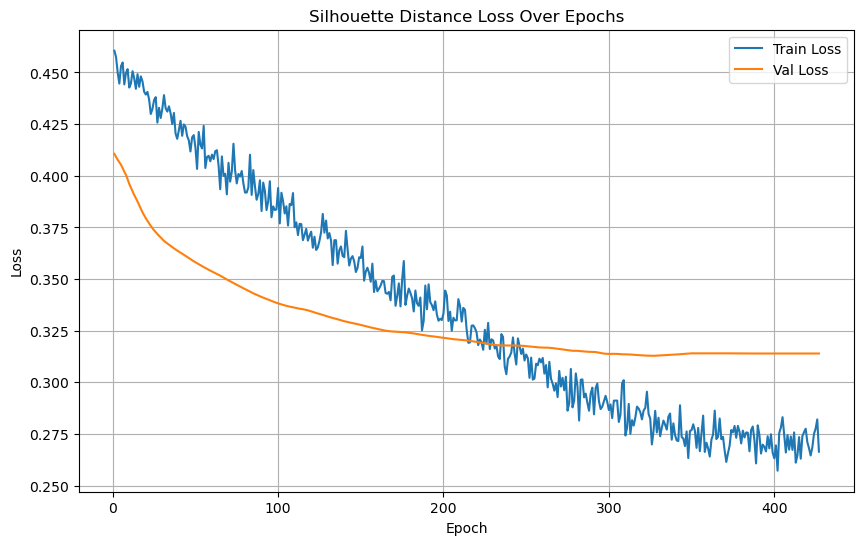

In [51]:
sclsdl_model = SupConNet().to(device)
sclsdl_criterion = SilhouetteDistanceLoss()
sclsdl_optimizer = optim.AdamW(sclsdl_model.parameters(), lr=0.0001, weight_decay=1e-5)
sclsdl_scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    sclsdl_optimizer, 
    mode='min',
    patience=25,
    factor=0.1
)

sclsdl_num_epochs = 2000

sclsdl_patience = 100
sclsdl_best_val_loss = float('inf')
sclsdl_epochs_without_improvement = 0

sclsdl_train_loss_history = []
sclsdl_val_loss_history = []

for sclsdl_epoch in range(sclsdl_num_epochs):
    # Training
    sclsdl_model.train()
    sclsdl_running_train_loss = 0.0
    
    print(f"LOG: Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}] - Training")
    for batch_idx, (vectors, labels) in enumerate(sclsdl_train_loader):

        vectors = vectors.to(device).float()
        labels = labels.to(device)

        # Forward pass
        sclsdl_train_projections = sclsdl_model(vectors)

        sclsdl_loss = sclsdl_criterion(sclsdl_train_projections, labels)

        # Backprop and optimize
        sclsdl_optimizer.zero_grad()
        sclsdl_loss.backward()
        sclsdl_optimizer.step()

        sclsdl_running_train_loss += sclsdl_loss.item()
        print(f"    Batch [{batch_idx+1}/{len(sclsdl_train_loader)}], Train Loss: {sclsdl_loss.item():.4f}")

    sclsdl_train_epoch_loss = sclsdl_running_train_loss / len(sclsdl_train_loader)
    sclsdl_train_loss_history.append(sclsdl_train_epoch_loss)

    # Validation
    sclsdl_model.eval()
    sclsdl_running_val_loss = 0.0
    print(f"LOG: Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}] - Validation")
    with torch.no_grad():
        for val_batch_idx, (vectors, labels) in enumerate(sclsdl_val_loader):

            vectors = vectors.to(device).float()
            labels = labels.to(device)

            sclsdl_val_projections = sclsdl_model(vectors)
            sclsdl_val_batch_loss = sclsdl_criterion(sclsdl_val_projections, labels).item()
            sclsdl_running_val_loss += sclsdl_val_batch_loss
            print(f"    Batch [{val_batch_idx+1}/{len(sclsdl_val_loader)}], Val Loss: {sclsdl_val_batch_loss:.4f}")

    sclsdl_val_epoch_loss = sclsdl_running_val_loss / len(sclsdl_val_loader)
    sclsdl_val_loss_history.append(sclsdl_val_epoch_loss)
    
    sclsdl_scheduler.step(sclsdl_val_epoch_loss)

    print(f"Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}], "
          f"Avg Train Loss: {sclsdl_train_epoch_loss:.4f}, "
          f"Avg Val Loss: {sclsdl_val_epoch_loss:.4f}\n")
    
    #early stopping logic
    if sclsdl_val_epoch_loss < sclsdl_best_val_loss:
        print(f"Validation loss improved from {sclsdl_best_val_loss:.4f} to {sclsdl_val_epoch_loss:.4f}. Saving model...")
        sclsdl_best_val_loss = sclsdl_val_epoch_loss
        sclsdl_epochs_without_improvement = 0
    else:
        sclsdl_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! Patience: {sclsdl_epochs_without_improvement}/{sclsdl_patience}")

    #stop training if val loss not improving
    if sclsdl_epochs_without_improvement >= sclsdl_patience:
        print(f"!! Early stopping triggered at epoch {sclsdl_epoch + 1}!!\nNo improvement for {sclsdl_patience} epochs")
        break

plt.figure(figsize=(10,6))
sclsdl_num_epochs_run = len(sclsdl_train_loss_history)
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_train_loss_history, label='Train Loss')
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_val_loss_history, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Silhouette Distance Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

Test Batch [10/844], Loss: 0.1259
Test Batch [20/844], Loss: 0.1842
Test Batch [30/844], Loss: 0.2367
Test Batch [40/844], Loss: 0.1755
Test Batch [50/844], Loss: 0.1342
Test Batch [60/844], Loss: 0.5000


Test Batch [70/844], Loss: 0.1451
Test Batch [80/844], Loss: 0.1787
Test Batch [90/844], Loss: 0.5000
Test Batch [100/844], Loss: 0.2457
Test Batch [110/844], Loss: 0.2006
Test Batch [120/844], Loss: 0.1851
Test Batch [130/844], Loss: 0.5000
Test Batch [140/844], Loss: 0.1634
Test Batch [150/844], Loss: 0.2021


Test Batch [160/844], Loss: 0.3076
Test Batch [170/844], Loss: 0.2637
Test Batch [180/844], Loss: 0.1988
Test Batch [190/844], Loss: 0.1732
Test Batch [200/844], Loss: 0.1116


Test Batch [210/844], Loss: 0.0985
Test Batch [220/844], Loss: 0.0844
Test Batch [230/844], Loss: 0.1444
Test Batch [240/844], Loss: 0.1122


Test Batch [250/844], Loss: 0.1538
Test Batch [260/844], Loss: 0.3152
Test Batch [270/844], Loss: 0.2836
Test Batch [280/844], Loss: 0.3116


Test Batch [290/844], Loss: 0.3167
Test Batch [300/844], Loss: 0.2877
Test Batch [310/844], Loss: 0.2459
Test Batch [320/844], Loss: 0.1815


Test Batch [330/844], Loss: 0.2862
Test Batch [340/844], Loss: 0.2893
Test Batch [350/844], Loss: 0.5000
Test Batch [360/844], Loss: 0.2260
Test Batch [370/844], Loss: 0.5000
Test Batch [380/844], Loss: 0.5000
Test Batch [390/844], Loss: 0.5000
Test Batch [400/844], Loss: 0.5000
Test Batch [410/844], Loss: 0.5000
Test Batch [420/844], Loss: 0.5000
Test Batch [430/844], Loss: 0.0913


Test Batch [440/844], Loss: 0.1098
Test Batch [450/844], Loss: 0.2230
Test Batch [460/844], Loss: 0.1134
Test Batch [470/844], Loss: 0.1133
Test Batch [480/844], Loss: 0.1804


Test Batch [490/844], Loss: 0.5000
Test Batch [500/844], Loss: 0.1700
Test Batch [510/844], Loss: 0.2086
Test Batch [520/844], Loss: 0.0910
Test Batch [530/844], Loss: 0.1124
Test Batch [540/844], Loss: 0.2138


Test Batch [550/844], Loss: 0.1044
Test Batch [560/844], Loss: 0.1162
Test Batch [570/844], Loss: 0.1433
Test Batch [580/844], Loss: 0.2100
Test Batch [590/844], Loss: 0.1839


Test Batch [600/844], Loss: 0.1318
Test Batch [610/844], Loss: 0.1898
Test Batch [620/844], Loss: 0.2051
Test Batch [630/844], Loss: 0.2645
Test Batch [640/844], Loss: 0.2136


Test Batch [650/844], Loss: 0.0871
Test Batch [660/844], Loss: 0.0976
Test Batch [670/844], Loss: 0.1581
Test Batch [680/844], Loss: 0.1502
Test Batch [690/844], Loss: 0.1264


Test Batch [700/844], Loss: 0.3705
Test Batch [710/844], Loss: 0.1334
Test Batch [720/844], Loss: 0.4004
Test Batch [730/844], Loss: 0.1695
Test Batch [740/844], Loss: 0.1884


Test Batch [750/844], Loss: 0.2021
Test Batch [760/844], Loss: 0.1846
Test Batch [770/844], Loss: 0.5000
Test Batch [780/844], Loss: 0.1733
Test Batch [790/844], Loss: 0.2912
Test Batch [800/844], Loss: 0.4192


Test Batch [810/844], Loss: 0.1290
Test Batch [820/844], Loss: 0.1500
Test Batch [830/844], Loss: 0.1285
Test Batch [840/844], Loss: 0.2041

Test Loss: 0.2469


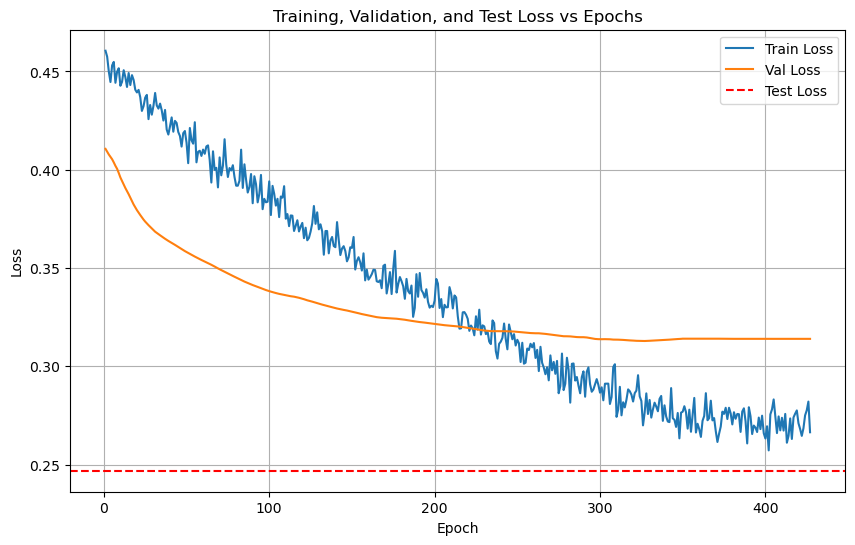

In [52]:
# Test Evaluation
sclsdl_model.eval()
sclsdl_total_test_loss = 0.0

with torch.no_grad():
    for batch_idx, (vectors, labels) in enumerate(sclsdl_test_loader):
        vectors = vectors.to(device).float()
        labels = labels.to(device)
        projections = sclsdl_model(vectors)
        loss = sclsdl_criterion(projections, labels)
        sclsdl_total_test_loss += loss.item()
        if (batch_idx + 1) % 10 == 0:
            print(f"Test Batch [{batch_idx + 1}/{len(sclsdl_test_loader)}], Loss: {loss.item():.4f}")

sclsdl_avg_test_loss = sclsdl_total_test_loss / len(sclsdl_test_loader)
print(f"\nTest Loss: {sclsdl_avg_test_loss:.4f}")


plt.figure(figsize=(10, 6))
sclsdl_num_epochs_run = len(sclsdl_train_loss_history)
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_train_loss_history, label='Train Loss')
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_val_loss_history, label='Val Loss')
# test loss = horizontal dashed line
plt.axhline(y=sclsdl_avg_test_loss, color='r', linestyle='--', label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training, Validation, and Test Loss vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

### Saving the representations learnt by SCL w/ SDL Model

In [53]:
# dir to save the SCL representations
sclsdl_rep_dir = "sclsdl_representations"
os.makedirs(sclsdl_rep_dir, exist_ok=True)

sclsdl_loaders = {
    'train': sclsdl_train_loader,
    'val': sclsdl_val_loader,
    'test': sclsdl_test_loader
}

sclsdl_model.eval()

with torch.no_grad():
    for sclsdl_split_name, sclsdl_loader in sclsdl_loaders.items():
        print(f"\nExtracting SCL_SDL representations for the {sclsdl_split_name} dataset...")
        # creating subfolder for the split
        sclsdl_split_dir = os.path.join(sclsdl_rep_dir, sclsdl_split_name)
        os.makedirs(sclsdl_split_dir, exist_ok=True)
        
        # processing the data batch-wise
        for sclsdl_batch_idx, (sclsdl_vectors, sclsdl_labels) in enumerate(sclsdl_loader):
            sclsdl_vectors = sclsdl_vectors.to(device).float()
            # computing projections using the trained SCL model
            sclsdl_projections = sclsdl_model(sclsdl_vectors)
            
            # converting projections and labels to np arrays
            sclsdl_projections_np = sclsdl_projections.cpu().numpy()
            sclsdl_labels_np = sclsdl_labels.cpu().numpy()
            
            # saving the batch projections and labels
            np.save(os.path.join(sclsdl_split_dir, f"scl_encoded_batch_{sclsdl_batch_idx}.npy"), sclsdl_projections_np)
            np.save(os.path.join(sclsdl_split_dir, f"scl_labels_batch_{sclsdl_batch_idx}.npy"), sclsdl_labels_np)
            
            if (sclsdl_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {sclsdl_batch_idx + 1}/{len(sclsdl_loader)} for {sclsdl_split_name} dataset.")

        print(f"Completed extraction for the {sclsdl_split_name} dataset. Representations saved in '{sclsdl_split_dir}'.")

print("SCL representations extraction complete.")


Extracting SCL_SDL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'sclsdl_representations\train'.

Extracting SCL_SDL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'sclsdl_representations\val'.

Extracting SCL_SDL representations for the test dataset...
  Processed batch 10/844 for test dataset.
  Processed batch 20/844 for test dataset.


  Processed batch 30/844 for test dataset.
  Processed batch 40/844 for test dataset.
  Processed batch 50/844 for test dataset.


  Processed batch 60/844 for test dataset.
  Processed batch 70/844 for test dataset.
  Processed batch 80/844 for test dataset.
  Processed batch 90/844 for test dataset.


  Processed batch 100/844 for test dataset.
  Processed batch 110/844 for test dataset.


  Processed batch 120/844 for test dataset.
  Processed batch 130/844 for test dataset.
  Processed batch 140/844 for test dataset.


  Processed batch 150/844 for test dataset.
  Processed batch 160/844 for test dataset.
  Processed batch 170/844 for test dataset.


  Processed batch 180/844 for test dataset.
  Processed batch 190/844 for test dataset.
  Processed batch 200/844 for test dataset.
  Processed batch 210/844 for test dataset.


  Processed batch 220/844 for test dataset.
  Processed batch 230/844 for test dataset.
  Processed batch 240/844 for test dataset.
  Processed batch 250/844 for test dataset.


  Processed batch 260/844 for test dataset.
  Processed batch 270/844 for test dataset.
  Processed batch 280/844 for test dataset.


  Processed batch 290/844 for test dataset.
  Processed batch 300/844 for test dataset.
  Processed batch 310/844 for test dataset.
  Processed batch 320/844 for test dataset.


  Processed batch 330/844 for test dataset.
  Processed batch 340/844 for test dataset.
  Processed batch 350/844 for test dataset.


  Processed batch 360/844 for test dataset.
  Processed batch 370/844 for test dataset.
  Processed batch 380/844 for test dataset.


  Processed batch 390/844 for test dataset.
  Processed batch 400/844 for test dataset.
  Processed batch 410/844 for test dataset.


  Processed batch 420/844 for test dataset.
  Processed batch 430/844 for test dataset.
  Processed batch 440/844 for test dataset.
  Processed batch 450/844 for test dataset.


  Processed batch 460/844 for test dataset.
  Processed batch 470/844 for test dataset.
  Processed batch 480/844 for test dataset.
  Processed batch 490/844 for test dataset.


  Processed batch 500/844 for test dataset.
  Processed batch 510/844 for test dataset.
  Processed batch 520/844 for test dataset.
  Processed batch 530/844 for test dataset.


  Processed batch 540/844 for test dataset.
  Processed batch 550/844 for test dataset.
  Processed batch 560/844 for test dataset.
  Processed batch 570/844 for test dataset.


  Processed batch 580/844 for test dataset.
  Processed batch 590/844 for test dataset.
  Processed batch 600/844 for test dataset.
  Processed batch 610/844 for test dataset.


  Processed batch 620/844 for test dataset.
  Processed batch 630/844 for test dataset.
  Processed batch 640/844 for test dataset.


  Processed batch 650/844 for test dataset.
  Processed batch 660/844 for test dataset.
  Processed batch 670/844 for test dataset.


  Processed batch 680/844 for test dataset.
  Processed batch 690/844 for test dataset.
  Processed batch 700/844 for test dataset.
  Processed batch 710/844 for test dataset.


  Processed batch 720/844 for test dataset.
  Processed batch 730/844 for test dataset.


  Processed batch 740/844 for test dataset.
  Processed batch 750/844 for test dataset.
  Processed batch 760/844 for test dataset.
  Processed batch 770/844 for test dataset.


  Processed batch 780/844 for test dataset.
  Processed batch 790/844 for test dataset.
  Processed batch 800/844 for test dataset.


  Processed batch 810/844 for test dataset.
  Processed batch 820/844 for test dataset.
  Processed batch 830/844 for test dataset.
  Processed batch 840/844 for test dataset.


Completed extraction for the test dataset. Representations saved in 'sclsdl_representations\test'.
SCL representations extraction complete.


### Classifying the representations learnt by SCL w/ SDL Model with LRM

In [54]:
def load_sclsdl_reps_and_labels(split_dir):
    #gather all the scl_encoded_batch npy files in sorted order
    sclsdl_rep_files = sorted(glob.glob(os.path.join(split_dir, "scl_encoded_batch_*.npy")))

    sclsdl_all_reps = []
    sclsdl_all_labels = []

    for sclsdl_rep_file in sclsdl_rep_files:
        #deriving label filenames
        sclsdl_label_file = sclsdl_rep_file.replace("scl_encoded_batch_", "scl_labels_batch_")

        sclsdl_reps = np.load(sclsdl_rep_file)
        sclsdl_labels = np.load(sclsdl_label_file)

        sclsdl_all_reps.append(sclsdl_reps)
        sclsdl_all_labels.append(sclsdl_labels)

    #concat along first dim
    sclsdl_all_reps = np.concatenate(sclsdl_all_reps, axis = 0)
    sclsdl_all_labels = np.concatenate(sclsdl_all_labels, axis = 0)

    return sclsdl_all_reps, sclsdl_all_labels

In [55]:
sclsdl_lrm_train_dir = os.path.join("sclsdl_representations", "train")
sclsdl_lrm_val_dir   = os.path.join("sclsdl_representations", "val")
sclsdl_lrm_test_dir  = os.path.join("sclsdl_representations", "test")

sclsdl_lrm_train_reps, sclsdl_lrm_train_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_train_dir)
sclsdl_lrm_val_reps, sclsdl_lrm_val_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_val_dir)
sclsdl_lrm_test_reps, sclsdl_lrm_test_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_test_dir)

print("Train reps shape:", sclsdl_lrm_train_reps.shape)
print("Train labels shape:", sclsdl_lrm_train_labels.shape)

print("Val reps shape:", sclsdl_lrm_val_reps.shape)
print("Val labels shape:", sclsdl_lrm_val_labels.shape)

print("Test reps shape:", sclsdl_lrm_test_reps.shape)
print("Test labels shape:", sclsdl_lrm_test_labels.shape)

Train reps shape: (80, 128)
Train labels shape: (80,)
Val reps shape: (80, 128)
Val labels shape: (80,)
Test reps shape: (53969, 128)
Test labels shape: (53969,)


In [56]:
# Train Logistic Regression Model on the SCLSDL representations
print("\nLOG: Training Logistic Regression model on SCL SDL representations...")
sclsdl_logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight='balanced')
sclsdl_logistic_clf.fit(sclsdl_lrm_train_reps, sclsdl_lrm_train_labels)
print("LOG: Logistic Regression training complete.")

# Evaluate on Validation Set
print("\nLOG: Evaluating on the validation set...")
sclsdl_lrm_val_predictions = sclsdl_logistic_clf.predict(sclsdl_lrm_val_reps)
sclsdl_lrm_val_accuracy = accuracy_score(sclsdl_lrm_val_labels, sclsdl_lrm_val_predictions)
print(f"Validation Accuracy: {sclsdl_lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(sclsdl_lrm_val_labels, sclsdl_lrm_val_predictions))

# Evaluate on Test Set
print("\nLOG: Evaluating on the test set...")
sclsdl_lrm_test_predictions = sclsdl_logistic_clf.predict(sclsdl_lrm_test_reps)
sclsdl_lrm_test_accuracy = accuracy_score(sclsdl_lrm_test_labels, sclsdl_lrm_test_predictions)
print(f"Test Accuracy: {sclsdl_lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(sclsdl_lrm_test_labels, sclsdl_lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'sclsdl_lrm_predictions.npy'), sclsdl_lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'sclsdl_lrm_true_labels.npy'), sclsdl_lrm_test_labels)
print(f"Saved SCL_SDL+LRM predictions and true labels to {predictions_dir}")


LOG: Training Logistic Regression model on SCL SDL representations...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 87.50%

Validation Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         5
           3       1.00      0.80      0.89         5
           4       0.83      1.00      0.91         5
           5       1.00      1.00      1.00         5
           6       0.67      0.80      0.73         5
           7       0.83      1.00      0.91         5
           8       1.00      0.80      0.89         5
           9       1.00      1.00      1.00         5
          10       0.83      1.00      0.91         5
          11       1.00      1.00      1.00         5
          12       0.56      1.00      0.71         5
          13       0.6

## Classifying the representations learnt by SCL w/ SDL Model with MLP Classifier

In [57]:
sclsdl_mlp_train_dir = os.path.join("sclsdl_representations", "train")
sclsdl_mlp_val_dir   = os.path.join("sclsdl_representations", "val")
sclsdl_mlp_test_dir  = os.path.join("sclsdl_representations", "test")

sclsdl_mlp_train_reps, sclsdl_mlp_train_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_train_dir)
sclsdl_mlp_val_reps, sclsdl_mlp_val_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_val_dir)
sclsdl_mlp_test_reps, sclsdl_mlp_test_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_test_dir)

print("Train reps shape:", sclsdl_mlp_train_reps.shape)
print("Train labels shape:", sclsdl_mlp_train_labels.shape)

print("Val reps shape:", sclsdl_mlp_val_reps.shape)
print("Val labels shape:", sclsdl_mlp_val_labels.shape)

print("Test reps shape:", sclsdl_mlp_test_reps.shape)
print("Test labels shape:", sclsdl_mlp_test_labels.shape)

Train reps shape: (80, 128)
Train labels shape: (80,)
Val reps shape: (80, 128)
Val labels shape: (80,)
Test reps shape: (53969, 128)
Test labels shape: (53969,)


In [58]:
#converting arrays to torch tensors
sclsdl_mlp_train_embeddings_torch = torch.tensor(sclsdl_mlp_train_reps, dtype=torch.float32)
sclsdl_mlp_train_labels_torch = torch.tensor(sclsdl_mlp_train_labels, dtype=torch.long)

sclsdl_mlp_val_embeddings_torch = torch.tensor(sclsdl_mlp_val_reps, dtype=torch.float32)
sclsdl_mlp_val_labels_torch = torch.tensor(sclsdl_mlp_val_labels, dtype=torch.long)

sclsdl_mlp_test_embeddings_torch = torch.tensor(sclsdl_mlp_test_reps, dtype=torch.float32)
sclsdl_mlp_test_labels_torch = torch.tensor(sclsdl_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
sclsdl_mlp_train_dataset = TensorDataset(sclsdl_mlp_train_embeddings_torch, sclsdl_mlp_train_labels_torch)
sclsdl_mlp_val_dataset = TensorDataset(sclsdl_mlp_val_embeddings_torch, sclsdl_mlp_val_labels_torch)
sclsdl_mlp_test_dataset = TensorDataset(sclsdl_mlp_test_embeddings_torch, sclsdl_mlp_test_labels_torch)

sclsdl_mlp_batch_size = 64
sclsdl_mlp_train_loader = DataLoader(sclsdl_mlp_train_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=True)
sclsdl_mlp_val_loader = DataLoader(sclsdl_mlp_val_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=False)
sclsdl_mlp_test_loader = DataLoader(sclsdl_mlp_test_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.8614  |  Val Loss: 2.8495
Validation loss improved from inf to 2.8495.
[Epoch 2/1000] Train Loss: 2.8430  |  Val Loss: 2.8359
Validation loss improved from 2.8495 to 2.8359.
[Epoch 3/1000] Train Loss: 2.8266  |  Val Loss: 2.8227
Validation loss improved from 2.8359 to 2.8227.
[Epoch 4/1000] Train Loss: 2.8092  |  Val Loss: 2.8101
Validation loss improved from 2.8227 to 2.8101.
[Epoch 5/1000] Train Loss: 2.7944  |  Val Loss: 2.7977
Validation loss improved from 2.8101 to 2.7977.
[Epoch 6/1000] Train Loss: 2.7785  |  Val Loss: 2.7857
Validation loss improved from 2.7977 to 2.7857.
[Epoch 7/1000] Train Loss: 2.7638  |  Val Loss: 2.7742
Validation loss improved from 2.7857 to 2.7742.
[Epoch 8/1000] Train Loss: 2.7489  |  Val Loss: 2.7631
Validation loss improved from 2.7742 to 2.7631.
[Epoch 9/1000] Train Loss: 2.7350  |  Val Loss: 2.7519
Validation loss improved from 2.7631 to 2.7519.
[Epoch 10/1000] Train Loss: 2.7205  |  Val Loss: 2.7411
Validation loss impr

[Epoch 36/1000] Train Loss: 2.4269  |  Val Loss: 2.5027
Validation loss improved from 2.5108 to 2.5027.
[Epoch 37/1000] Train Loss: 2.4173  |  Val Loss: 2.4946
Validation loss improved from 2.5027 to 2.4946.
[Epoch 38/1000] Train Loss: 2.4075  |  Val Loss: 2.4867
Validation loss improved from 2.4946 to 2.4867.
[Epoch 39/1000] Train Loss: 2.3975  |  Val Loss: 2.4788
Validation loss improved from 2.4867 to 2.4788.
[Epoch 40/1000] Train Loss: 2.3878  |  Val Loss: 2.4708
Validation loss improved from 2.4788 to 2.4708.
[Epoch 41/1000] Train Loss: 2.3786  |  Val Loss: 2.4627
Validation loss improved from 2.4708 to 2.4627.
[Epoch 42/1000] Train Loss: 2.3689  |  Val Loss: 2.4546
Validation loss improved from 2.4627 to 2.4546.


[Epoch 43/1000] Train Loss: 2.3593  |  Val Loss: 2.4464
Validation loss improved from 2.4546 to 2.4464.
[Epoch 44/1000] Train Loss: 2.3500  |  Val Loss: 2.4381
Validation loss improved from 2.4464 to 2.4381.
[Epoch 45/1000] Train Loss: 2.3404  |  Val Loss: 2.4299
Validation loss improved from 2.4381 to 2.4299.
[Epoch 46/1000] Train Loss: 2.3308  |  Val Loss: 2.4217
Validation loss improved from 2.4299 to 2.4217.
[Epoch 47/1000] Train Loss: 2.3216  |  Val Loss: 2.4135
Validation loss improved from 2.4217 to 2.4135.
[Epoch 48/1000] Train Loss: 2.3124  |  Val Loss: 2.4055
Validation loss improved from 2.4135 to 2.4055.
[Epoch 49/1000] Train Loss: 2.3028  |  Val Loss: 2.3977
Validation loss improved from 2.4055 to 2.3977.
[Epoch 50/1000] Train Loss: 2.2938  |  Val Loss: 2.3900
Validation loss improved from 2.3977 to 2.3900.
[Epoch 51/1000] Train Loss: 2.2846  |  Val Loss: 2.3822
Validation loss improved from 2.3900 to 2.3822.
[Epoch 52/1000] Train Loss: 2.2754  |  Val Loss: 2.3744
Validati

[Epoch 75/1000] Train Loss: 2.0493  |  Val Loss: 2.1823
Validation loss improved from 2.1912 to 2.1823.
[Epoch 76/1000] Train Loss: 2.0389  |  Val Loss: 2.1735
Validation loss improved from 2.1823 to 2.1735.
[Epoch 77/1000] Train Loss: 2.0284  |  Val Loss: 2.1646
Validation loss improved from 2.1735 to 2.1646.
[Epoch 78/1000] Train Loss: 2.0180  |  Val Loss: 2.1556
Validation loss improved from 2.1646 to 2.1556.
[Epoch 79/1000] Train Loss: 2.0074  |  Val Loss: 2.1467
Validation loss improved from 2.1556 to 2.1467.
[Epoch 80/1000] Train Loss: 1.9970  |  Val Loss: 2.1379
Validation loss improved from 2.1467 to 2.1379.
[Epoch 81/1000] Train Loss: 1.9865  |  Val Loss: 2.1290
Validation loss improved from 2.1379 to 2.1290.
[Epoch 82/1000] Train Loss: 1.9756  |  Val Loss: 2.1200
Validation loss improved from 2.1290 to 2.1200.


[Epoch 83/1000] Train Loss: 1.9651  |  Val Loss: 2.1109
Validation loss improved from 2.1200 to 2.1109.
[Epoch 84/1000] Train Loss: 1.9542  |  Val Loss: 2.1019
Validation loss improved from 2.1109 to 2.1019.
[Epoch 85/1000] Train Loss: 1.9429  |  Val Loss: 2.0929
Validation loss improved from 2.1019 to 2.0929.
[Epoch 86/1000] Train Loss: 1.9317  |  Val Loss: 2.0840
Validation loss improved from 2.0929 to 2.0840.
[Epoch 87/1000] Train Loss: 1.9204  |  Val Loss: 2.0752
Validation loss improved from 2.0840 to 2.0752.
[Epoch 88/1000] Train Loss: 1.9093  |  Val Loss: 2.0662
Validation loss improved from 2.0752 to 2.0662.
[Epoch 89/1000] Train Loss: 1.8980  |  Val Loss: 2.0573
Validation loss improved from 2.0662 to 2.0573.
[Epoch 90/1000] Train Loss: 1.8865  |  Val Loss: 2.0486
Validation loss improved from 2.0573 to 2.0486.
[Epoch 91/1000] Train Loss: 1.8755  |  Val Loss: 2.0399
Validation loss improved from 2.0486 to 2.0399.
[Epoch 92/1000] Train Loss: 1.8638  |  Val Loss: 2.0311
Validati

[Epoch 115/1000] Train Loss: 1.5873  |  Val Loss: 1.8168
Validation loss improved from 1.8269 to 1.8168.
[Epoch 116/1000] Train Loss: 1.5747  |  Val Loss: 1.8069
Validation loss improved from 1.8168 to 1.8069.
[Epoch 117/1000] Train Loss: 1.5618  |  Val Loss: 1.7972
Validation loss improved from 1.8069 to 1.7972.
[Epoch 118/1000] Train Loss: 1.5494  |  Val Loss: 1.7877
Validation loss improved from 1.7972 to 1.7877.
[Epoch 119/1000] Train Loss: 1.5368  |  Val Loss: 1.7781
Validation loss improved from 1.7877 to 1.7781.
[Epoch 120/1000] Train Loss: 1.5247  |  Val Loss: 1.7685
Validation loss improved from 1.7781 to 1.7685.
[Epoch 121/1000] Train Loss: 1.5122  |  Val Loss: 1.7588
Validation loss improved from 1.7685 to 1.7588.
[Epoch 122/1000] Train Loss: 1.5002  |  Val Loss: 1.7493
Validation loss improved from 1.7588 to 1.7493.
[Epoch 123/1000] Train Loss: 1.4884  |  Val Loss: 1.7398
Validation loss improved from 1.7493 to 1.7398.
[Epoch 124/1000] Train Loss: 1.4760  |  Val Loss: 1.729

[Epoch 127/1000] Train Loss: 1.4405  |  Val Loss: 1.7012
Validation loss improved from 1.7109 to 1.7012.
[Epoch 128/1000] Train Loss: 1.4285  |  Val Loss: 1.6916
Validation loss improved from 1.7012 to 1.6916.
[Epoch 129/1000] Train Loss: 1.4169  |  Val Loss: 1.6822
Validation loss improved from 1.6916 to 1.6822.
[Epoch 130/1000] Train Loss: 1.4051  |  Val Loss: 1.6728
Validation loss improved from 1.6822 to 1.6728.
[Epoch 131/1000] Train Loss: 1.3934  |  Val Loss: 1.6637
Validation loss improved from 1.6728 to 1.6637.
[Epoch 132/1000] Train Loss: 1.3818  |  Val Loss: 1.6545
Validation loss improved from 1.6637 to 1.6545.
[Epoch 133/1000] Train Loss: 1.3699  |  Val Loss: 1.6453
Validation loss improved from 1.6545 to 1.6453.
[Epoch 134/1000] Train Loss: 1.3586  |  Val Loss: 1.6360
Validation loss improved from 1.6453 to 1.6360.
[Epoch 135/1000] Train Loss: 1.3468  |  Val Loss: 1.6268
Validation loss improved from 1.6360 to 1.6268.
[Epoch 136/1000] Train Loss: 1.3350  |  Val Loss: 1.617

[Epoch 155/1000] Train Loss: 1.1296  |  Val Loss: 1.4480
Validation loss improved from 1.4562 to 1.4480.
[Epoch 156/1000] Train Loss: 1.1199  |  Val Loss: 1.4397
Validation loss improved from 1.4480 to 1.4397.
[Epoch 157/1000] Train Loss: 1.1103  |  Val Loss: 1.4315
Validation loss improved from 1.4397 to 1.4315.
[Epoch 158/1000] Train Loss: 1.1008  |  Val Loss: 1.4231
Validation loss improved from 1.4315 to 1.4231.
[Epoch 159/1000] Train Loss: 1.0916  |  Val Loss: 1.4148
Validation loss improved from 1.4231 to 1.4148.
[Epoch 160/1000] Train Loss: 1.0821  |  Val Loss: 1.4070
Validation loss improved from 1.4148 to 1.4070.
[Epoch 161/1000] Train Loss: 1.0729  |  Val Loss: 1.3995
Validation loss improved from 1.4070 to 1.3995.
[Epoch 162/1000] Train Loss: 1.0638  |  Val Loss: 1.3921
Validation loss improved from 1.3995 to 1.3921.


[Epoch 163/1000] Train Loss: 1.0547  |  Val Loss: 1.3843
Validation loss improved from 1.3921 to 1.3843.
[Epoch 164/1000] Train Loss: 1.0458  |  Val Loss: 1.3762
Validation loss improved from 1.3843 to 1.3762.
[Epoch 165/1000] Train Loss: 1.0370  |  Val Loss: 1.3680
Validation loss improved from 1.3762 to 1.3680.
[Epoch 166/1000] Train Loss: 1.0282  |  Val Loss: 1.3599
Validation loss improved from 1.3680 to 1.3599.
[Epoch 167/1000] Train Loss: 1.0196  |  Val Loss: 1.3522
Validation loss improved from 1.3599 to 1.3522.
[Epoch 168/1000] Train Loss: 1.0110  |  Val Loss: 1.3447
Validation loss improved from 1.3522 to 1.3447.
[Epoch 169/1000] Train Loss: 1.0024  |  Val Loss: 1.3375
Validation loss improved from 1.3447 to 1.3375.
[Epoch 170/1000] Train Loss: 0.9939  |  Val Loss: 1.3307
Validation loss improved from 1.3375 to 1.3307.
[Epoch 171/1000] Train Loss: 0.9855  |  Val Loss: 1.3237
Validation loss improved from 1.3307 to 1.3237.
[Epoch 172/1000] Train Loss: 0.9773  |  Val Loss: 1.316

[Epoch 191/1000] Train Loss: 0.8322  |  Val Loss: 1.1959
Validation loss improved from 1.2020 to 1.1959.
[Epoch 192/1000] Train Loss: 0.8249  |  Val Loss: 1.1899
Validation loss improved from 1.1959 to 1.1899.
[Epoch 193/1000] Train Loss: 0.8177  |  Val Loss: 1.1841
Validation loss improved from 1.1899 to 1.1841.
[Epoch 194/1000] Train Loss: 0.8109  |  Val Loss: 1.1785
Validation loss improved from 1.1841 to 1.1785.
[Epoch 195/1000] Train Loss: 0.8039  |  Val Loss: 1.1725
Validation loss improved from 1.1785 to 1.1725.
[Epoch 196/1000] Train Loss: 0.7969  |  Val Loss: 1.1662
Validation loss improved from 1.1725 to 1.1662.
[Epoch 197/1000] Train Loss: 0.7902  |  Val Loss: 1.1599
Validation loss improved from 1.1662 to 1.1599.
[Epoch 198/1000] Train Loss: 0.7835  |  Val Loss: 1.1540
Validation loss improved from 1.1599 to 1.1540.
[Epoch 199/1000] Train Loss: 0.7768  |  Val Loss: 1.1481
Validation loss improved from 1.1540 to 1.1481.
[Epoch 200/1000] Train Loss: 0.7702  |  Val Loss: 1.141

[Epoch 203/1000] Train Loss: 0.7505  |  Val Loss: 1.1221
Validation loss improved from 1.1285 to 1.1221.
[Epoch 204/1000] Train Loss: 0.7443  |  Val Loss: 1.1159
Validation loss improved from 1.1221 to 1.1159.
[Epoch 205/1000] Train Loss: 0.7378  |  Val Loss: 1.1100
Validation loss improved from 1.1159 to 1.1100.
[Epoch 206/1000] Train Loss: 0.7314  |  Val Loss: 1.1039
Validation loss improved from 1.1100 to 1.1039.
[Epoch 207/1000] Train Loss: 0.7252  |  Val Loss: 1.0978
Validation loss improved from 1.1039 to 1.0978.
[Epoch 208/1000] Train Loss: 0.7191  |  Val Loss: 1.0918
Validation loss improved from 1.0978 to 1.0918.
[Epoch 209/1000] Train Loss: 0.7130  |  Val Loss: 1.0856
Validation loss improved from 1.0918 to 1.0856.
[Epoch 210/1000] Train Loss: 0.7067  |  Val Loss: 1.0797
Validation loss improved from 1.0856 to 1.0797.
[Epoch 211/1000] Train Loss: 0.7007  |  Val Loss: 1.0742
Validation loss improved from 1.0797 to 1.0742.
[Epoch 212/1000] Train Loss: 0.6946  |  Val Loss: 1.068

[Epoch 229/1000] Train Loss: 0.5978  |  Val Loss: 0.9822
Validation loss improved from 0.9870 to 0.9822.
[Epoch 230/1000] Train Loss: 0.5923  |  Val Loss: 0.9769
Validation loss improved from 0.9822 to 0.9769.
[Epoch 231/1000] Train Loss: 0.5869  |  Val Loss: 0.9718
Validation loss improved from 0.9769 to 0.9718.
[Epoch 232/1000] Train Loss: 0.5815  |  Val Loss: 0.9673
Validation loss improved from 0.9718 to 0.9673.
[Epoch 233/1000] Train Loss: 0.5759  |  Val Loss: 0.9631
Validation loss improved from 0.9673 to 0.9631.
[Epoch 234/1000] Train Loss: 0.5708  |  Val Loss: 0.9590
Validation loss improved from 0.9631 to 0.9590.
[Epoch 235/1000] Train Loss: 0.5655  |  Val Loss: 0.9551
Validation loss improved from 0.9590 to 0.9551.
[Epoch 236/1000] Train Loss: 0.5604  |  Val Loss: 0.9513
Validation loss improved from 0.9551 to 0.9513.
[Epoch 237/1000] Train Loss: 0.5551  |  Val Loss: 0.9475
Validation loss improved from 0.9513 to 0.9475.
[Epoch 238/1000] Train Loss: 0.5503  |  Val Loss: 0.943

[Epoch 244/1000] Train Loss: 0.5203  |  Val Loss: 0.9203
Validation loss improved from 0.9245 to 0.9203.
[Epoch 245/1000] Train Loss: 0.5155  |  Val Loss: 0.9162
Validation loss improved from 0.9203 to 0.9162.
[Epoch 246/1000] Train Loss: 0.5107  |  Val Loss: 0.9123
Validation loss improved from 0.9162 to 0.9123.
[Epoch 247/1000] Train Loss: 0.5059  |  Val Loss: 0.9085
Validation loss improved from 0.9123 to 0.9085.
[Epoch 248/1000] Train Loss: 0.5010  |  Val Loss: 0.9043
Validation loss improved from 0.9085 to 0.9043.
[Epoch 249/1000] Train Loss: 0.4961  |  Val Loss: 0.9002
Validation loss improved from 0.9043 to 0.9002.
[Epoch 250/1000] Train Loss: 0.4915  |  Val Loss: 0.8962
Validation loss improved from 0.9002 to 0.8962.
[Epoch 251/1000] Train Loss: 0.4868  |  Val Loss: 0.8922
Validation loss improved from 0.8962 to 0.8922.
[Epoch 252/1000] Train Loss: 0.4819  |  Val Loss: 0.8881
Validation loss improved from 0.8922 to 0.8881.
[Epoch 253/1000] Train Loss: 0.4772  |  Val Loss: 0.883

[Epoch 272/1000] Train Loss: 0.3951  |  Val Loss: 0.8201
Validation loss improved from 0.8220 to 0.8201.
[Epoch 273/1000] Train Loss: 0.3913  |  Val Loss: 0.8185
Validation loss improved from 0.8201 to 0.8185.
[Epoch 274/1000] Train Loss: 0.3873  |  Val Loss: 0.8169
Validation loss improved from 0.8185 to 0.8169.
[Epoch 275/1000] Train Loss: 0.3836  |  Val Loss: 0.8153
Validation loss improved from 0.8169 to 0.8153.
[Epoch 276/1000] Train Loss: 0.3798  |  Val Loss: 0.8137
Validation loss improved from 0.8153 to 0.8137.
[Epoch 277/1000] Train Loss: 0.3761  |  Val Loss: 0.8119
Validation loss improved from 0.8137 to 0.8119.
[Epoch 278/1000] Train Loss: 0.3723  |  Val Loss: 0.8097
Validation loss improved from 0.8119 to 0.8097.
[Epoch 279/1000] Train Loss: 0.3686  |  Val Loss: 0.8073
Validation loss improved from 0.8097 to 0.8073.
[Epoch 280/1000] Train Loss: 0.3649  |  Val Loss: 0.8047
Validation loss improved from 0.8073 to 0.8047.
[Epoch 281/1000] Train Loss: 0.3611  |  Val Loss: 0.801

[Epoch 287/1000] Train Loss: 0.3398  |  Val Loss: 0.7823
Validation loss improved from 0.7855 to 0.7823.
[Epoch 288/1000] Train Loss: 0.3365  |  Val Loss: 0.7790
Validation loss improved from 0.7823 to 0.7790.
[Epoch 289/1000] Train Loss: 0.3331  |  Val Loss: 0.7759
Validation loss improved from 0.7790 to 0.7759.
[Epoch 290/1000] Train Loss: 0.3296  |  Val Loss: 0.7732
Validation loss improved from 0.7759 to 0.7732.
[Epoch 291/1000] Train Loss: 0.3263  |  Val Loss: 0.7705
Validation loss improved from 0.7732 to 0.7705.
[Epoch 292/1000] Train Loss: 0.3231  |  Val Loss: 0.7679
Validation loss improved from 0.7705 to 0.7679.
[Epoch 293/1000] Train Loss: 0.3199  |  Val Loss: 0.7655
Validation loss improved from 0.7679 to 0.7655.
[Epoch 294/1000] Train Loss: 0.3167  |  Val Loss: 0.7631
Validation loss improved from 0.7655 to 0.7631.
[Epoch 295/1000] Train Loss: 0.3136  |  Val Loss: 0.7610
Validation loss improved from 0.7631 to 0.7610.
[Epoch 296/1000] Train Loss: 0.3103  |  Val Loss: 0.759

[Epoch 316/1000] Train Loss: 0.2559  |  Val Loss: 0.7304
Validation loss improved from 0.7307 to 0.7304.
[Epoch 317/1000] Train Loss: 0.2535  |  Val Loss: 0.7301
Validation loss improved from 0.7304 to 0.7301.
[Epoch 318/1000] Train Loss: 0.2512  |  Val Loss: 0.7299
Validation loss improved from 0.7301 to 0.7299.
[Epoch 319/1000] Train Loss: 0.2489  |  Val Loss: 0.7295
Validation loss improved from 0.7299 to 0.7295.
[Epoch 320/1000] Train Loss: 0.2466  |  Val Loss: 0.7287
Validation loss improved from 0.7295 to 0.7287.
[Epoch 321/1000] Train Loss: 0.2444  |  Val Loss: 0.7281
Validation loss improved from 0.7287 to 0.7281.
[Epoch 322/1000] Train Loss: 0.2421  |  Val Loss: 0.7273
Validation loss improved from 0.7281 to 0.7273.
[Epoch 323/1000] Train Loss: 0.2400  |  Val Loss: 0.7264
Validation loss improved from 0.7273 to 0.7264.
[Epoch 324/1000] Train Loss: 0.2378  |  Val Loss: 0.7256
Validation loss improved from 0.7264 to 0.7256.
[Epoch 325/1000] Train Loss: 0.2356  |  Val Loss: 0.724

[Epoch 332/1000] Train Loss: 0.2211  |  Val Loss: 0.7170
Validation loss improved from 0.7176 to 0.7170.
[Epoch 333/1000] Train Loss: 0.2191  |  Val Loss: 0.7162
Validation loss improved from 0.7170 to 0.7162.
[Epoch 334/1000] Train Loss: 0.2171  |  Val Loss: 0.7150
Validation loss improved from 0.7162 to 0.7150.
[Epoch 335/1000] Train Loss: 0.2152  |  Val Loss: 0.7140
Validation loss improved from 0.7150 to 0.7140.
[Epoch 336/1000] Train Loss: 0.2133  |  Val Loss: 0.7131
Validation loss improved from 0.7140 to 0.7131.
[Epoch 337/1000] Train Loss: 0.2115  |  Val Loss: 0.7121
Validation loss improved from 0.7131 to 0.7121.
[Epoch 338/1000] Train Loss: 0.2095  |  Val Loss: 0.7112
Validation loss improved from 0.7121 to 0.7112.
[Epoch 339/1000] Train Loss: 0.2077  |  Val Loss: 0.7100
Validation loss improved from 0.7112 to 0.7100.
[Epoch 340/1000] Train Loss: 0.2058  |  Val Loss: 0.7083
Validation loss improved from 0.7100 to 0.7083.
[Epoch 341/1000] Train Loss: 0.2040  |  Val Loss: 0.707

[Epoch 361/1000] Train Loss: 0.1729  |  Val Loss: 0.6961
Validation loss improved from 0.6965 to 0.6961.
[Epoch 362/1000] Train Loss: 0.1717  |  Val Loss: 0.6957
Validation loss improved from 0.6961 to 0.6957.
[Epoch 363/1000] Train Loss: 0.1703  |  Val Loss: 0.6957
Validation loss improved from 0.6957 to 0.6957.
[Epoch 364/1000] Train Loss: 0.1691  |  Val Loss: 0.6956
Validation loss improved from 0.6957 to 0.6956.
[Epoch 365/1000] Train Loss: 0.1678  |  Val Loss: 0.6954
Validation loss improved from 0.6956 to 0.6954.
[Epoch 366/1000] Train Loss: 0.1666  |  Val Loss: 0.6950
Validation loss improved from 0.6954 to 0.6950.
[Epoch 367/1000] Train Loss: 0.1653  |  Val Loss: 0.6940
Validation loss improved from 0.6950 to 0.6940.
[Epoch 368/1000] Train Loss: 0.1641  |  Val Loss: 0.6929
Validation loss improved from 0.6940 to 0.6929.
[Epoch 369/1000] Train Loss: 0.1628  |  Val Loss: 0.6919
Validation loss improved from 0.6929 to 0.6919.
[Epoch 370/1000] Train Loss: 0.1616  |  Val Loss: 0.690

[Epoch 375/1000] Train Loss: 0.1558  |  Val Loss: 0.6882
Validation loss improved from 0.6883 to 0.6882.
[Epoch 376/1000] Train Loss: 0.1547  |  Val Loss: 0.6879
Validation loss improved from 0.6882 to 0.6879.
[Epoch 377/1000] Train Loss: 0.1536  |  Val Loss: 0.6873
Validation loss improved from 0.6879 to 0.6873.
[Epoch 378/1000] Train Loss: 0.1524  |  Val Loss: 0.6867
Validation loss improved from 0.6873 to 0.6867.
[Epoch 379/1000] Train Loss: 0.1514  |  Val Loss: 0.6860
Validation loss improved from 0.6867 to 0.6860.
[Epoch 380/1000] Train Loss: 0.1503  |  Val Loss: 0.6855
Validation loss improved from 0.6860 to 0.6855.
[Epoch 381/1000] Train Loss: 0.1492  |  Val Loss: 0.6854
Validation loss improved from 0.6855 to 0.6854.
[Epoch 382/1000] Train Loss: 0.1481  |  Val Loss: 0.6854
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 383/1000] Train Loss: 0.1470  |  Val Loss: 0.6856
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 384/1000] Train Loss: 0.1460  |  Val

[Epoch 399/1000] Train Loss: 0.1311  |  Val Loss: 0.6852
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 400/1000] Train Loss: 0.1302  |  Val Loss: 0.6853
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 401/1000] Train Loss: 0.1294  |  Val Loss: 0.6852
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 402/1000] Train Loss: 0.1284  |  Val Loss: 0.6851
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 403/1000] Train Loss: 0.1276  |  Val Loss: 0.6852
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 404/1000] Train Loss: 0.1267  |  Val Loss: 0.6853
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 405/1000] Train Loss: 0.1259  |  Val Loss: 0.6852
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 406/1000] Train Loss: 0.1250  |  Val Loss: 0.6850
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 407/1000] Train Loss: 0.1243  |  Val Loss: 0.6845
!! Validation loss did NOT improve !! Patience: 14/

[Epoch 413/1000] Train Loss: 0.1193  |  Val Loss: 0.6810
Validation loss improved from 0.6818 to 0.6810.
[Epoch 414/1000] Train Loss: 0.1186  |  Val Loss: 0.6805
Validation loss improved from 0.6810 to 0.6805.
[Epoch 415/1000] Train Loss: 0.1178  |  Val Loss: 0.6798
Validation loss improved from 0.6805 to 0.6798.
[Epoch 416/1000] Train Loss: 0.1170  |  Val Loss: 0.6791
Validation loss improved from 0.6798 to 0.6791.
[Epoch 417/1000] Train Loss: 0.1162  |  Val Loss: 0.6783
Validation loss improved from 0.6791 to 0.6783.
[Epoch 418/1000] Train Loss: 0.1154  |  Val Loss: 0.6777
Validation loss improved from 0.6783 to 0.6777.
[Epoch 419/1000] Train Loss: 0.1147  |  Val Loss: 0.6773
Validation loss improved from 0.6777 to 0.6773.
[Epoch 420/1000] Train Loss: 0.1140  |  Val Loss: 0.6771
Validation loss improved from 0.6773 to 0.6771.
[Epoch 421/1000] Train Loss: 0.1132  |  Val Loss: 0.6768
Validation loss improved from 0.6771 to 0.6768.
[Epoch 422/1000] Train Loss: 0.1125  |  Val Loss: 0.676

[Epoch 438/1000] Train Loss: 0.1018  |  Val Loss: 0.6776
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 439/1000] Train Loss: 0.1012  |  Val Loss: 0.6779
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 440/1000] Train Loss: 0.1006  |  Val Loss: 0.6781
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 441/1000] Train Loss: 0.1000  |  Val Loss: 0.6783
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 442/1000] Train Loss: 0.0995  |  Val Loss: 0.6783
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 443/1000] Train Loss: 0.0989  |  Val Loss: 0.6783
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 444/1000] Train Loss: 0.0984  |  Val Loss: 0.6787
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 445/1000] Train Loss: 0.0978  |  Val Loss: 0.6794
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 446/1000] Train Loss: 0.0972  |  Val Loss: 0.6801
!! Validation loss did NOT improve !! Patience:

[Epoch 452/1000] Train Loss: 0.0939  |  Val Loss: 0.6802
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 453/1000] Train Loss: 0.0934  |  Val Loss: 0.6798
!! Validation loss did NOT improve !! Patience: 28/100
[Epoch 454/1000] Train Loss: 0.0929  |  Val Loss: 0.6795
!! Validation loss did NOT improve !! Patience: 29/100
[Epoch 455/1000] Train Loss: 0.0924  |  Val Loss: 0.6793
!! Validation loss did NOT improve !! Patience: 30/100
[Epoch 456/1000] Train Loss: 0.0919  |  Val Loss: 0.6795
!! Validation loss did NOT improve !! Patience: 31/100
[Epoch 457/1000] Train Loss: 0.0915  |  Val Loss: 0.6798
!! Validation loss did NOT improve !! Patience: 32/100
[Epoch 458/1000] Train Loss: 0.0909  |  Val Loss: 0.6801
!! Validation loss did NOT improve !! Patience: 33/100
[Epoch 459/1000] Train Loss: 0.0904  |  Val Loss: 0.6804
!! Validation loss did NOT improve !! Patience: 34/100
[Epoch 460/1000] Train Loss: 0.0899  |  Val Loss: 0.6805
!! Validation loss did NOT improve !! Patience:

[Epoch 480/1000] Train Loss: 0.0803  |  Val Loss: 0.6835
!! Validation loss did NOT improve !! Patience: 55/100
[Epoch 481/1000] Train Loss: 0.0799  |  Val Loss: 0.6836
!! Validation loss did NOT improve !! Patience: 56/100
[Epoch 482/1000] Train Loss: 0.0794  |  Val Loss: 0.6835
!! Validation loss did NOT improve !! Patience: 57/100
[Epoch 483/1000] Train Loss: 0.0790  |  Val Loss: 0.6831
!! Validation loss did NOT improve !! Patience: 58/100
[Epoch 484/1000] Train Loss: 0.0786  |  Val Loss: 0.6827
!! Validation loss did NOT improve !! Patience: 59/100
[Epoch 485/1000] Train Loss: 0.0782  |  Val Loss: 0.6825
!! Validation loss did NOT improve !! Patience: 60/100
[Epoch 486/1000] Train Loss: 0.0778  |  Val Loss: 0.6822
!! Validation loss did NOT improve !! Patience: 61/100
[Epoch 487/1000] Train Loss: 0.0774  |  Val Loss: 0.6819
!! Validation loss did NOT improve !! Patience: 62/100
[Epoch 488/1000] Train Loss: 0.0769  |  Val Loss: 0.6818
!! Validation loss did NOT improve !! Patience:

[Epoch 495/1000] Train Loss: 0.0741  |  Val Loss: 0.6832
!! Validation loss did NOT improve !! Patience: 70/100
[Epoch 496/1000] Train Loss: 0.0737  |  Val Loss: 0.6835
!! Validation loss did NOT improve !! Patience: 71/100
[Epoch 497/1000] Train Loss: 0.0733  |  Val Loss: 0.6836
!! Validation loss did NOT improve !! Patience: 72/100
[Epoch 498/1000] Train Loss: 0.0730  |  Val Loss: 0.6835
!! Validation loss did NOT improve !! Patience: 73/100
[Epoch 499/1000] Train Loss: 0.0726  |  Val Loss: 0.6835
!! Validation loss did NOT improve !! Patience: 74/100
[Epoch 500/1000] Train Loss: 0.0722  |  Val Loss: 0.6834
!! Validation loss did NOT improve !! Patience: 75/100
[Epoch 501/1000] Train Loss: 0.0718  |  Val Loss: 0.6834
!! Validation loss did NOT improve !! Patience: 76/100
[Epoch 502/1000] Train Loss: 0.0714  |  Val Loss: 0.6838
!! Validation loss did NOT improve !! Patience: 77/100
[Epoch 503/1000] Train Loss: 0.0711  |  Val Loss: 0.6844
!! Validation loss did NOT improve !! Patience:

[Epoch 522/1000] Train Loss: 0.0644  |  Val Loss: 0.6942
!! Validation loss did NOT improve !! Patience: 97/100
[Epoch 523/1000] Train Loss: 0.0641  |  Val Loss: 0.6951
!! Validation loss did NOT improve !! Patience: 98/100
[Epoch 524/1000] Train Loss: 0.0638  |  Val Loss: 0.6958
!! Validation loss did NOT improve !! Patience: 99/100
[Epoch 525/1000] Train Loss: 0.0635  |  Val Loss: 0.6964
!! Validation loss did NOT improve !! Patience: 100/100
!! Early stopping triggered at epoch 525 !!
No improvement for 100 epochs.


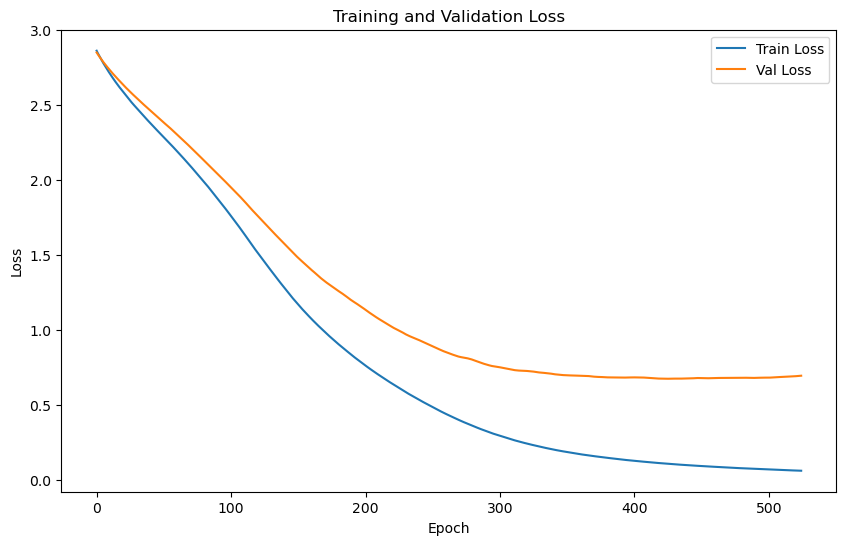

In [59]:
sclsdl_mlp_input_dim = sclsdl_mlp_train_reps.shape[1]
sclsdl_mlp_num_classes = len(torch.unique(sclsdl_mlp_train_labels_torch))
sclsdl_mlp_model = MLPClassifier(sclsdl_mlp_input_dim, sclsdl_mlp_num_classes).to(device)

sclsdl_mlp_criterion = nn.CrossEntropyLoss()
sclsdl_mlp_optimizer = optim.Adam(sclsdl_mlp_model.parameters(), lr=1e-4)

sclsdl_mlp_num_epochs = 1000
sclsdl_mlp_patience = 100

sclsdl_mlp_train_losses = []
sclsdl_mlp_val_losses = []

sclsdl_mlp_best_val_loss = float('inf')
sclsdl_mlp_epochs_without_improvement = 0

for sclsdl_mlp_epoch in range(sclsdl_mlp_num_epochs):
    # Training
    sclsdl_mlp_model.train()
    sclsdl_mlp_train_running_loss = 0.0
    
    for sclsdl_mlp_embeddings_batch, sclsdl_mlp_labels_batch in sclsdl_mlp_train_loader:
        sclsdl_mlp_embeddings_batch = sclsdl_mlp_embeddings_batch.to(device)
        sclsdl_mlp_labels_batch = sclsdl_mlp_labels_batch.to(device)
        
        sclsdl_mlp_optimizer.zero_grad()
        
        # Forward
        sclsdl_mlp_outputs = sclsdl_mlp_model(sclsdl_mlp_embeddings_batch)
        sclsdl_mlp_loss = sclsdl_mlp_criterion(sclsdl_mlp_outputs, sclsdl_mlp_labels_batch)
        
        # Backward & Update
        sclsdl_mlp_loss.backward()
        sclsdl_mlp_optimizer.step()
        
        sclsdl_mlp_train_running_loss += sclsdl_mlp_loss.item() * sclsdl_mlp_embeddings_batch.size(0)
    
    sclsdl_mlp_epoch_train_loss = sclsdl_mlp_train_running_loss / len(sclsdl_mlp_train_loader.dataset)
    sclsdl_mlp_train_losses.append(sclsdl_mlp_epoch_train_loss)

    # Validation
    sclsdl_mlp_model.eval()
    sclsdl_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for sclsdl_mlp_val_embeddings_batch, sclsdl_mlp_val_labels_batch in sclsdl_mlp_val_loader:
            sclsdl_mlp_val_embeddings_batch = sclsdl_mlp_val_embeddings_batch.to(device)
            sclsdl_mlp_val_labels_batch = sclsdl_mlp_val_labels_batch.to(device)

            sclsdl_mlp_val_outputs = sclsdl_mlp_model(sclsdl_mlp_val_embeddings_batch)
            sclsdl_mlp_val_loss = sclsdl_mlp_criterion(sclsdl_mlp_val_outputs, sclsdl_mlp_val_labels_batch)

            sclsdl_mlp_val_running_loss += sclsdl_mlp_val_loss.item() * sclsdl_mlp_val_embeddings_batch.size(0)

    sclsdl_mlp_epoch_val_loss = sclsdl_mlp_val_running_loss / len(sclsdl_mlp_val_loader.dataset)
    sclsdl_mlp_val_losses.append(sclsdl_mlp_epoch_val_loss)

    print(f"[Epoch {sclsdl_mlp_epoch+1}/{sclsdl_mlp_num_epochs}] "
          f"Train Loss: {sclsdl_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {sclsdl_mlp_epoch_val_loss:.4f}")

    # Early stopping
    if sclsdl_mlp_epoch_val_loss < sclsdl_mlp_best_val_loss:
        print(f"Validation loss improved from {sclsdl_mlp_best_val_loss:.4f} to {sclsdl_mlp_epoch_val_loss:.4f}.")
        sclsdl_mlp_best_val_loss = sclsdl_mlp_epoch_val_loss
        sclsdl_mlp_epochs_without_improvement = 0


    else:
        sclsdl_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {sclsdl_mlp_epochs_without_improvement}/{sclsdl_mlp_patience}")
        
        if sclsdl_mlp_epochs_without_improvement >= sclsdl_mlp_patience:
            print(f"!! Early stopping triggered at epoch {sclsdl_mlp_epoch+1} !!\n"
                  f"No improvement for {sclsdl_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(sclsdl_mlp_train_losses, label='Train Loss')
plt.plot(sclsdl_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved SCL_SDL+MLP predictions and true labels to model_predictions
Test Loss: 1.2299 | Test Accuracy: 73.89%


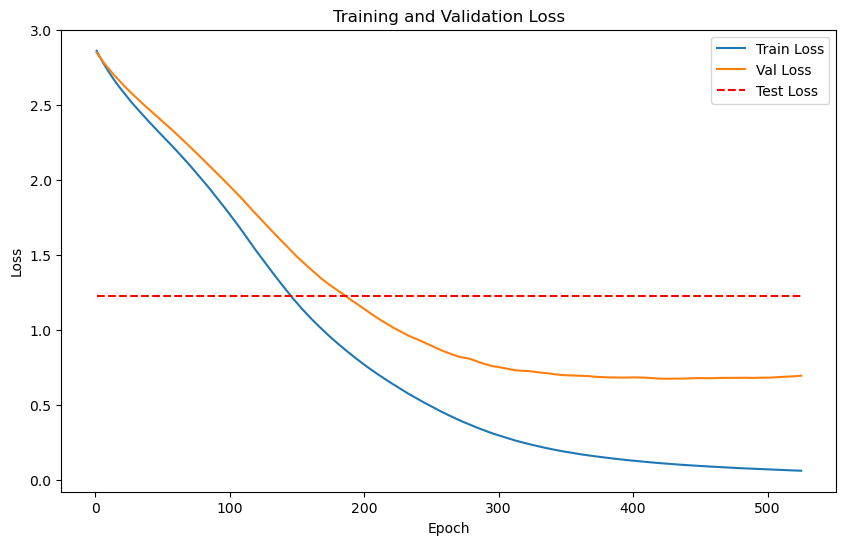

In [60]:
sclsdl_mlp_model.eval()

sclsdl_mlp_test_running_loss = 0.0
sclsdl_mlp_test_correct = 0
sclsdl_mlp_all_predictions = []
sclsdl_mlp_all_true_labels = []

with torch.no_grad():
    for sclsdl_mlp_test_embeddings_batch, sclsdl_mlp_test_labels_batch in sclsdl_mlp_test_loader:
        sclsdl_mlp_test_embeddings_batch = sclsdl_mlp_test_embeddings_batch.to(device)
        sclsdl_mlp_test_labels_batch = sclsdl_mlp_test_labels_batch.to(device)

        # Forward pass
        sclsdl_mlp_test_outputs = sclsdl_mlp_model(sclsdl_mlp_test_embeddings_batch)
        
        # Compute loss
        sclsdl_mlp_test_loss_batch = sclsdl_mlp_criterion(sclsdl_mlp_test_outputs, sclsdl_mlp_test_labels_batch)
        sclsdl_mlp_test_running_loss += sclsdl_mlp_test_loss_batch.item() * sclsdl_mlp_test_embeddings_batch.size(0)

        _, sclsdl_mlp_test_predicted = torch.max(sclsdl_mlp_test_outputs, dim=1)
        sclsdl_mlp_test_correct += (sclsdl_mlp_test_predicted == sclsdl_mlp_test_labels_batch).sum().item()

        sclsdl_mlp_all_predictions.extend(sclsdl_mlp_test_predicted.cpu().numpy())
        sclsdl_mlp_all_true_labels.extend(sclsdl_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'sclsdl_mlp_predictions.npy'), np.array(sclsdl_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'sclsdl_mlp_true_labels.npy'), np.array(sclsdl_mlp_all_true_labels))
print(f"Saved SCL_SDL+MLP predictions and true labels to {predictions_dir}")

sclsdl_mlp_epoch_test_loss = sclsdl_mlp_test_running_loss / len(sclsdl_mlp_test_loader.dataset)
sclsdl_mlp_test_accuracy = sclsdl_mlp_test_correct / len(sclsdl_mlp_test_loader.dataset)

sclsdl_mlp_test_accuracy_pct = sclsdl_mlp_test_accuracy * 100.0

print(f"Test Loss: {sclsdl_mlp_epoch_test_loss:.4f} | Test Accuracy: {sclsdl_mlp_test_accuracy_pct:.2f}%")

sclsdl_mlp_num_epochs_run = len(sclsdl_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         sclsdl_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         sclsdl_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         [sclsdl_mlp_epoch_test_loss]*sclsdl_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


## Experimental Results and Confusion Matrices

In [61]:
def plot_conf_matrix(model_name, class_names = None, cm_save_dir='confusion_matrices'):
    os.makedirs(cm_save_dir, exist_ok = True)

    #loading predictions and true labels
    predictions_path = os.path.join(predictions_dir, f'{model_name}_predictions.npy')
    true_labels_path = os.path.join(predictions_dir, f'{model_name}_true_labels.npy')

    if not os.path.exists(predictions_path) or not os.path.exists(true_labels_path):
        print(f"Error: Files not found for model {model_name}")
        return
    
    cm_predictions = np.load(predictions_path)
    cm_true_labels = np.load(true_labels_path)

    conf_matrix = confusion_matrix(cm_true_labels, cm_predictions)
    plt.figure(figsize=(8,8))

    conf_matrix_normalised = conf_matrix.astype('float') / conf_matrix.sum(axis = 1)[:, np.newaxis]
    sns.heatmap(conf_matrix_normalised, annot=conf_matrix, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

    plt.title(f"{model_name.upper()} Confusion Matrix", fontsize=16)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()

    cm_save_path = os.path.join(cm_save_dir, f'{model_name}_confusion_matrix.png')
    plt.savefig(cm_save_path, dpi=300, bbox_inches='tight')
    print(f"Saved confusion matrix to: {cm_save_path}")

    plt.show()

    accuracy = np.trace(conf_matrix) / np.sum(conf_matrix)
    print(f"Classification Accuracy: {accuracy*100:.2f}%")

Saving confusion matrices to: confusion_matrices


Saved confusion matrix to: confusion_matrices\e2e_cnn_confusion_matrix.png


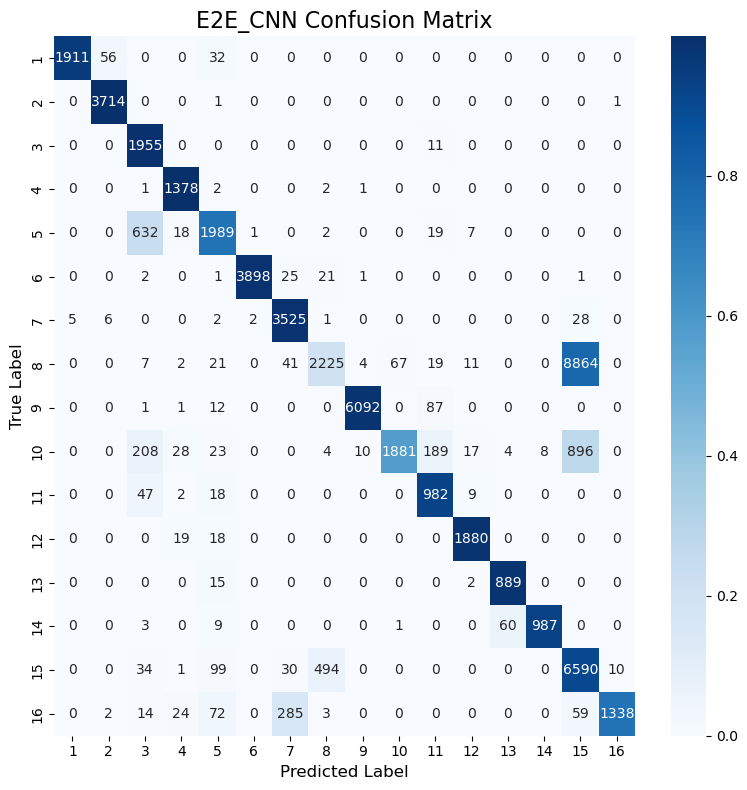

Classification Accuracy: 76.40%


Saved confusion matrix to: confusion_matrices\cae_lrm_confusion_matrix.png


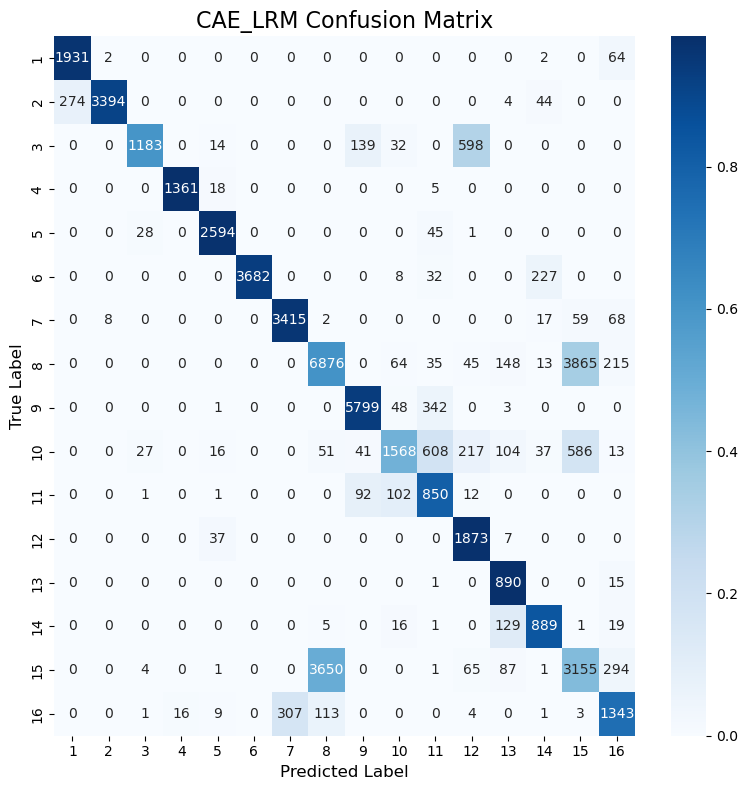

Classification Accuracy: 75.60%


Saved confusion matrix to: confusion_matrices\cae_mlp_confusion_matrix.png


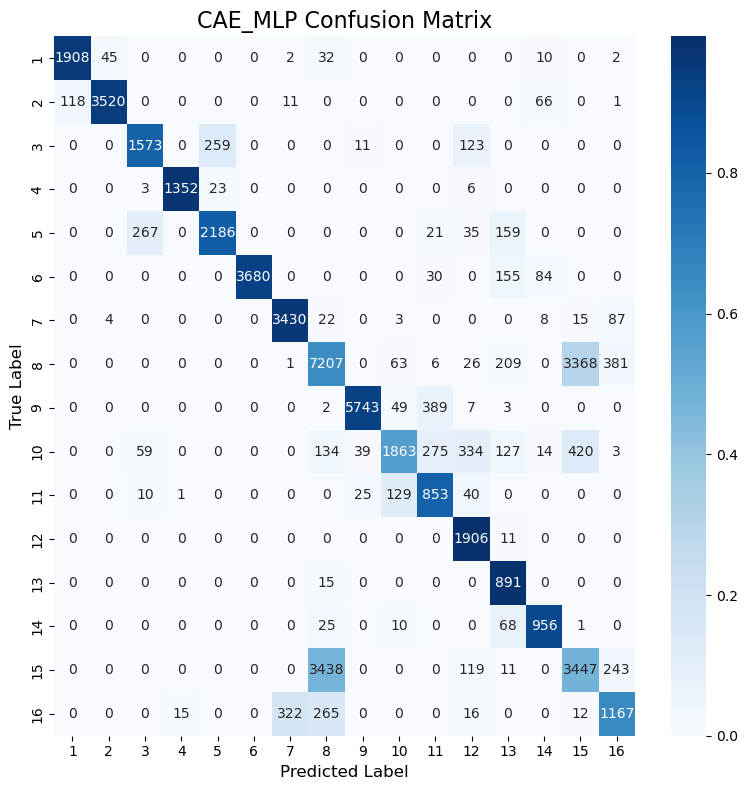

Classification Accuracy: 77.23%


Saved confusion matrix to: confusion_matrices\tscl_lrm_confusion_matrix.png


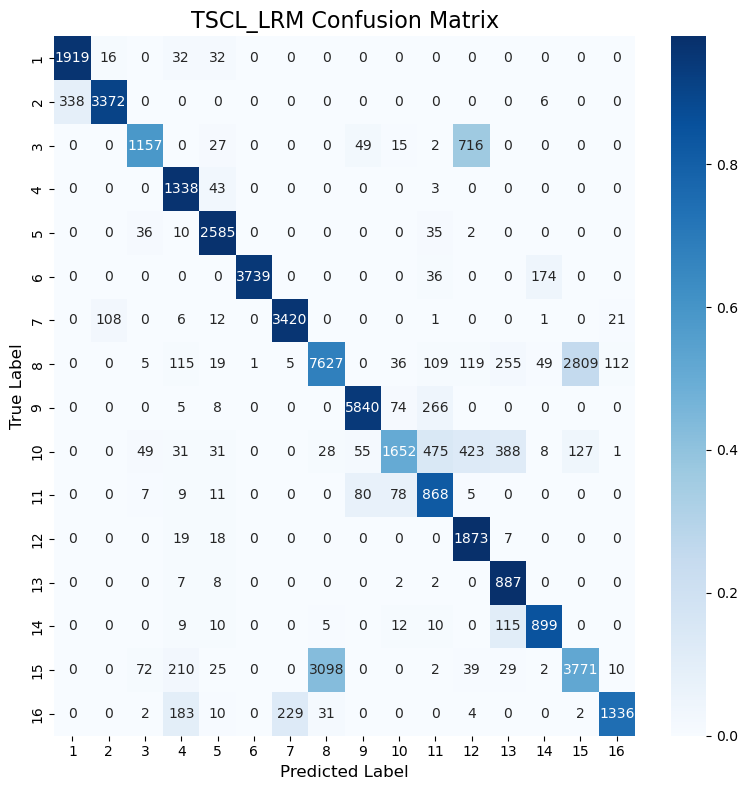

Classification Accuracy: 78.35%


Saved confusion matrix to: confusion_matrices\tscl_mlp_confusion_matrix.png


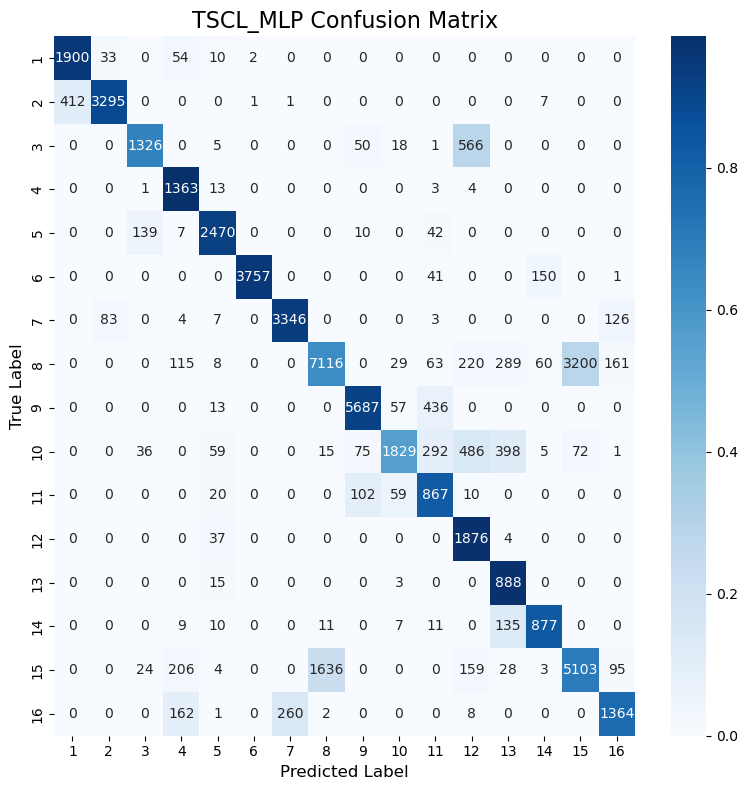

Classification Accuracy: 79.79%


Saved confusion matrix to: confusion_matrices\sclsdl_lrm_confusion_matrix.png


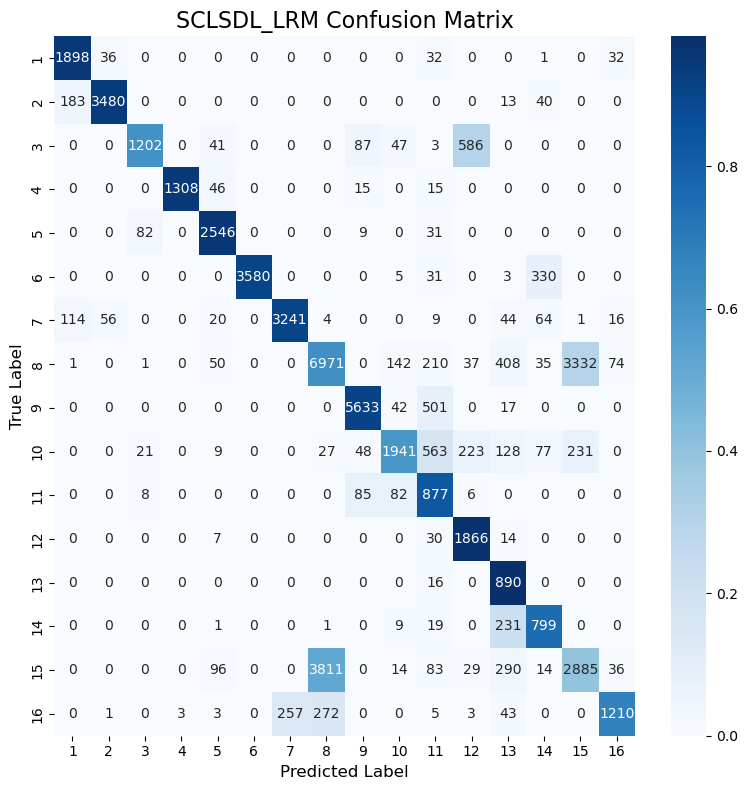

Classification Accuracy: 74.72%


Saved confusion matrix to: confusion_matrices\sclsdl_mlp_confusion_matrix.png


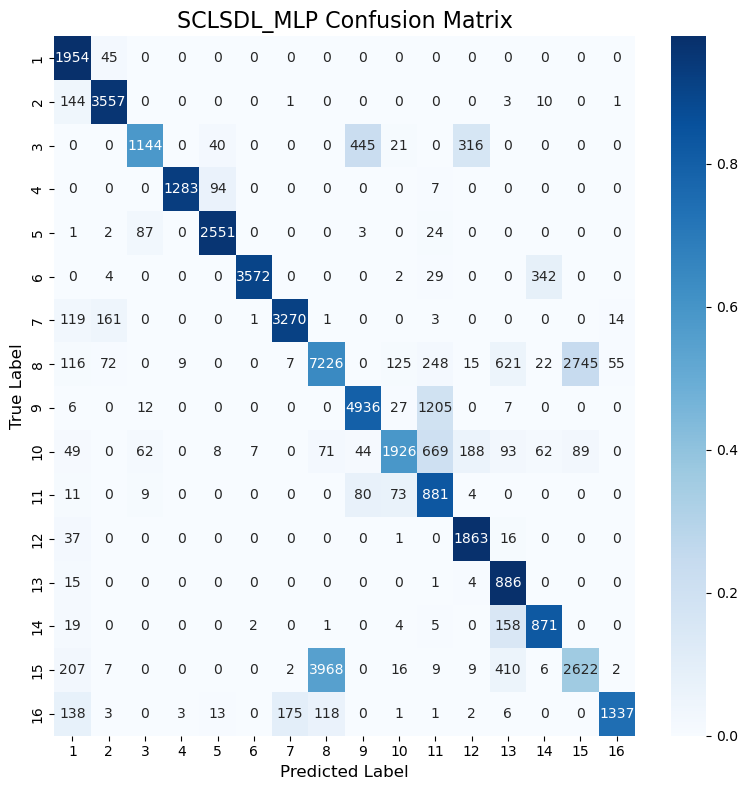

Classification Accuracy: 73.89%


In [62]:
class_names = [str(i+1) for i in range(len(np.unique(y_labels)))]
confusion_matrices_dir = 'confusion_matrices'
os.makedirs(confusion_matrices_dir, exist_ok=True)
print(f"Saving confusion matrices to: {confusion_matrices_dir}")
plot_conf_matrix('e2e_cnn', class_names, confusion_matrices_dir)
plot_conf_matrix('cae_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('cae_mlp', class_names, confusion_matrices_dir)
plot_conf_matrix('tscl_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('tscl_mlp', class_names, confusion_matrices_dir)
plot_conf_matrix('sclsdl_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('sclsdl_mlp', class_names, confusion_matrices_dir)

In [63]:
final_results_df = pd.DataFrame({
    "Model": ["E2E CNN", "LRM (CAE)", "MLP (CAE)", "TSCL LRM", "TSCL MLP", "SCL_SDL LRM", "SCL_SDL MLP"],
    "Test_Accuracy": [test_accuracy, lrm_test_accuracy * 100, cae_mlp_test_accuracy_pct, 
                      tscl_lrm_test_accuracy * 100, tscl_mlp_test_accuracy_pct, 
                      sclsdl_lrm_test_accuracy * 100, sclsdl_mlp_test_accuracy_pct]
})

pd.options.display.float_format = '{:.2f}'.format

print(final_results_df)
print(f"\nIn Desc. Order (Test Accu)\n{final_results_df.sort_values('Test_Accuracy', ascending=False)}")

         Model  Test_Accuracy
0      E2E CNN          76.40
1    LRM (CAE)          75.60
2    MLP (CAE)          77.23
3     TSCL LRM          78.35
4     TSCL MLP          79.79
5  SCL_SDL LRM          74.72
6  SCL_SDL MLP          73.89

In Desc. Order (Test Accu)
         Model  Test_Accuracy
4     TSCL MLP          79.79
3     TSCL LRM          78.35
2    MLP (CAE)          77.23
0      E2E CNN          76.40
1    LRM (CAE)          75.60
5  SCL_SDL LRM          74.72
6  SCL_SDL MLP          73.89
